# Learning RL interface guide

Unified interface for RL algorithms. 
Code compiled from different sources:
* RL Adventure [part 1](https://github.com/higgsfield/RL-Adventure), [part 2](https://github.com/higgsfield/RL-Adventure-2) - (carefull, a lot of bugs!)
* [Deep RL Tutorials](https://github.com/qfettes/DeepRL-Tutorials)
* [Ptan library](https://github.com/Shmuma/ptan)

In [1]:
from LRL import *

# Playing games inline

In [2]:
env = gym.make('CartPole-v0')

Agent is base class for all algorithms. 

In [3]:
config = {"env": env}

In [4]:
agent = Agent(config)

Agent can play game in silent mode, render it inline or record all game frames and display as animation.

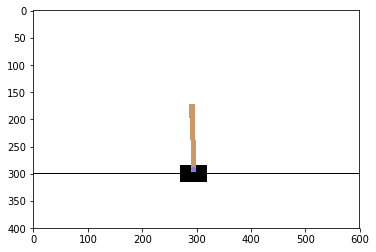

12.0

In [5]:
agent.play(render=True)


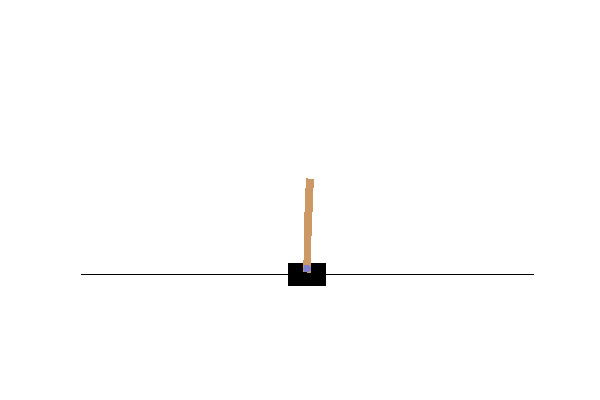
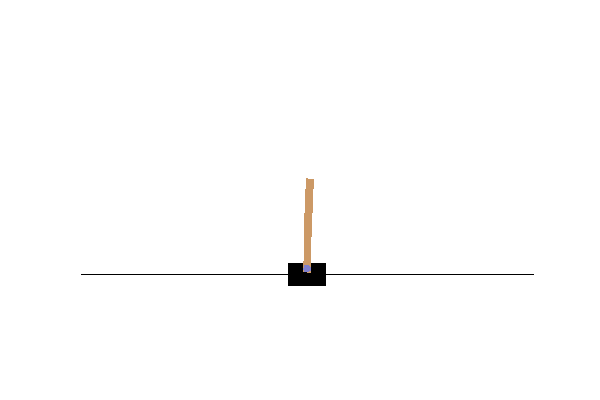
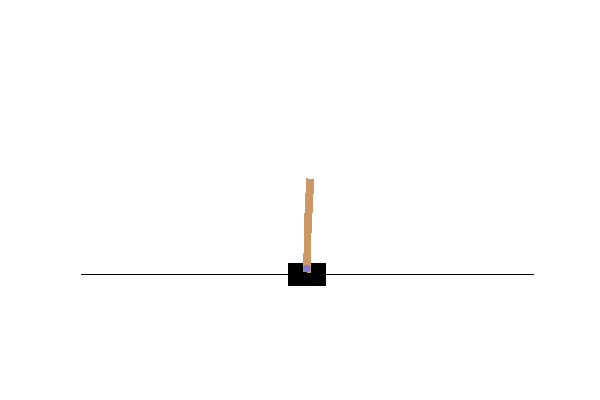
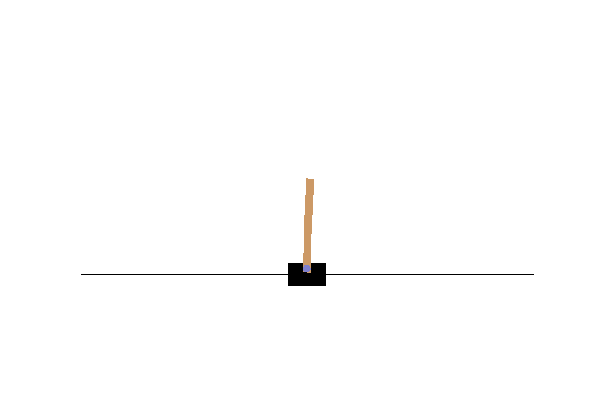
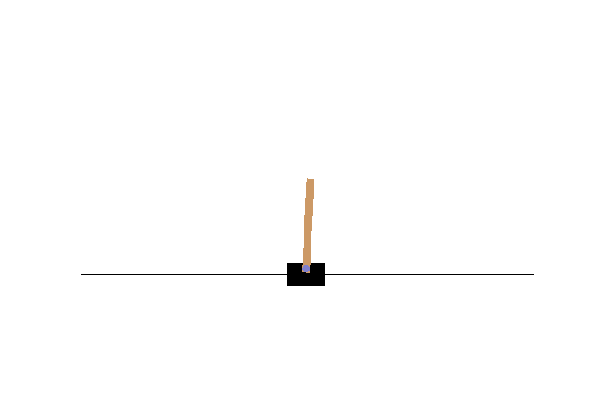
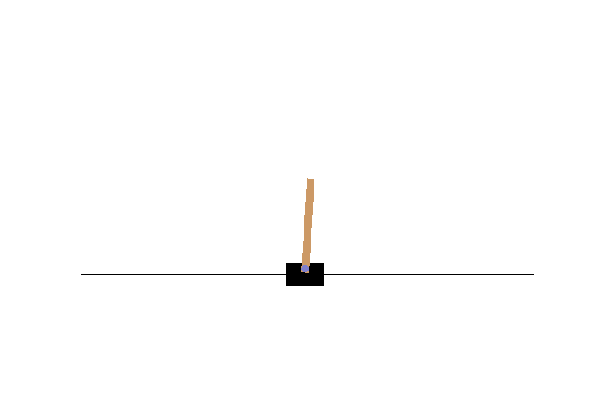
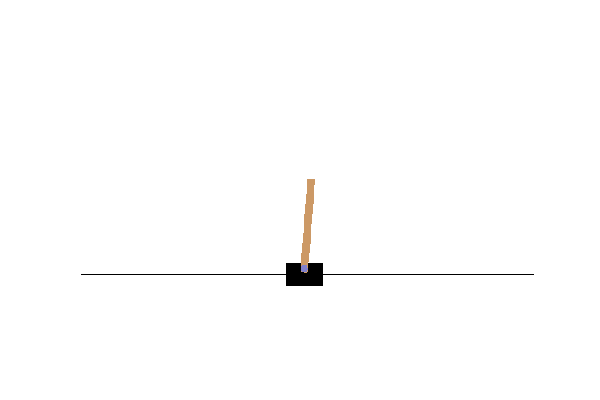
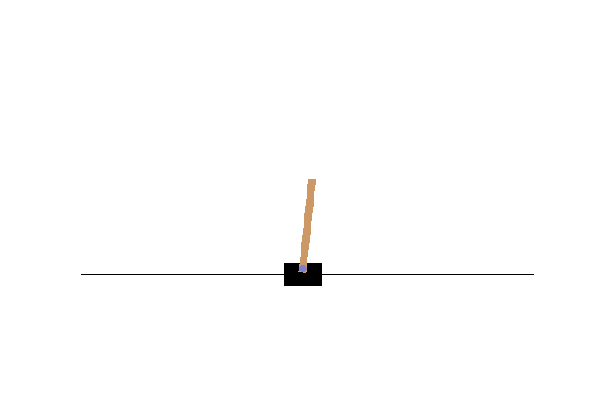
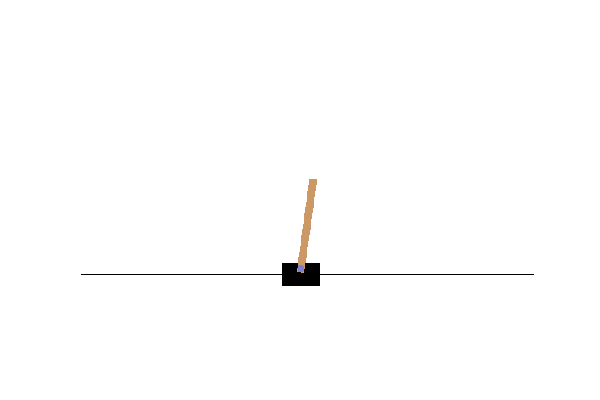
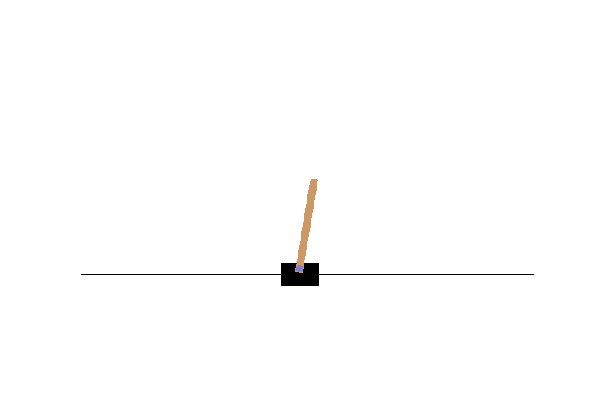
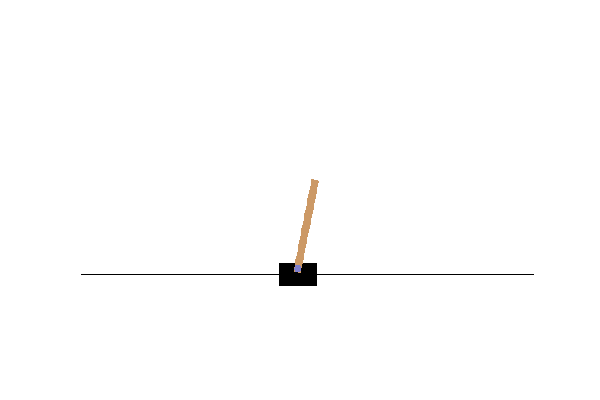
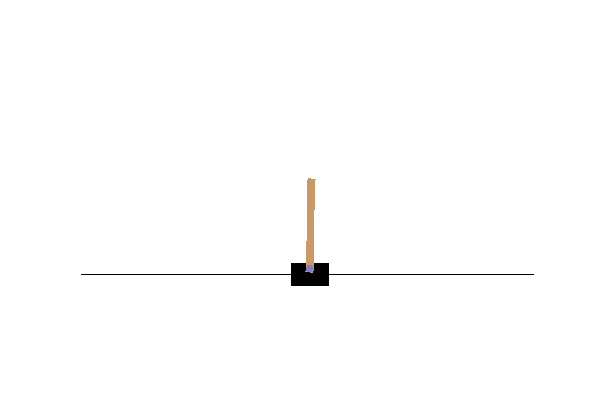

11.0

In [6]:
agent.play(record=True)

# Lego principles

Agents can be constructed by dynamically inheriting algorithms from one another. For example, e-greedy exploration strategy needs just to overload "act" method and call parent's method with $\varepsilon$ probability. To allow to add e-greedy exploration in any agent, some **python magic** is used:

### Some magic python example:

In [7]:
def test(parclass):
    class C(parclass):
        def foo(self):
            print(self.var)
    return C

class A:
    def __init__(self, val):
        self.var = val
        
class B:
    def __init__(self):
        self.var = "hi!"

In [8]:
test(A)(val=179).foo()

179


In [9]:
test(B)().foo()

hi!


Consider classic [atari using DQN example](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf). It uses deep q-learning with replay memory, e-greedy exploration and target network heuristics. We can create an agent class using these ingreedients:

In [10]:
AgentType = eGreedy(TargetQAgent(QAgent(ReplayBufferAgent)))
print(AgentType.__doc__)


    Basic e-Greedy exploration strategy.
    
    Args:
        epsilon_start - value of epsilon at the beginning, float, from 0 to 1
        epsilon_final - minimal value of epsilon, float, from 0 to 1
        epsilon_decay - degree of exponential damping of epsilon, int
    
    Target network heuristic implementation.
    
    Args:
        target_update - frequency in frames of updating target network
    
    Classic deep Q-learning algorithm (DQN).
    Based on: https://arxiv.org/abs/1312.5602
    
    Args:
        QnetworkHead - class of Q-network head, inherited from QnetworkHead
        gamma - infinite horizon protection, float, from 0 to 1
        batch_size - size of batch for optimization on each frame, int
        replay_buffer_init - size of buffer launching q-network optimization
        optimize_iterations - number of gradient descent steps after one transition, can be fractional, float
        optimizer - class inherited from torch.optimizer, Adam by default
       

# Training on cartpole

In [11]:
env = gym.make('CartPole-v0')

Agent requires class of feature extractor network as parameter. DQN will provide it with parameter "linear", which will be standard Torch nn.Linear module or noisy version of it. 

In [12]:
class BasicNetwork(nn.Module):
    def __init__(self, linear):
        super().__init__()
        self.layers = nn.Sequential(
                        linear(4, 128),
                        nn.ReLU(),
                        linear(128, 128),
                        nn.ReLU())
        
    def forward(self, x):
        return self.layers(x)

Qnetwork heads are already provided:
* **Qnetwork** - basic head outputing quality of each action
* **DuelingQnetwork** - dueling version
* **CategoricalQnetwork** - categorical version
* **DuelingCategoricalQnetwork** - categorical + dueling version

#### Agent initialization:

In [13]:
config = {
    "env": env,
    "Qnetwork_FeatureExtractor": BasicNetwork,
    "QnetworkHead": Qnetwork,
    "target_update": 100,
    "batch_size": 32,
    "gamma": 0.99,
    "replay_buffer_init": 128,
    "replay_buffer_capacity": 100000,
    "epsilon_start": 1,
    "epsilon_final": 0.001,
    "epsilon_decay": 500
}

In [14]:
agent = eGreedy(TargetQAgent(QAgent(ReplayBufferAgent)))(config)

#### Training

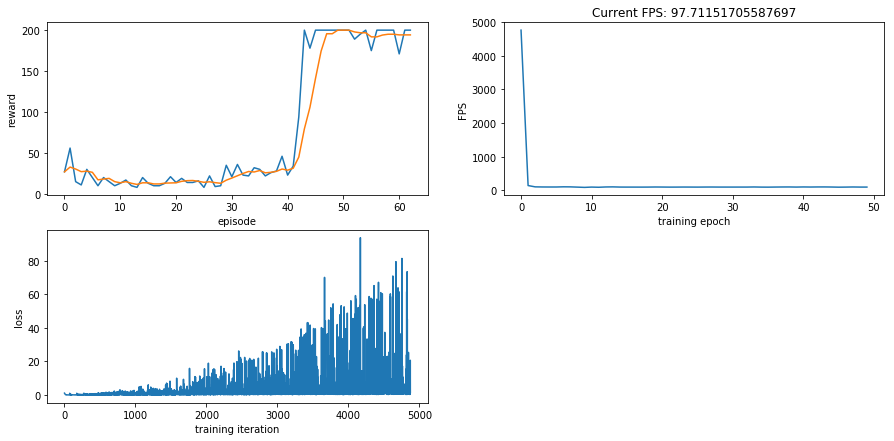

Complete
Wall time: 1min 1s


In [15]:
%%time
for i in range(50):
    agent.learn(100)
    plot_durations(agent, 5)    

print('Complete')
plt.show()

#### Exploitation


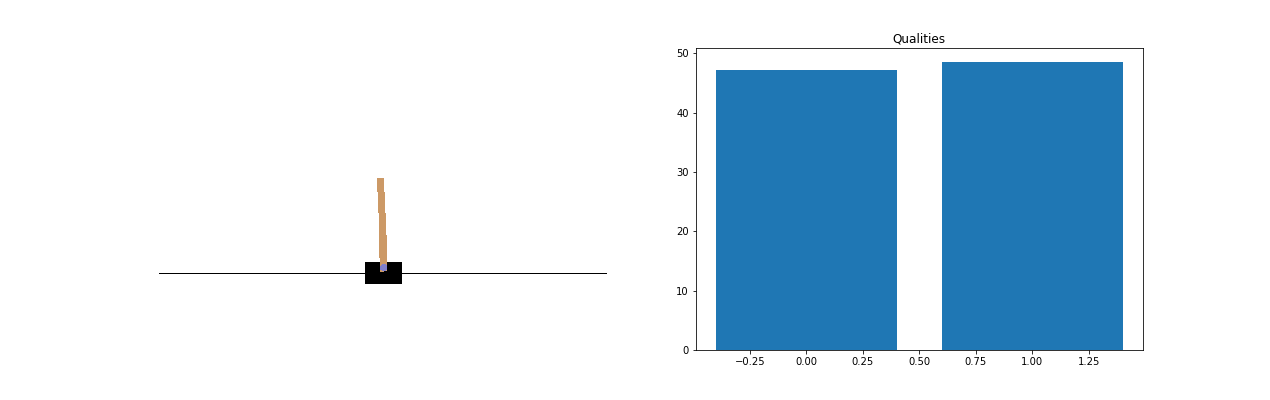
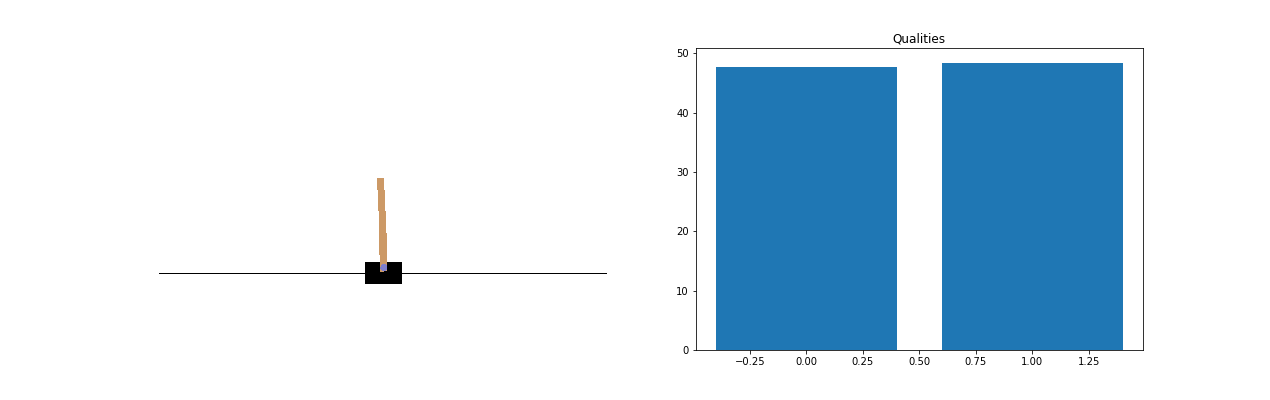
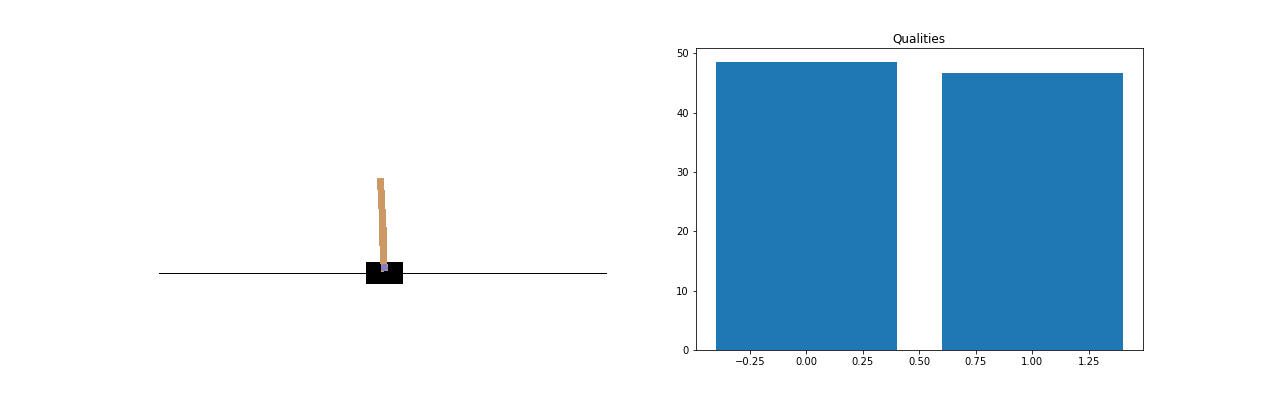
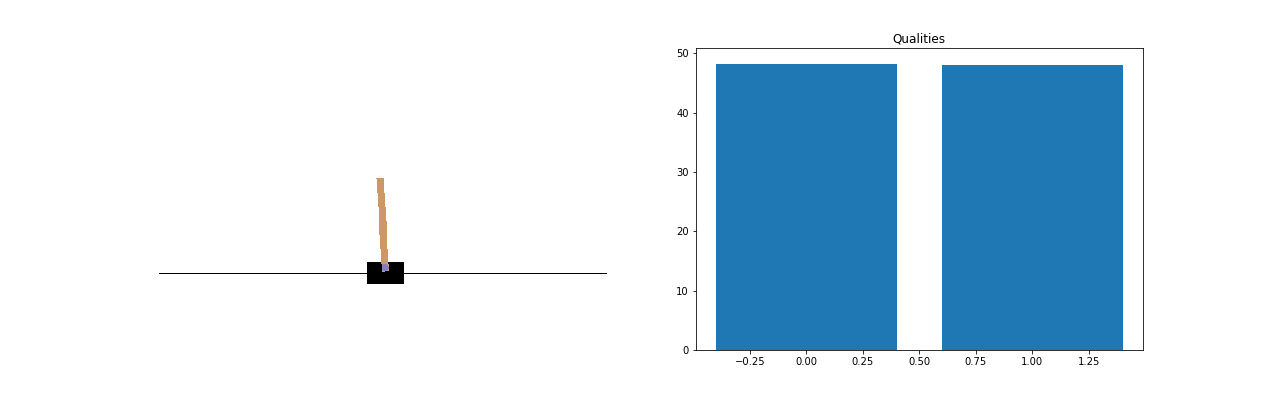
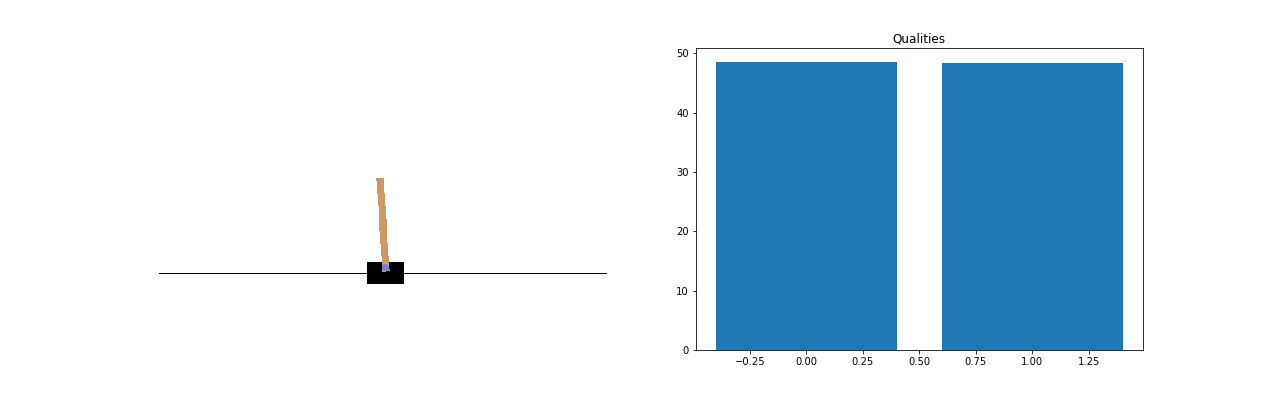
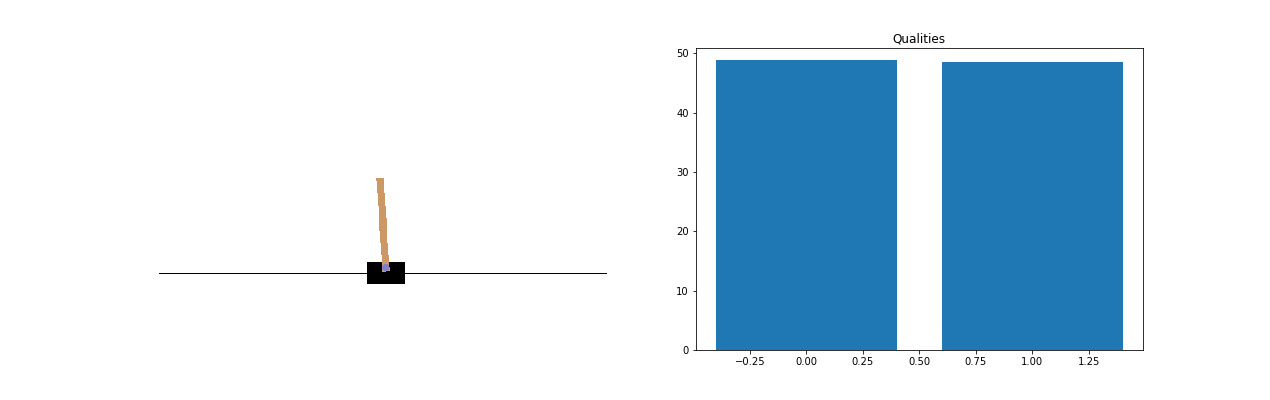
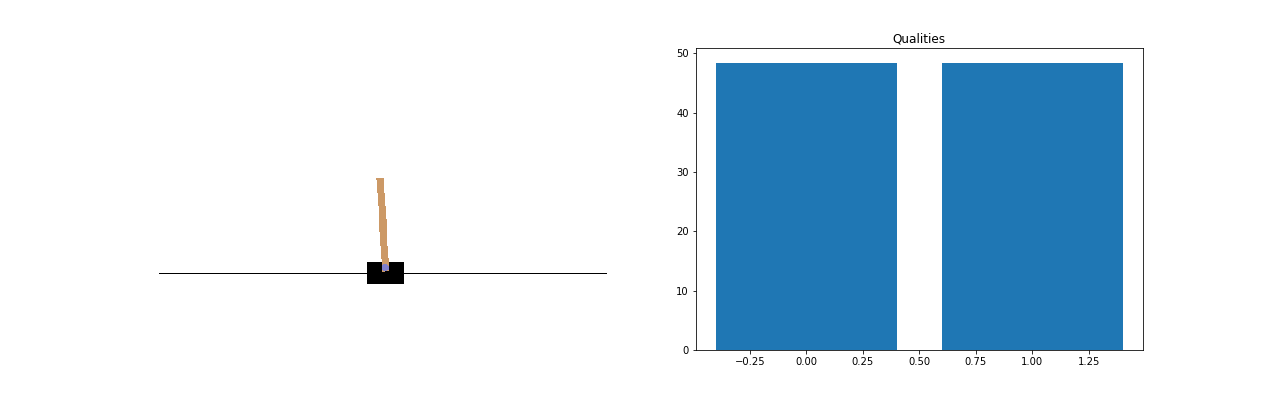
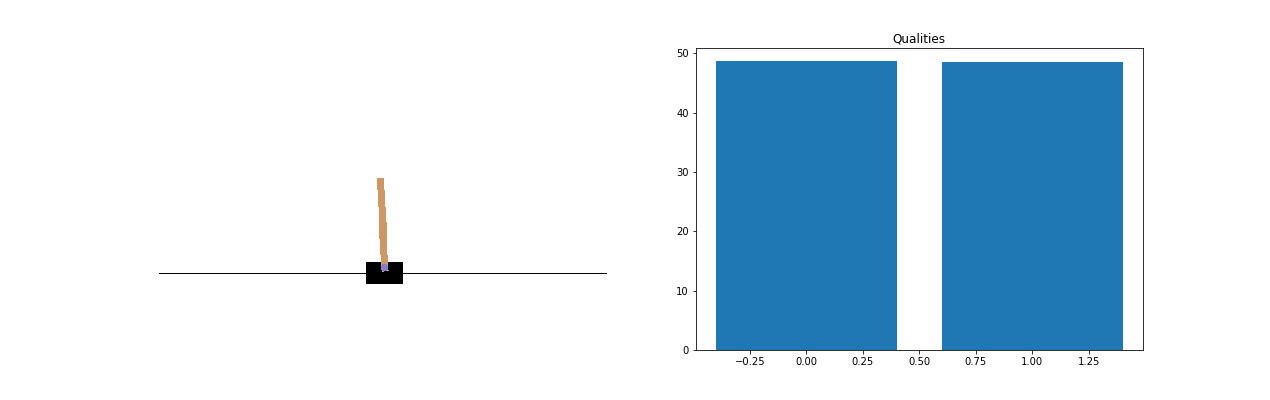
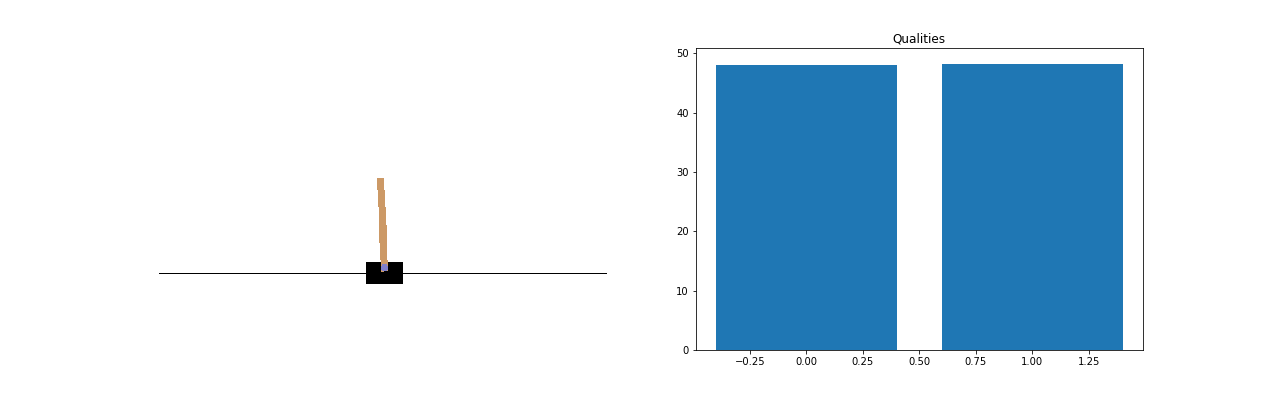
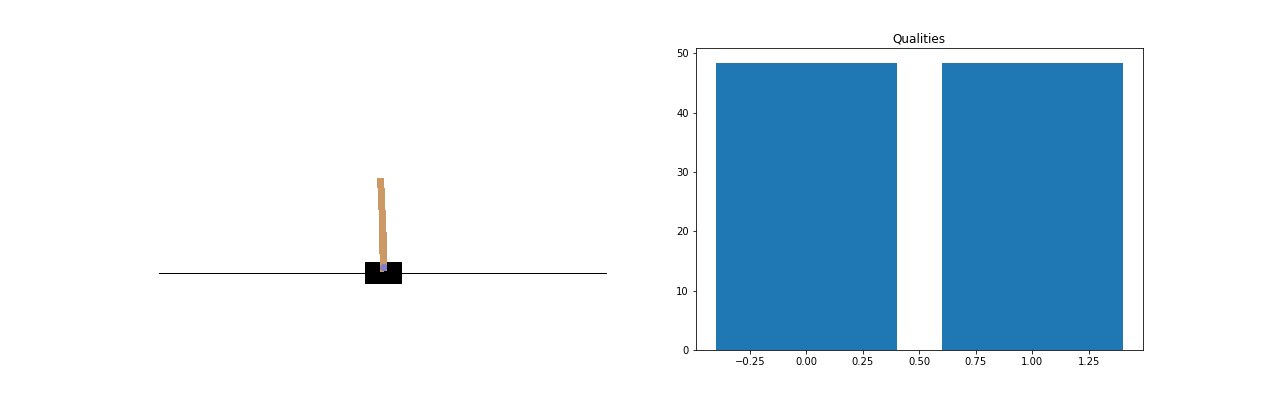
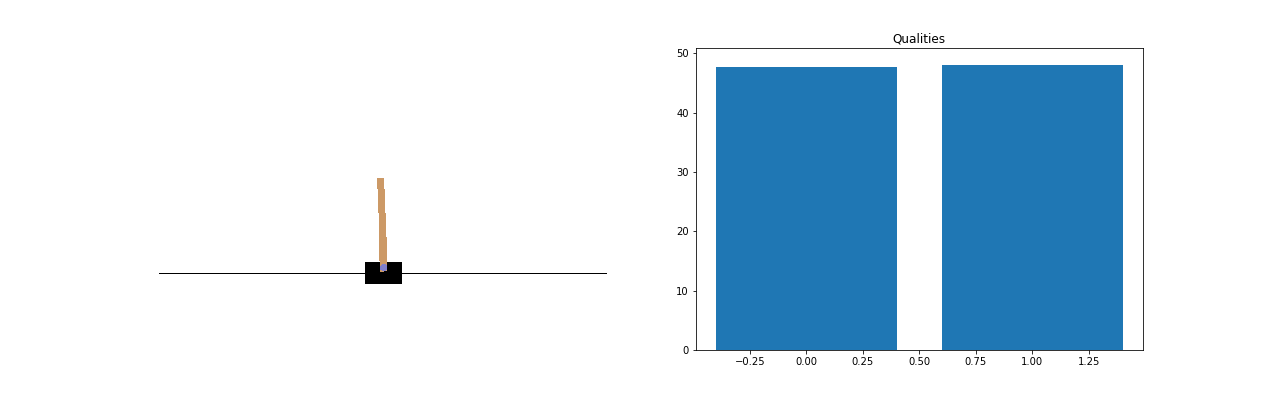
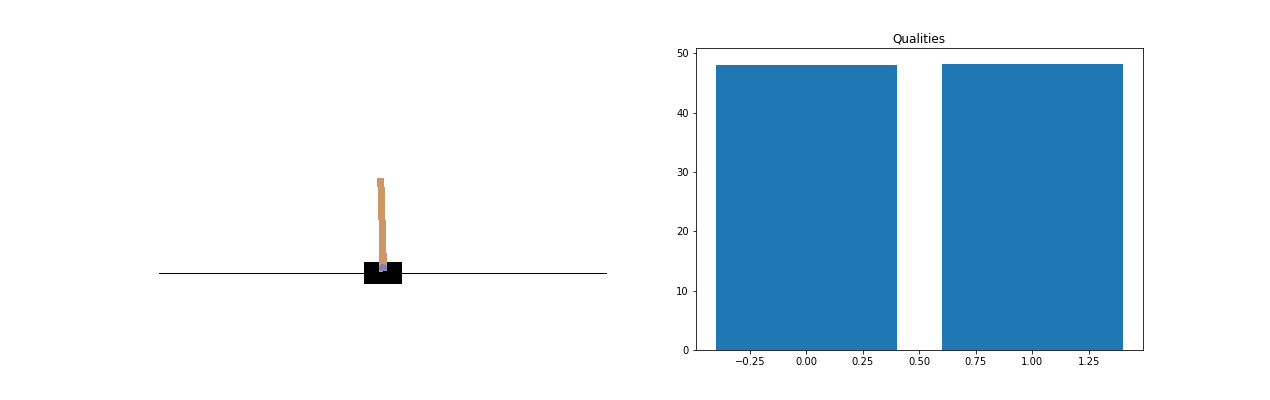
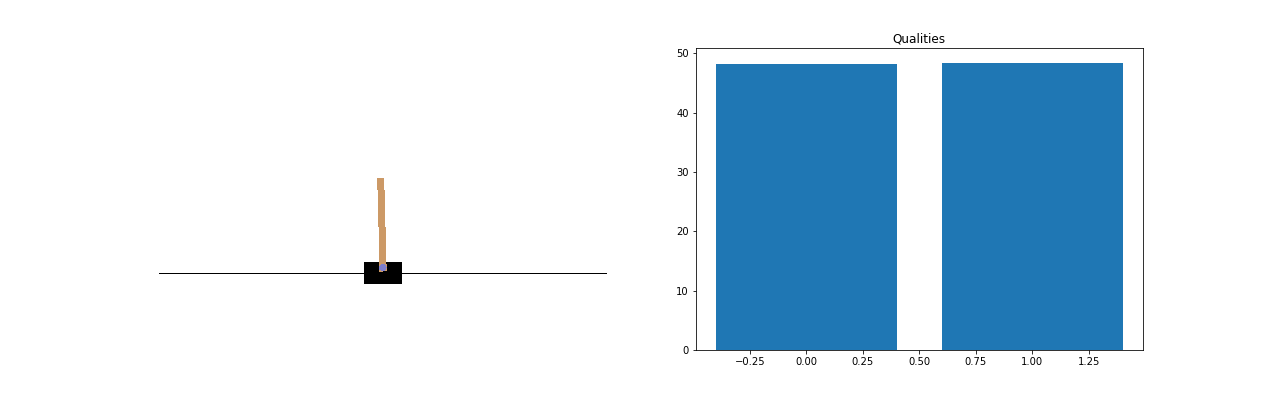
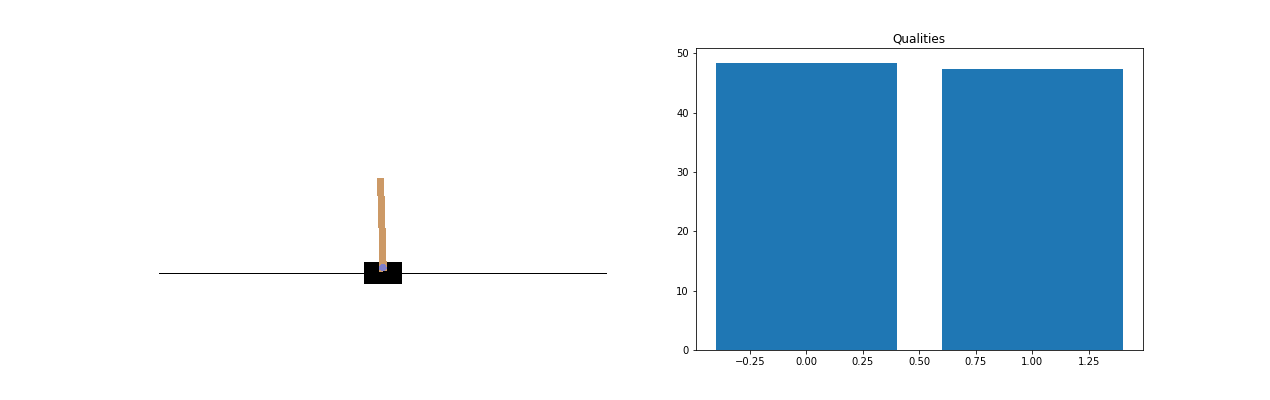
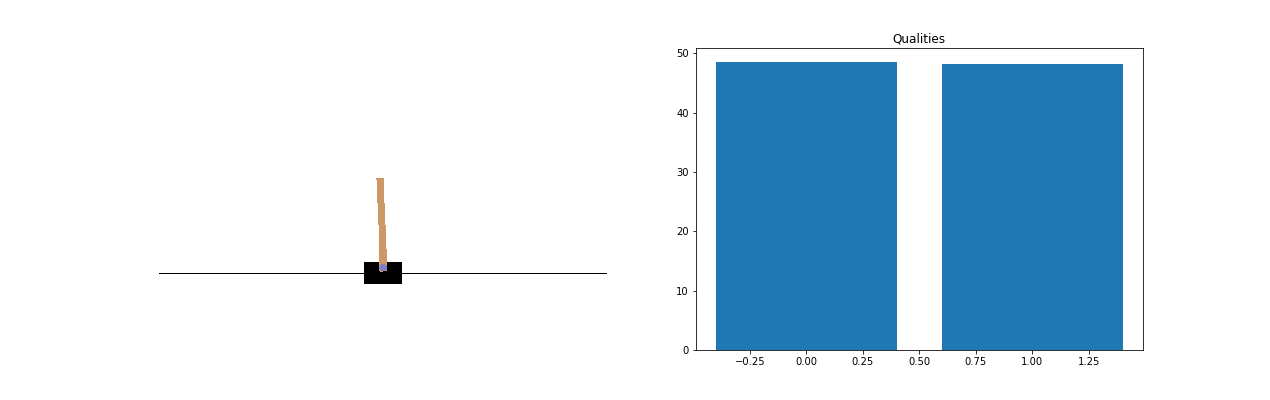
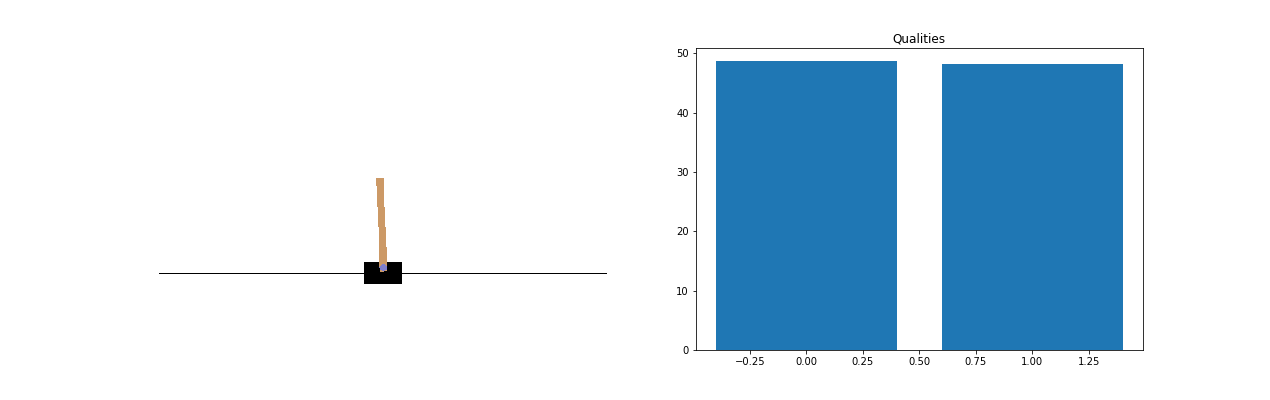
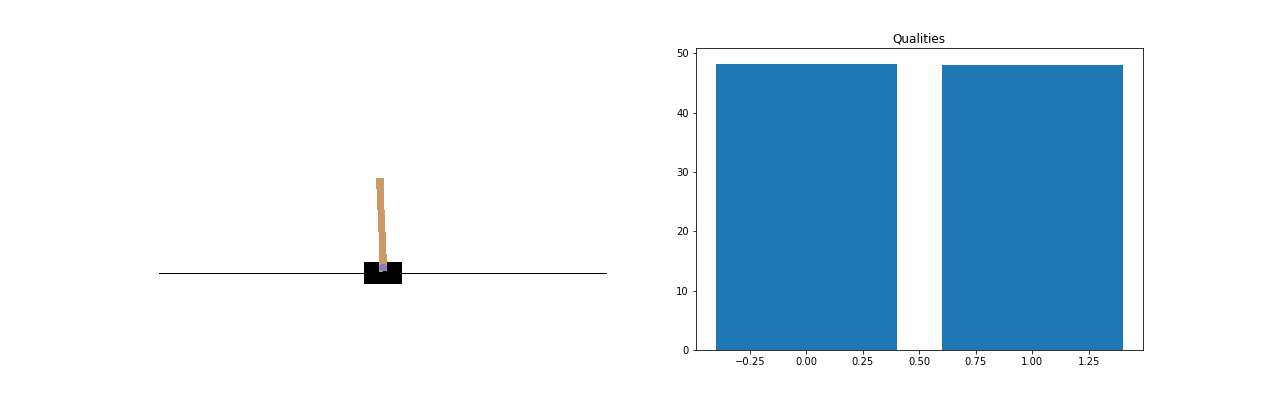
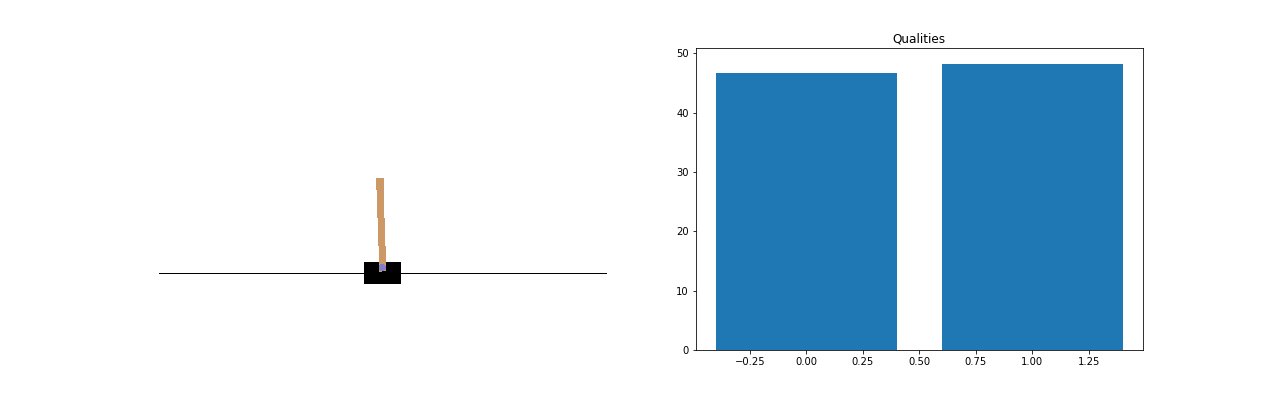
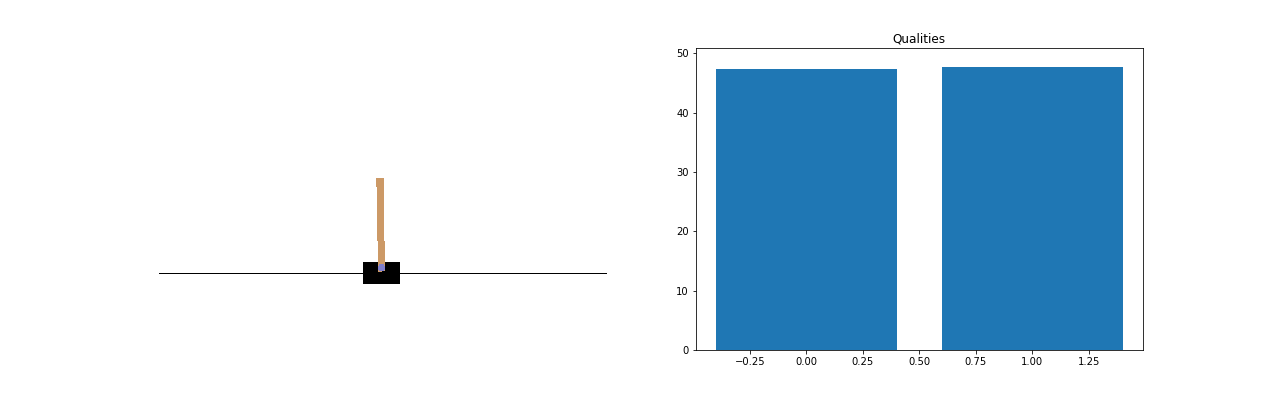
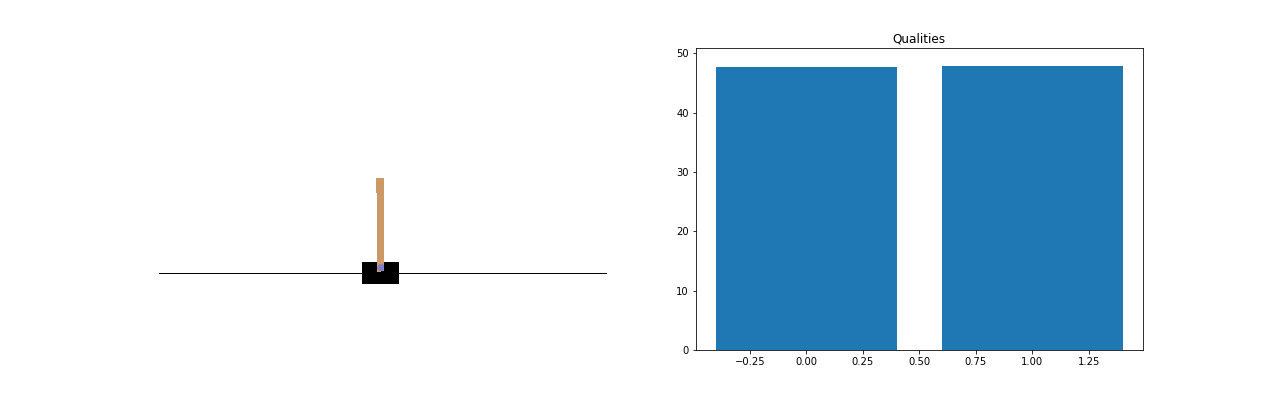
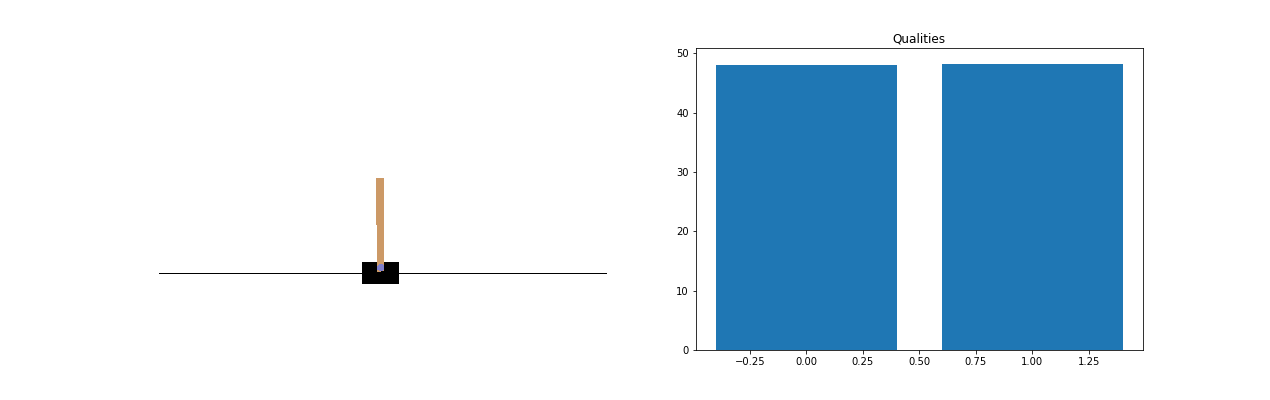
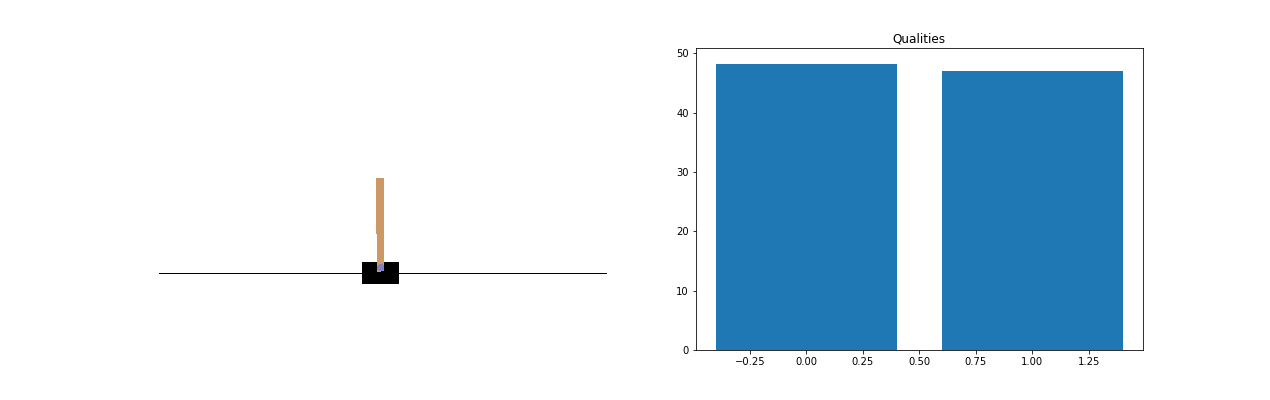
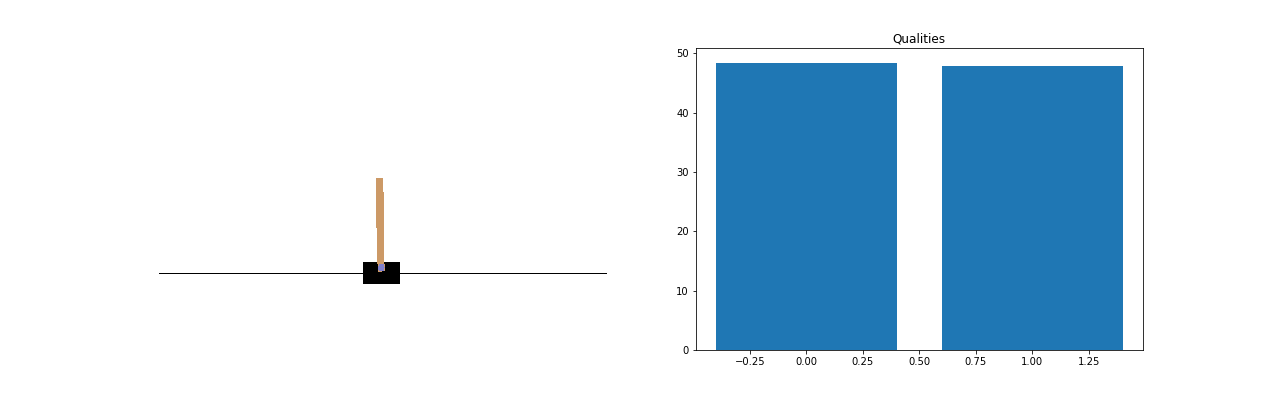
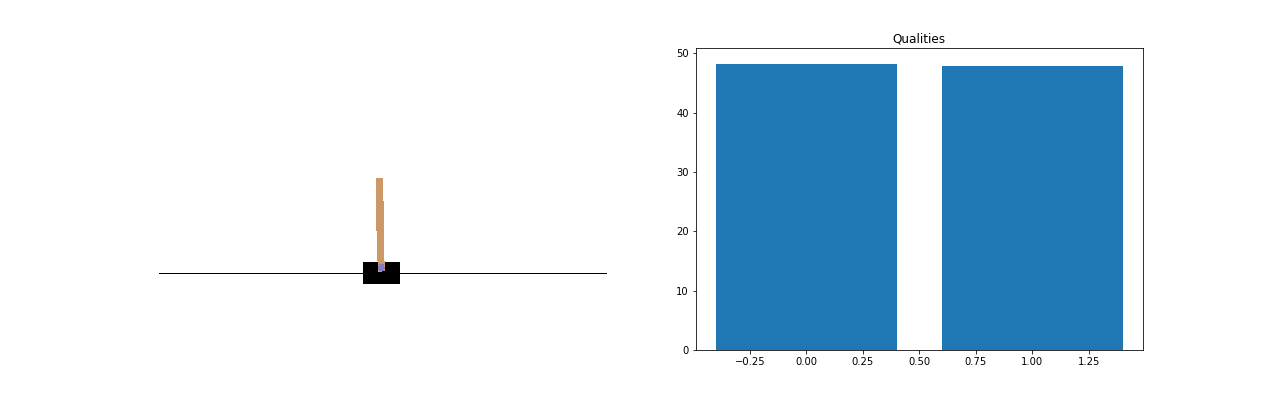
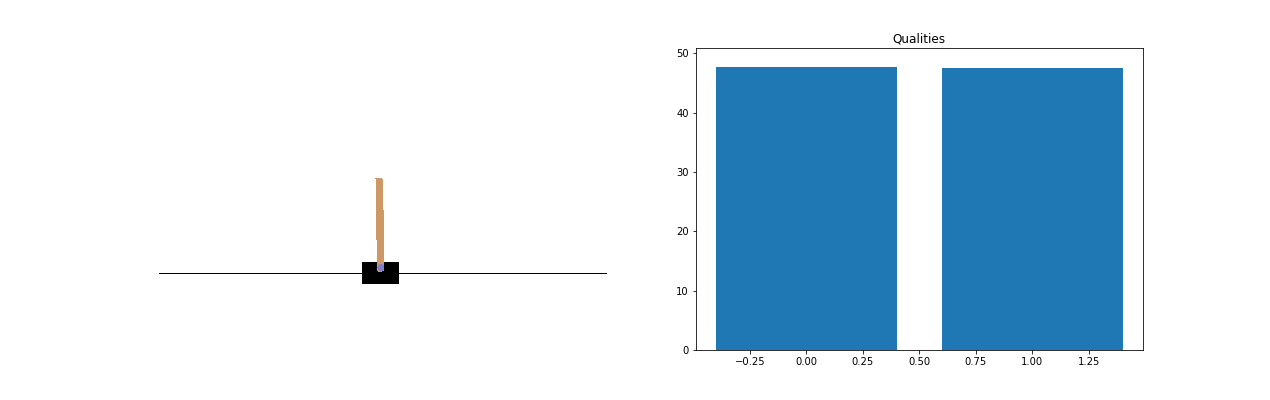
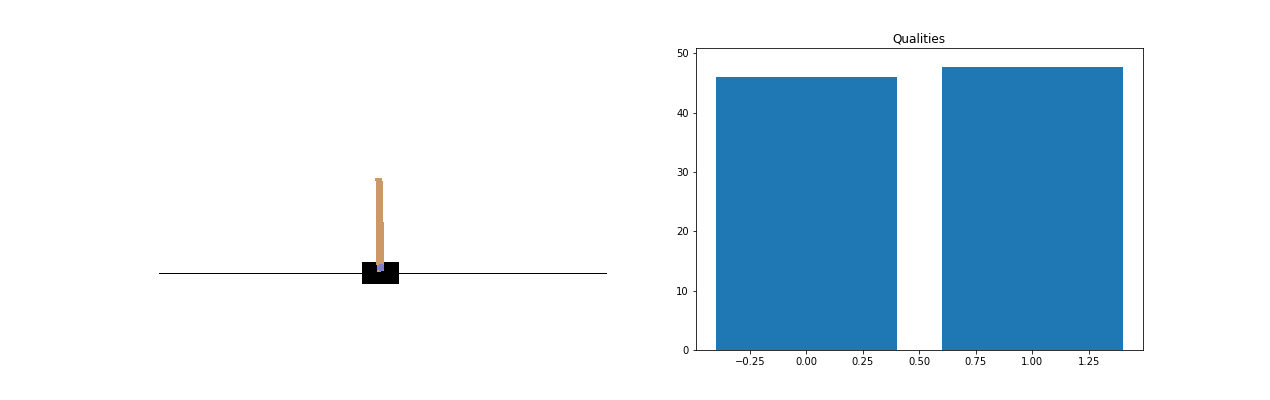
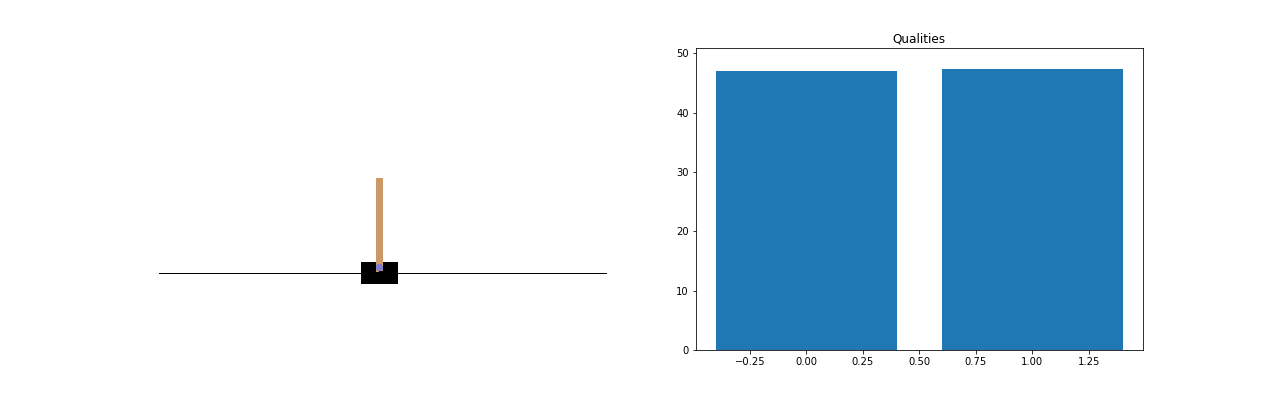
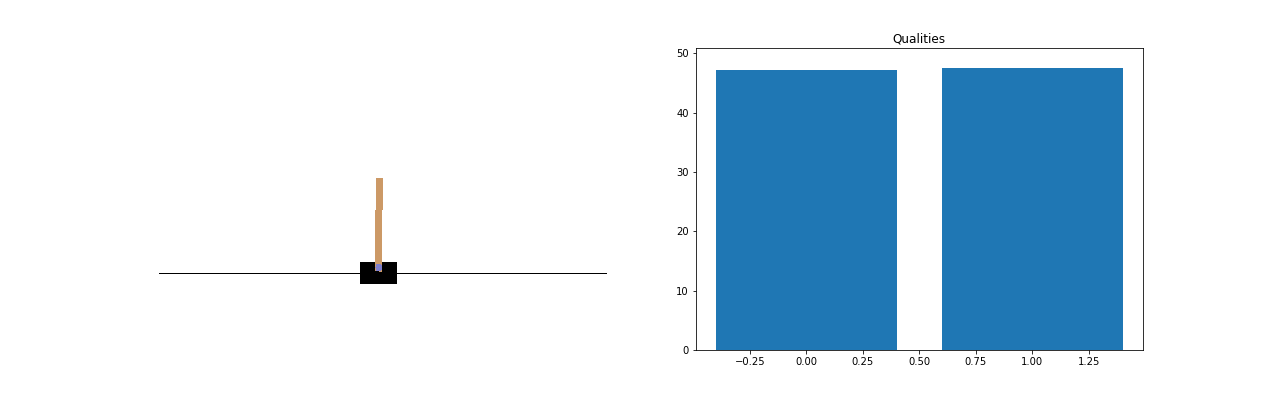
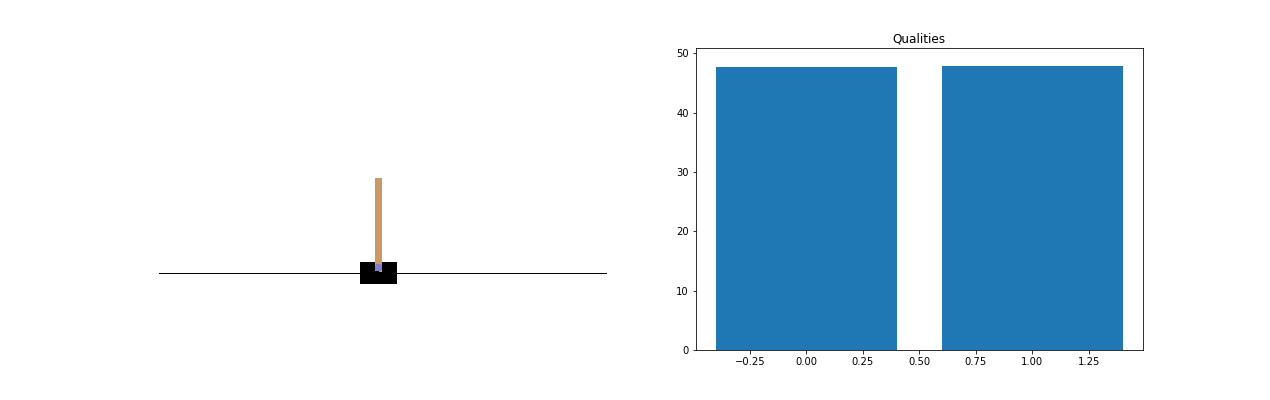
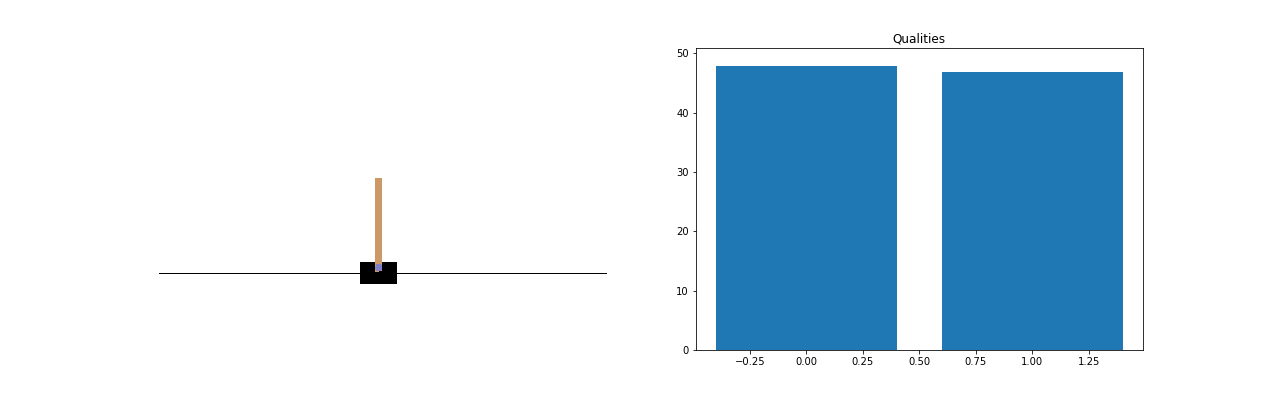
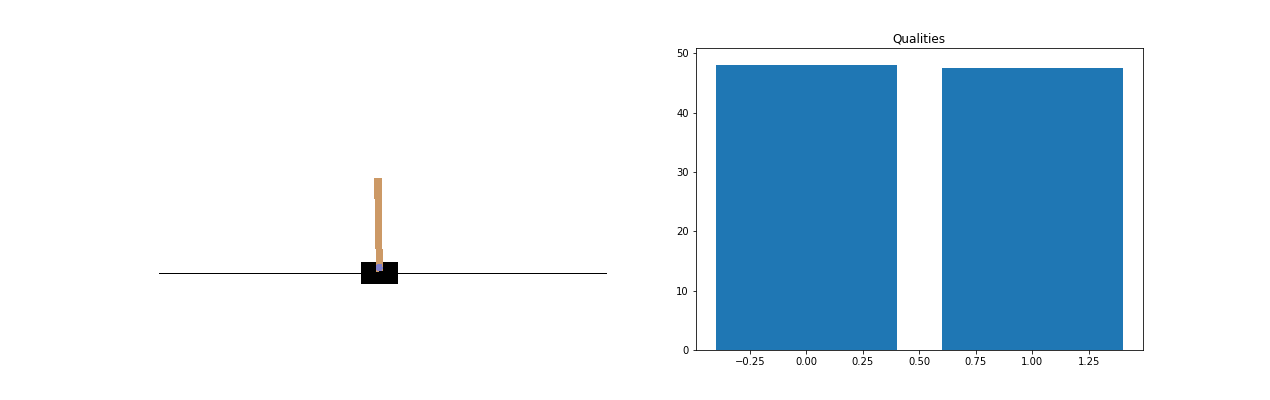
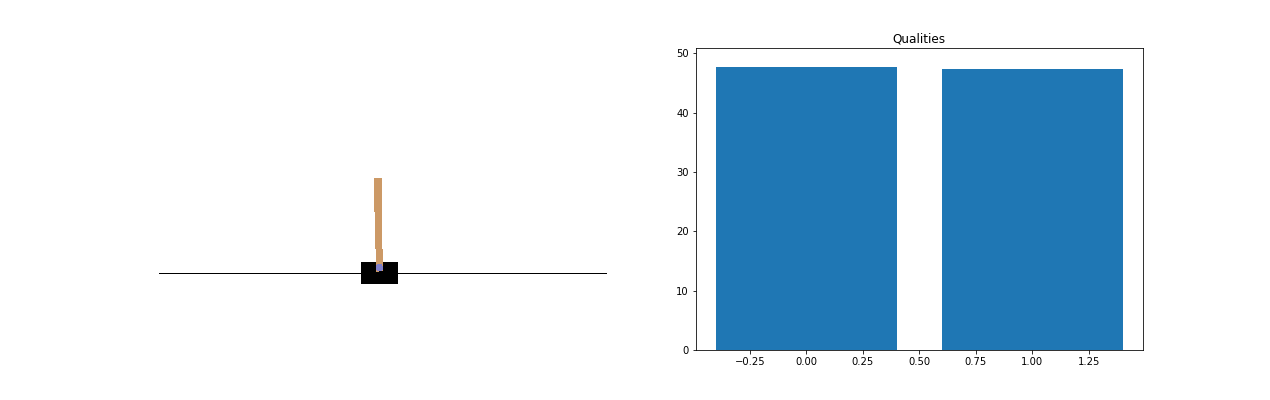
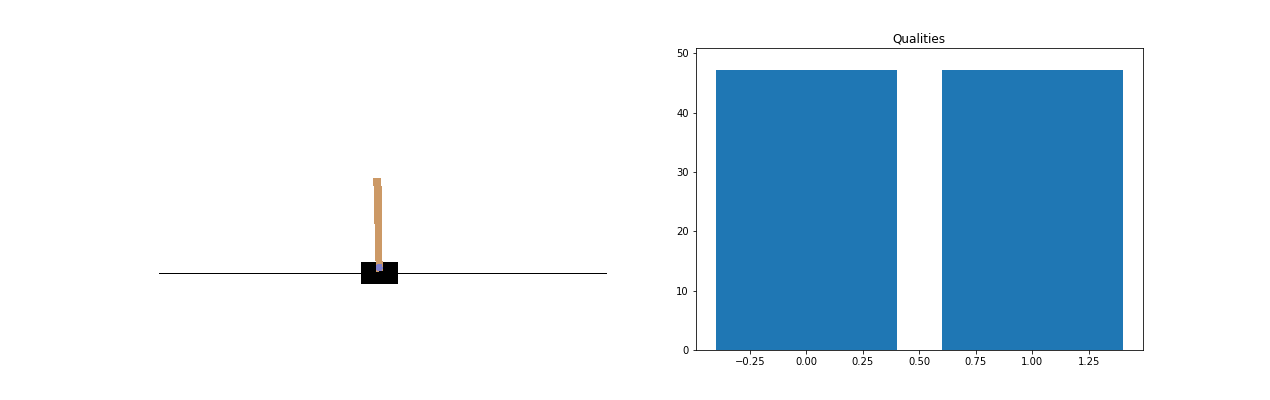
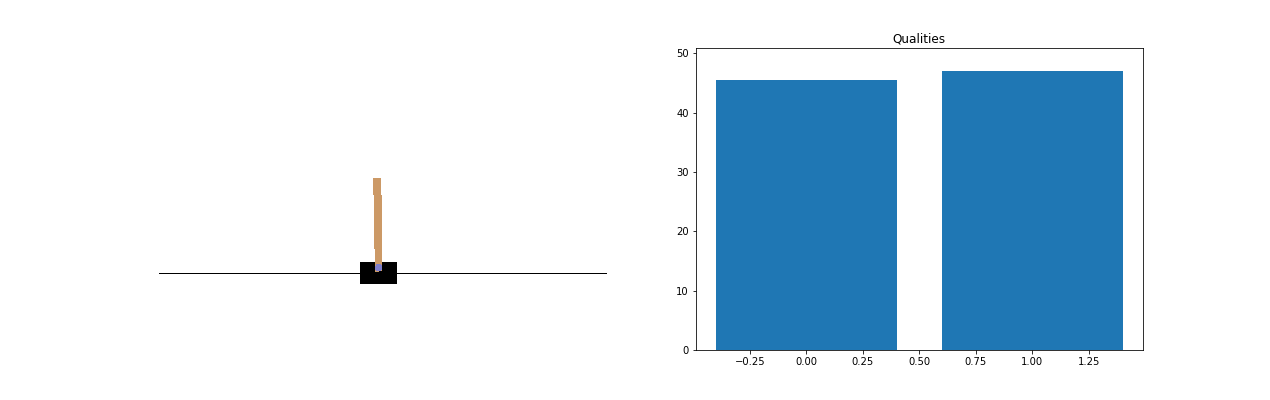
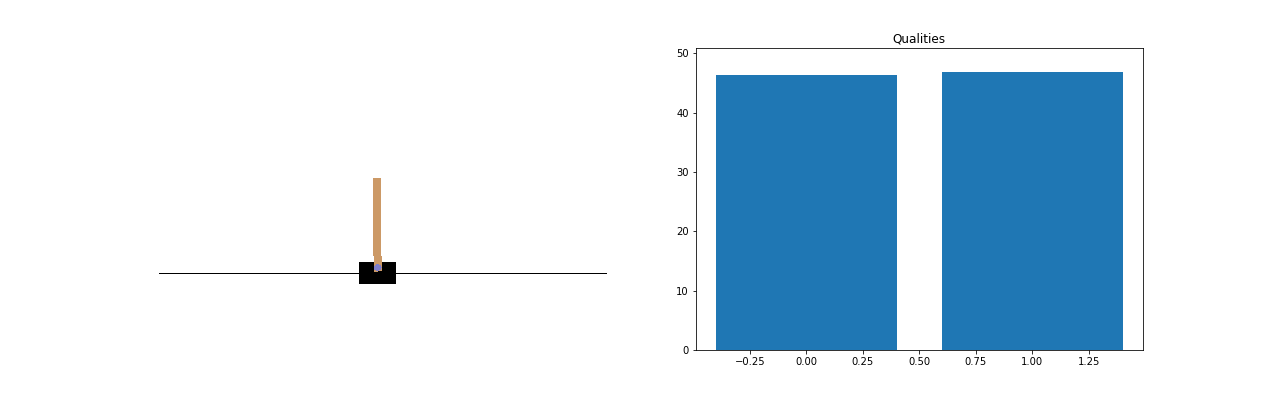
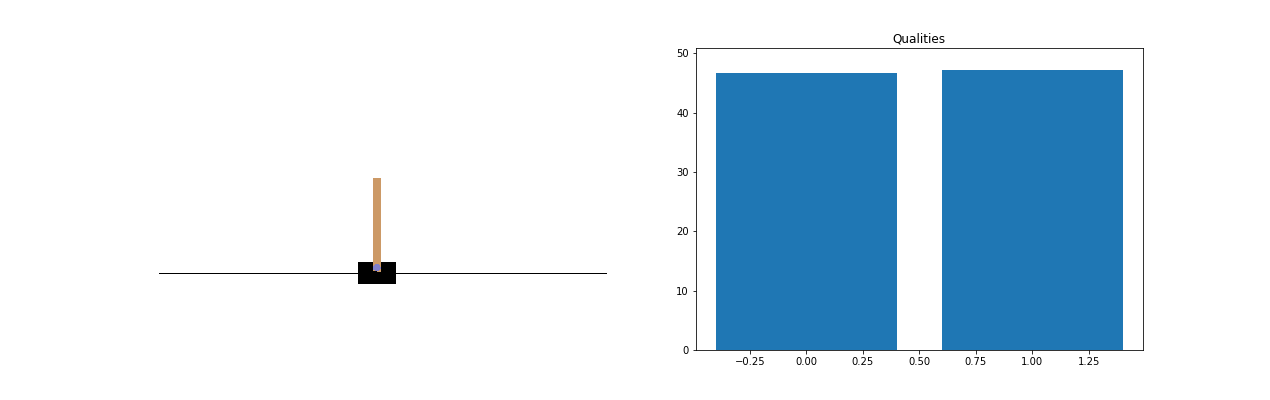
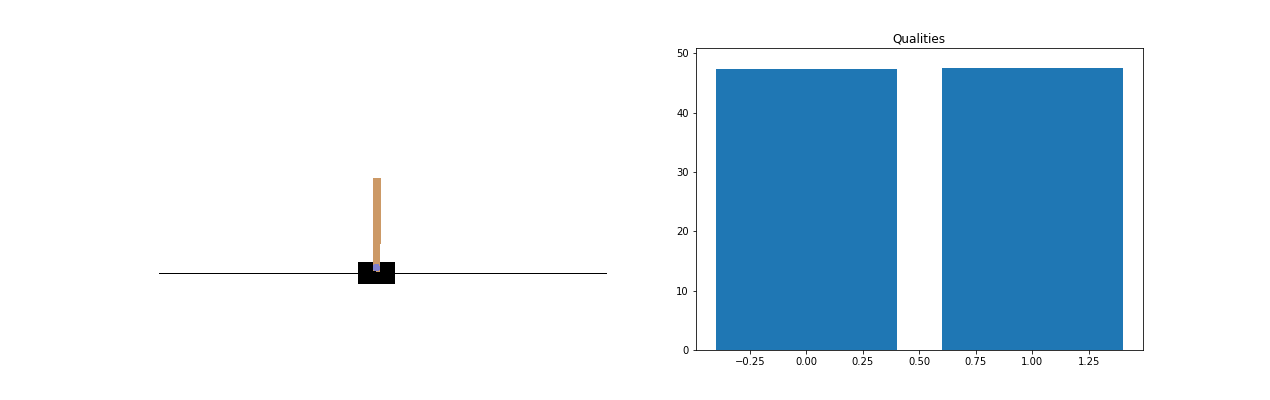
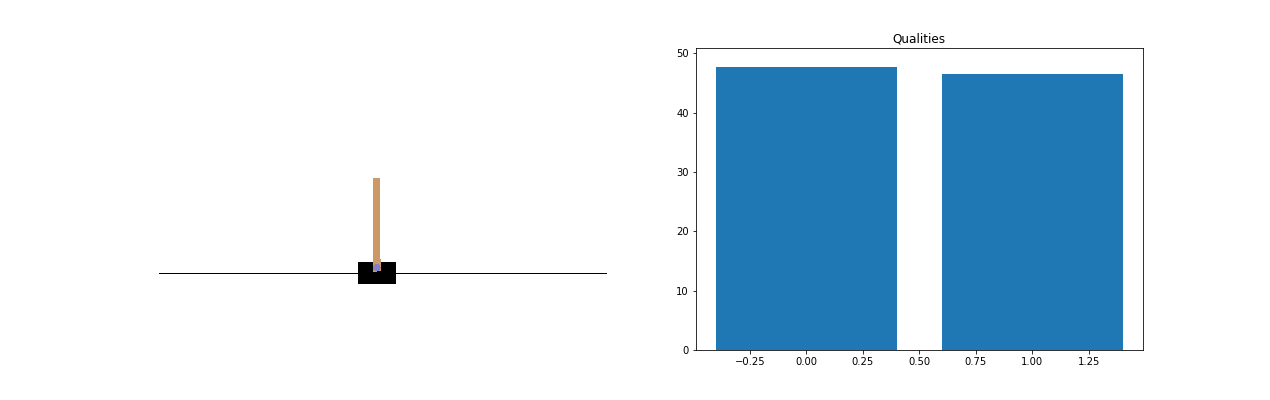
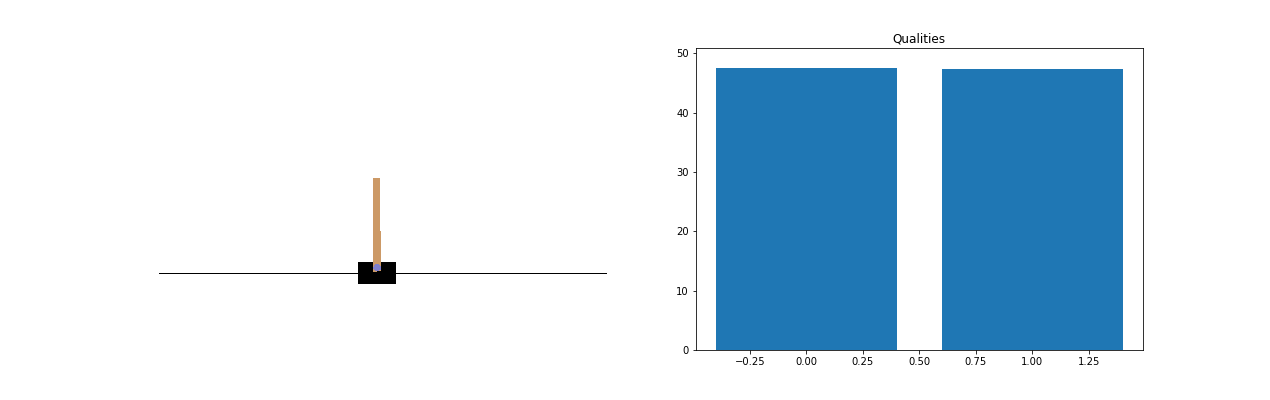
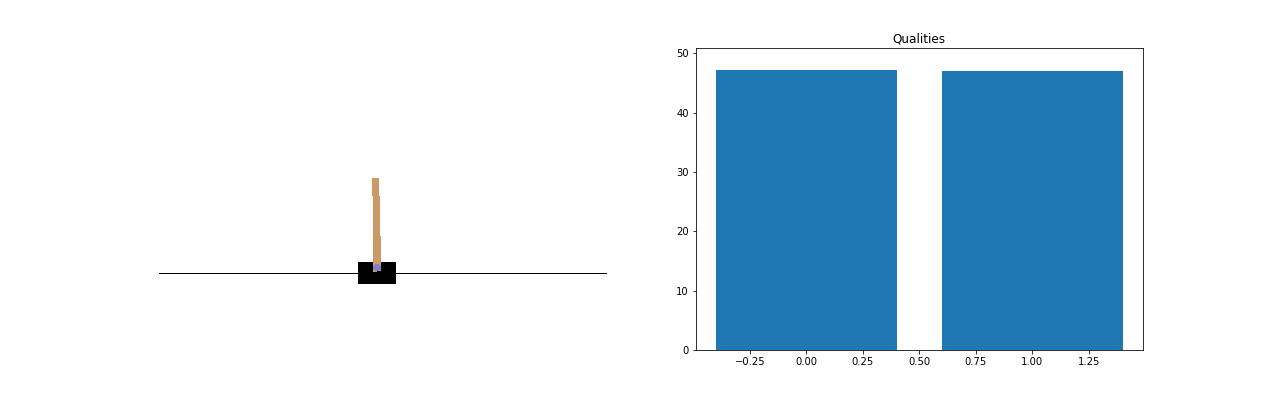
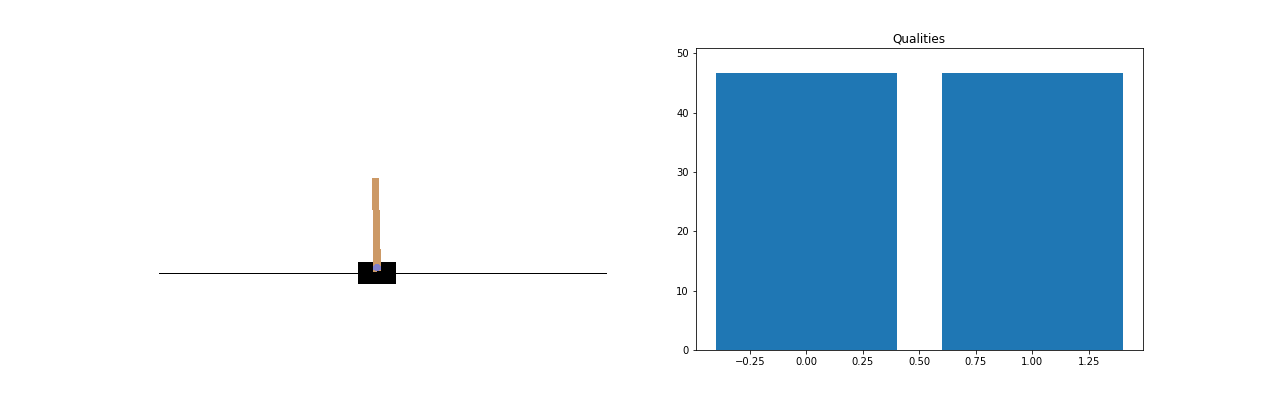
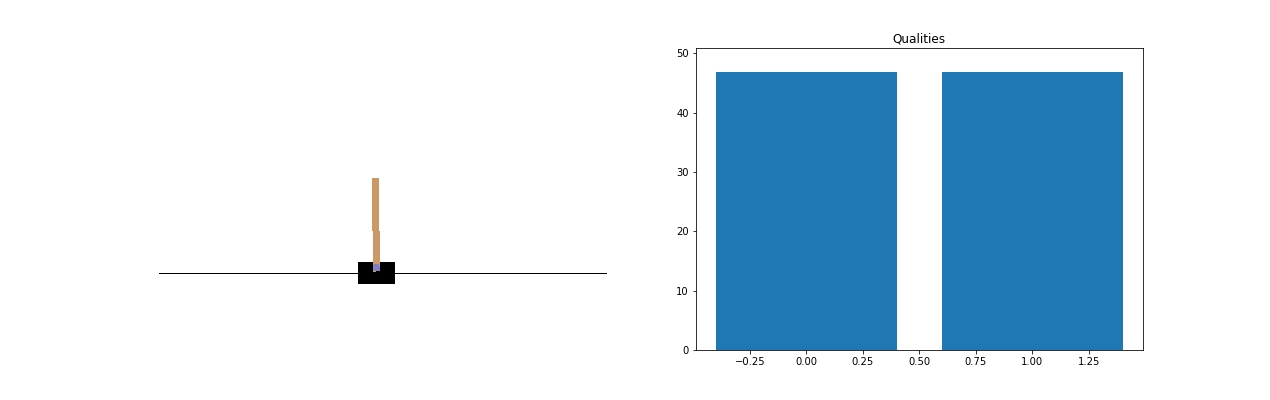
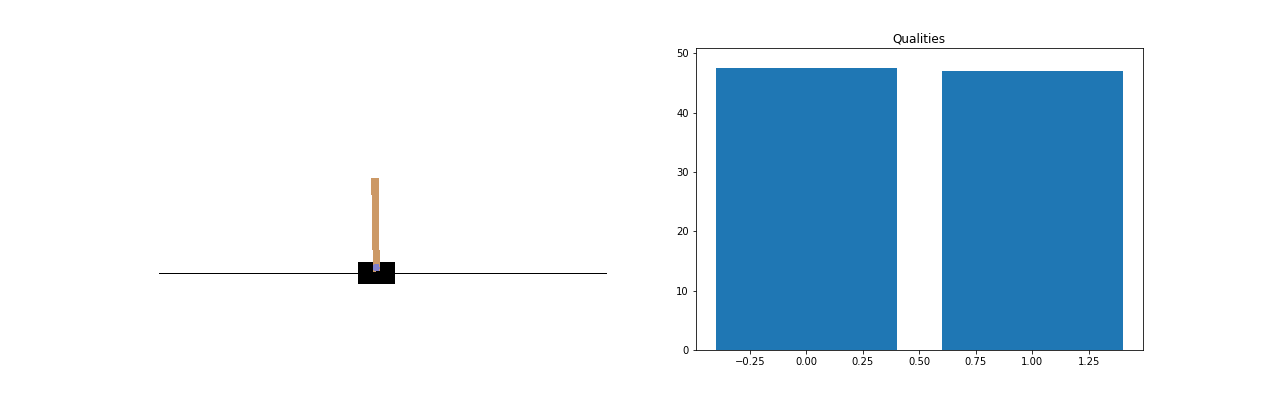
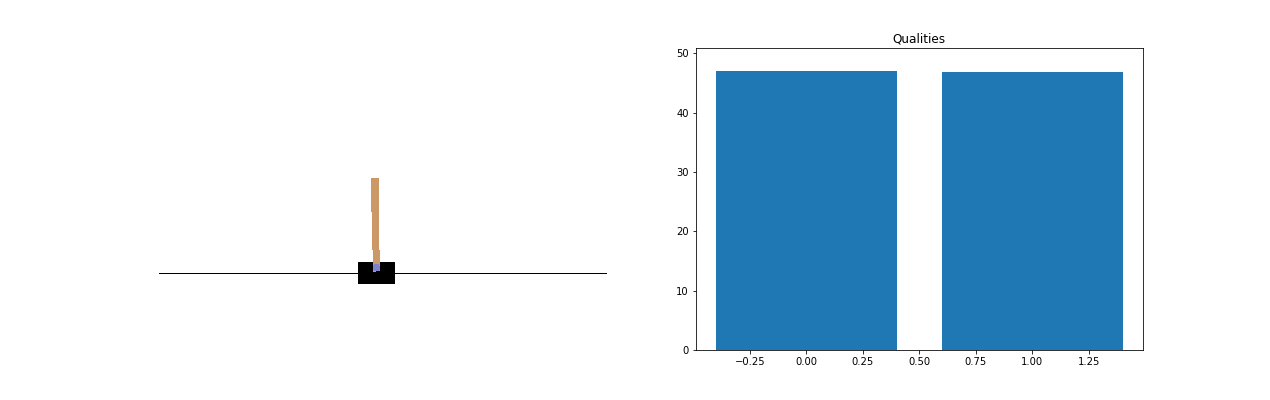
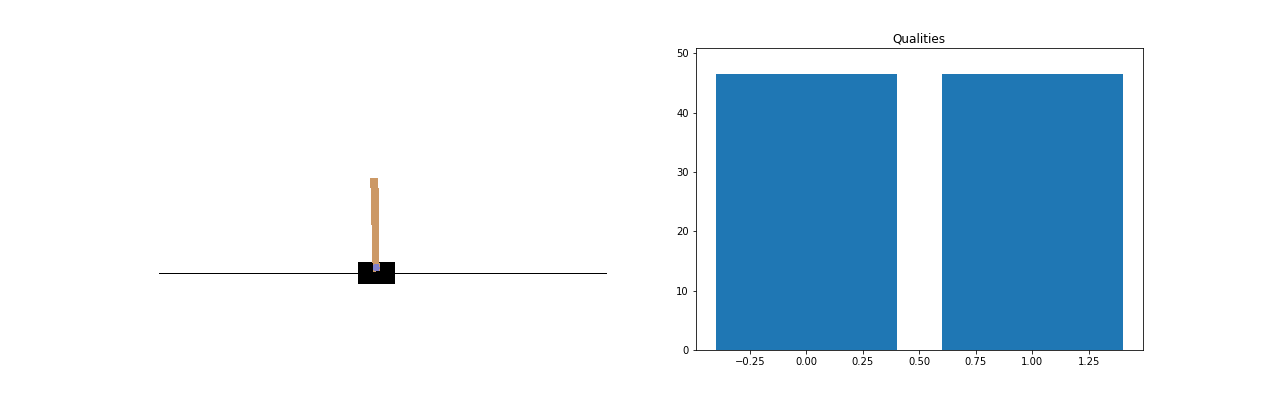
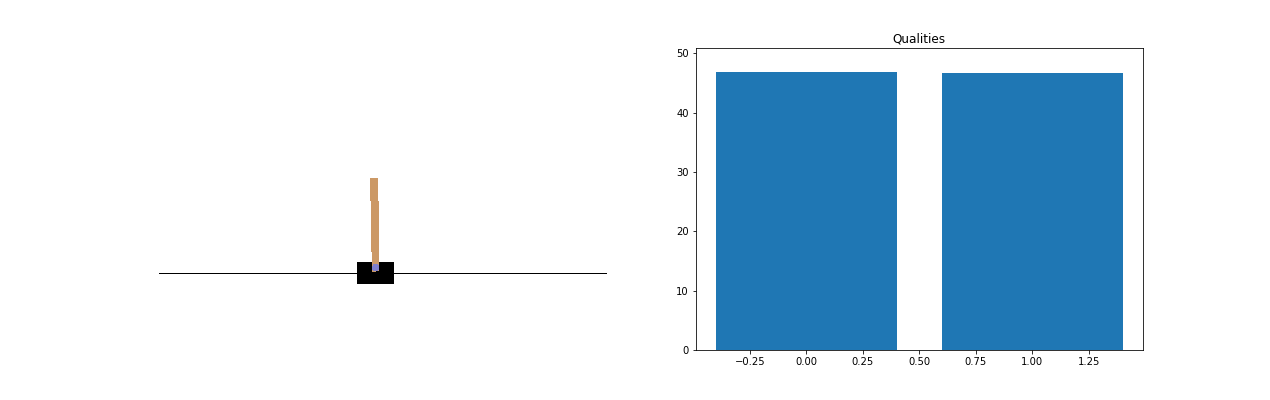
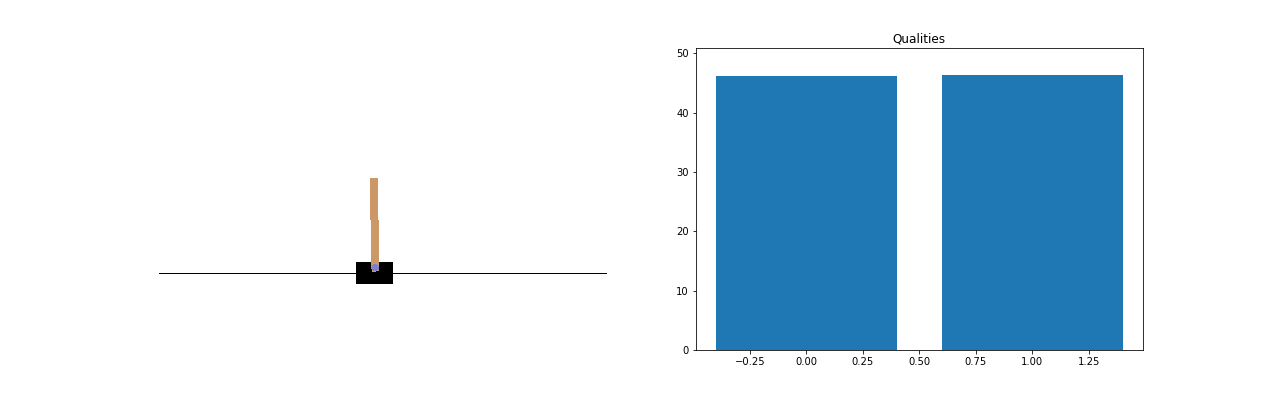
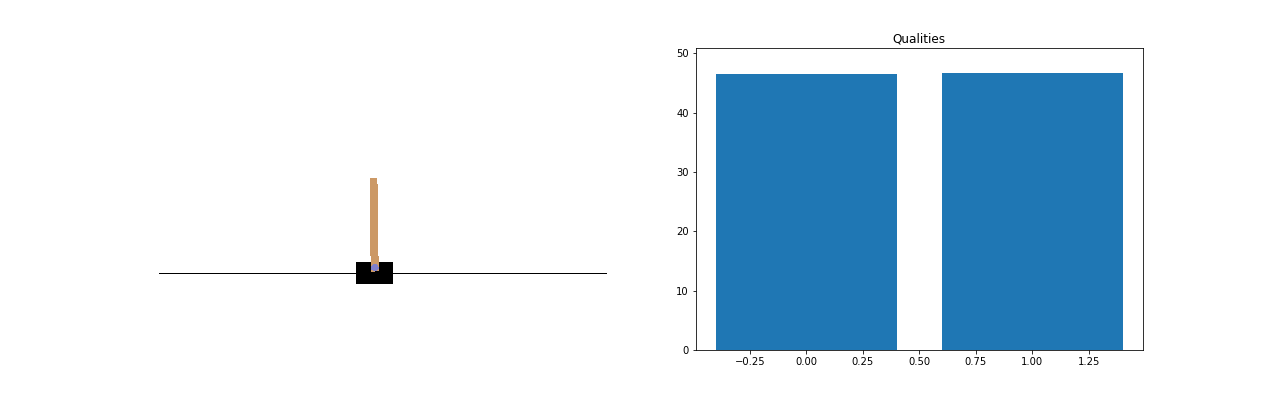
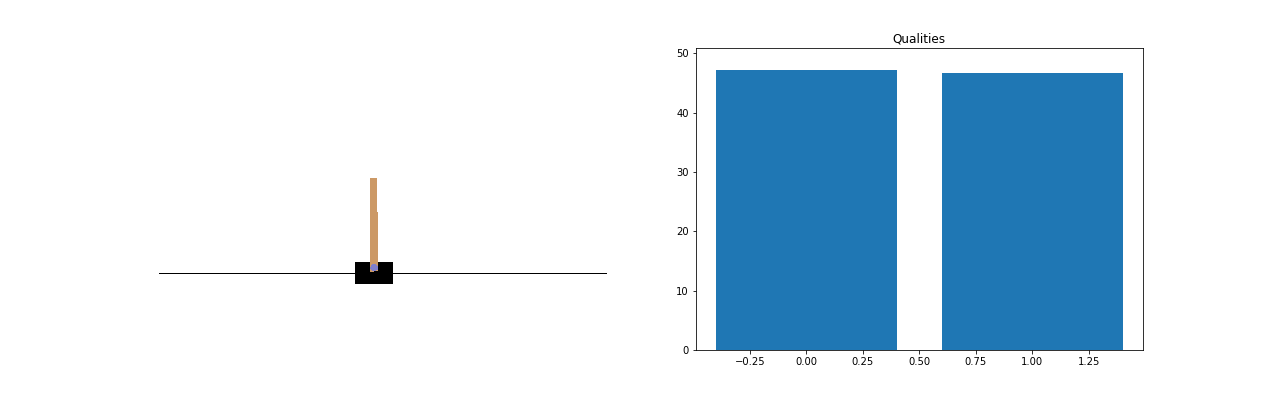
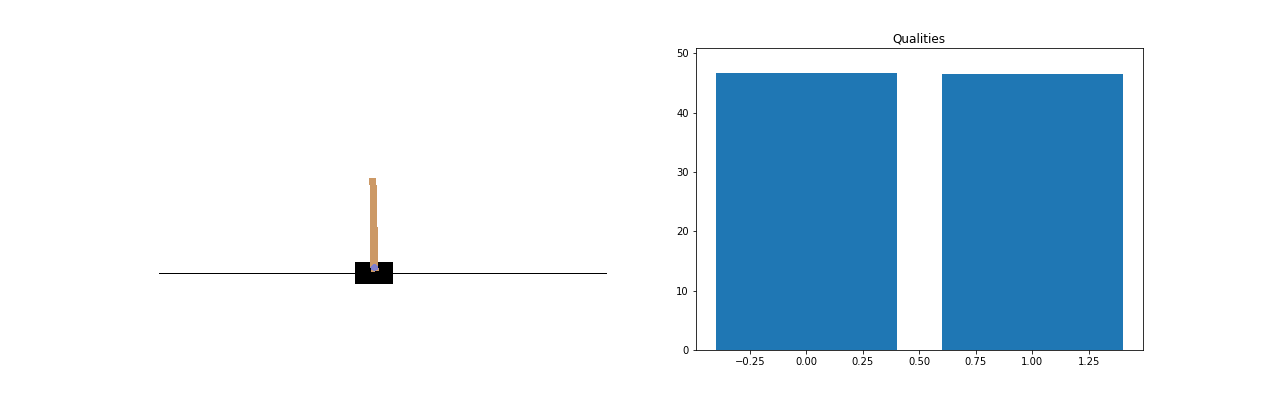
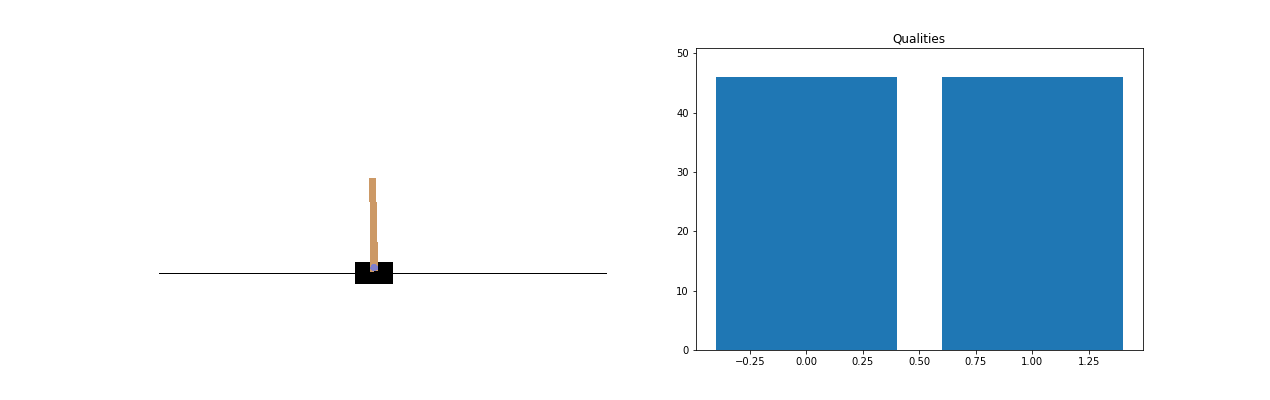
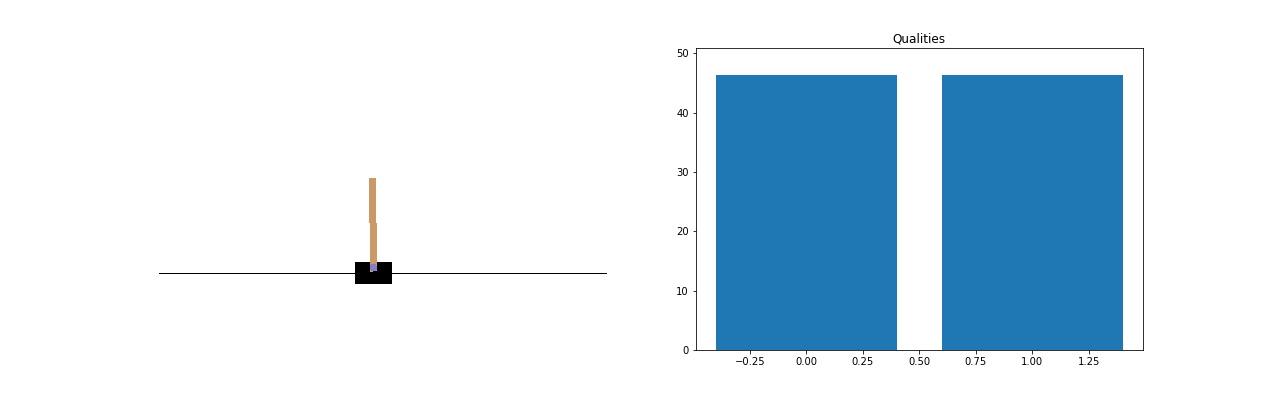
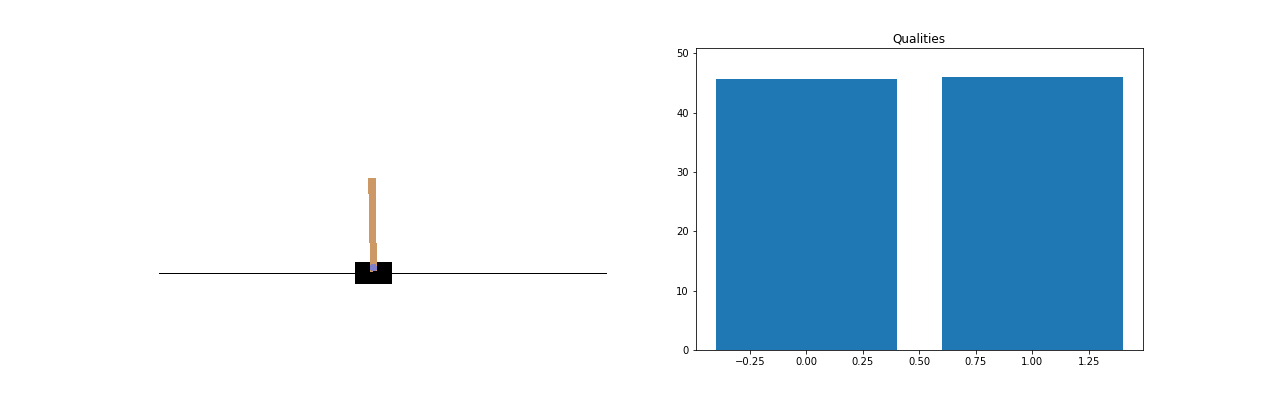
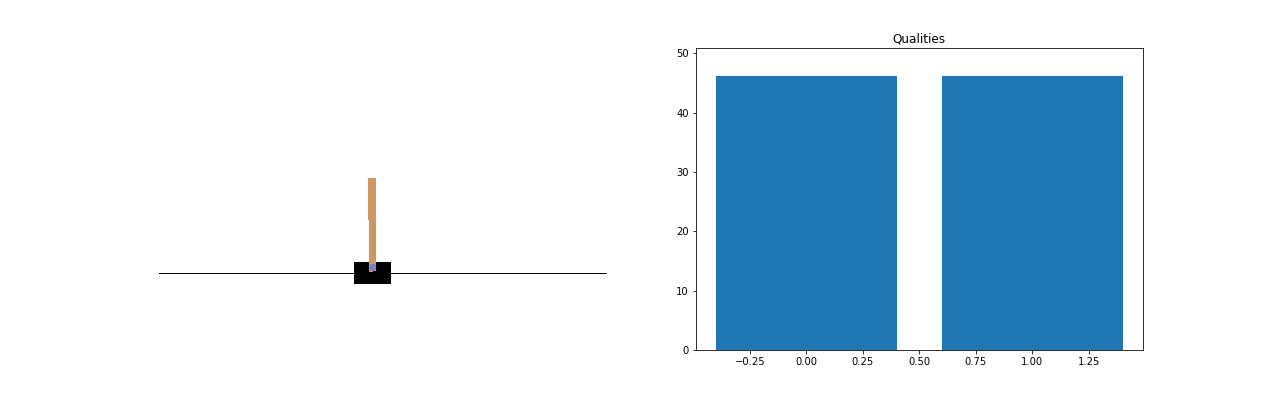
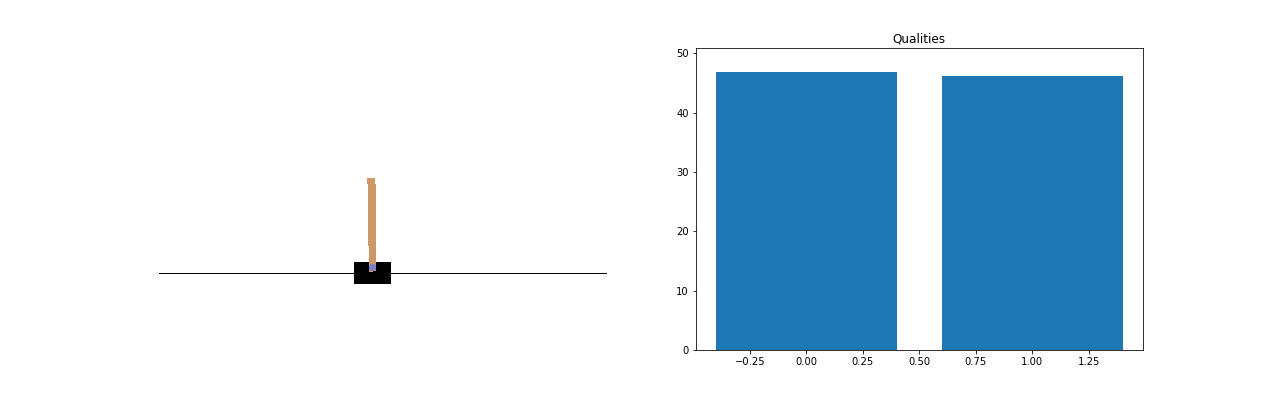
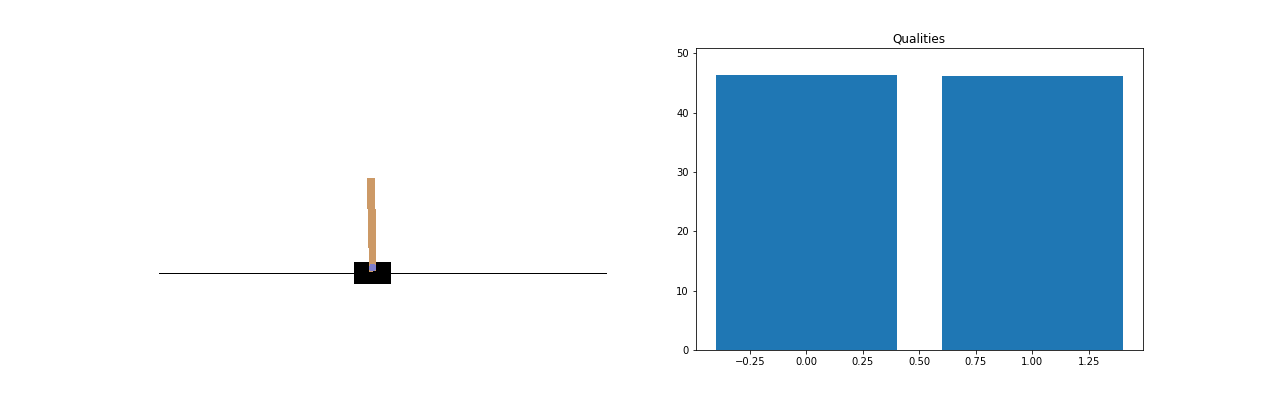
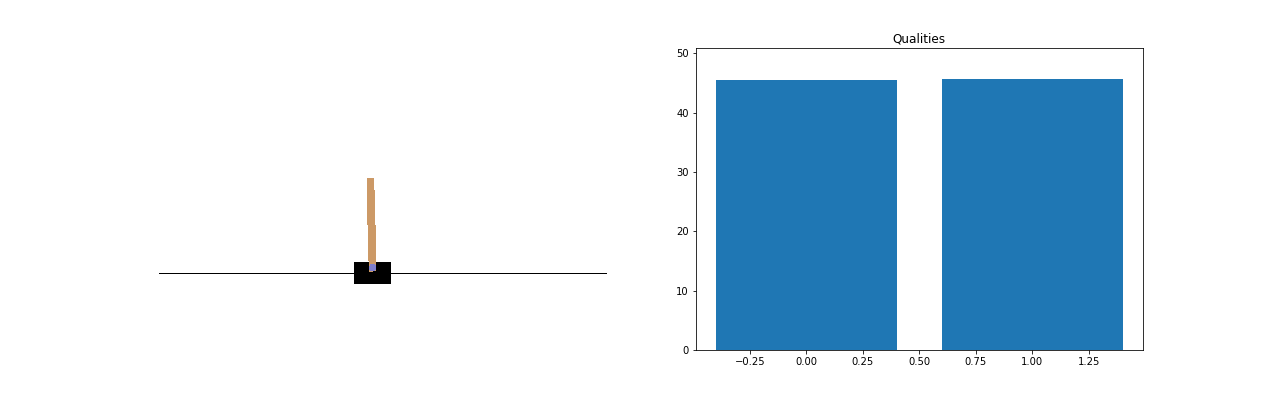
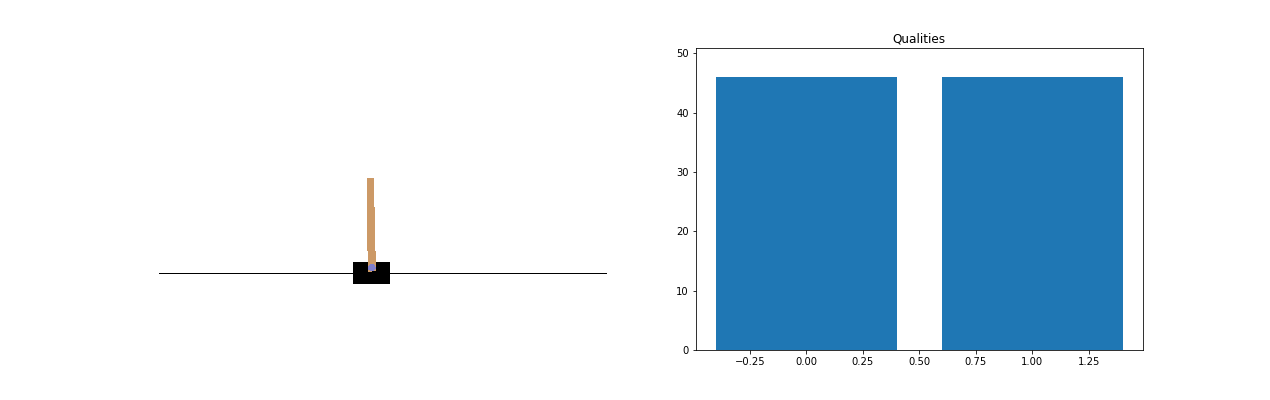
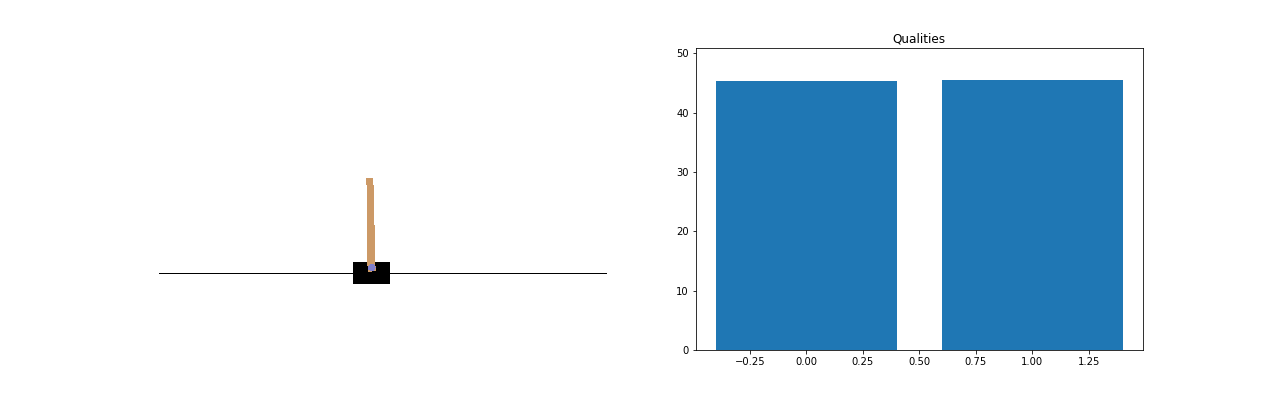
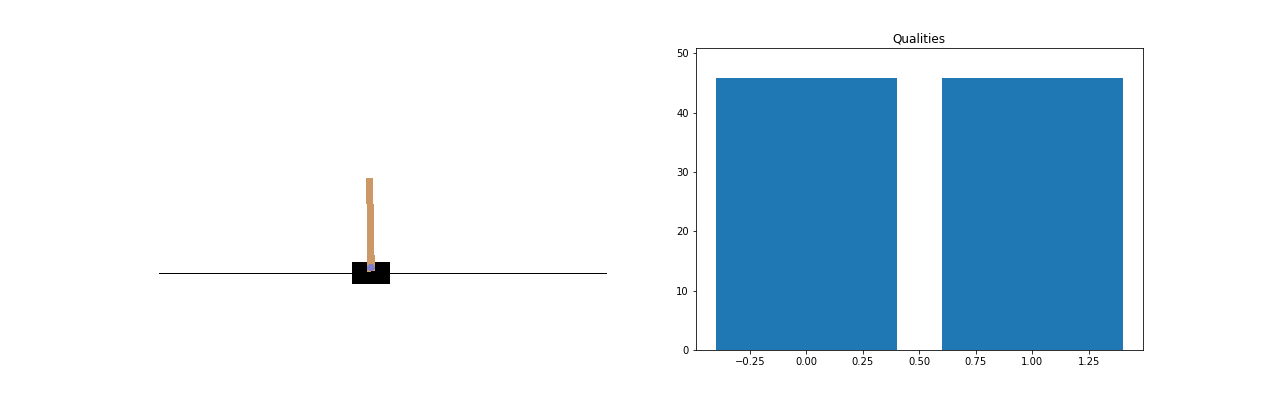
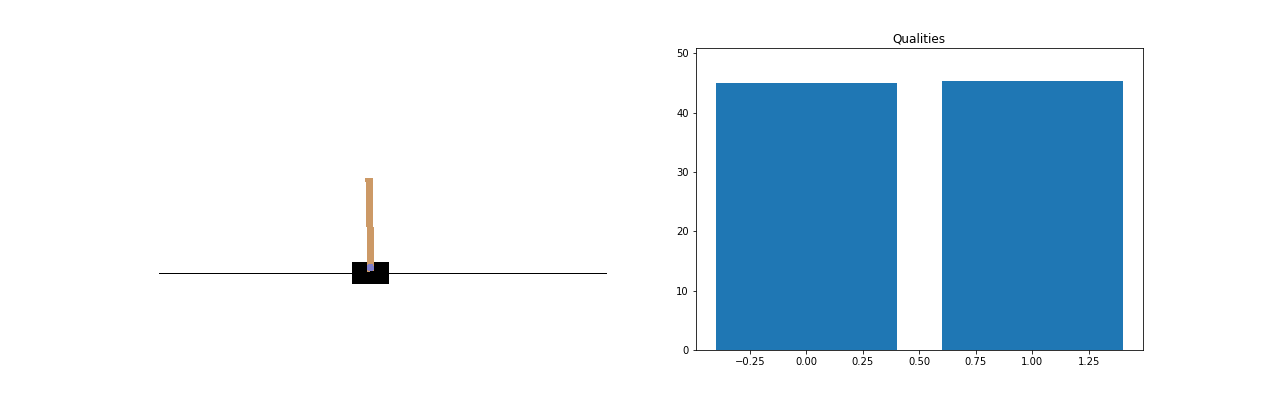
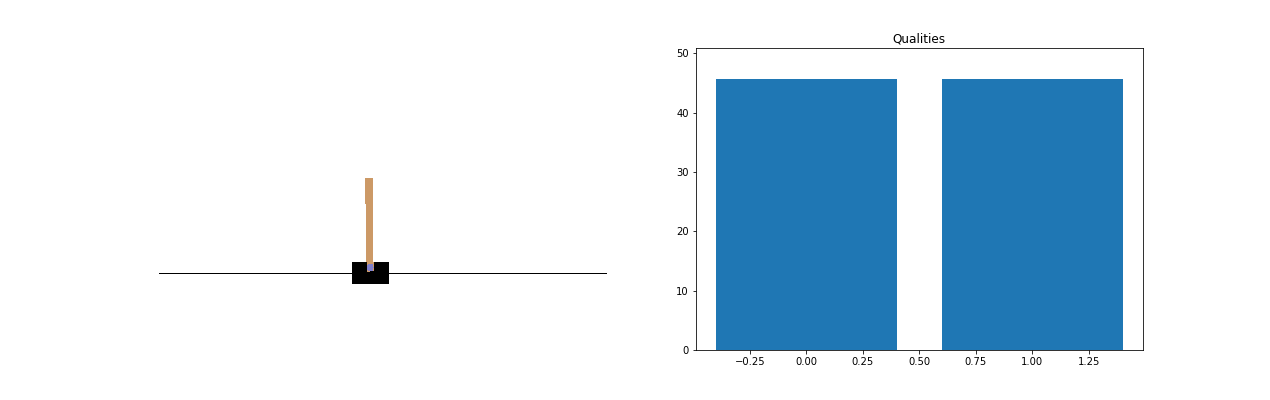
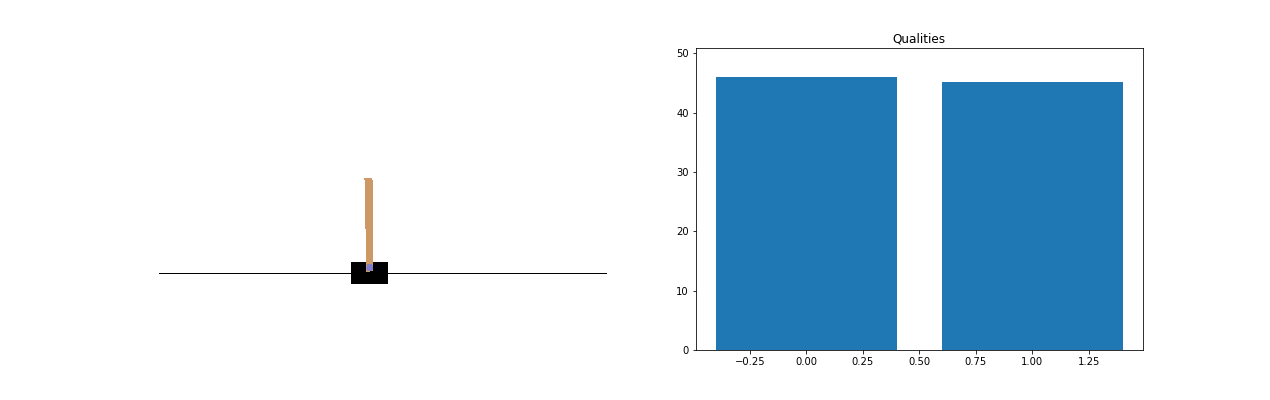
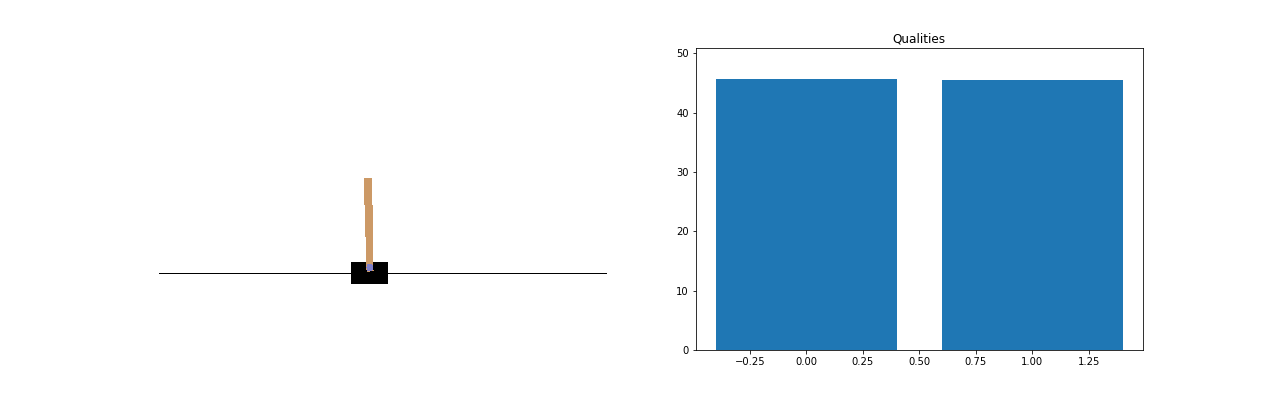
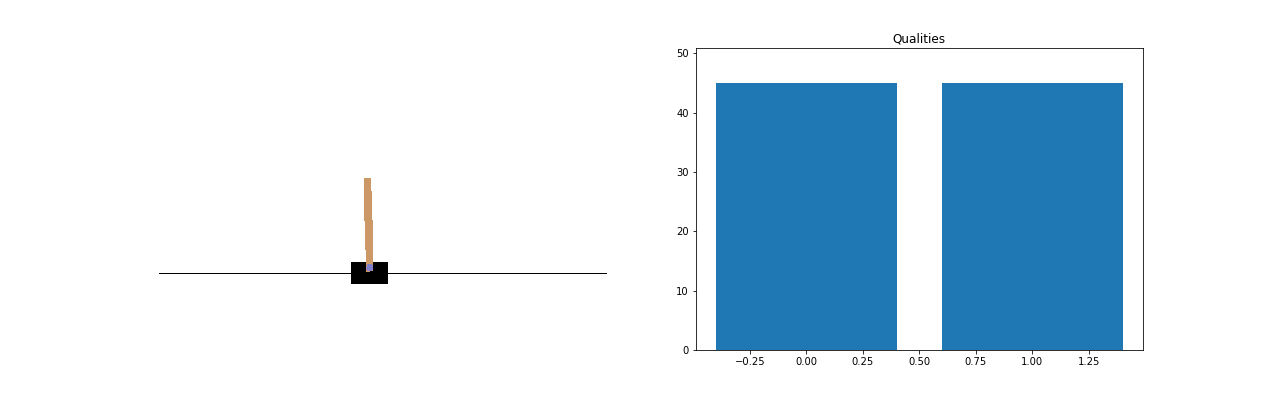
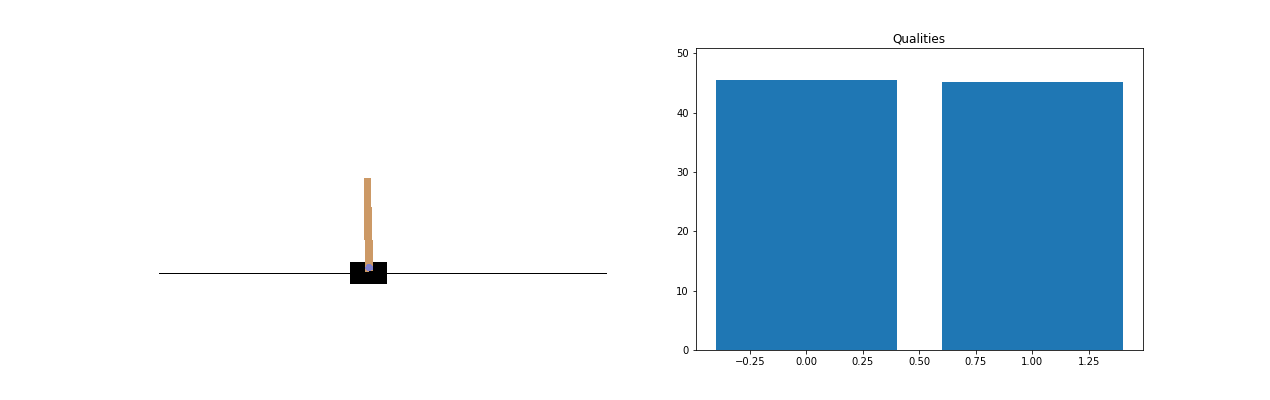
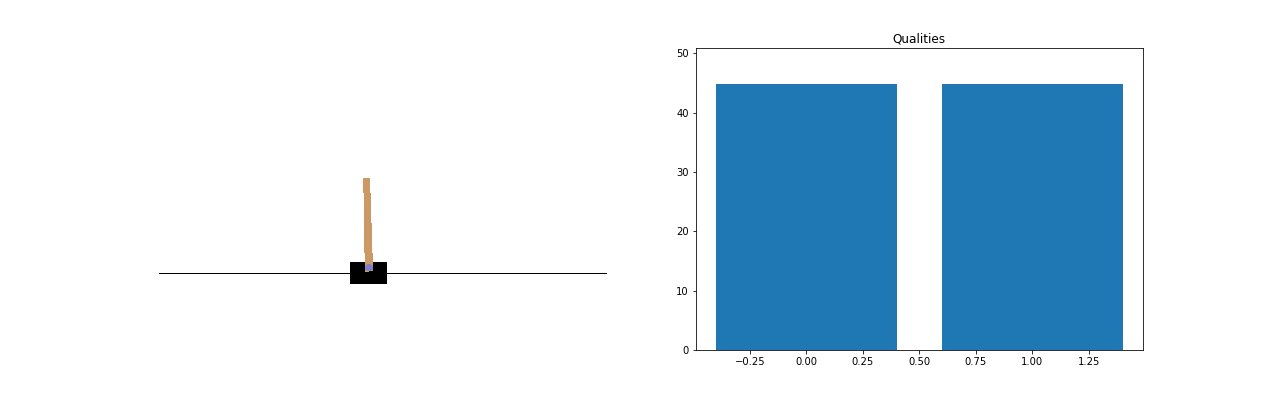
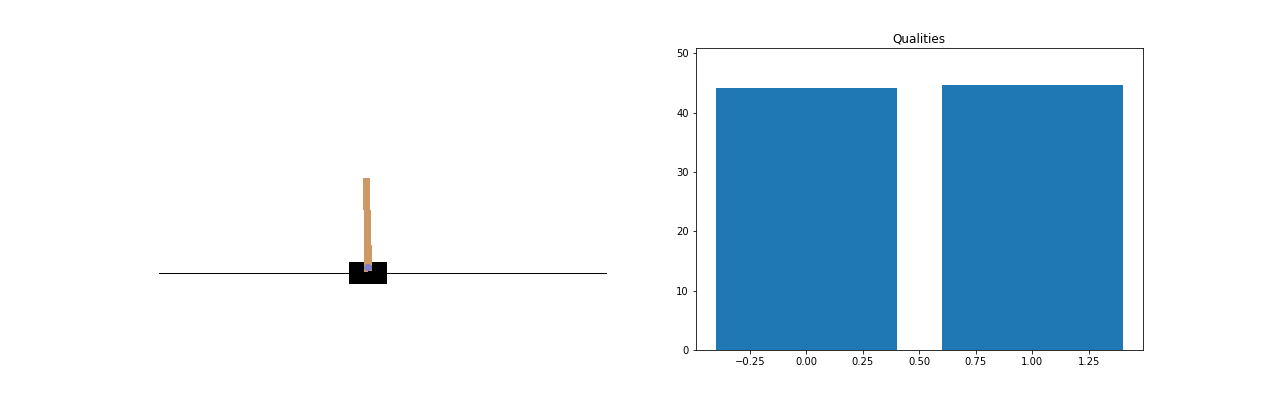
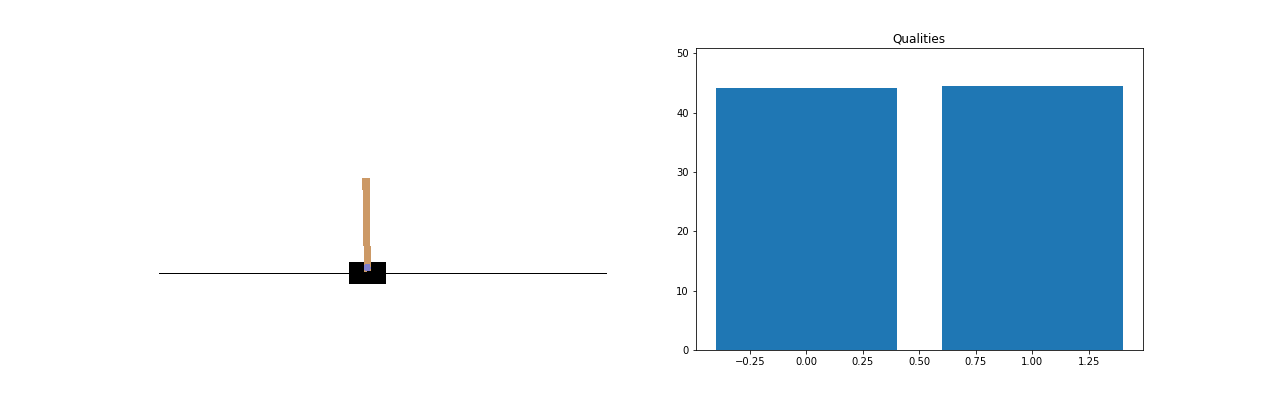
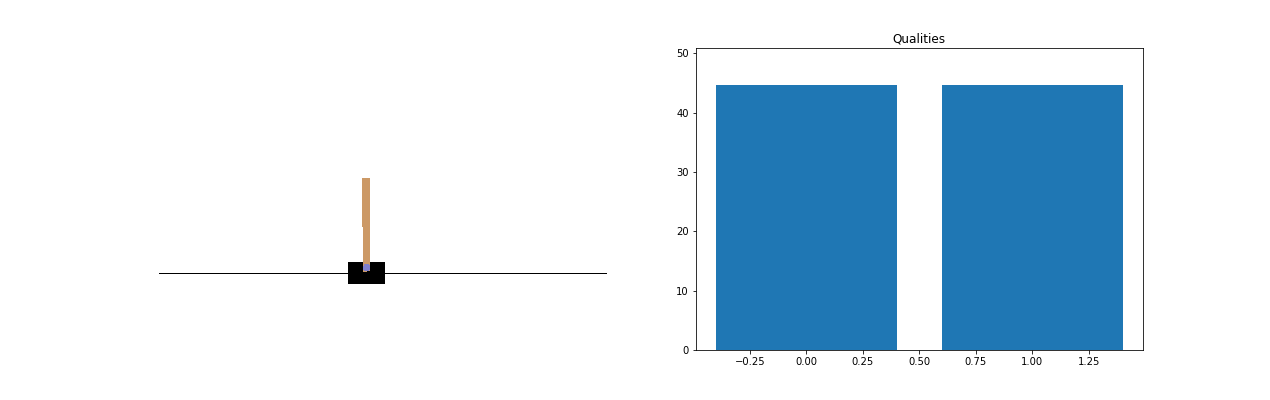
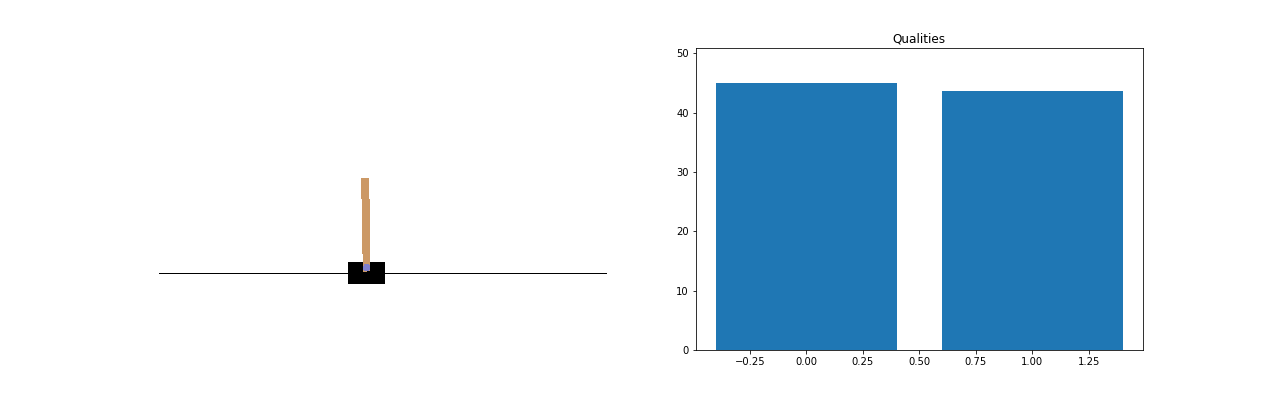
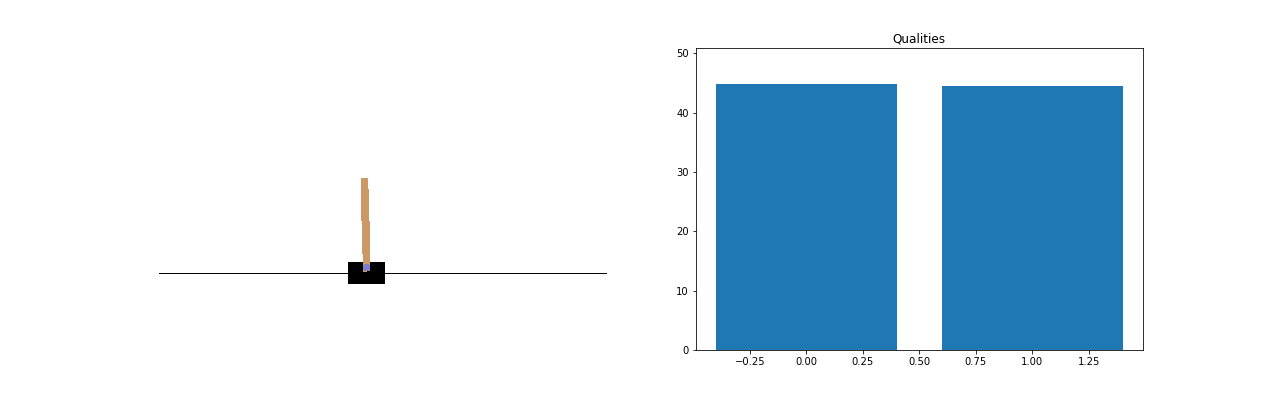
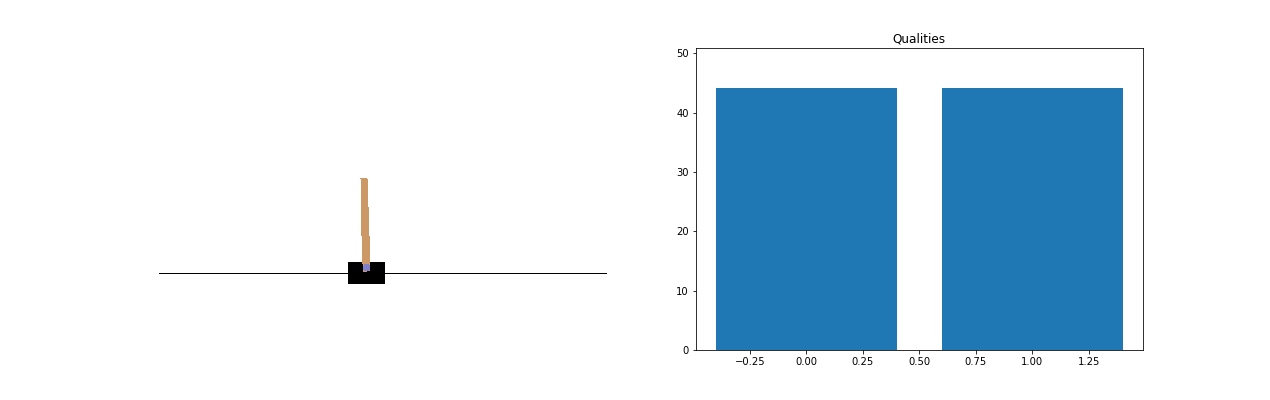
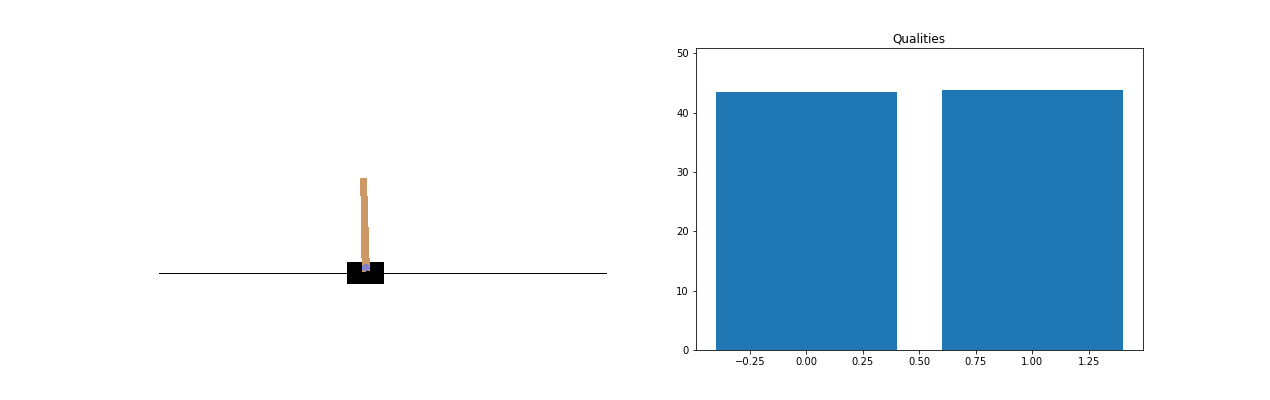
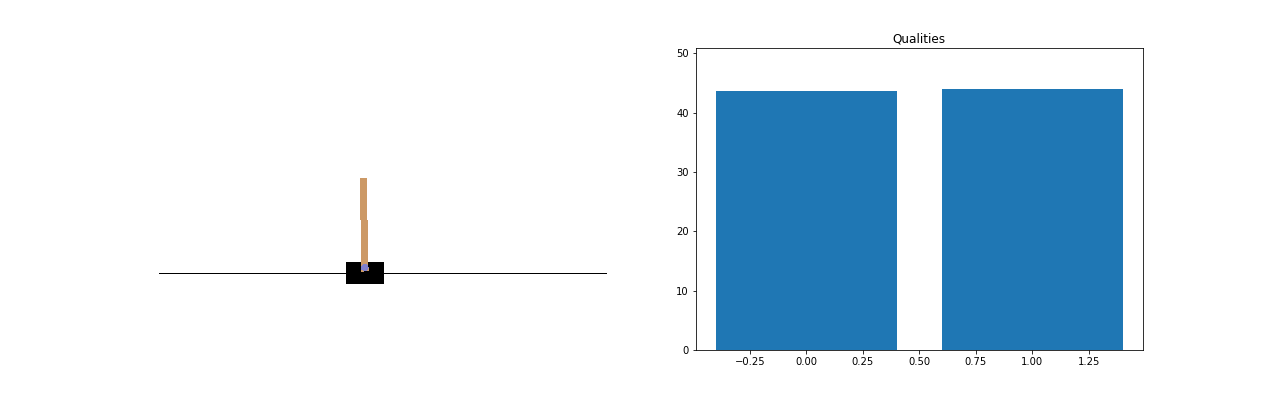
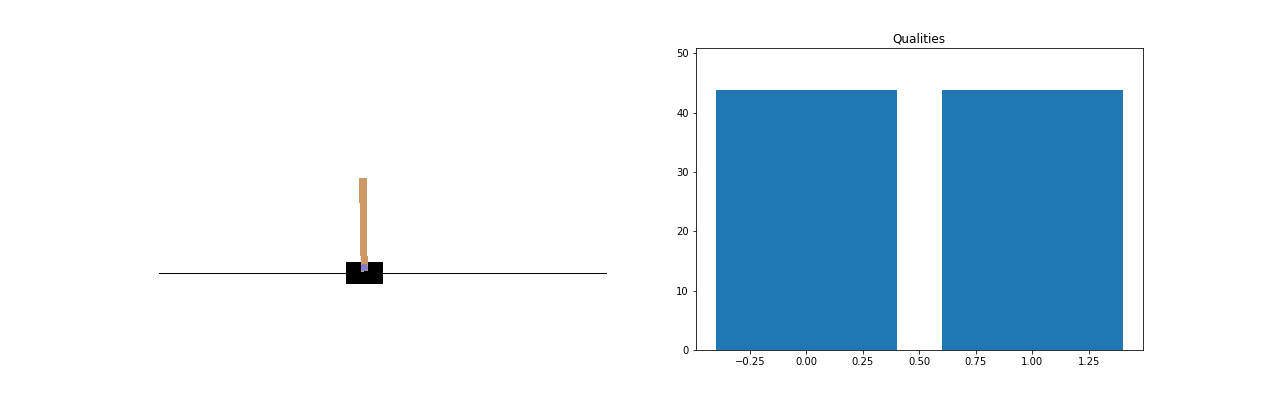
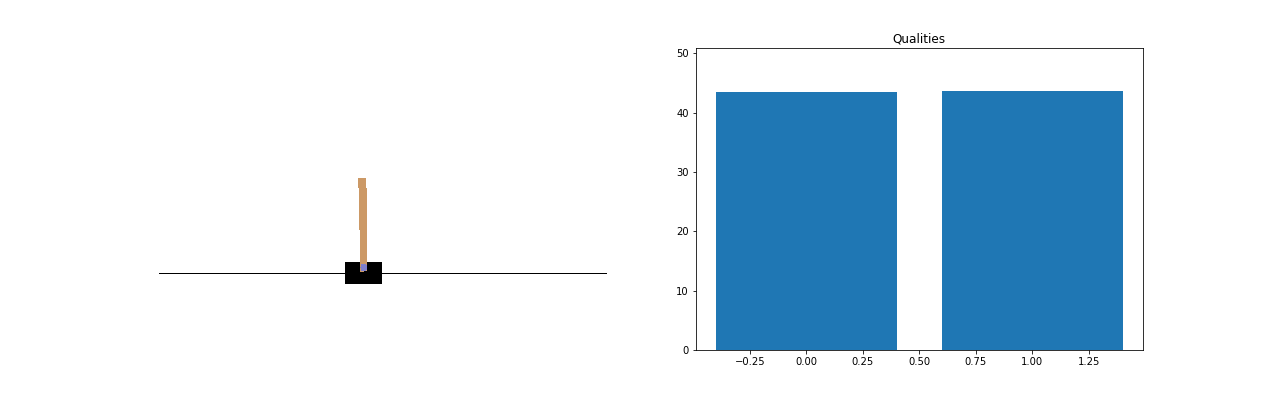
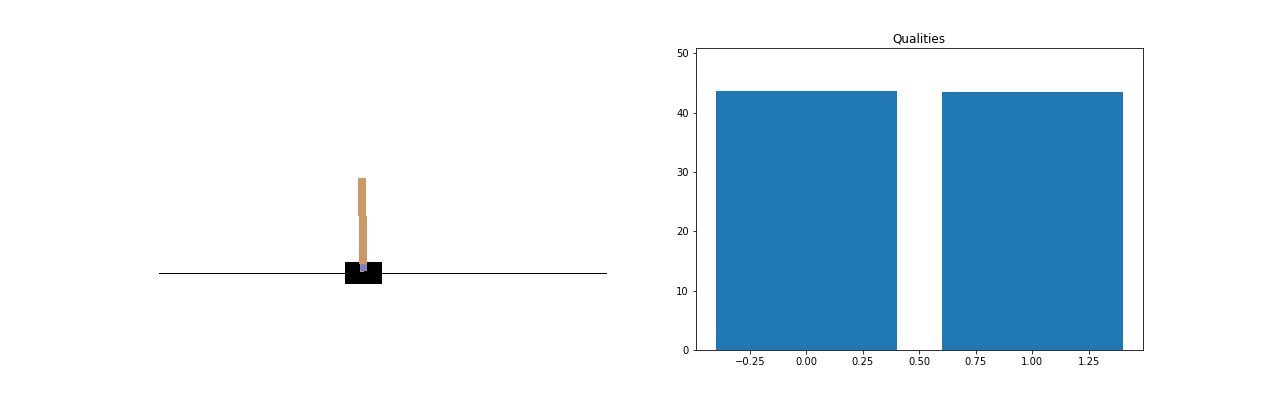
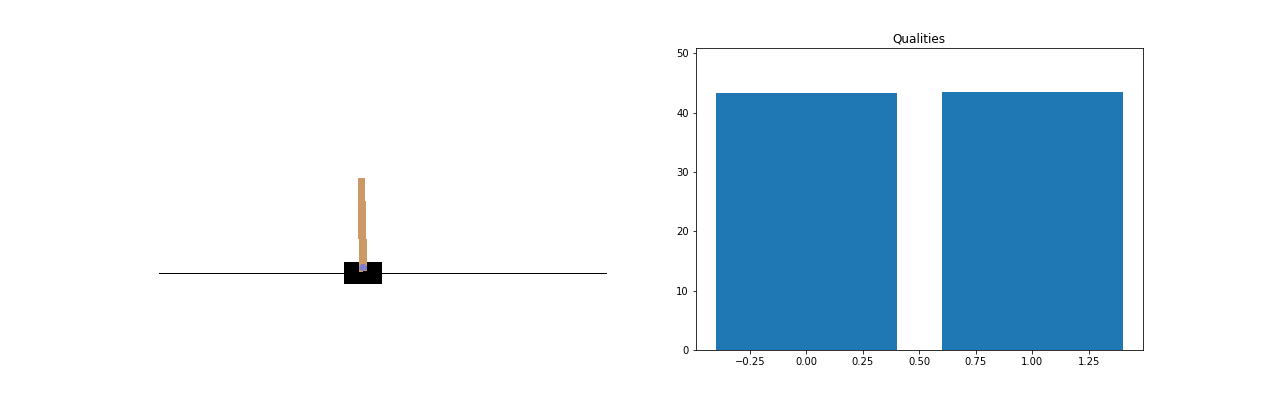
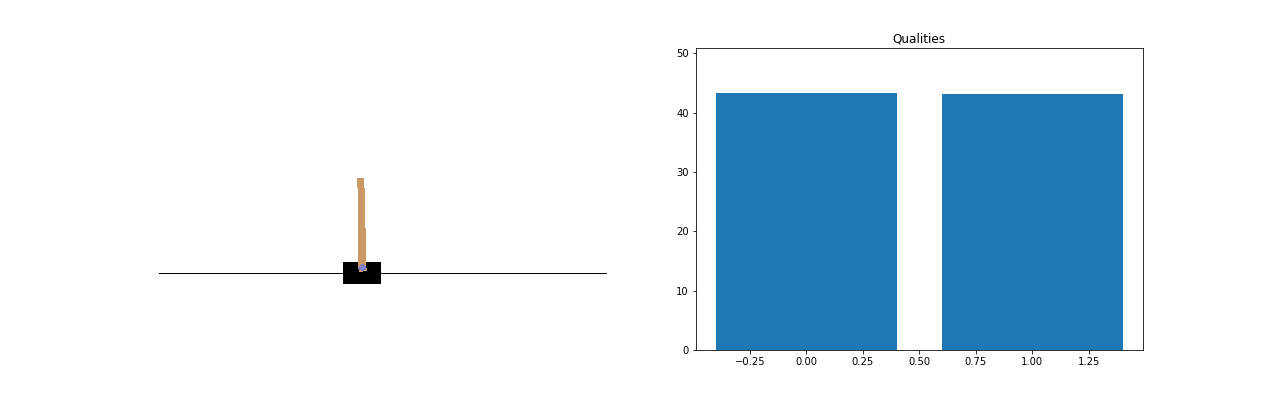
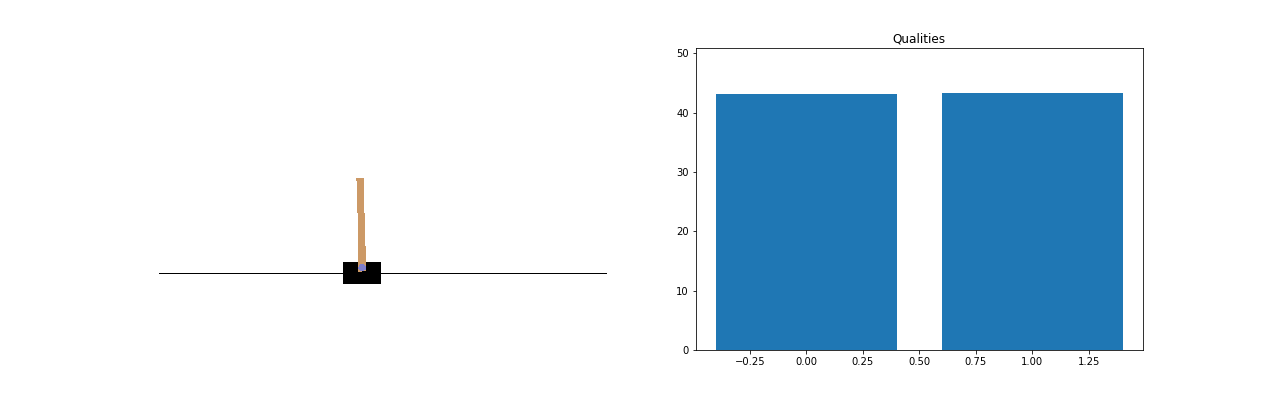
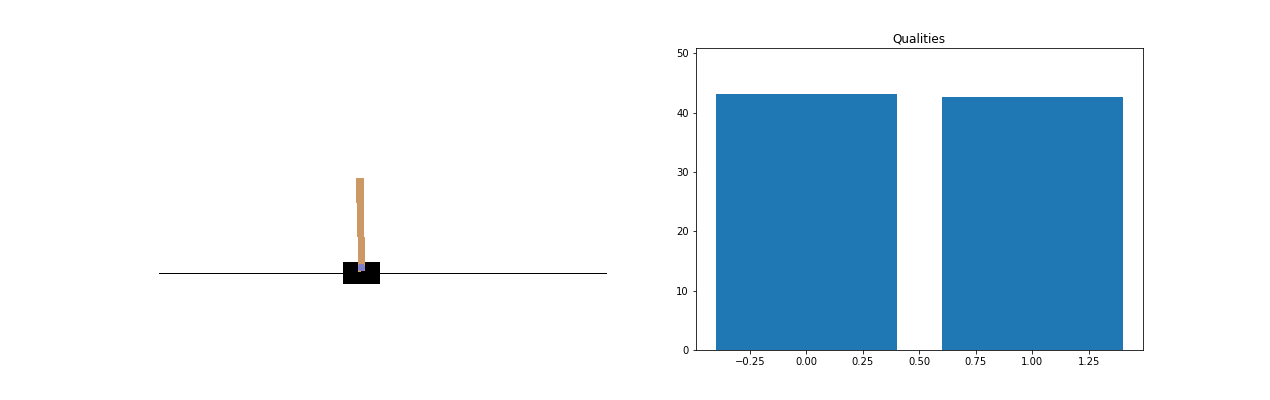
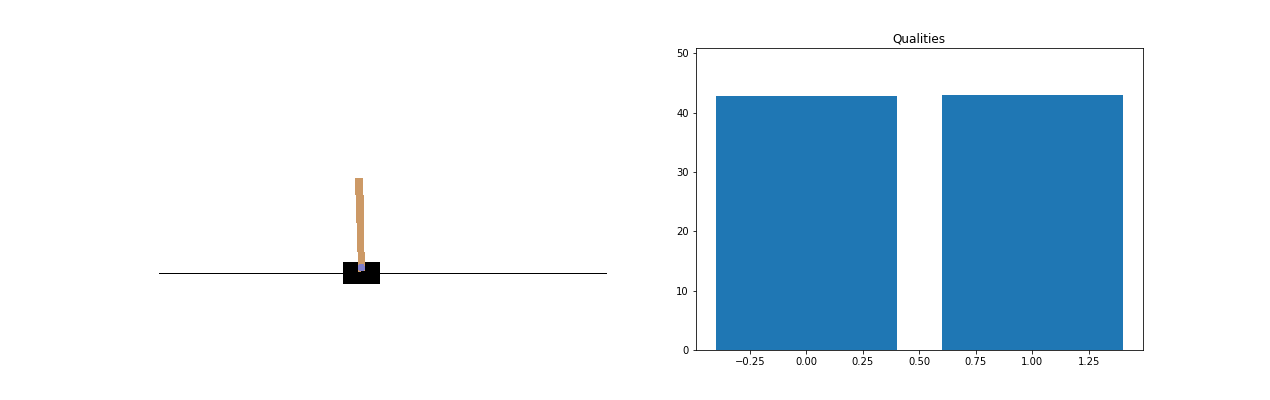
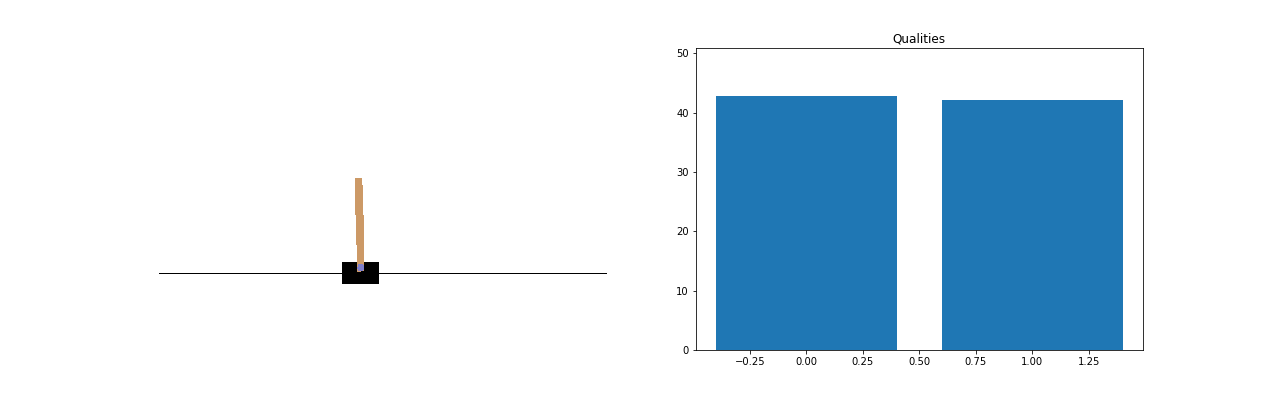
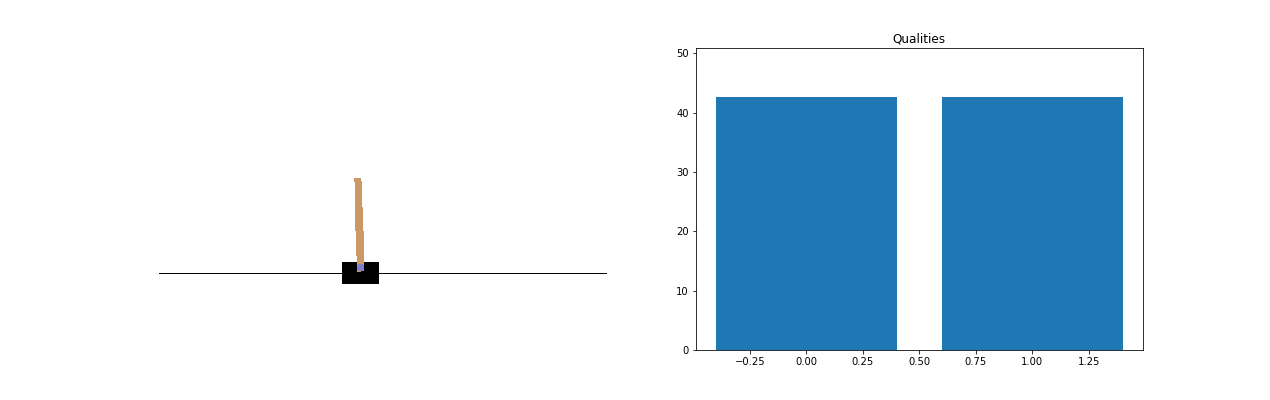
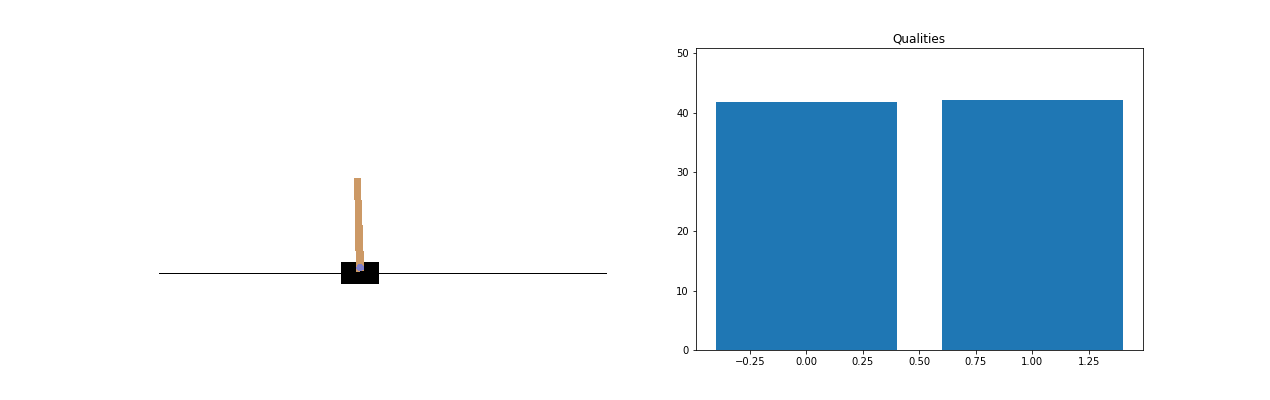
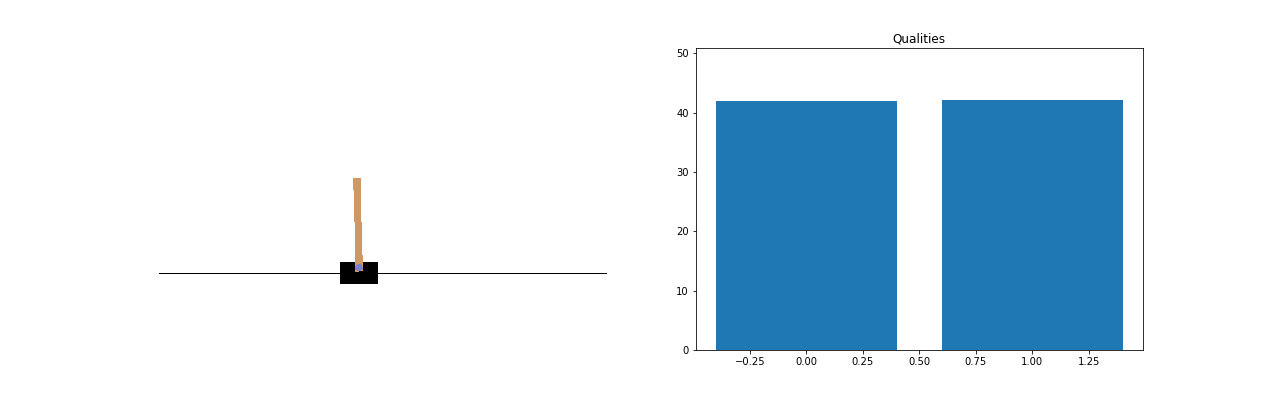
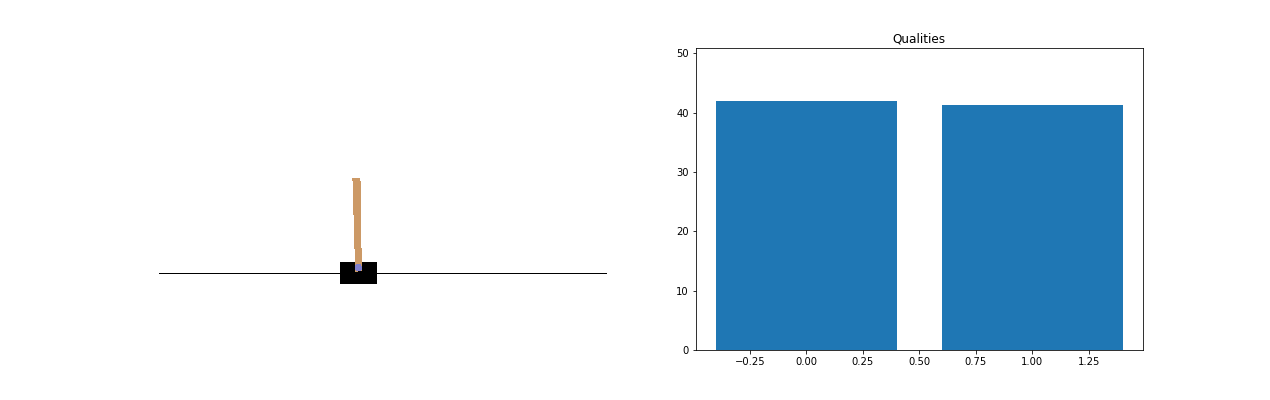
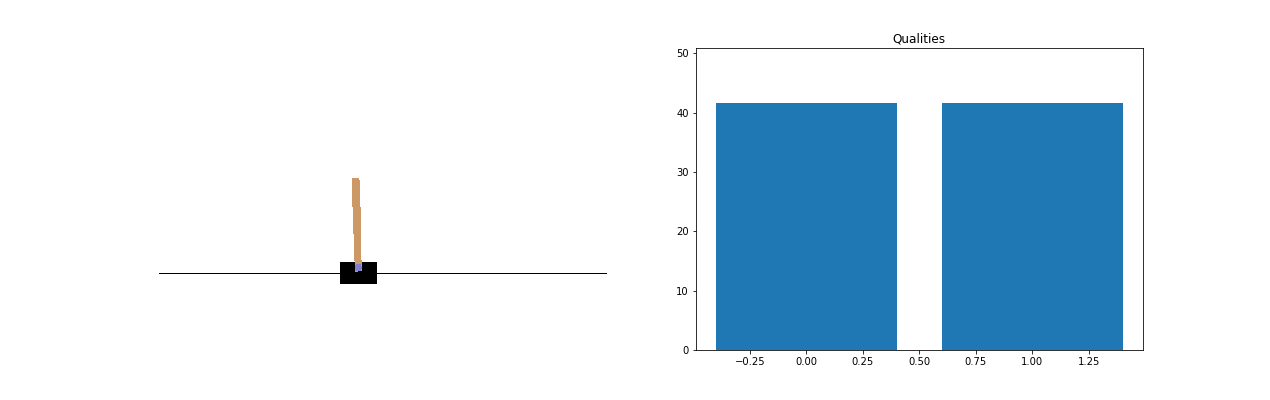
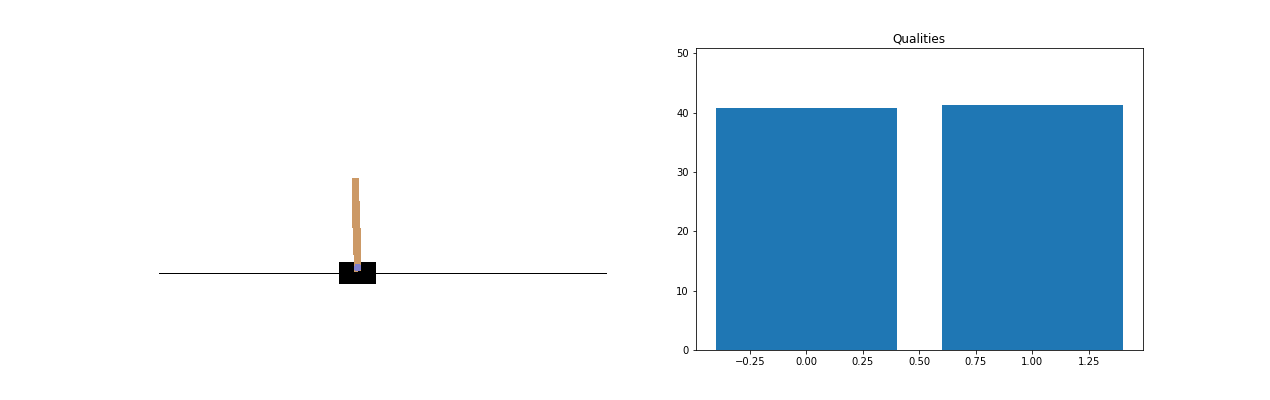
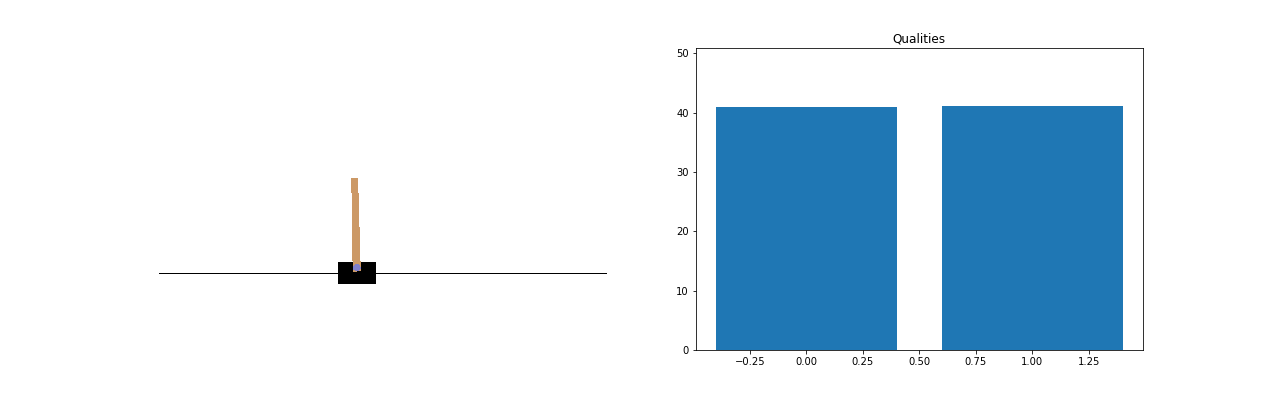
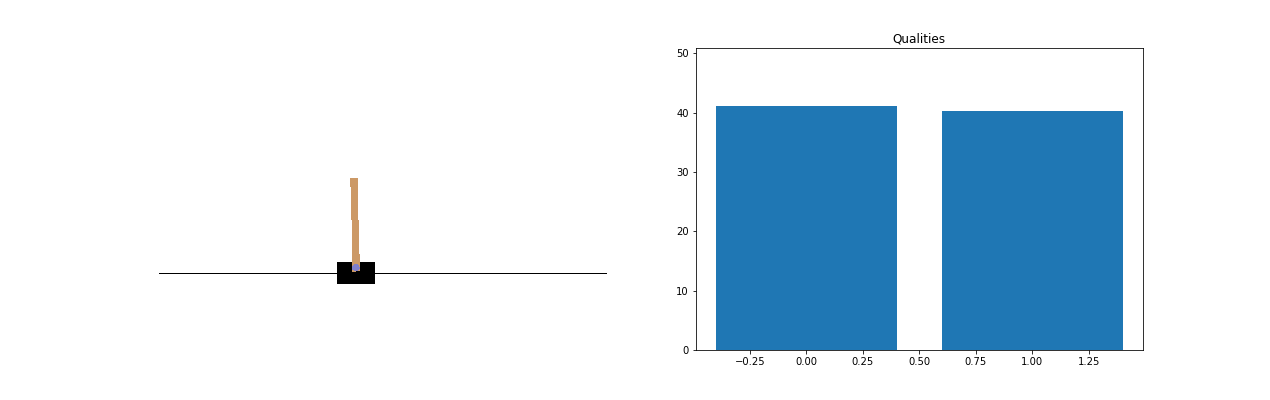
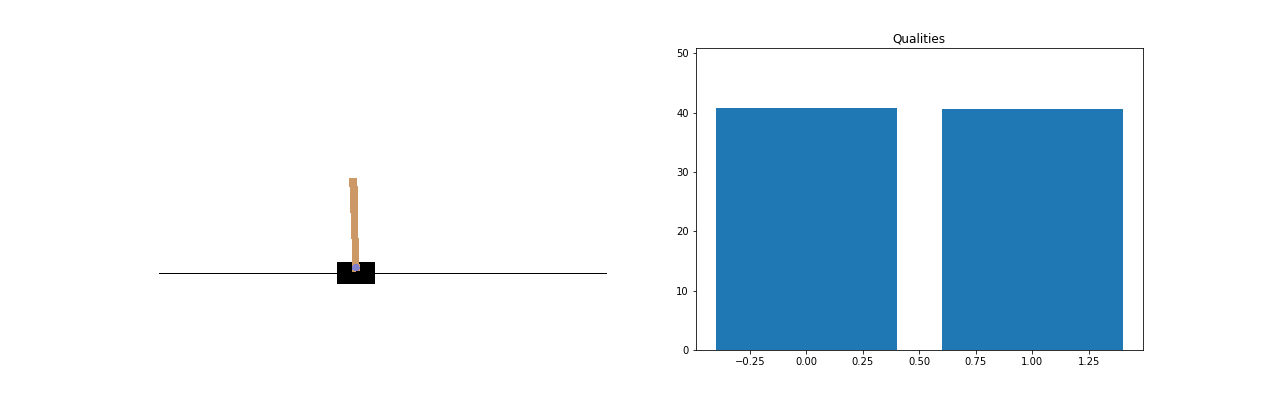
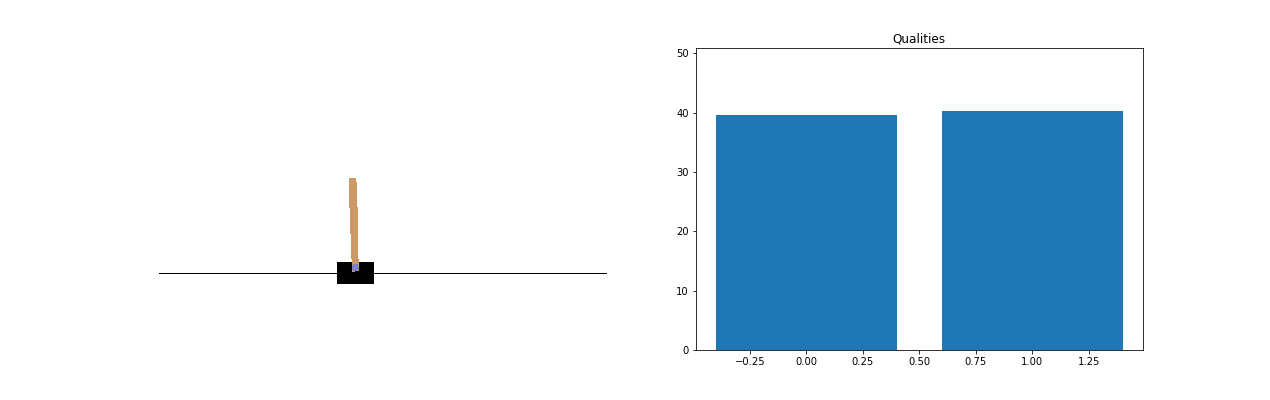
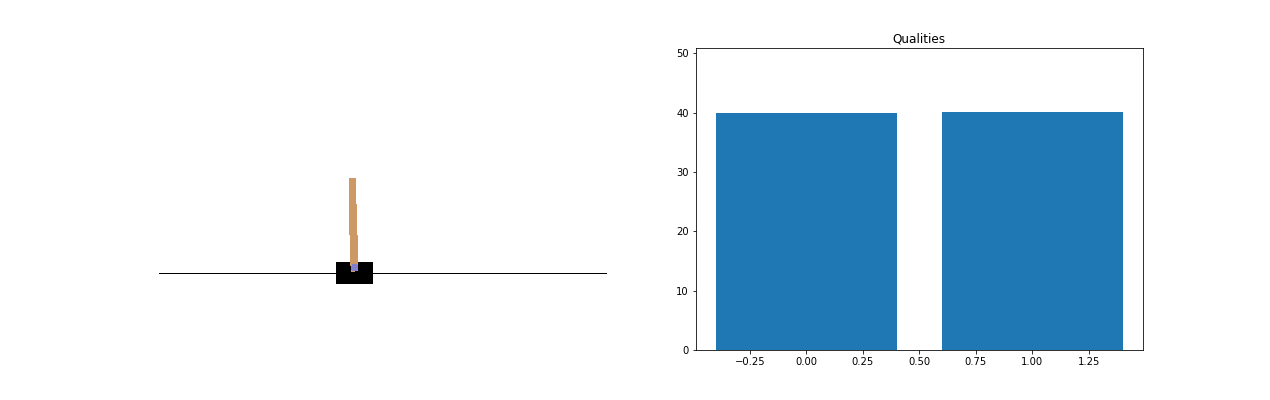
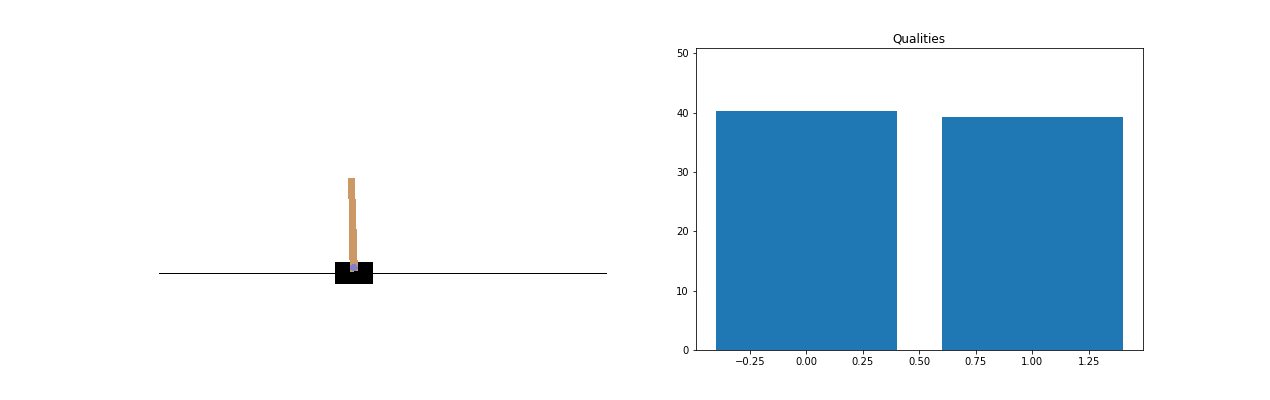
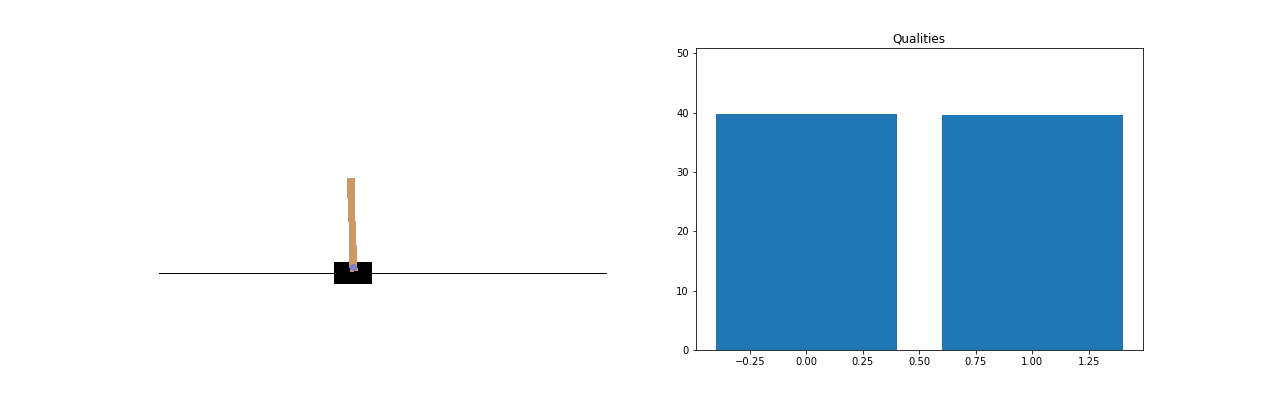
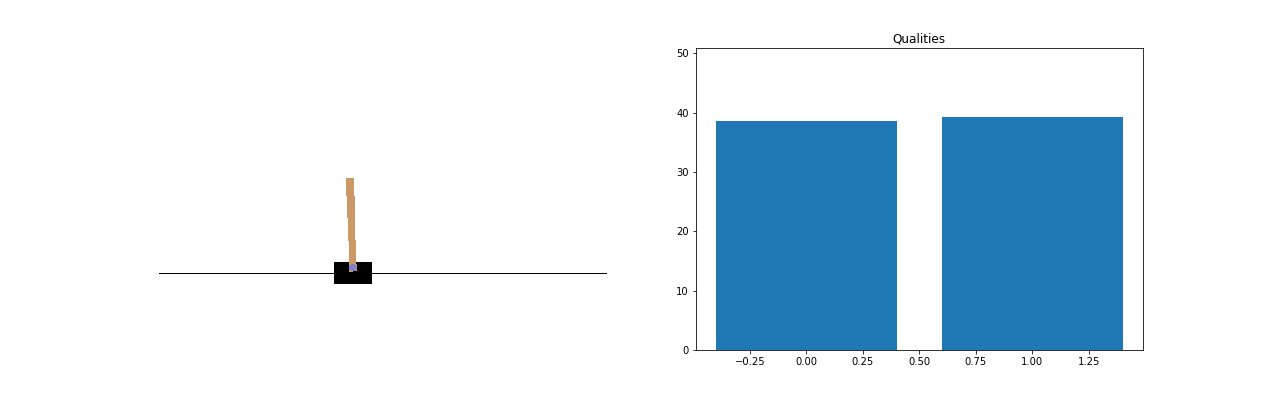
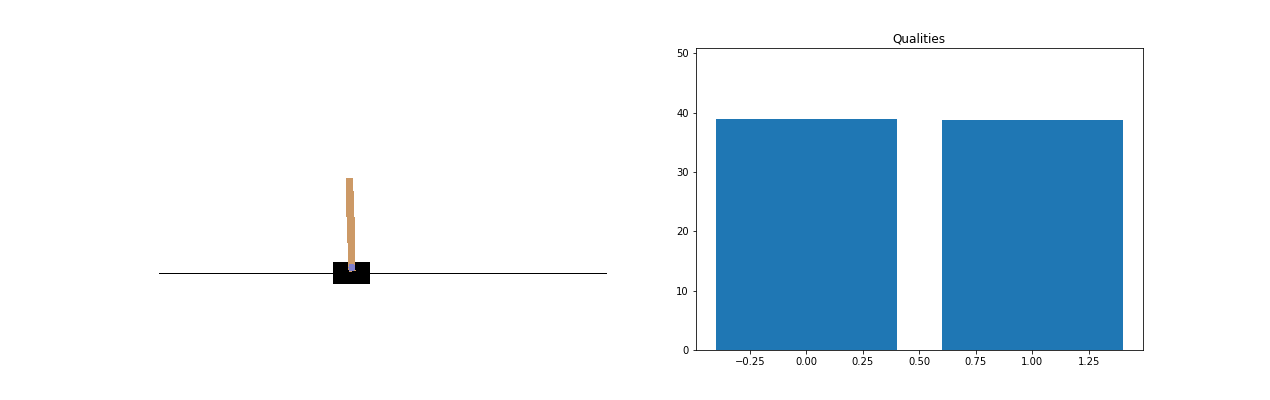
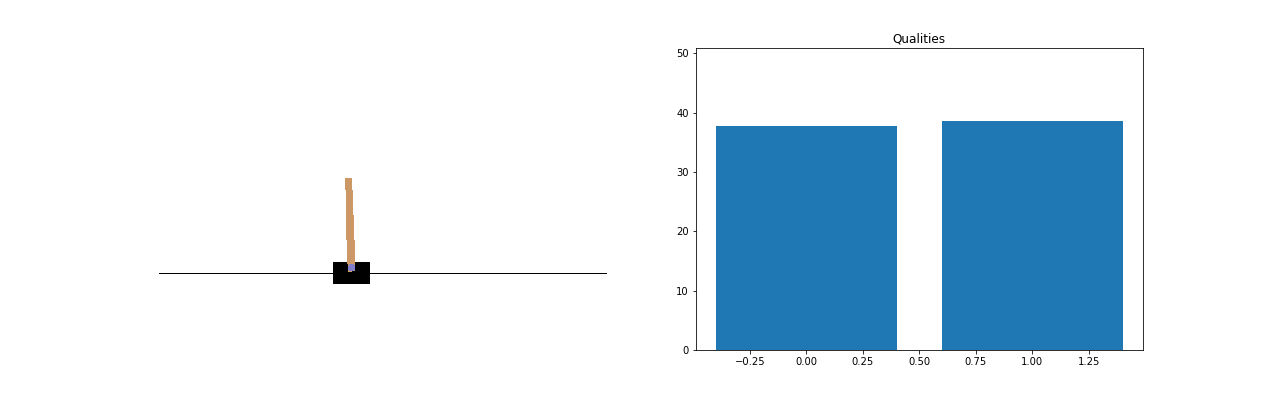
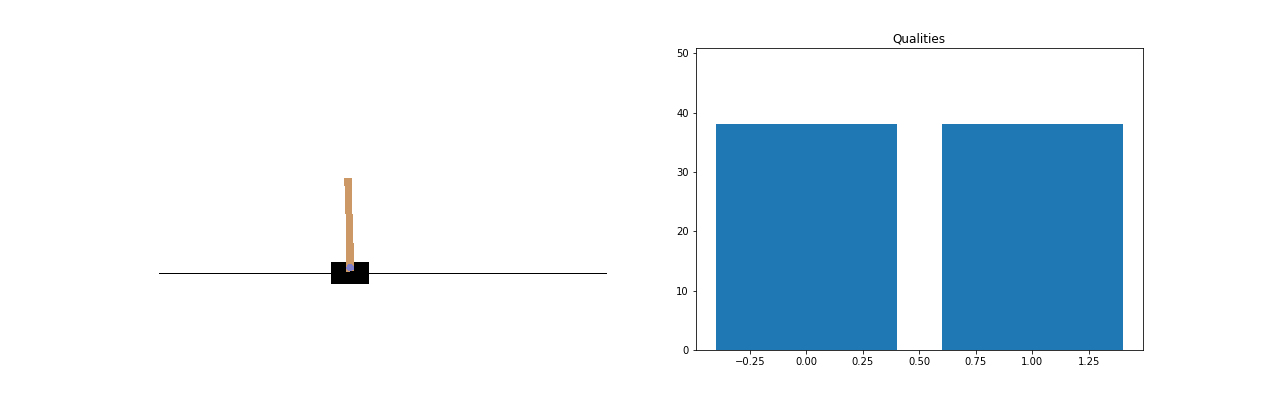
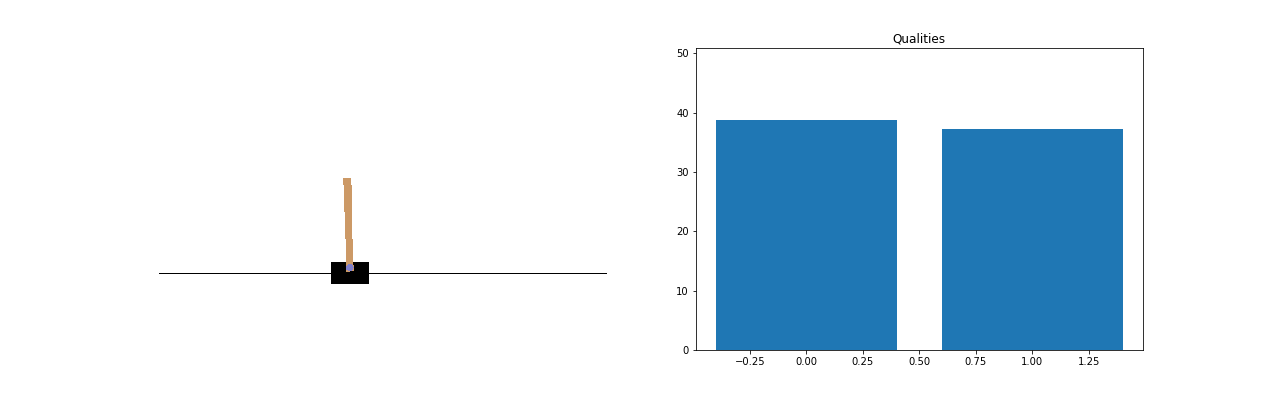
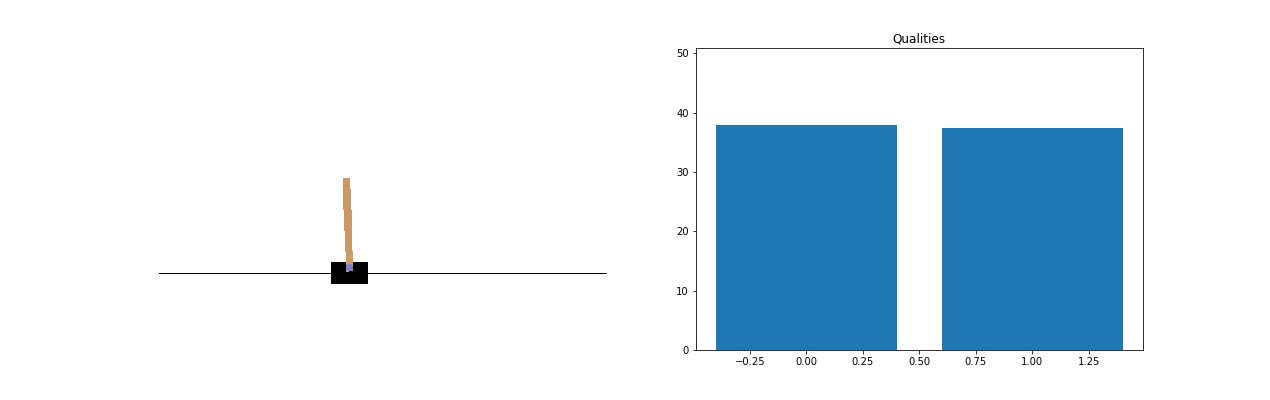
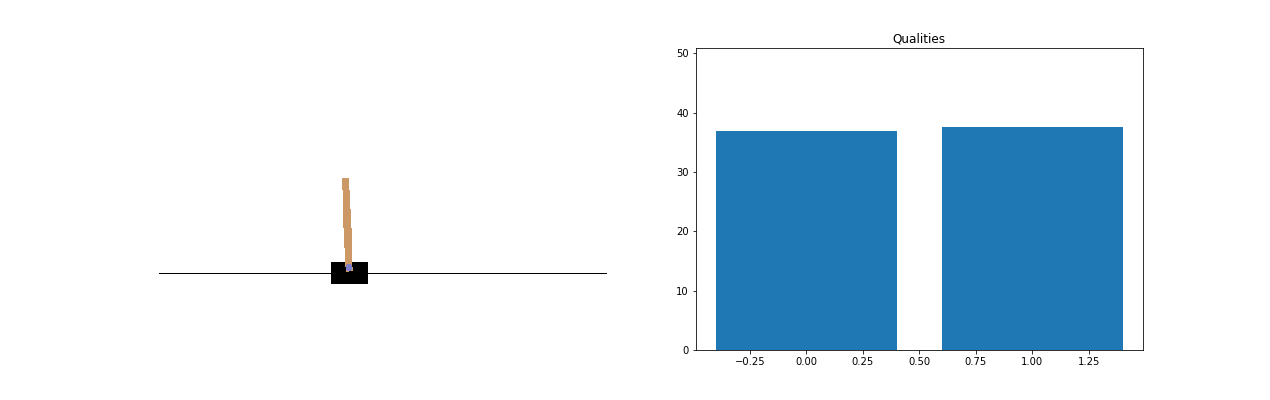
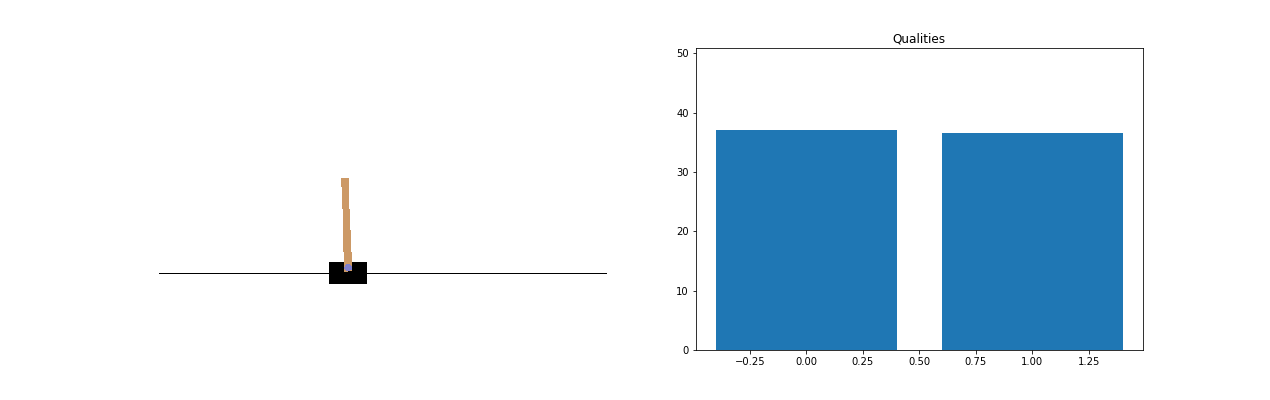
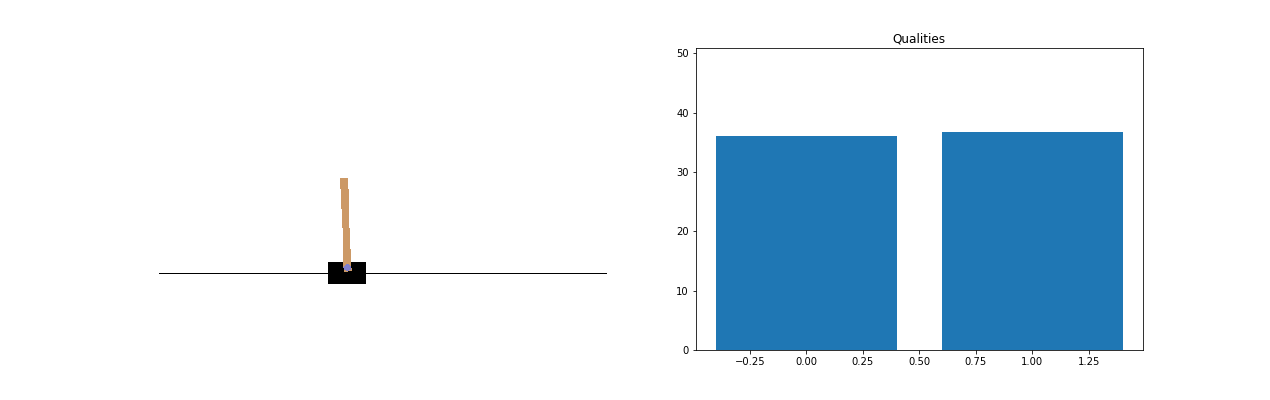
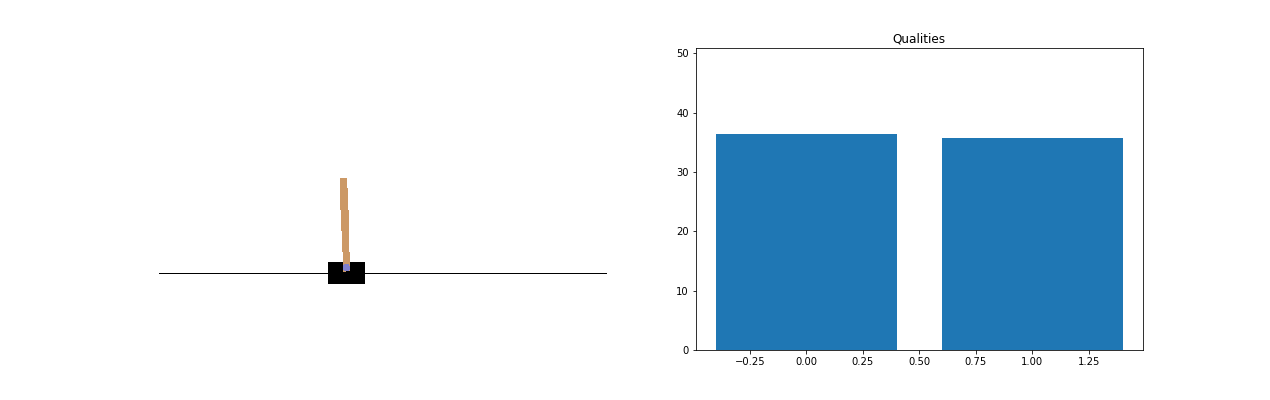
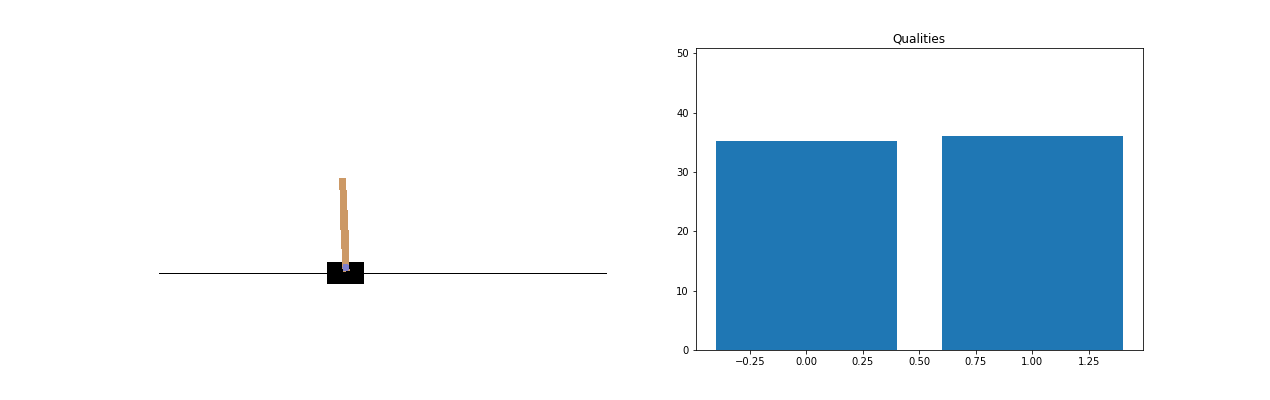
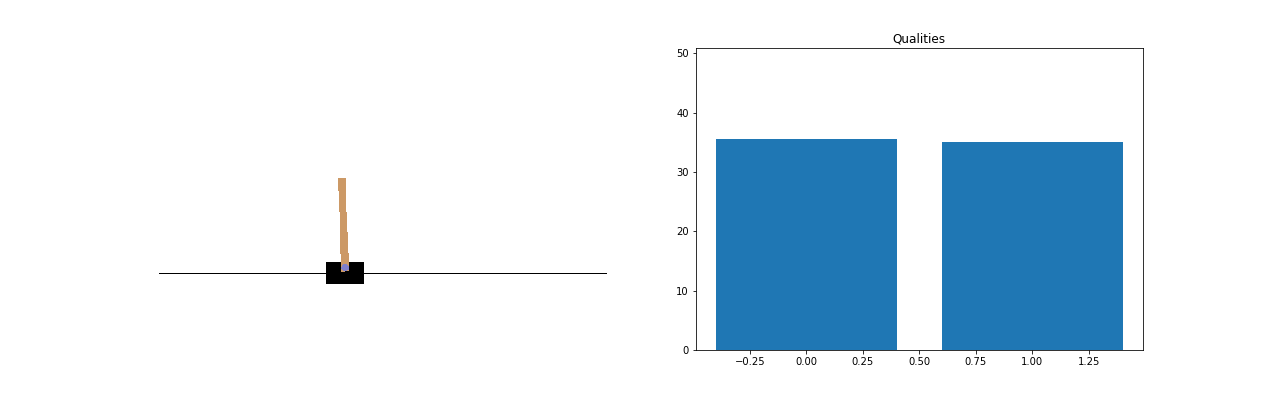
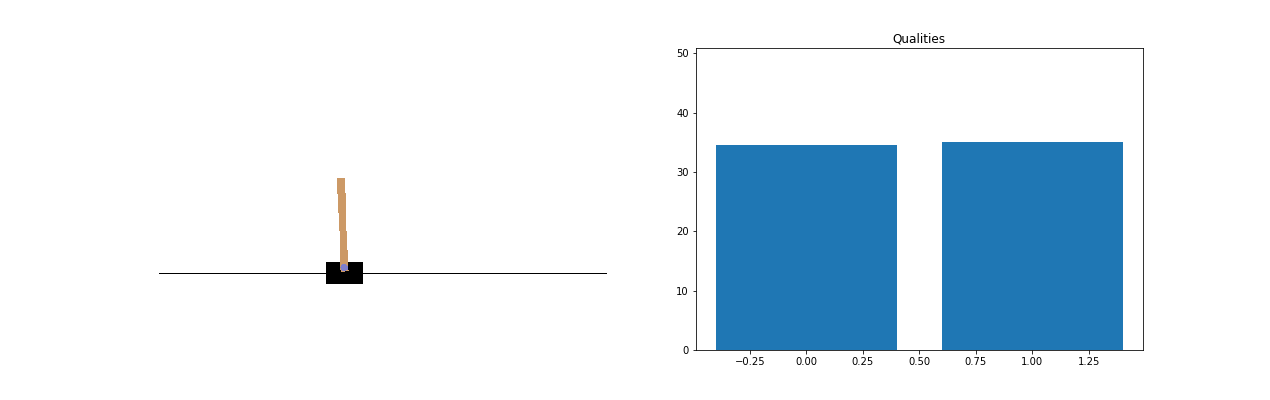
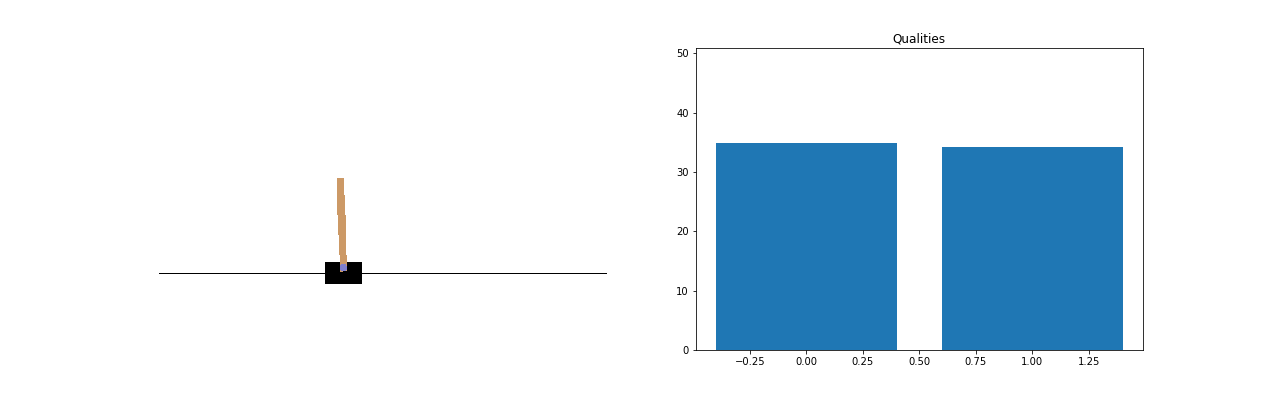
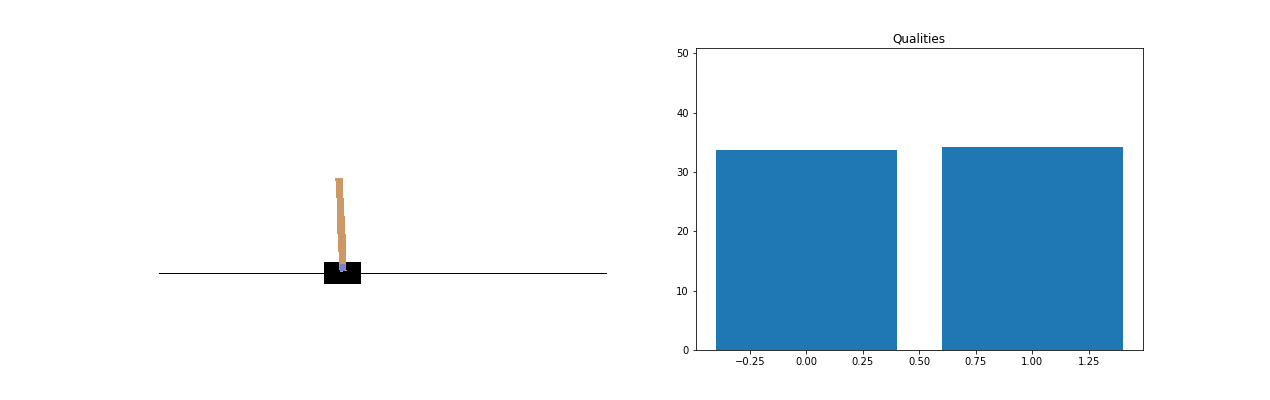
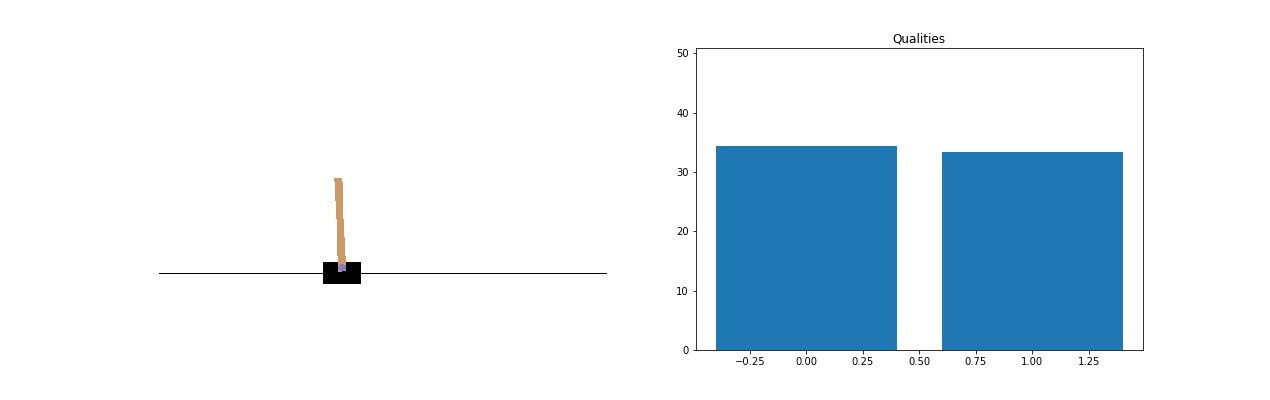
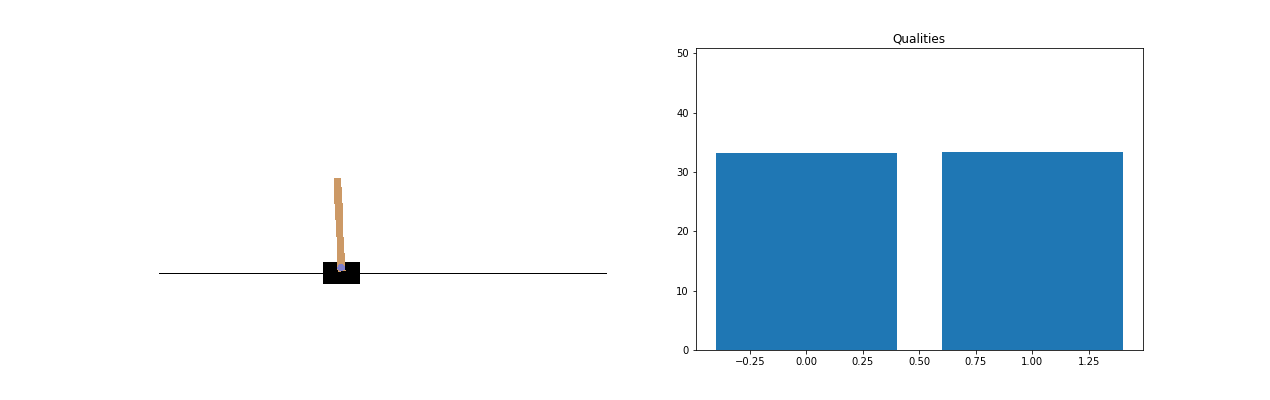
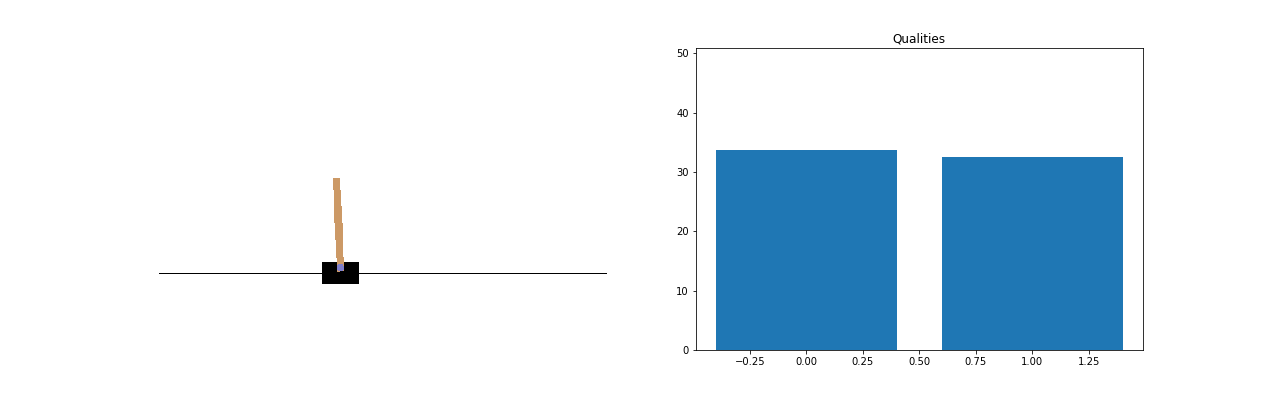
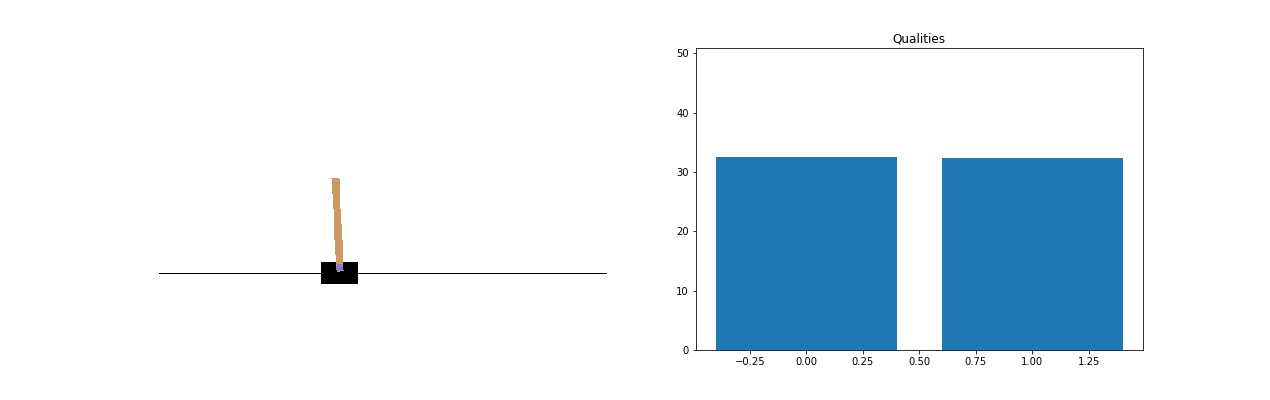
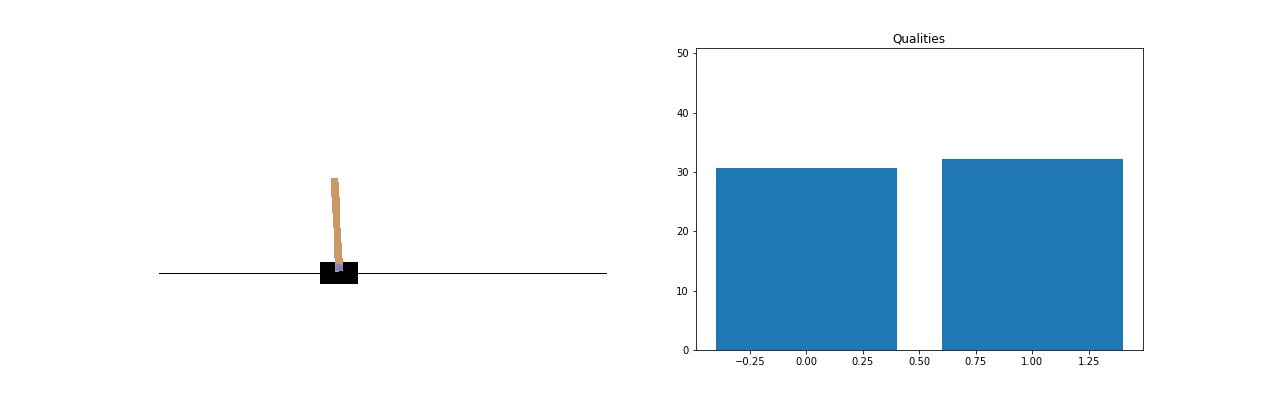
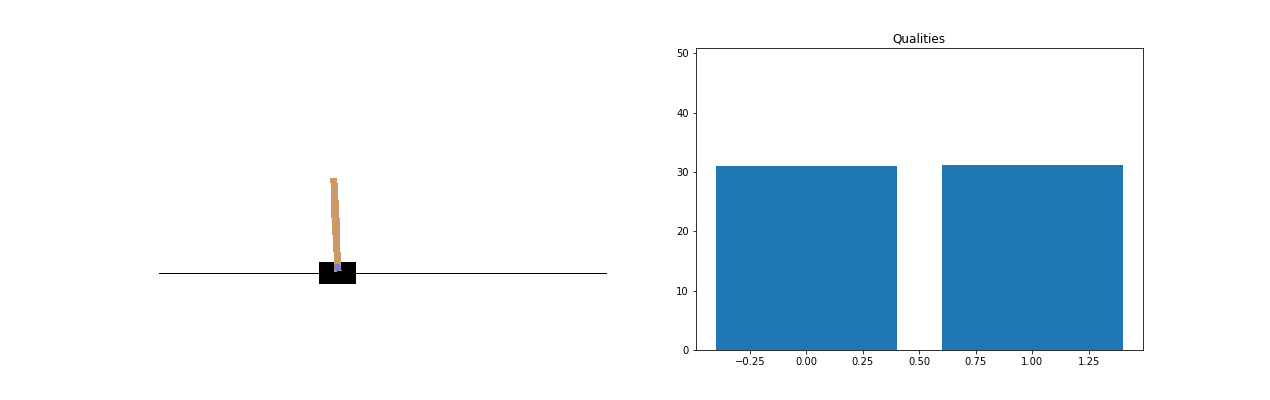
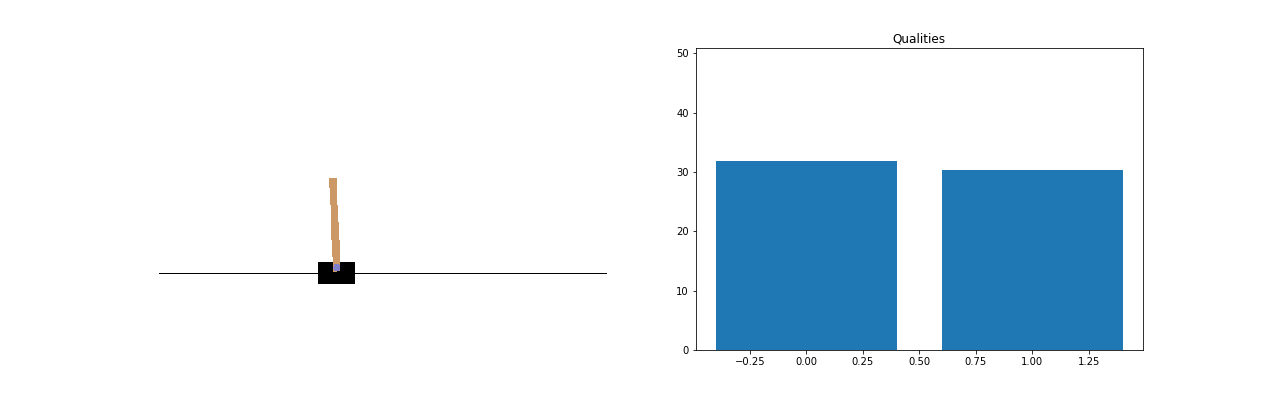
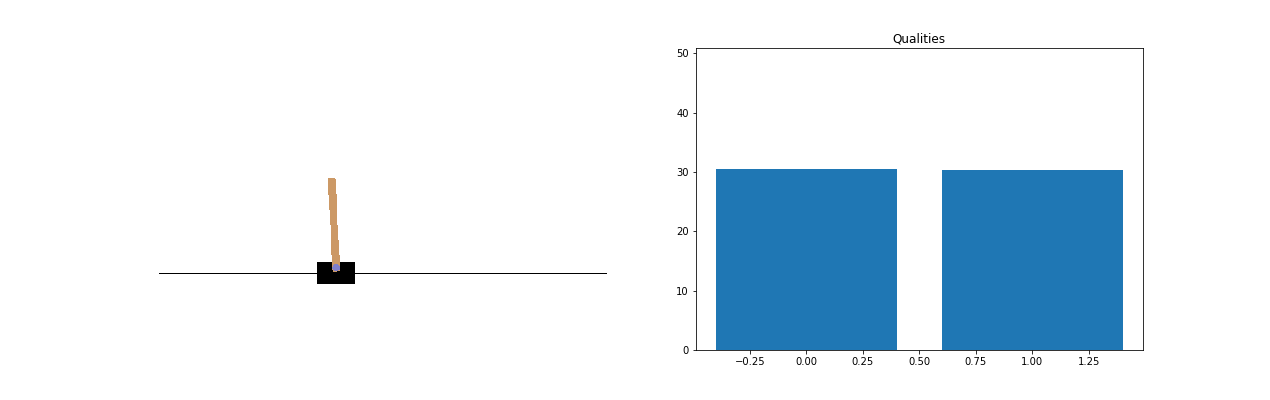
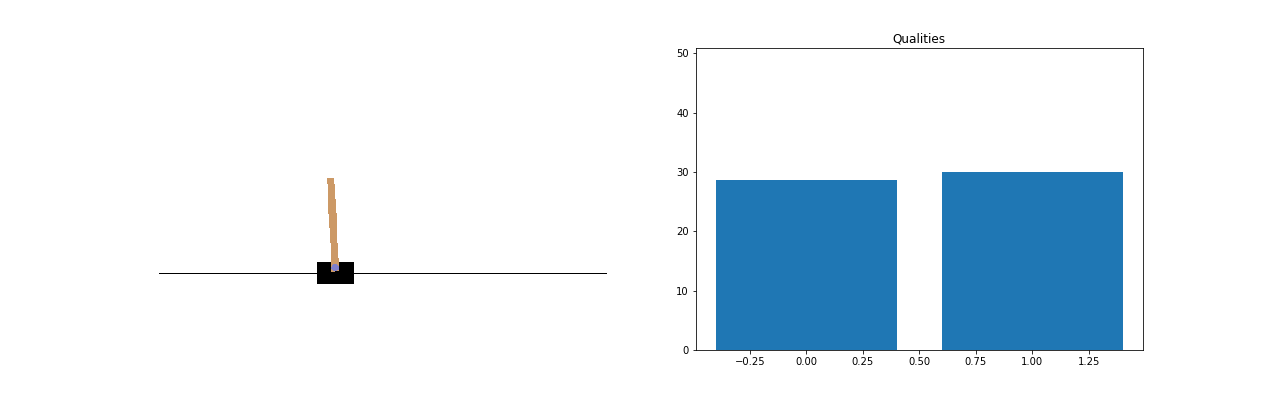
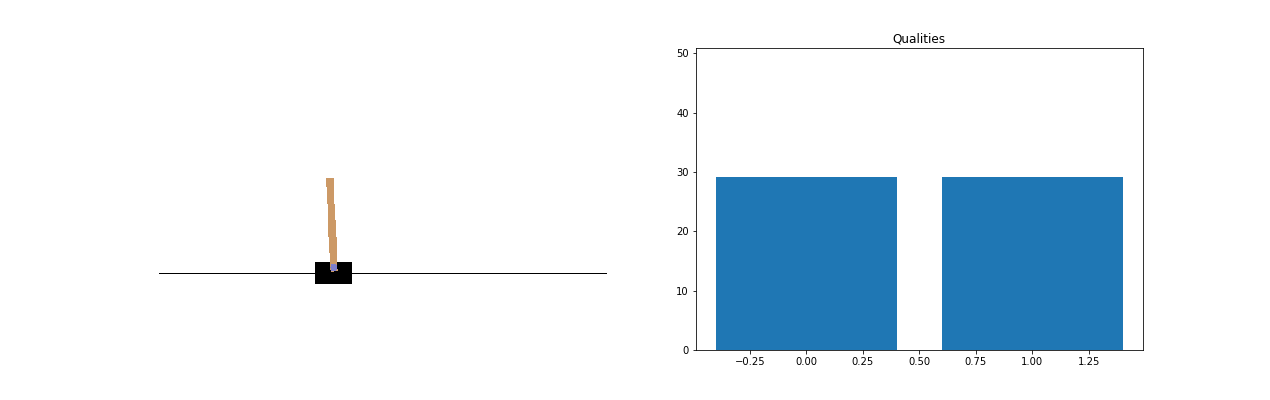
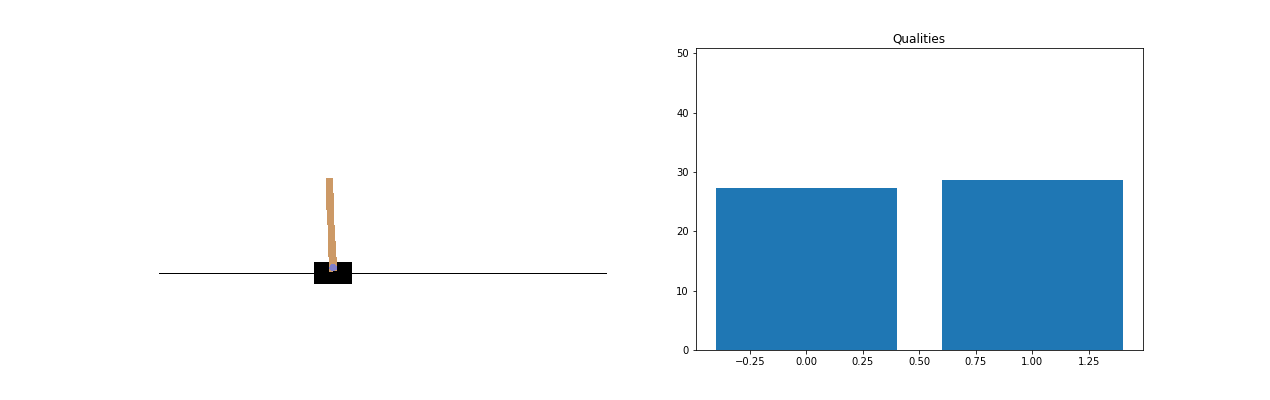
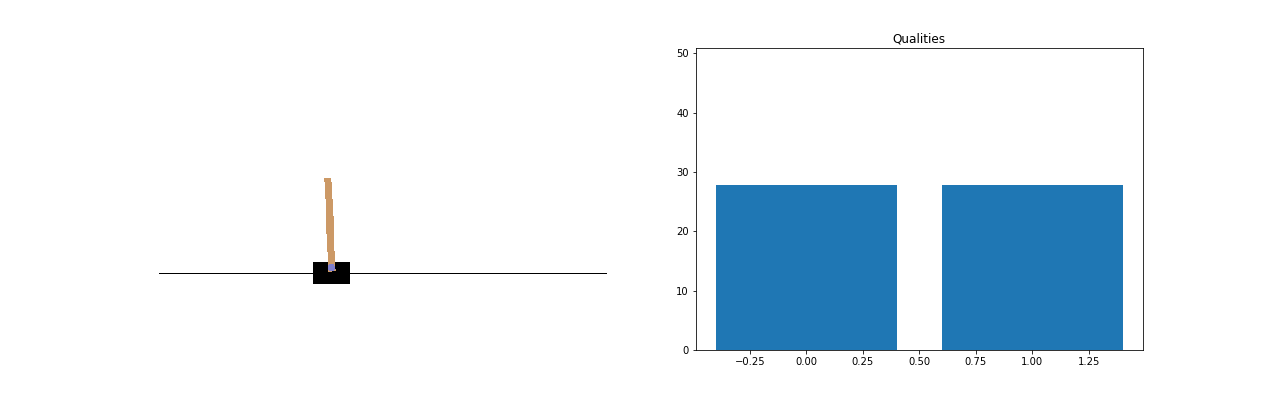
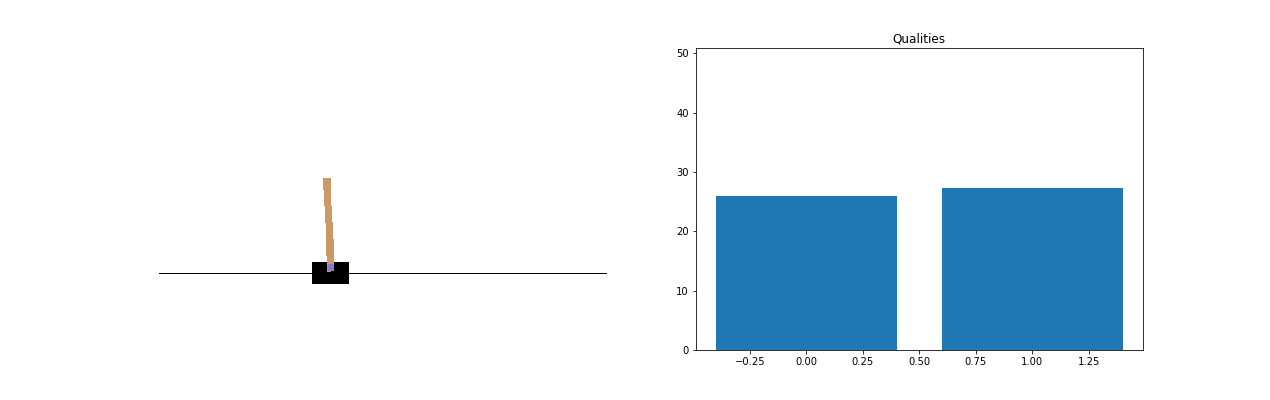
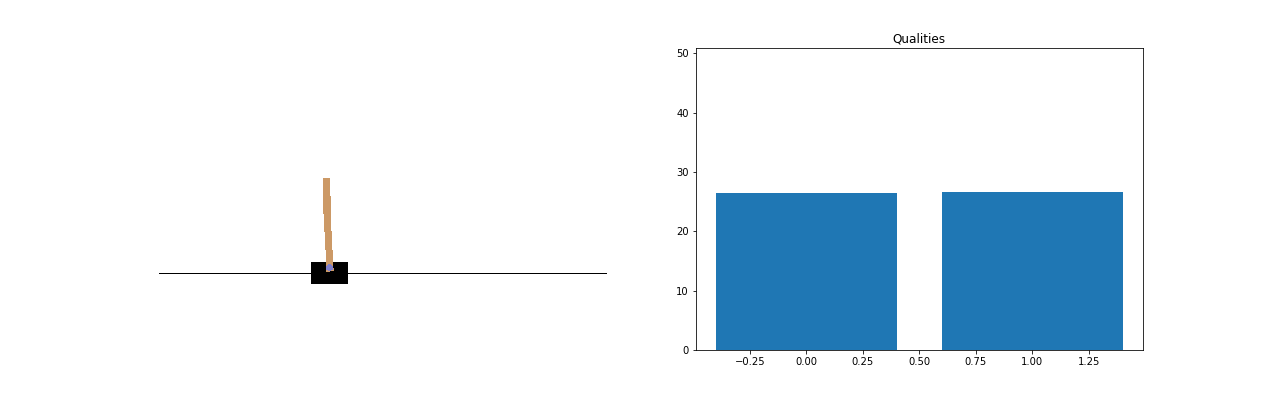
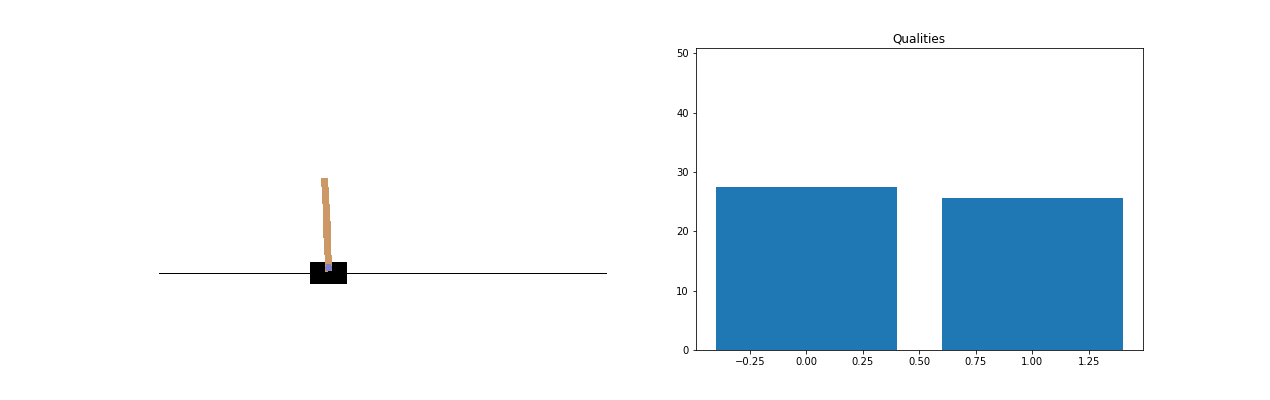
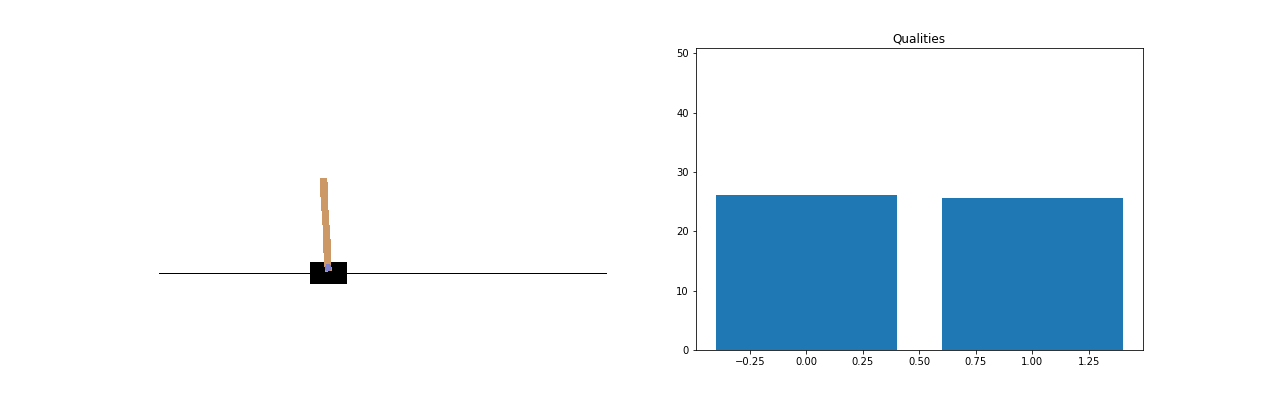
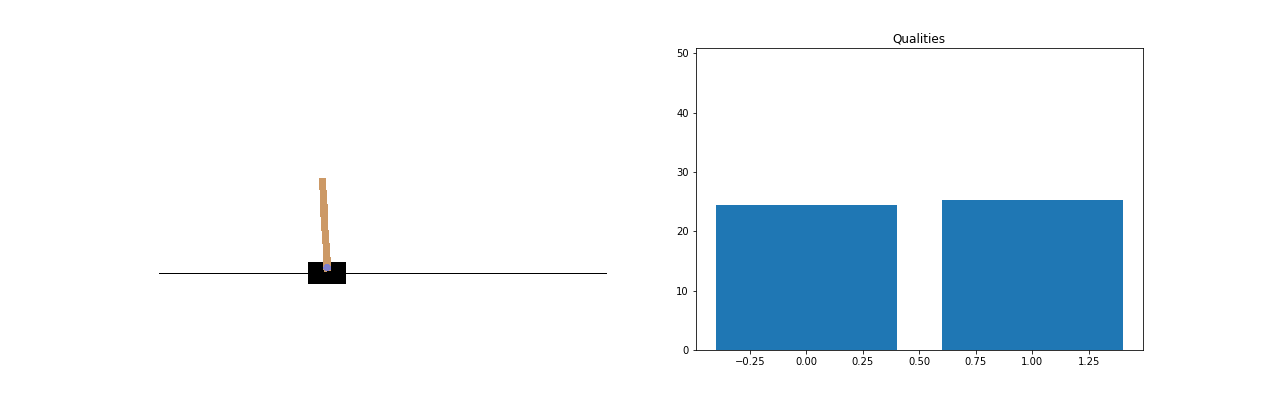
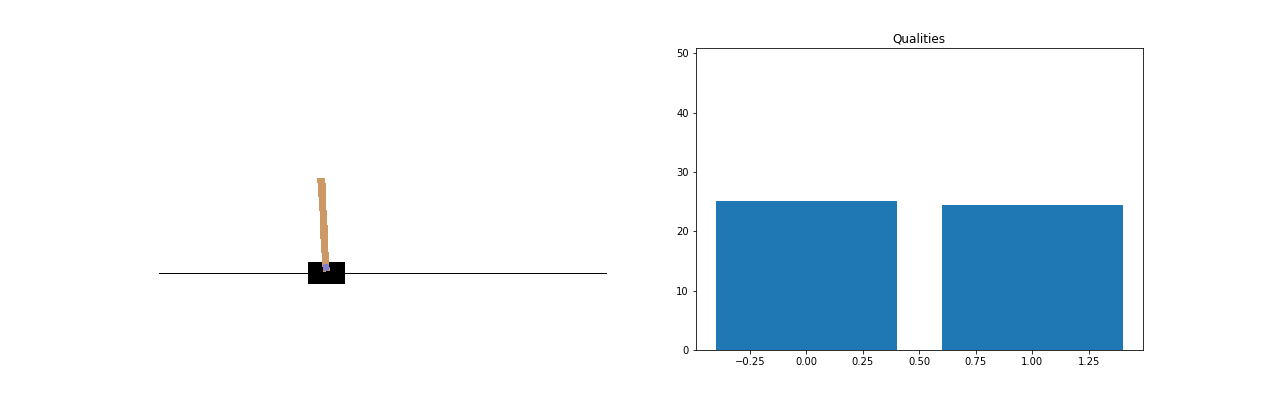
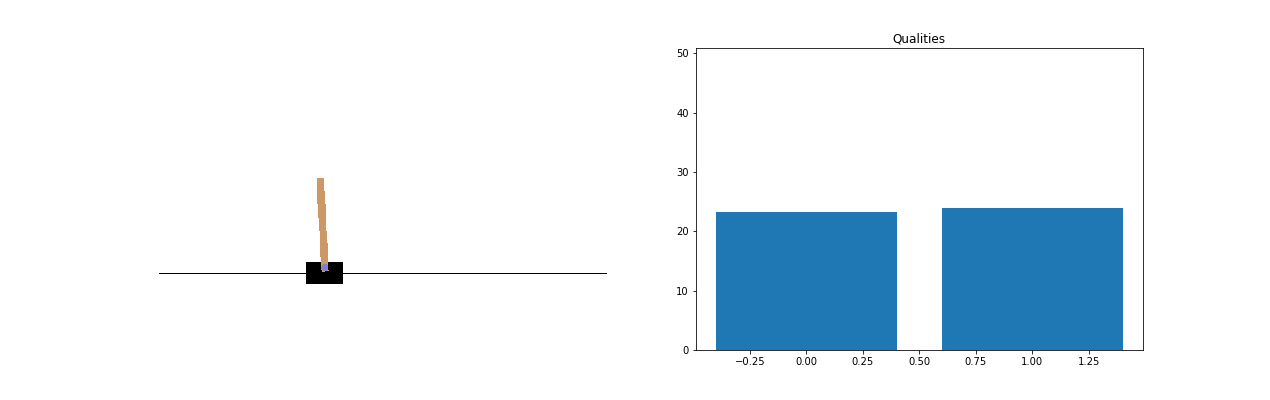
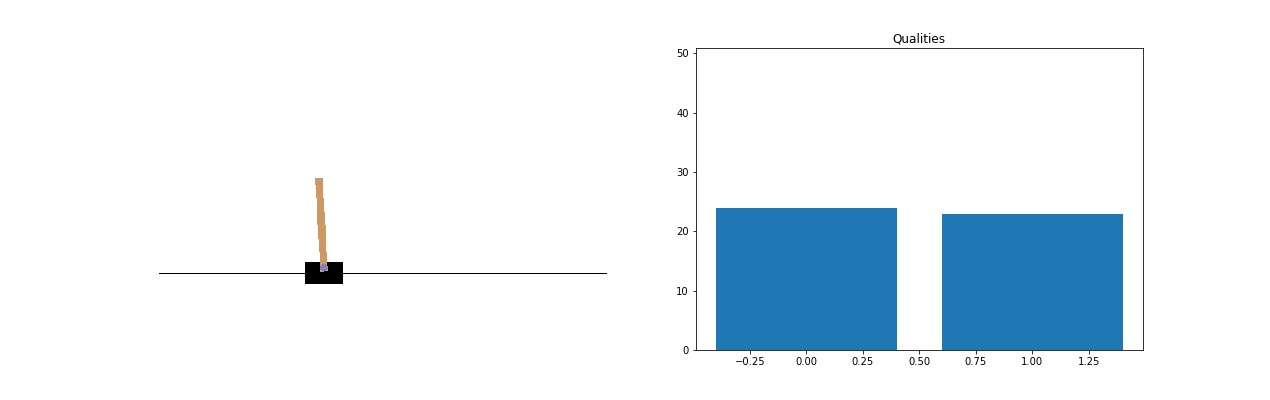
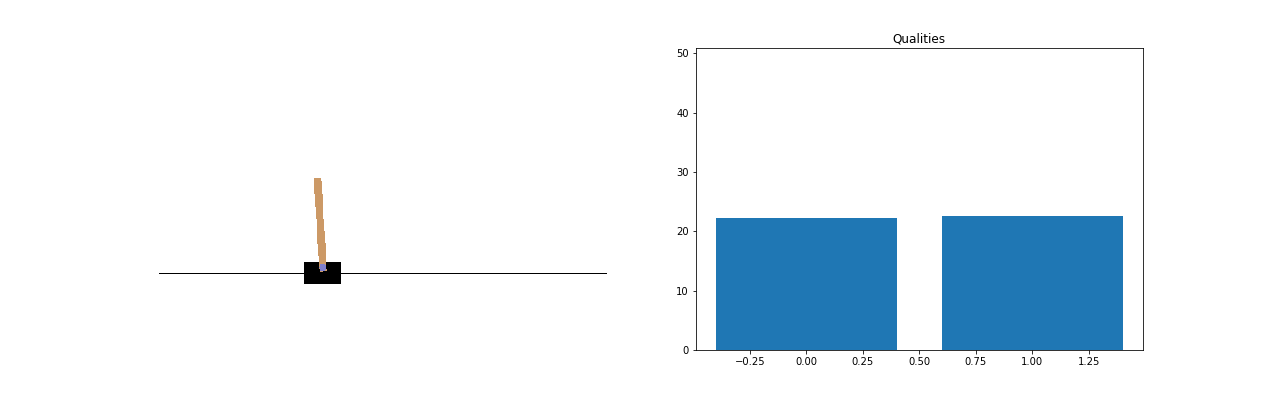
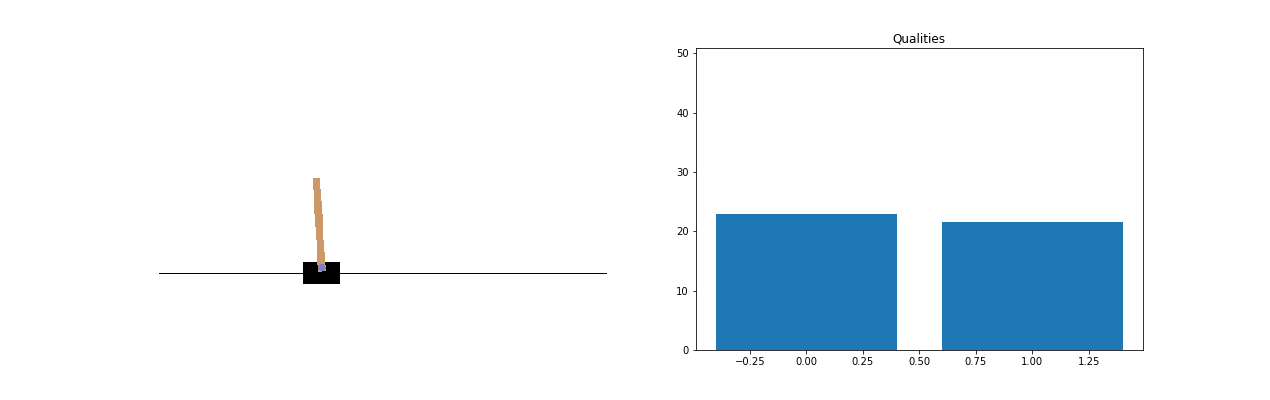
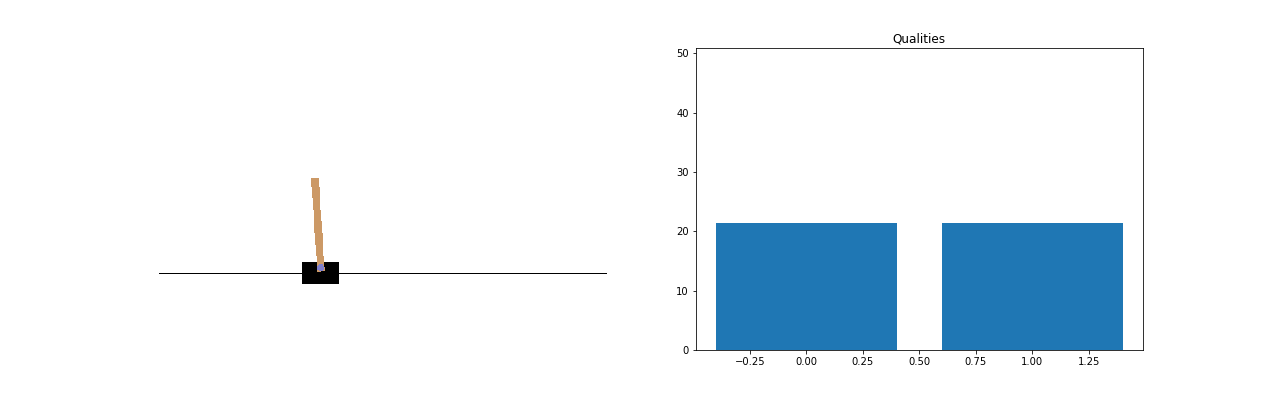
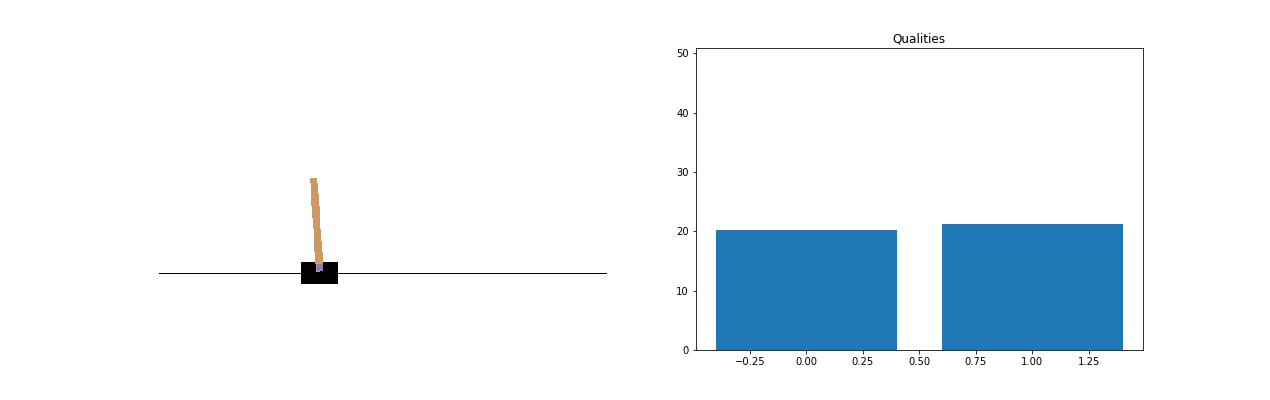
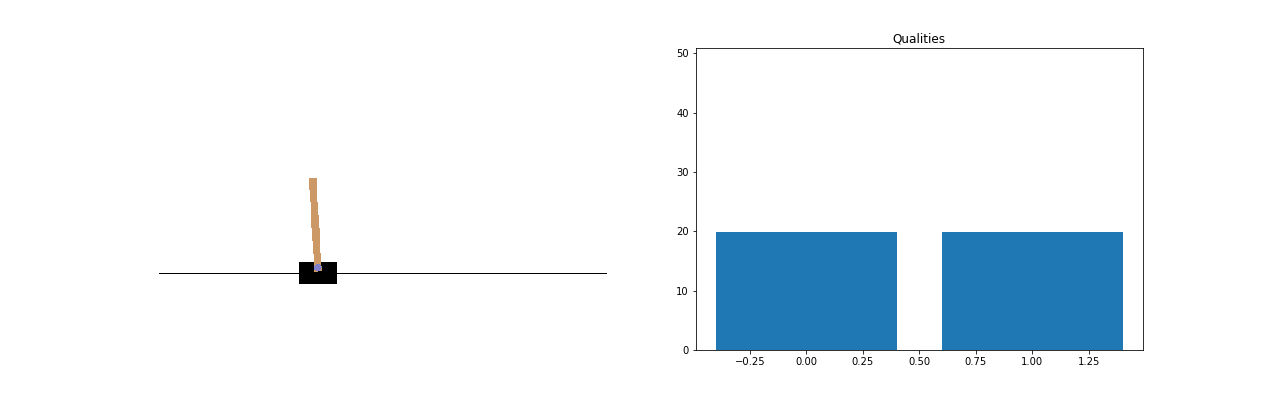
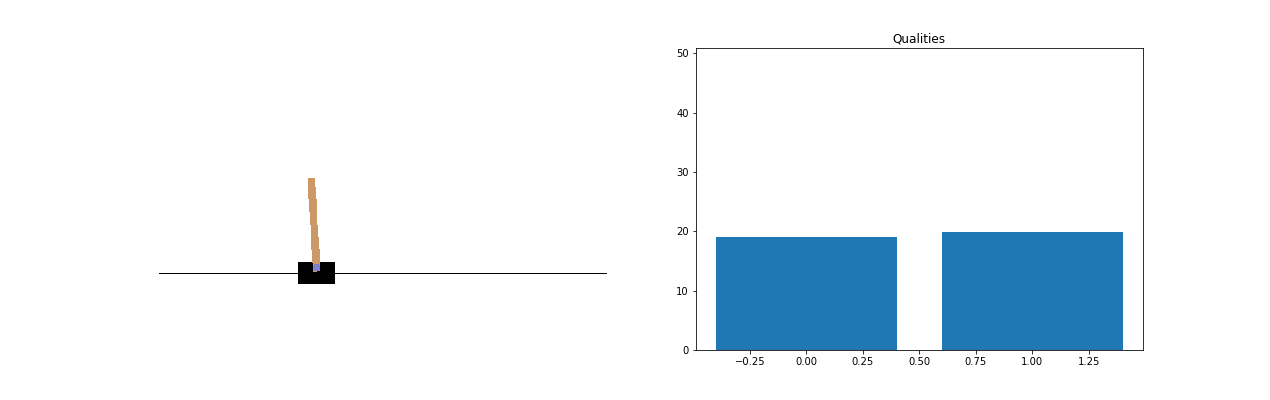
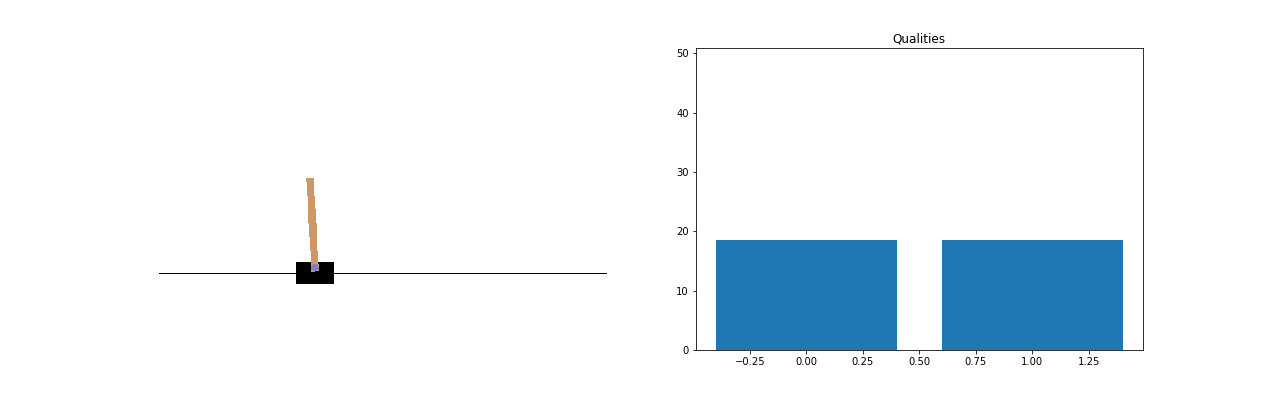
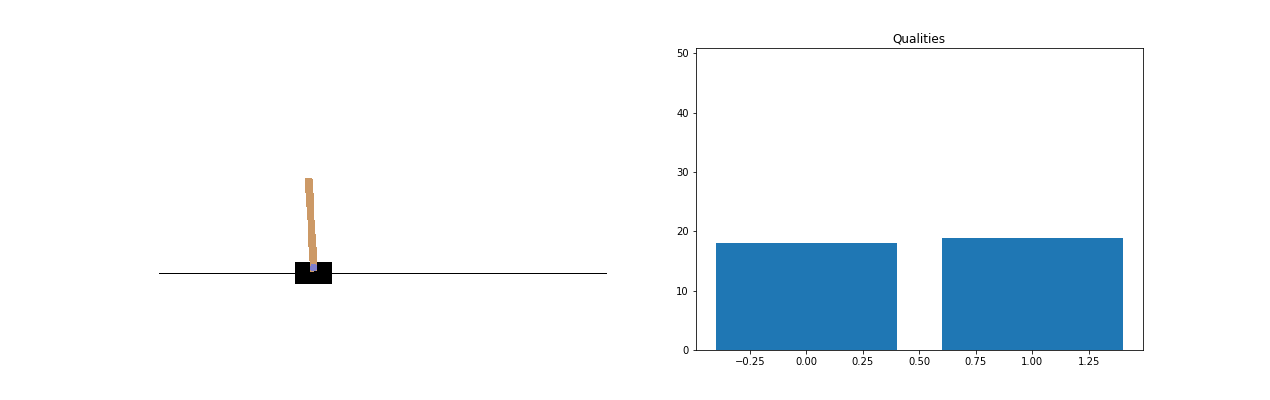
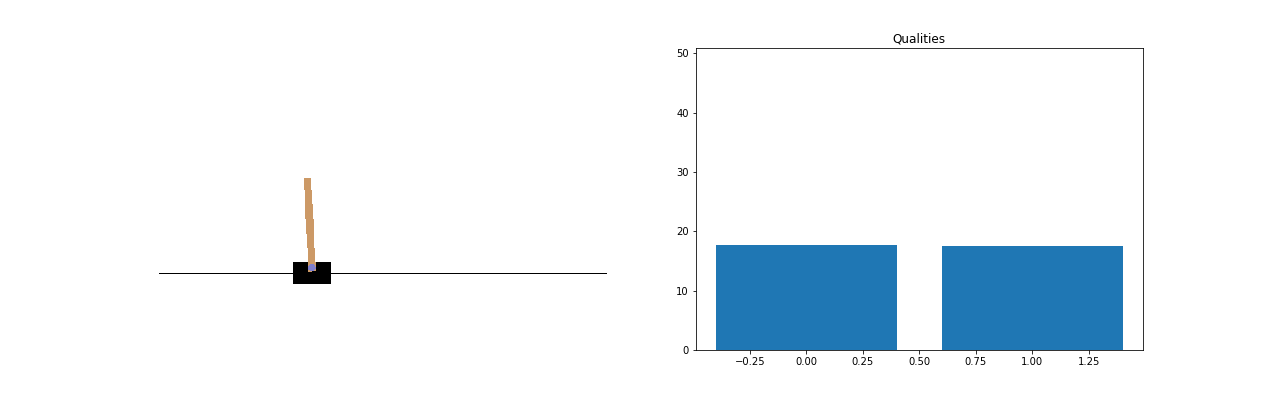
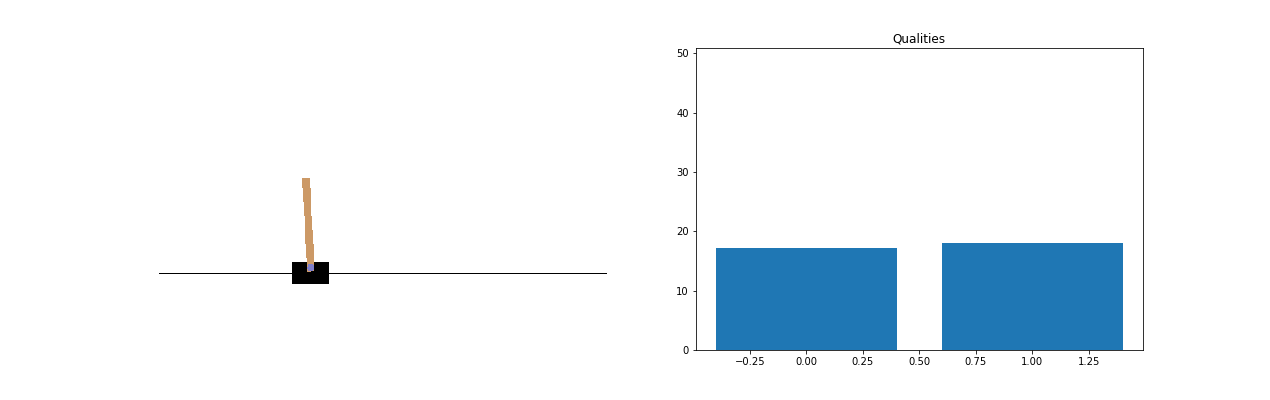
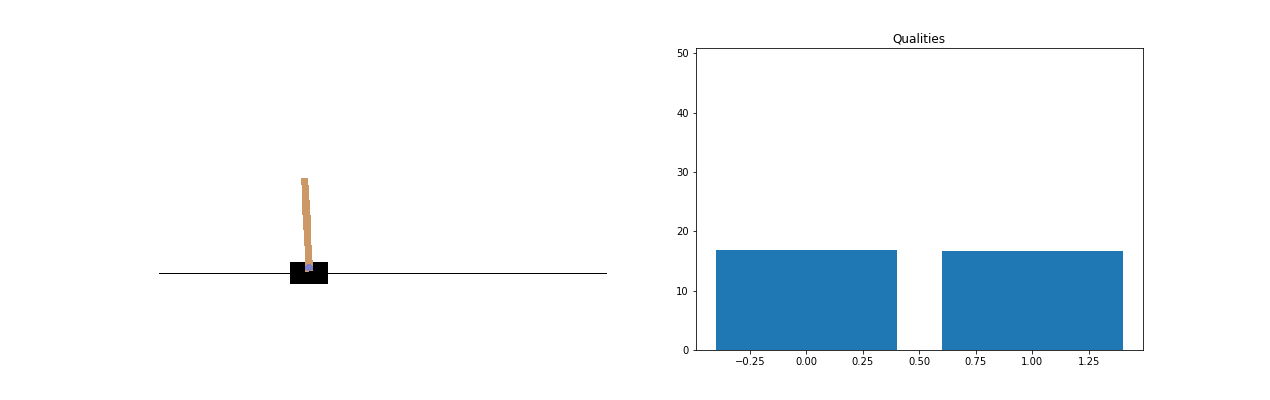
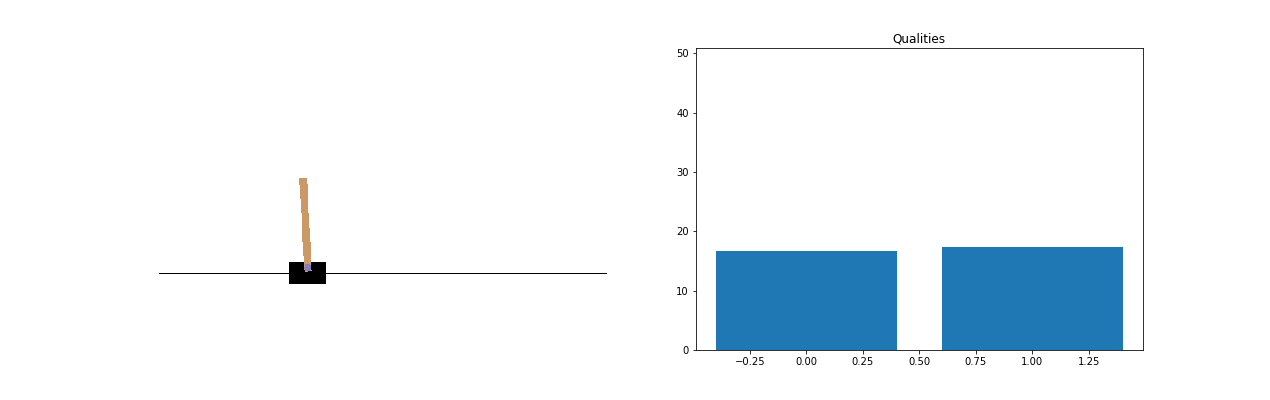
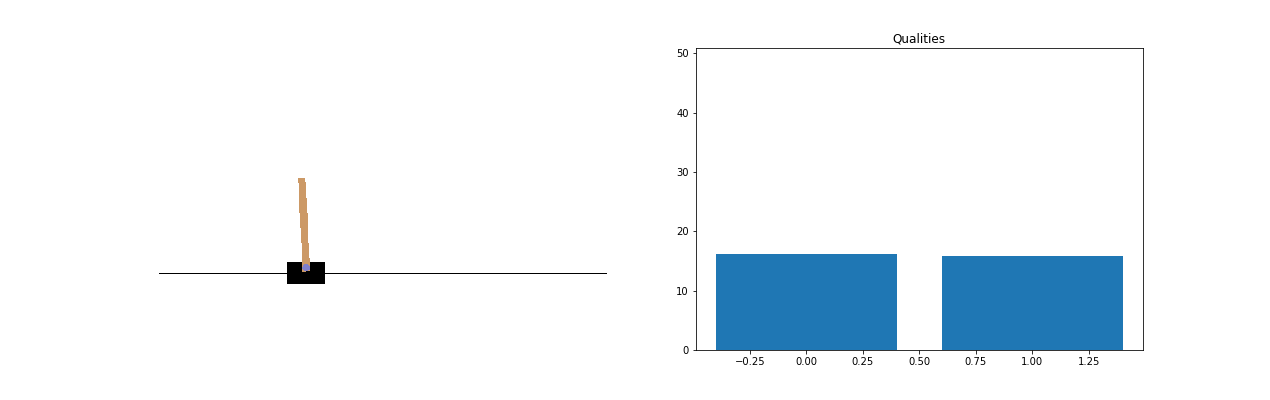
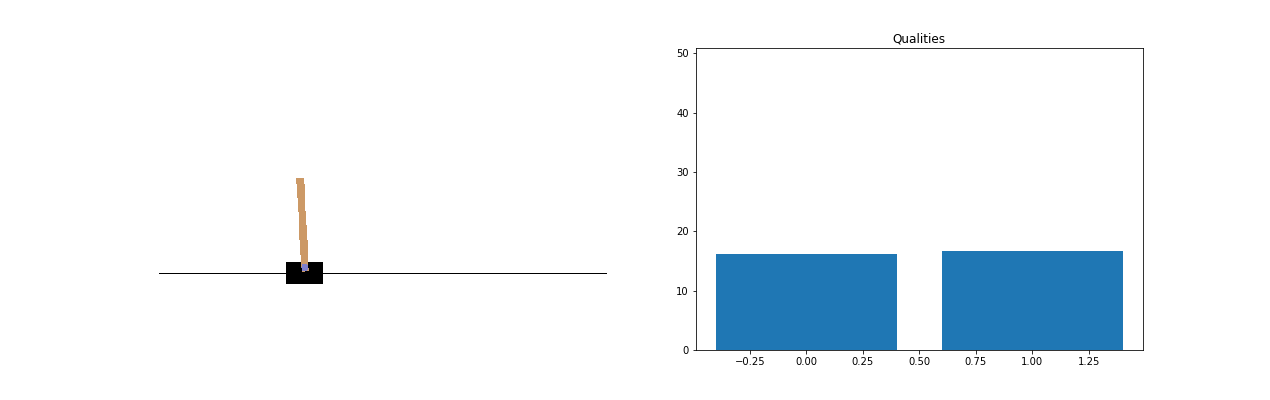
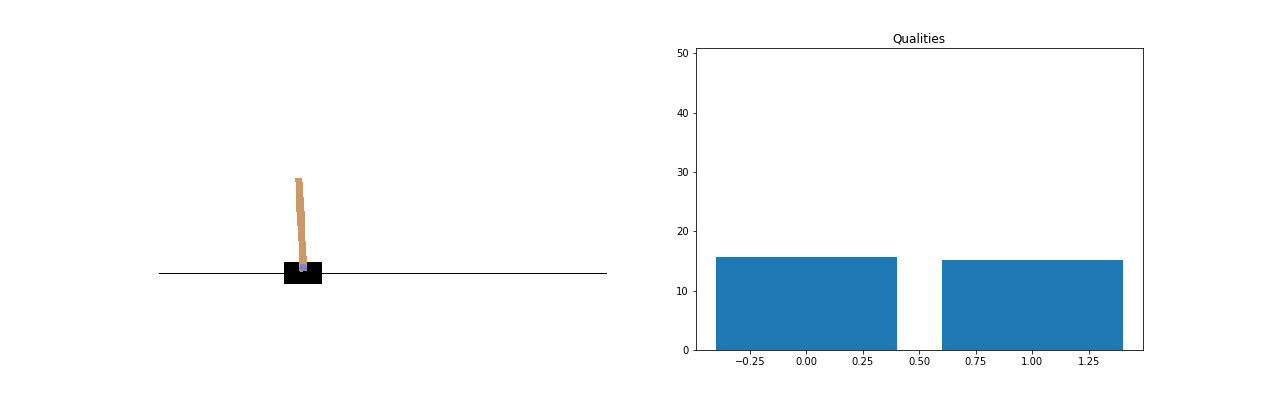
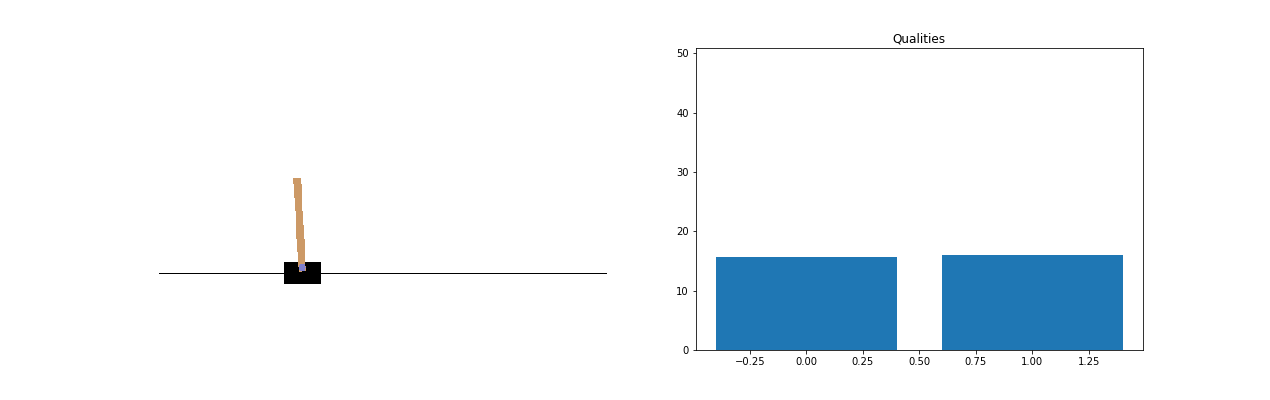
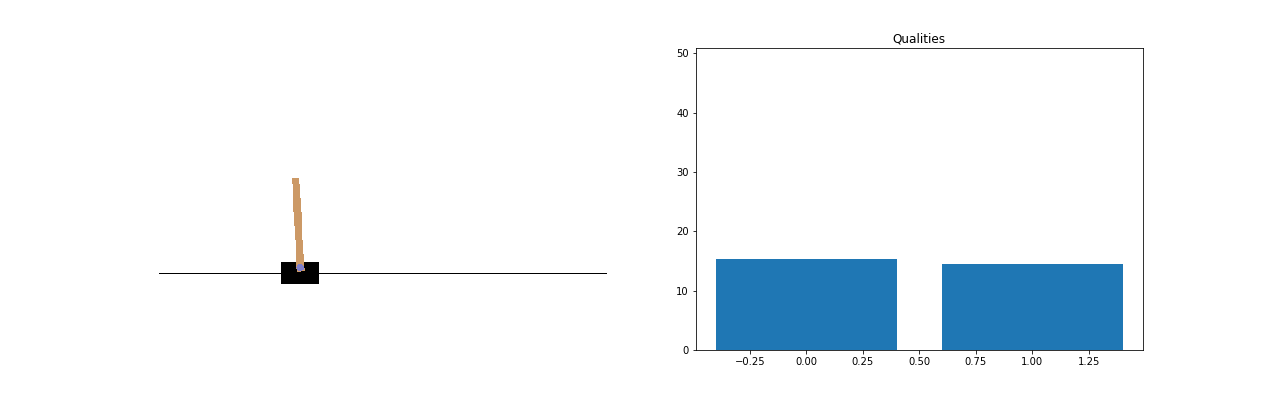
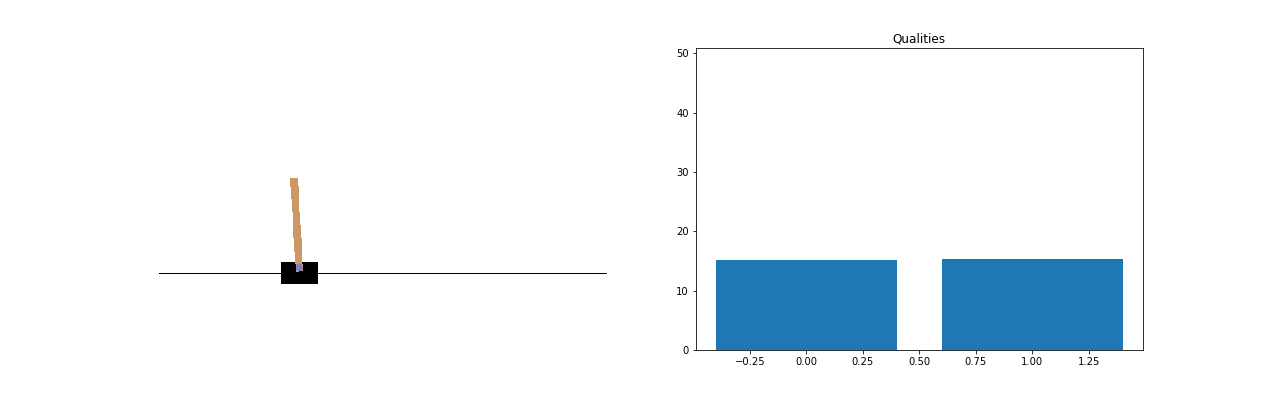
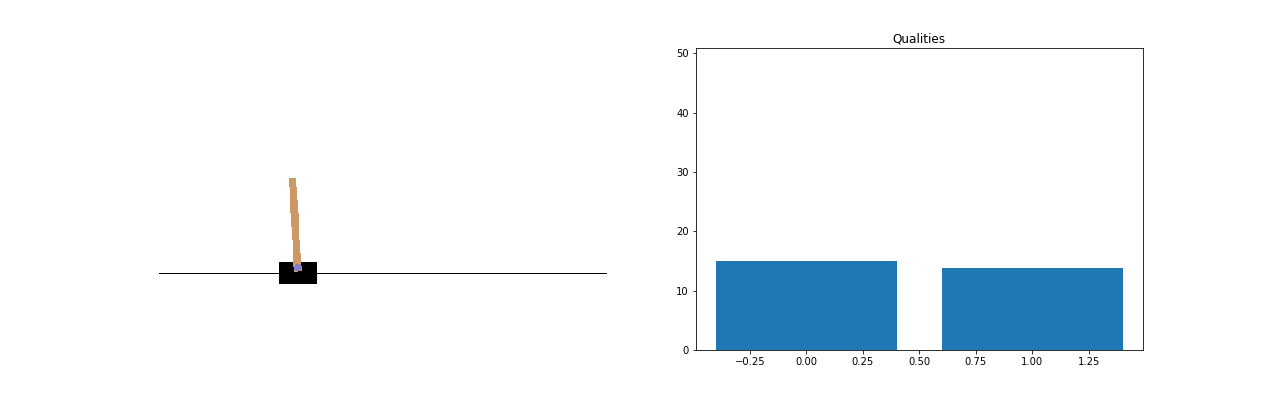
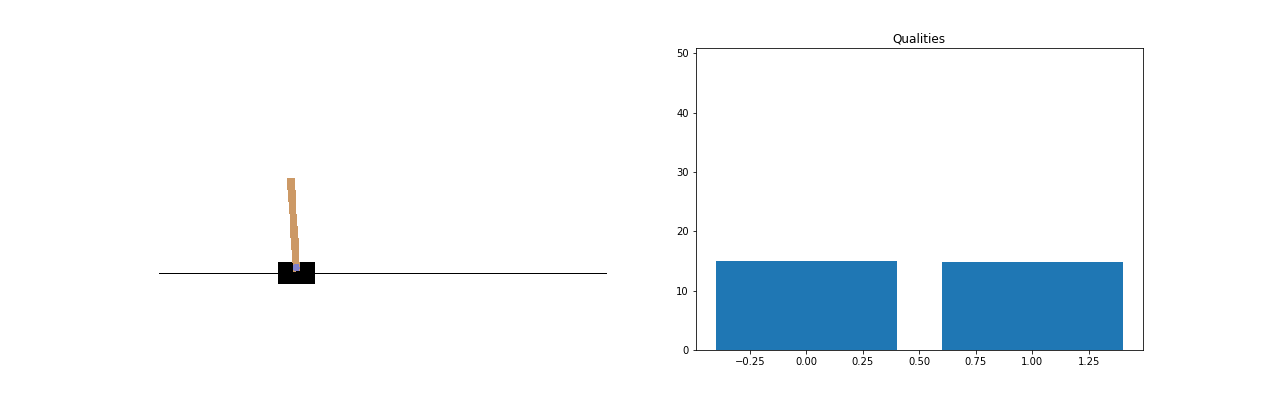
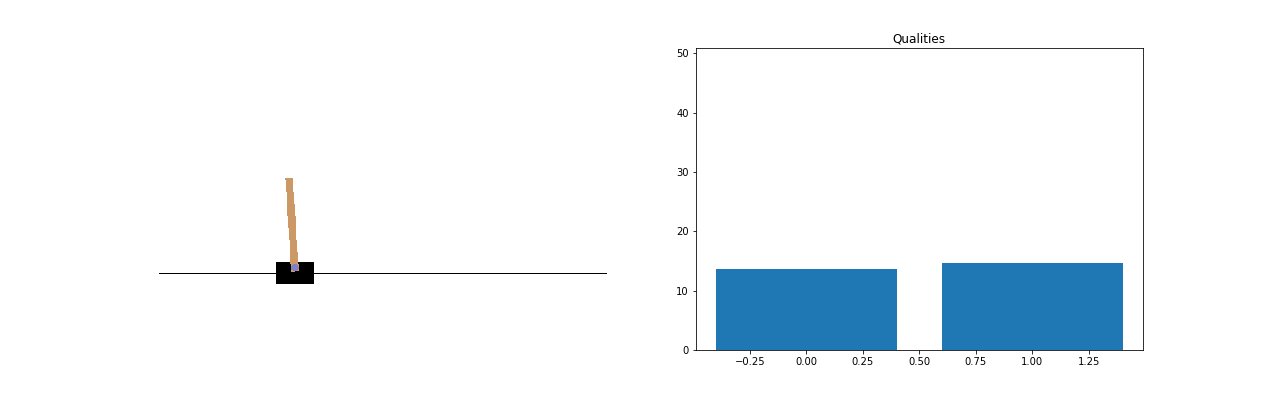
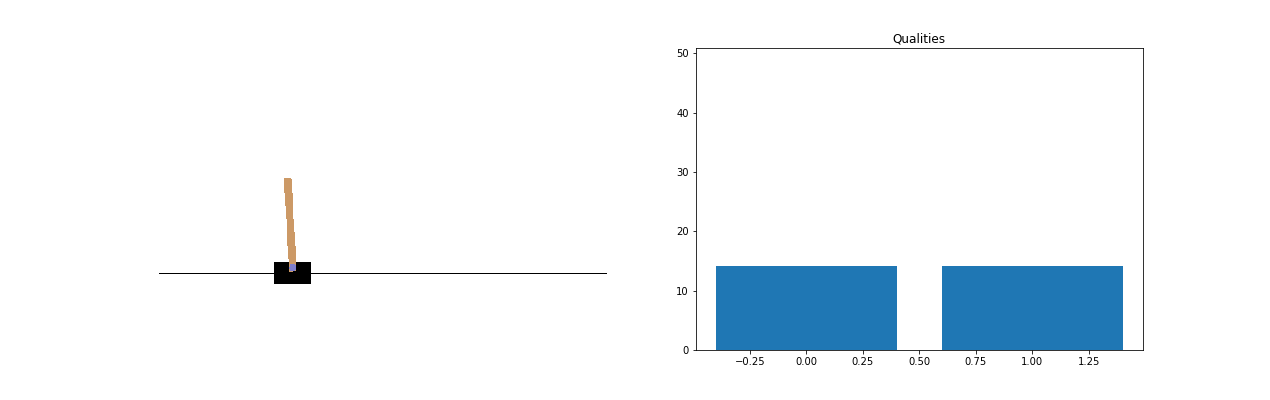
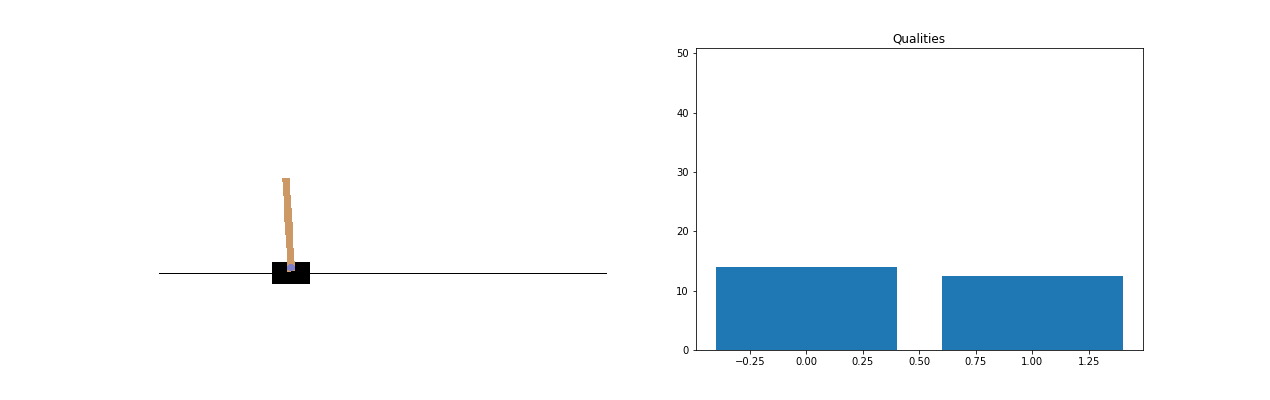
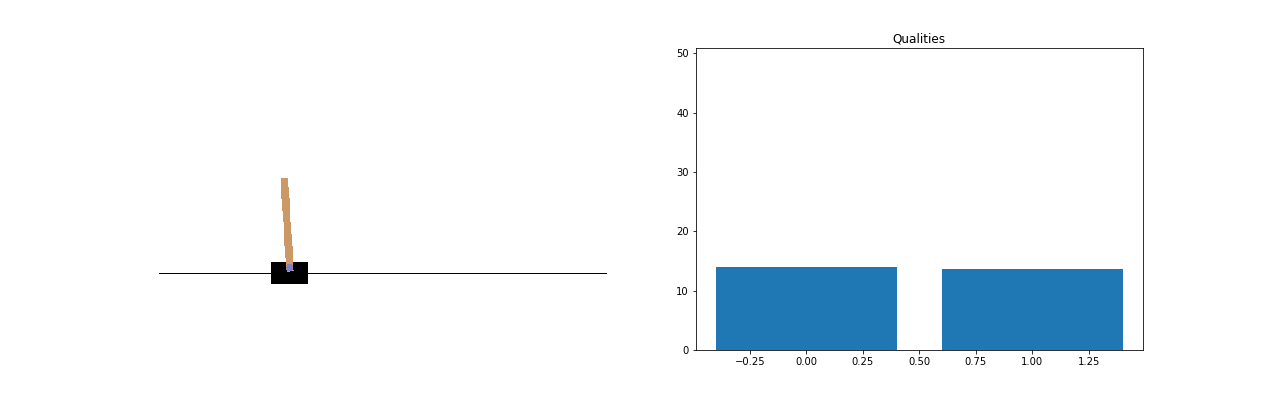
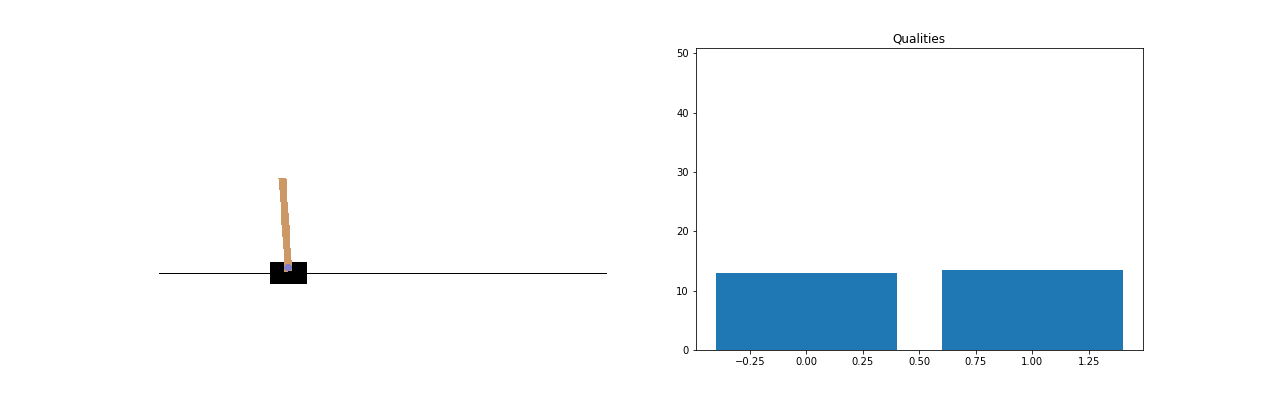
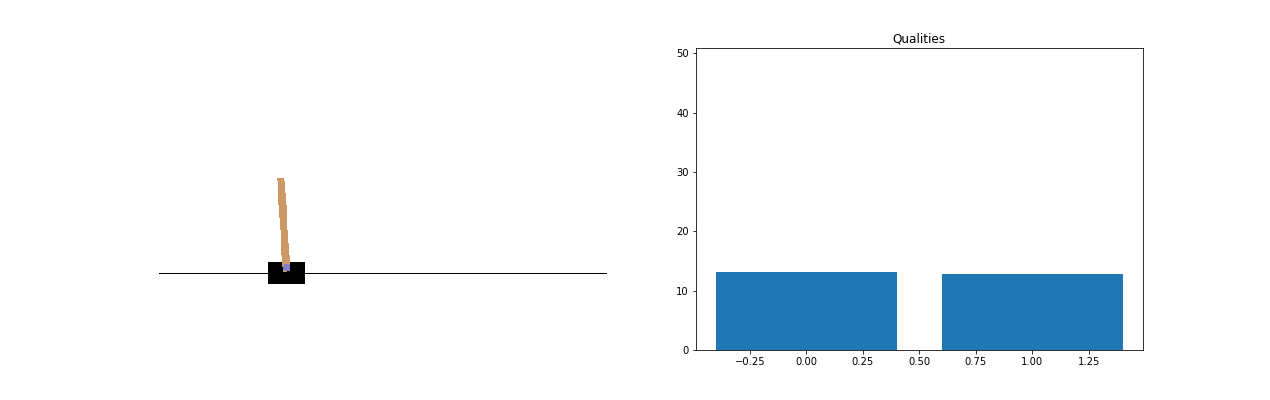
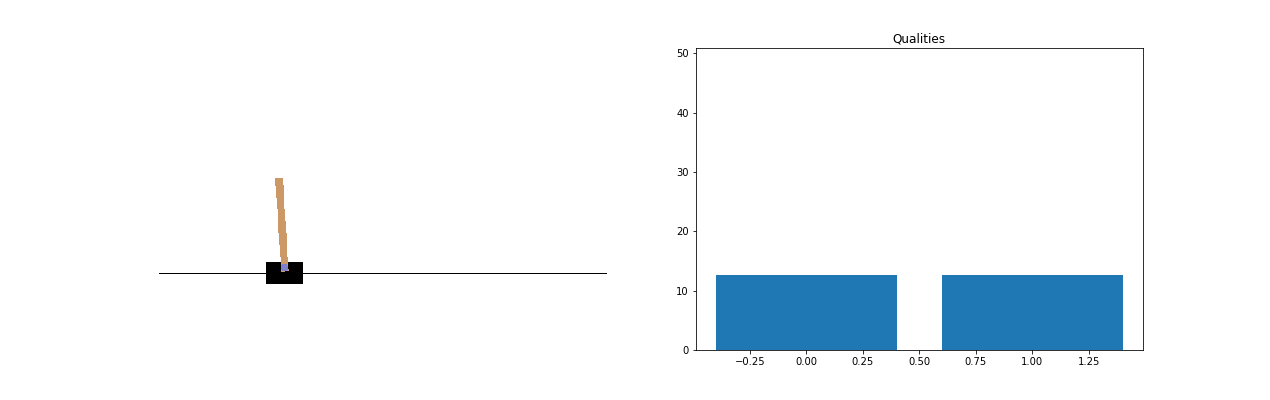
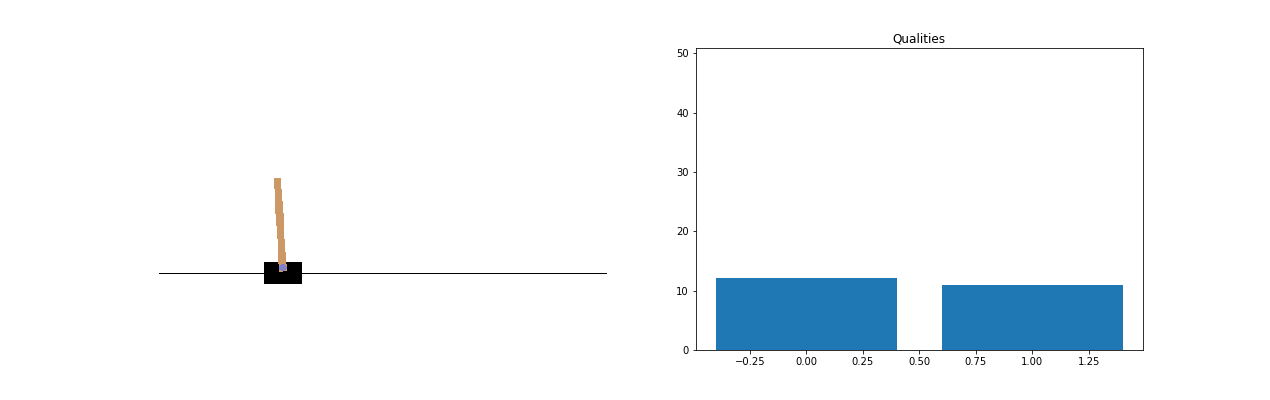
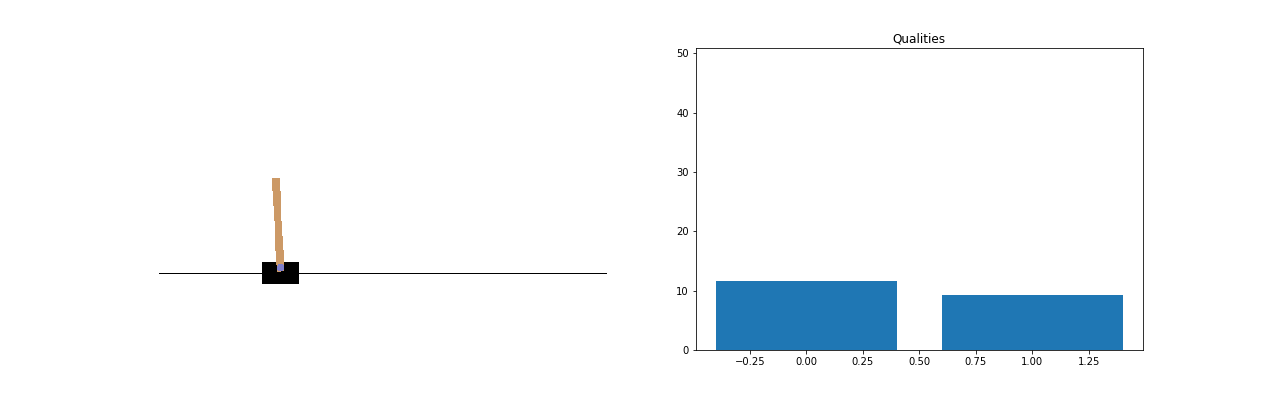
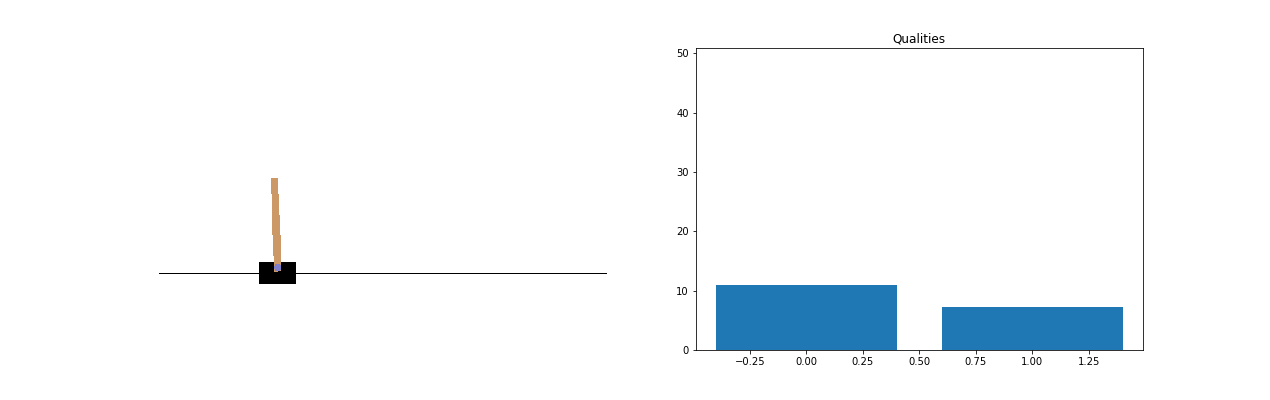
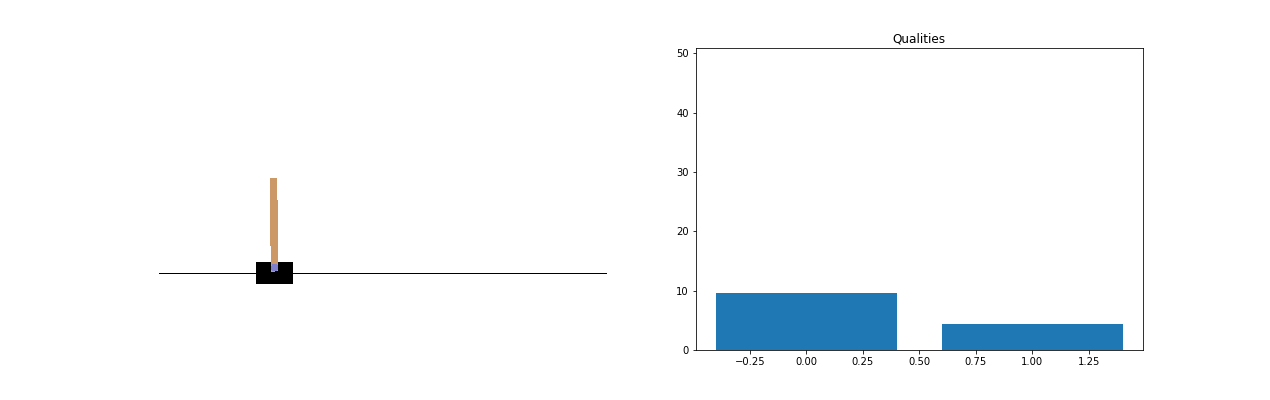
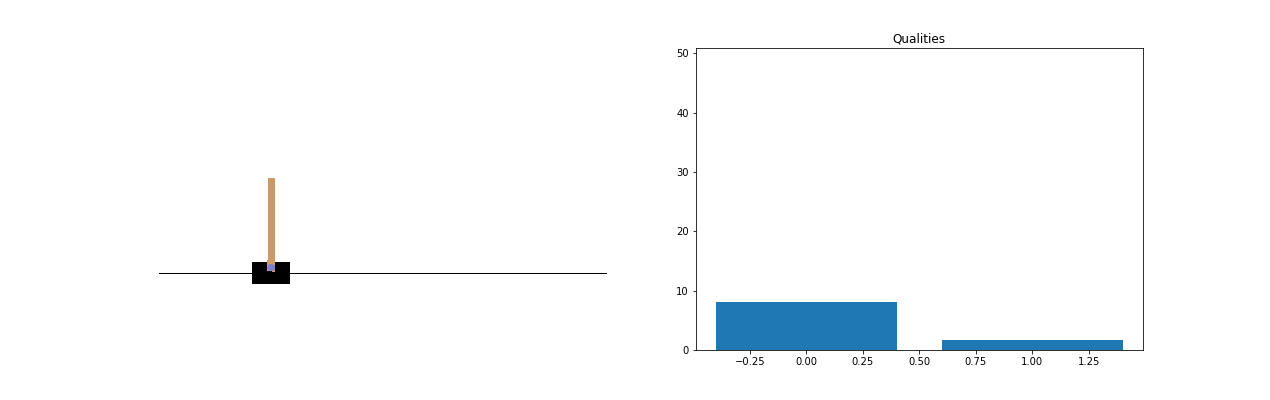
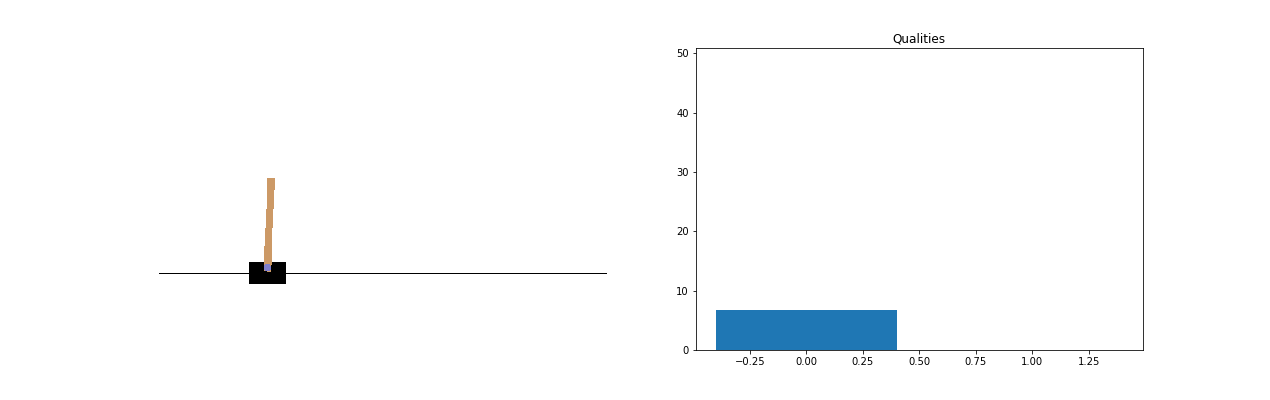
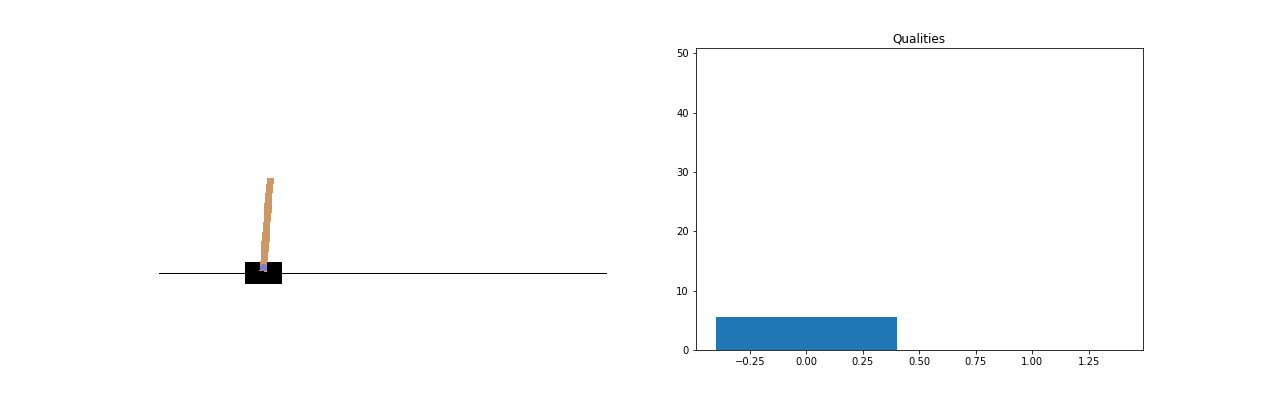
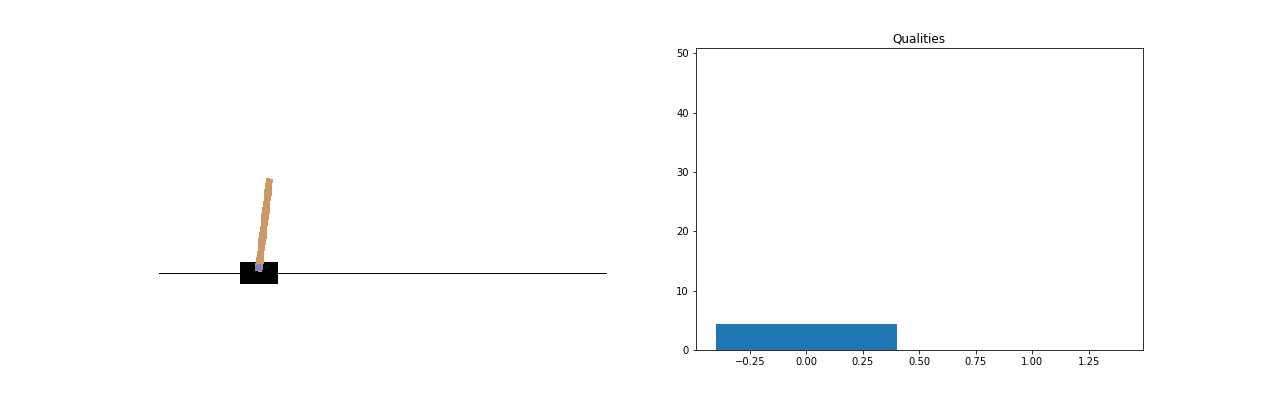
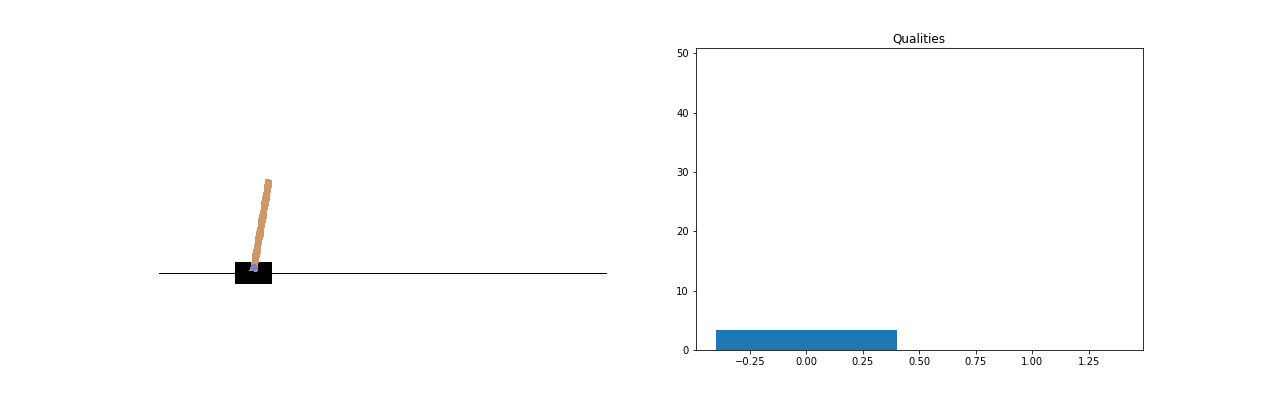

168.0

In [16]:
agent.play(record=True)

### Log and saving

While training statistics are logged. Basic agent logs rewards:

In [17]:
agent.logger["rewards"][::10]

[27.0, 13.0, 14.0, 21.0, 23.0, 200.0, 171.0]

Agent (including his logs) can be saved and loaded. The flag tells to save with all replay memory to continue learning from "same state" (except environment reseting).

In [18]:
agent.save("DQN Cartpole", save_replay_memory=True)

In [19]:
agent.load("DQN Cartpole", load_replay_memory=True)

In [20]:
agent.logger["rewards"][::10]

[27.0, 13.0, 14.0, 21.0, 23.0, 200.0, 171.0]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


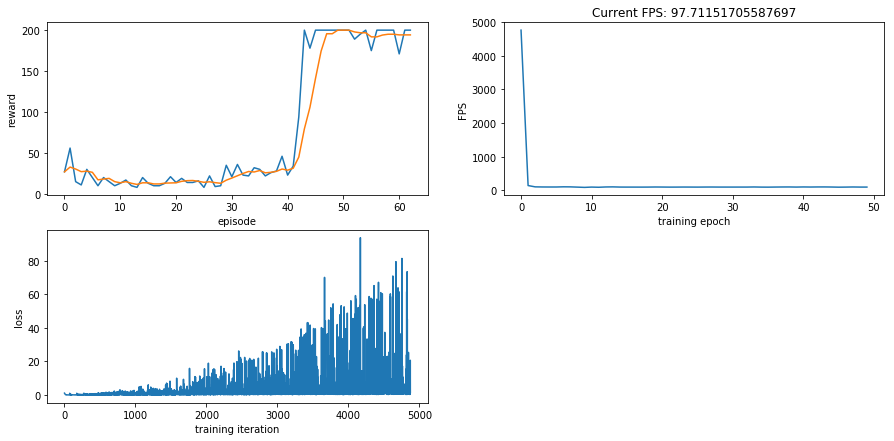

In [21]:
plot_durations(agent, 5)    

# Rainbow: all blended in one!
[with $\varepsilon$-greedy just for fun]

In [25]:
config = {
    "env": env,
    "Qnetwork_FeatureExtractor": BasicNetwork,
    "QnetworkHead": DuelingCategoricalQnetwork,
    "Qnetwork_linear": NoisyLinear(),
    "target_update": 100,
    "batch_size": 32,
    "gamma": 0.99,
    "replay_buffer_nsteps": 2,
    "replay_buffer_init": 128,
    "replay_buffer_capacity": 100000,
    "epsilon_start": 1,
    "epsilon_final": 0.001,
    "epsilon_decay": 500,
    "rp_alpha": 0.6, "rp_beta_start": 0.4, "rp_beta_frames": 100,
    "Vmin": -10, "Vmax": 10, "num_atoms": 51
}

In [26]:
agent = eGreedy(DoubleQAgent(CategoricalQAgent(NstepReplay(PrioritizedBufferAgent))))(config)

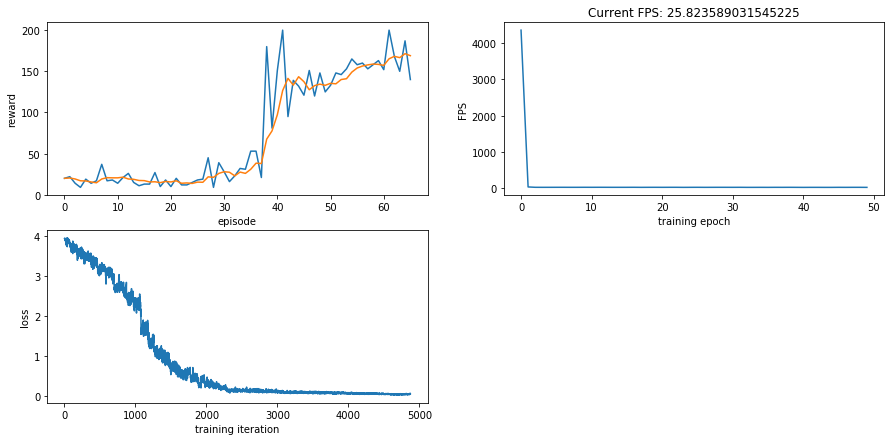

Complete
Wall time: 3min 11s


In [27]:
%%time
for i in range(50):
    agent.learn(100)
    plot_durations(agent, means_window=5)    

print('Complete')
plt.show()


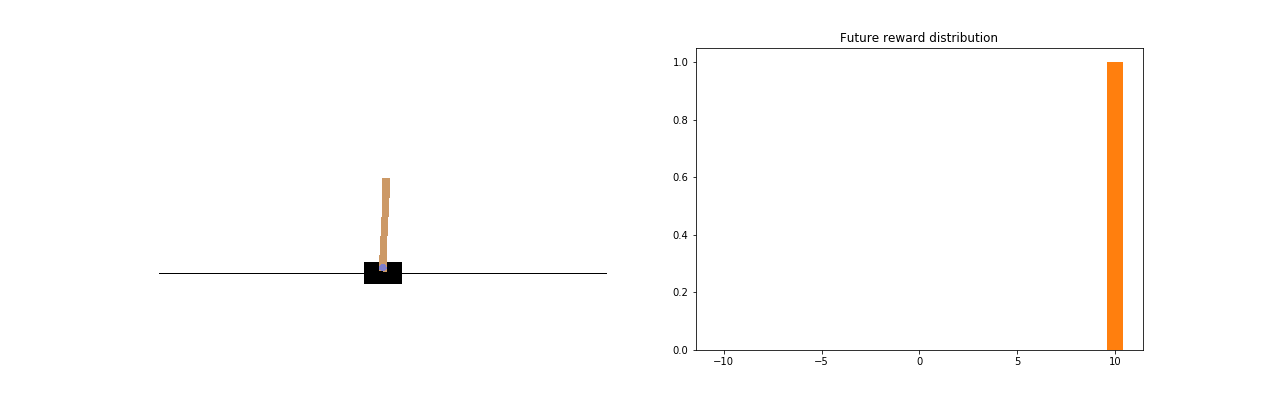
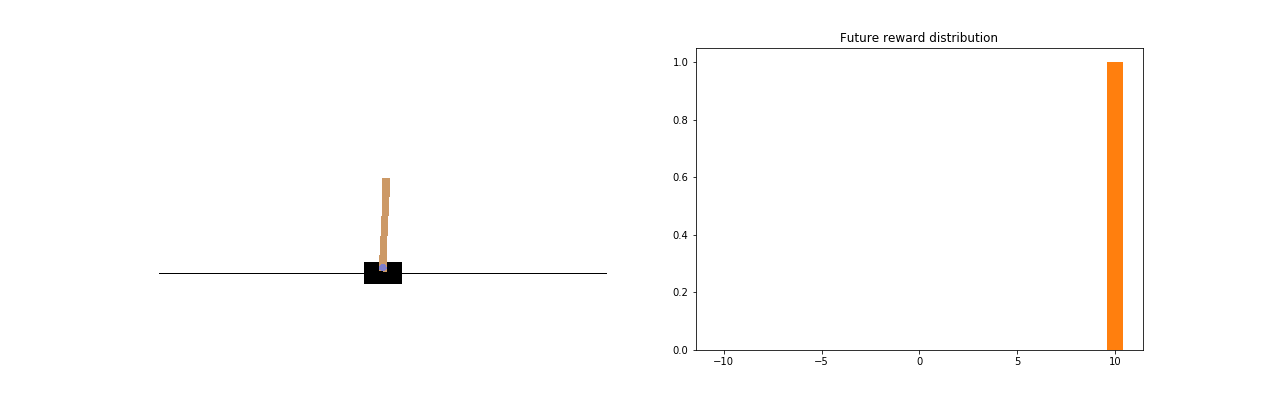
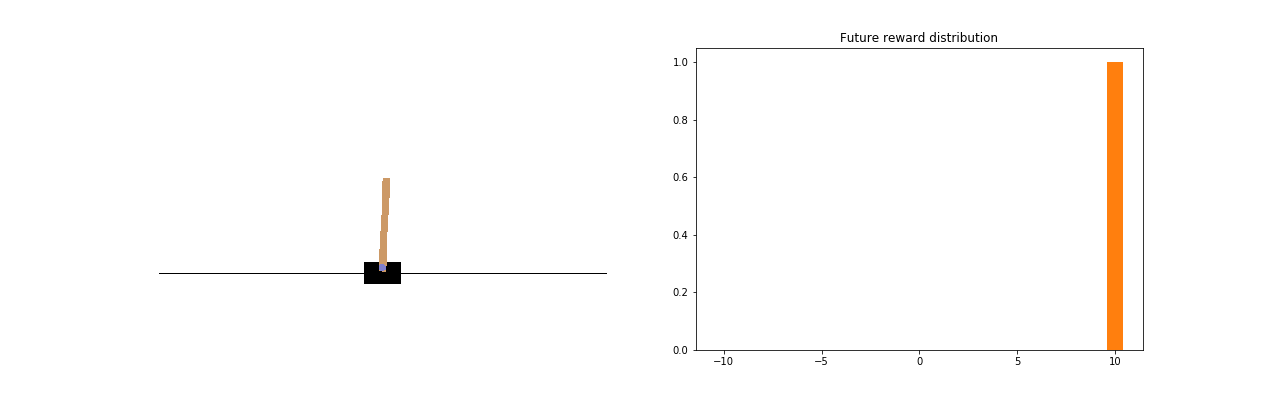
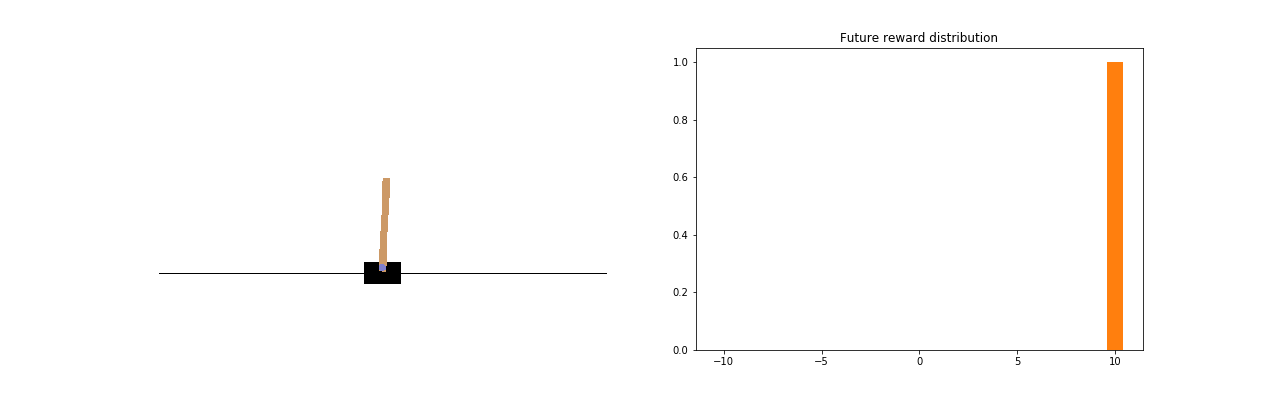
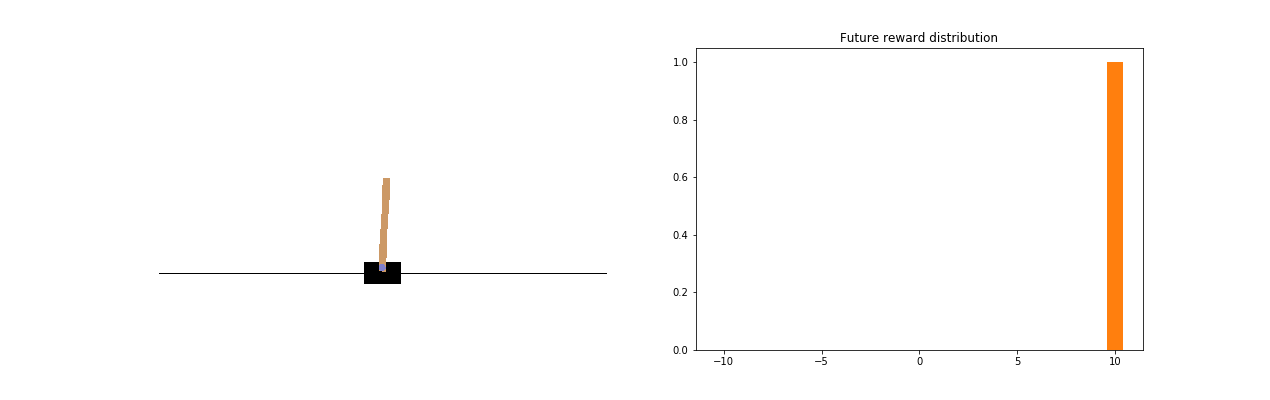
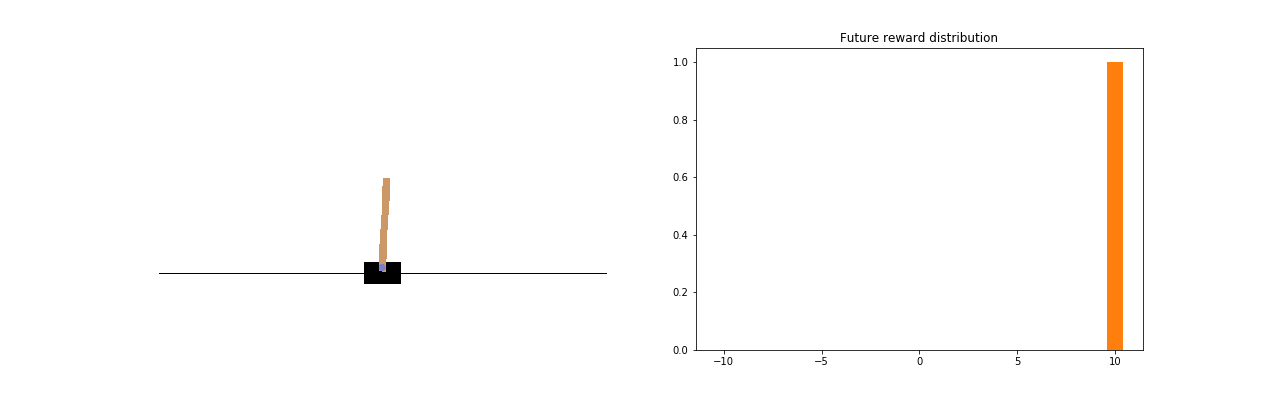
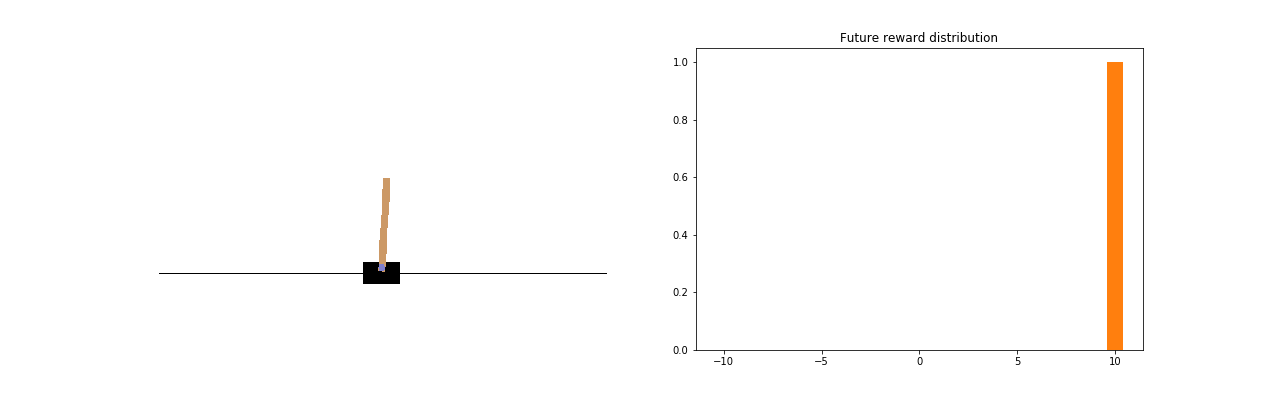
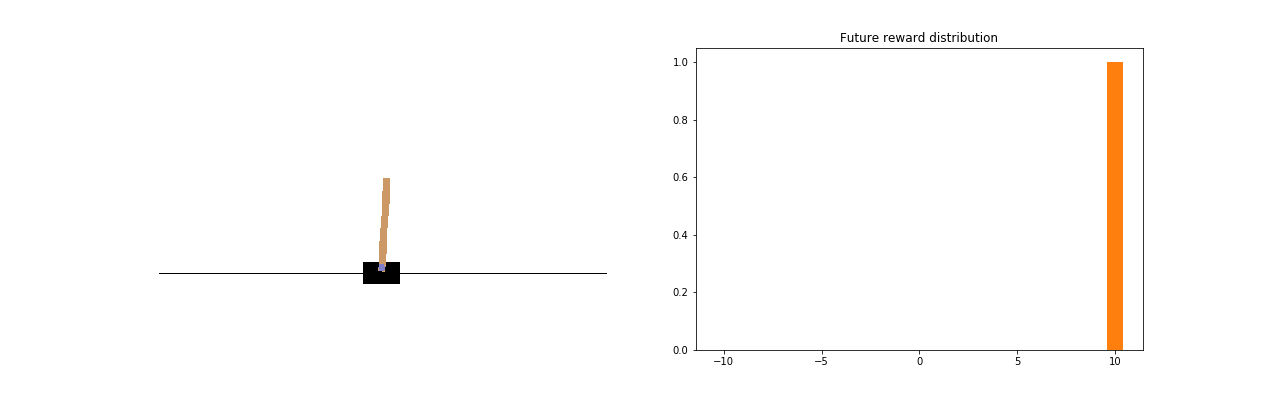
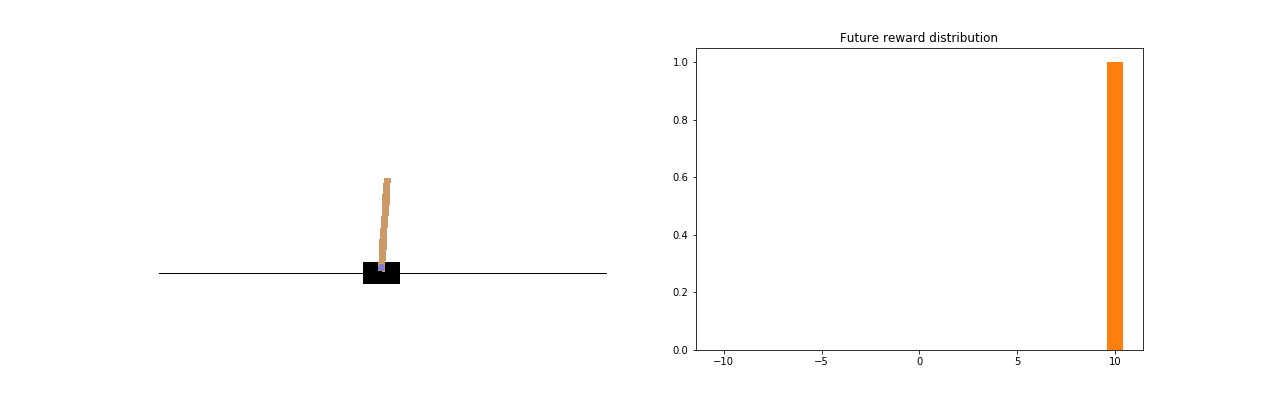
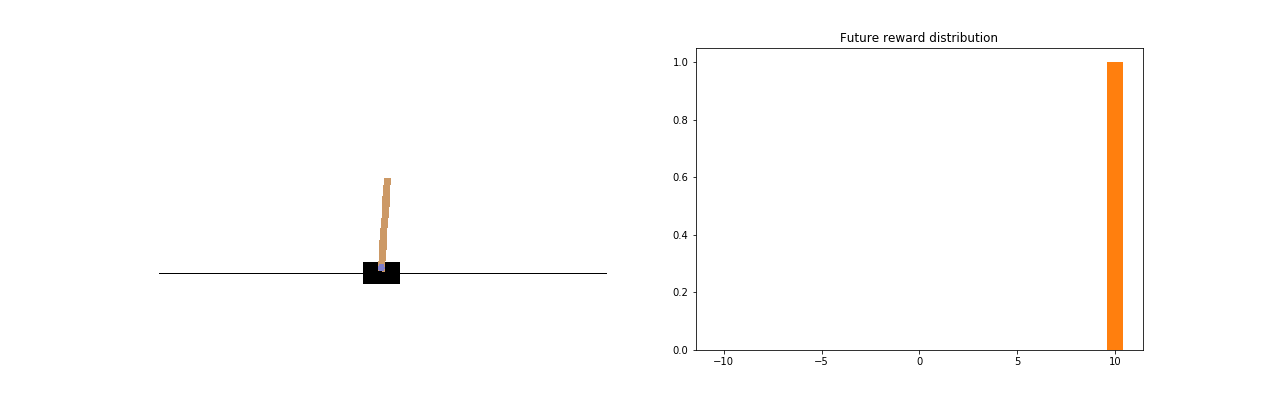
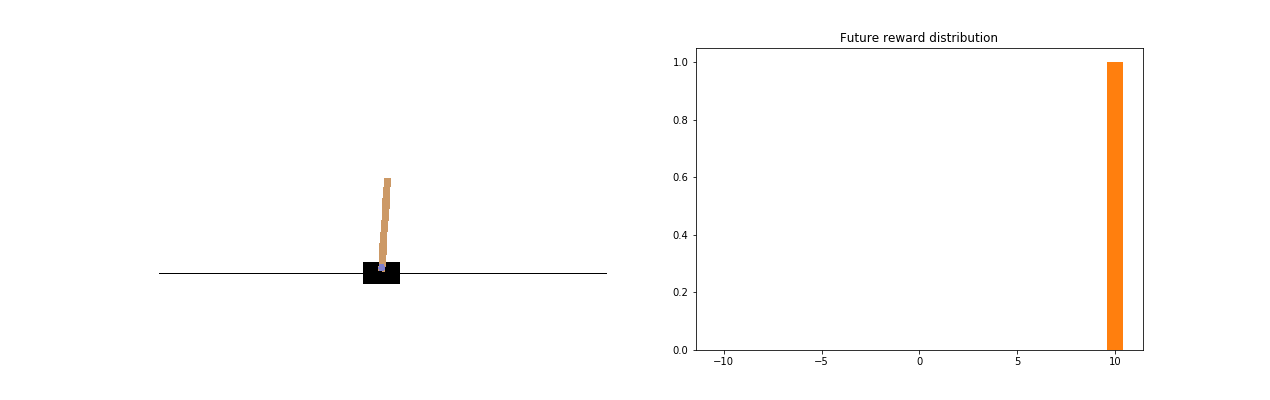
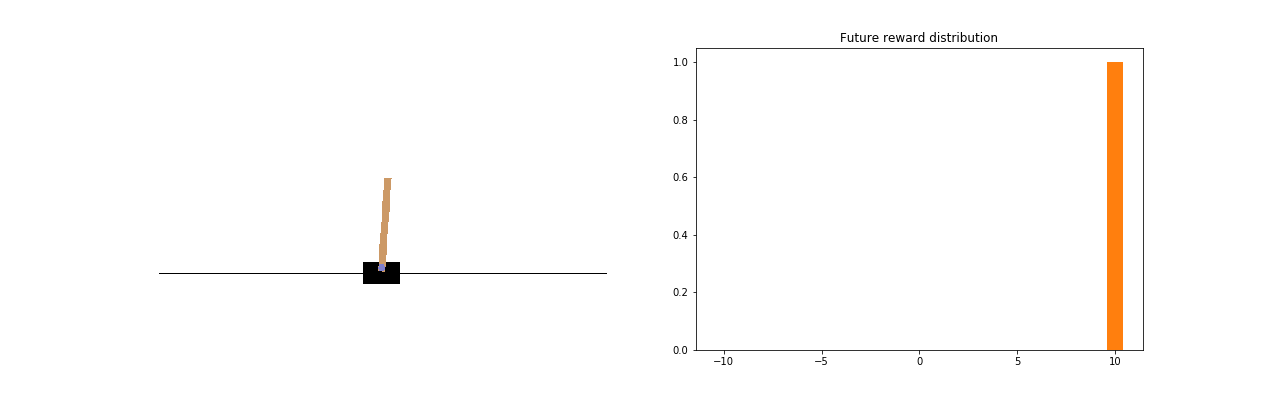
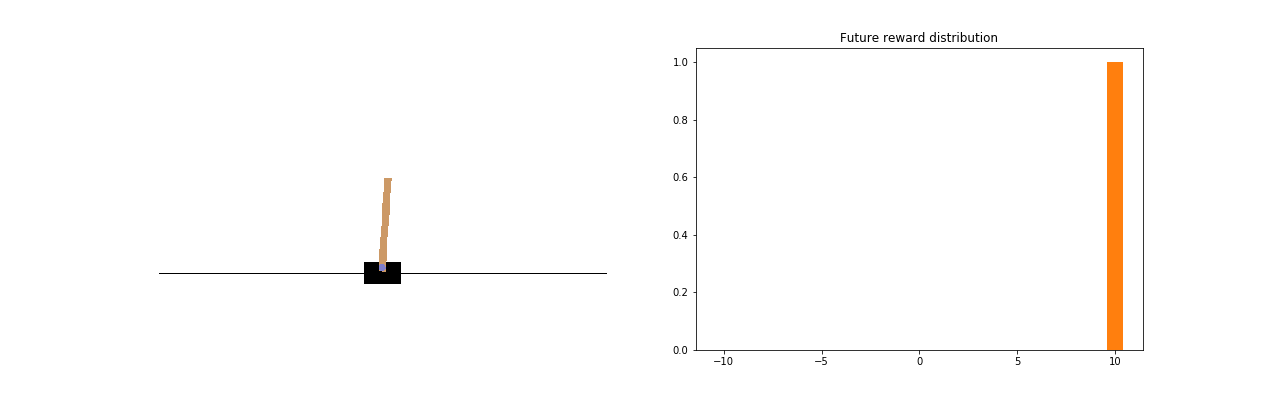
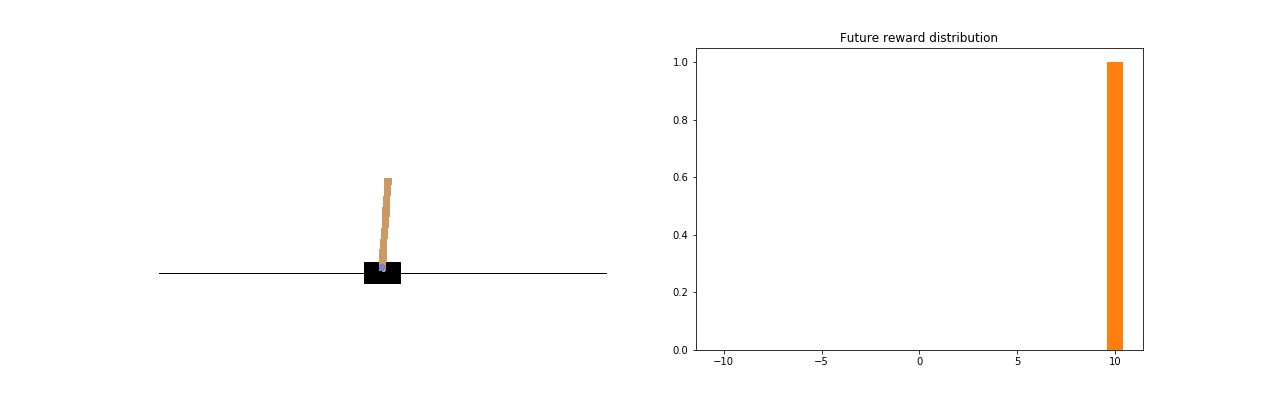
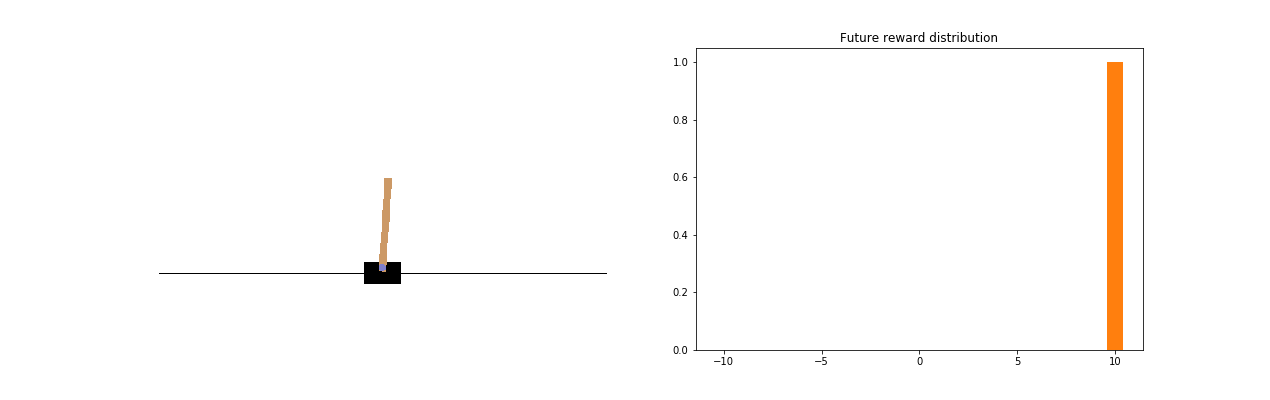
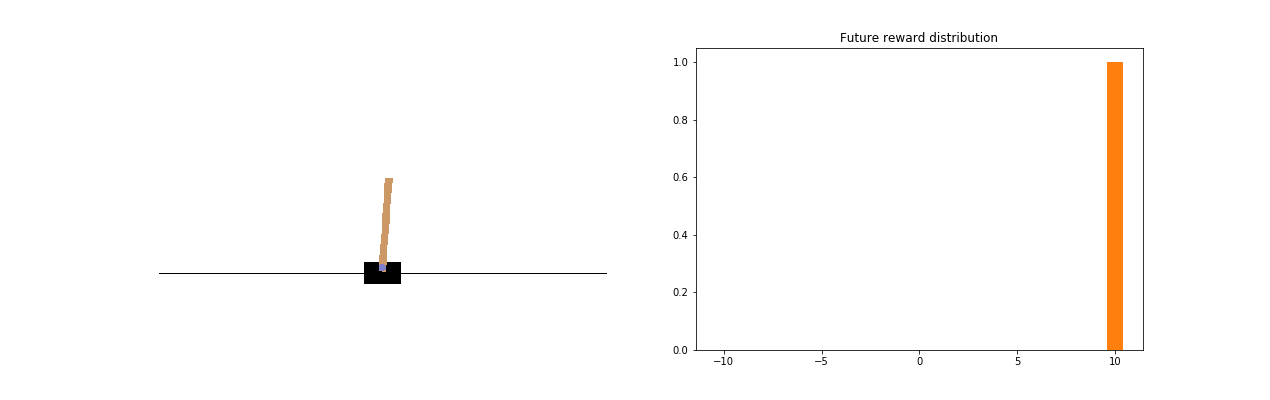
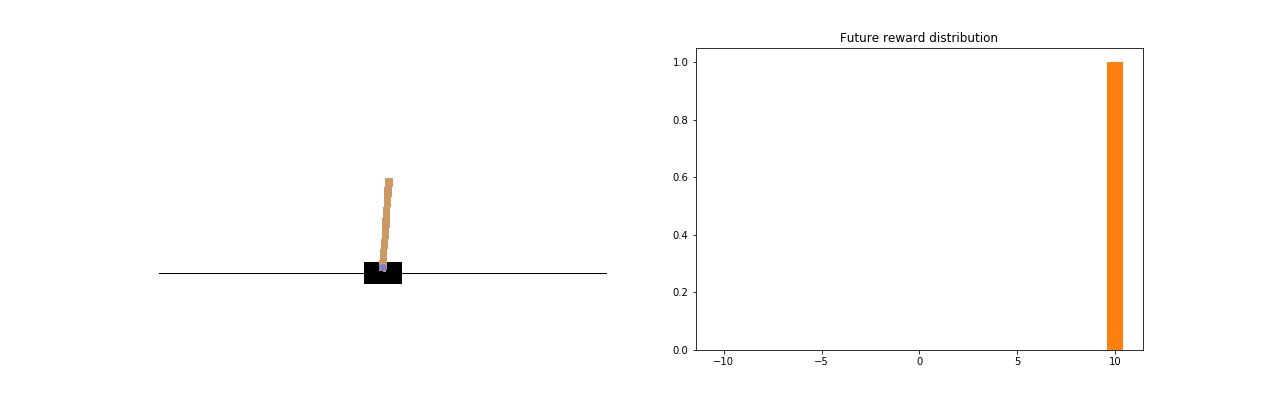
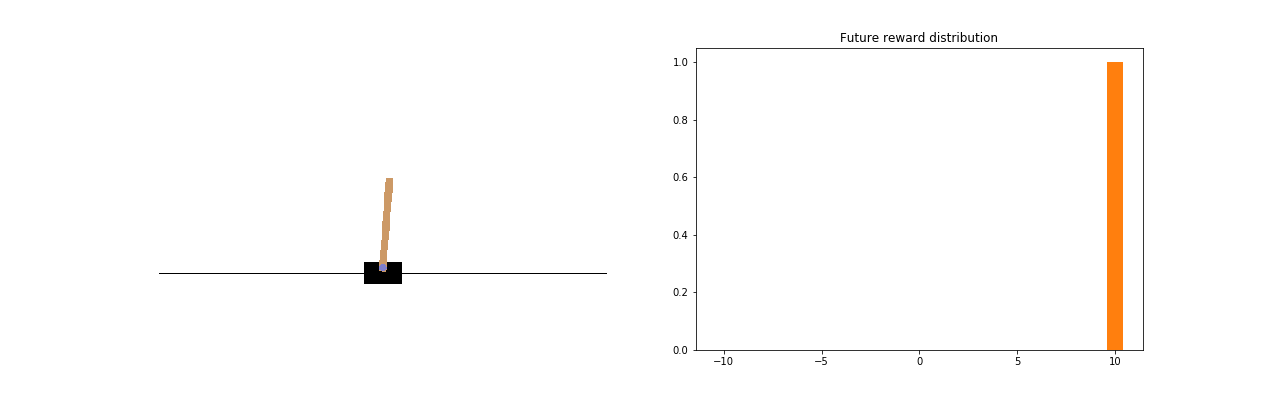
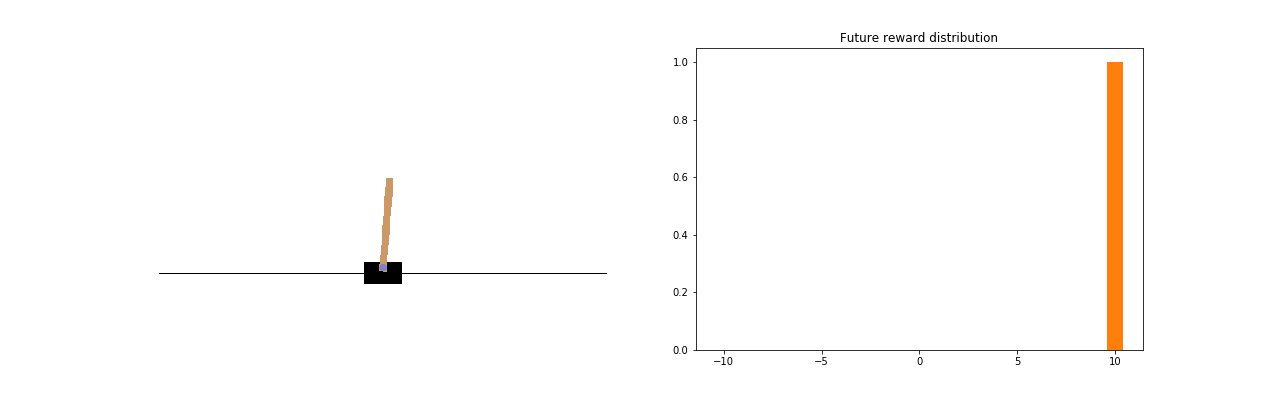
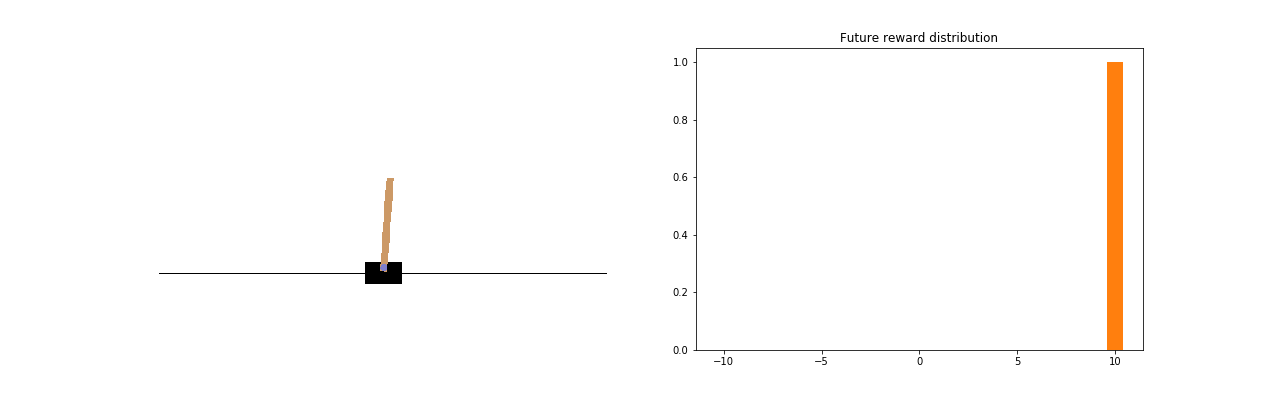
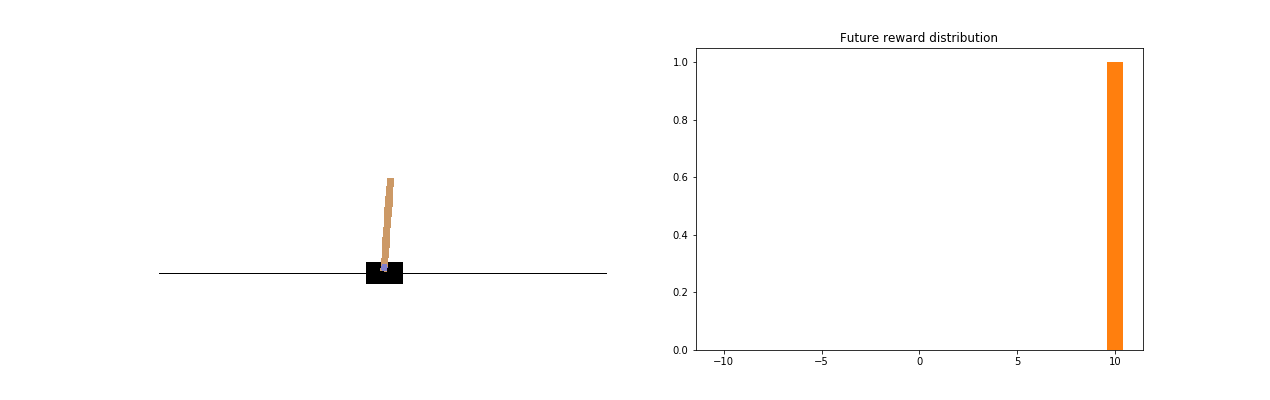
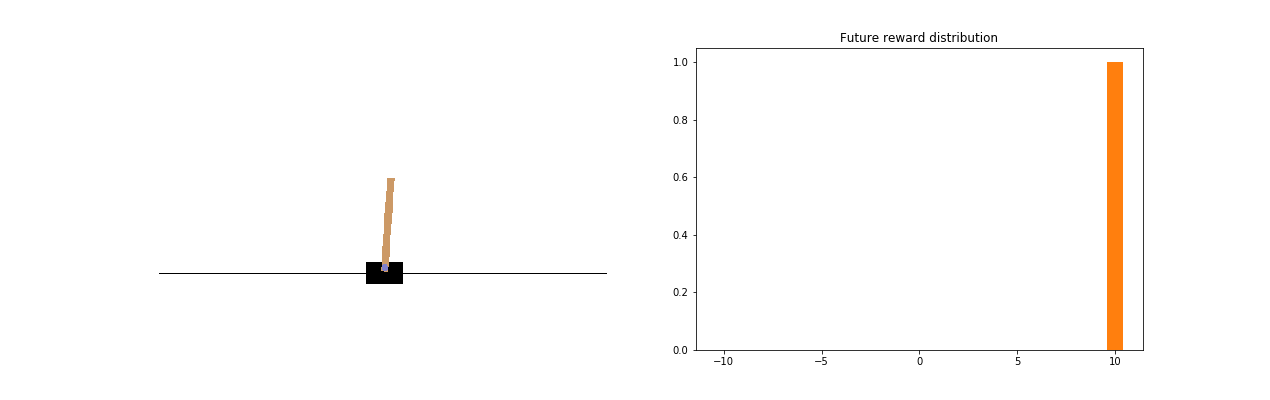
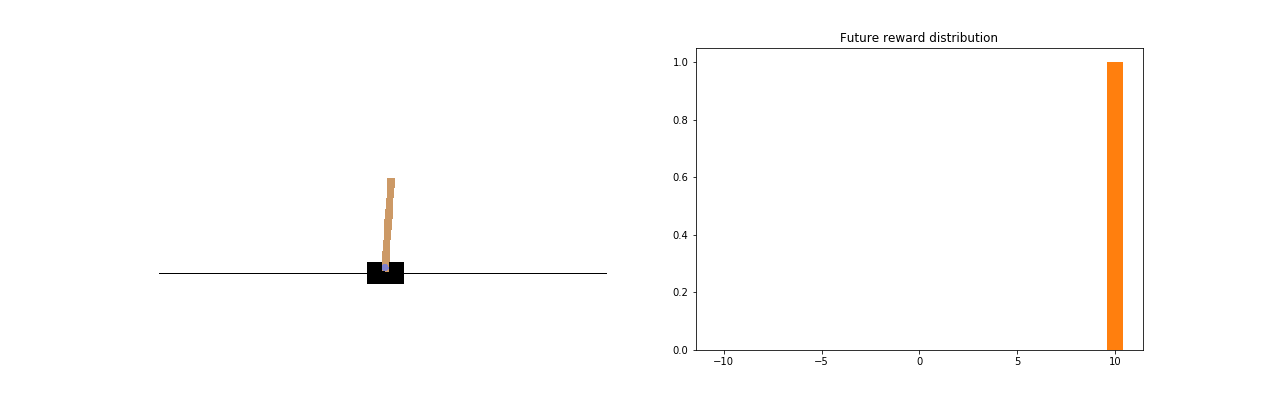
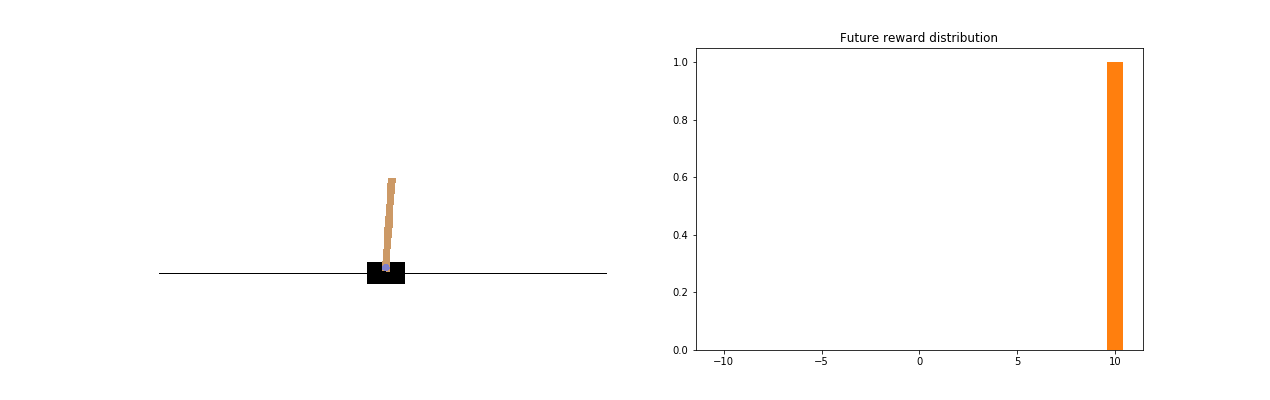
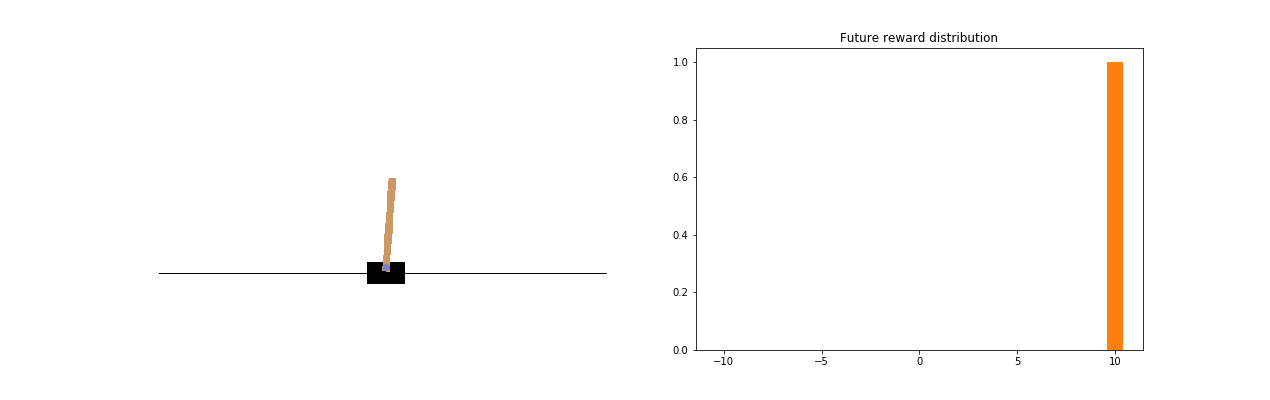
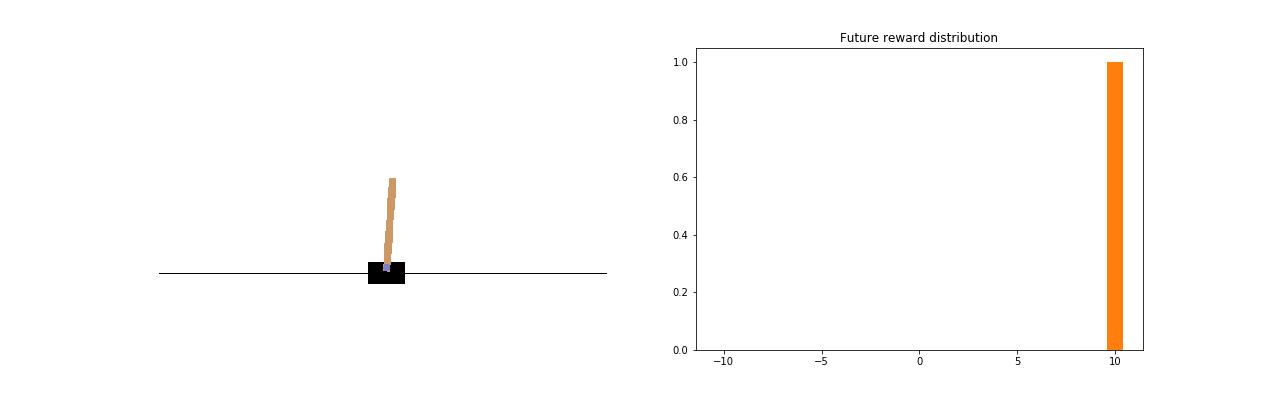
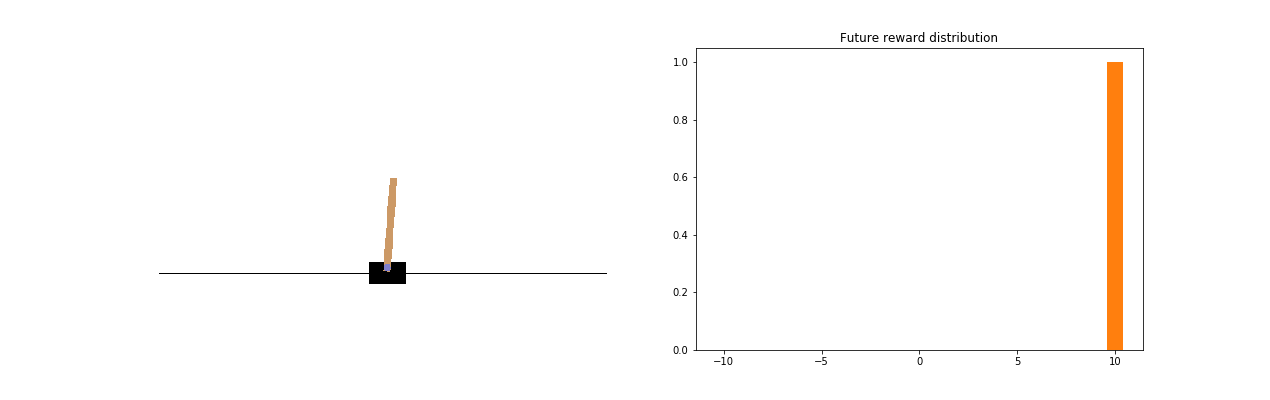
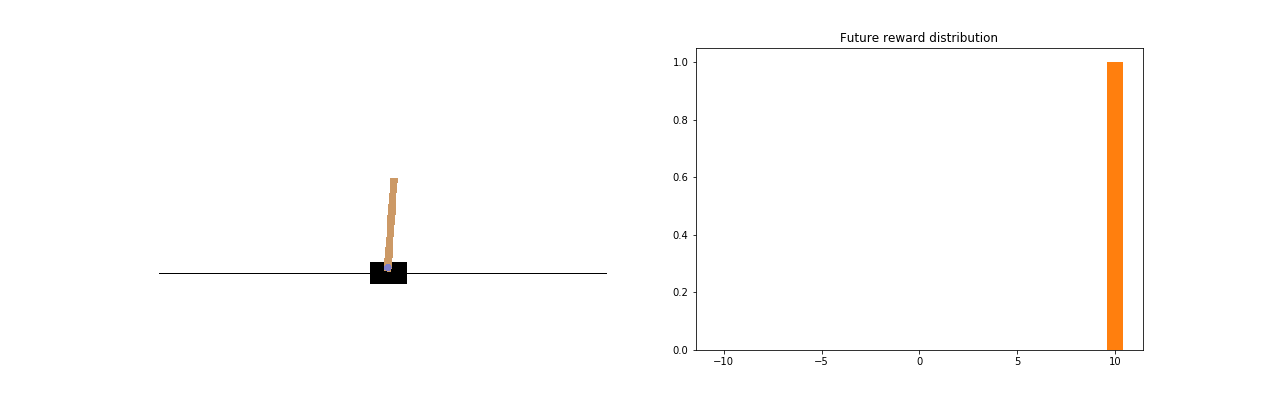
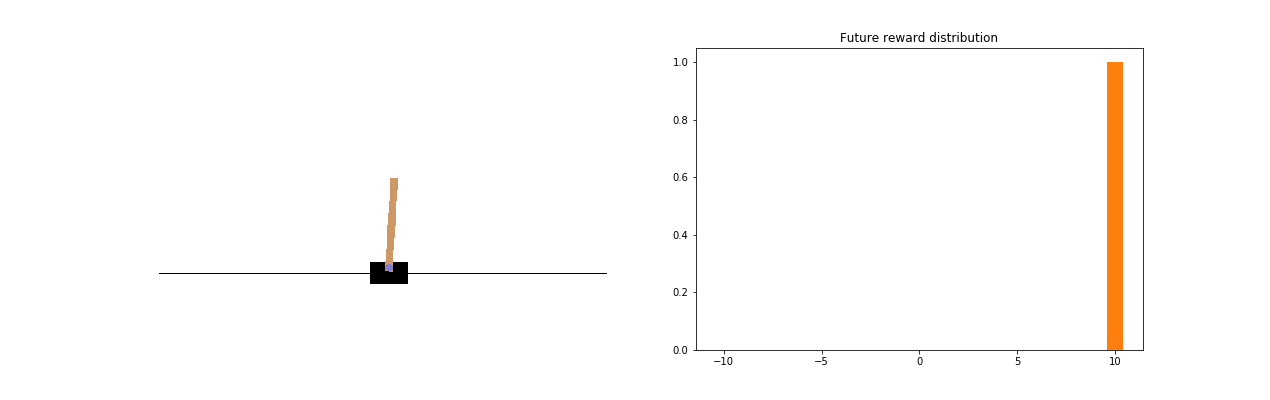
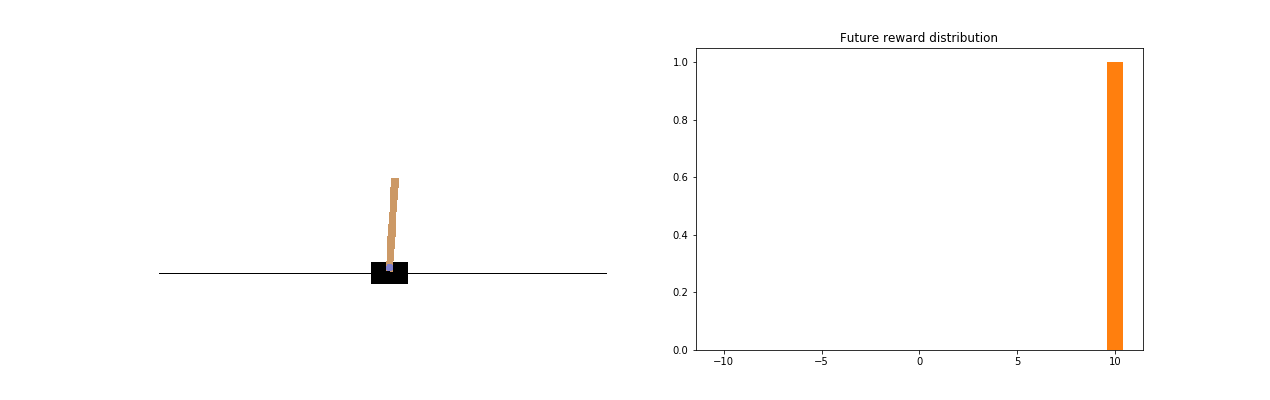
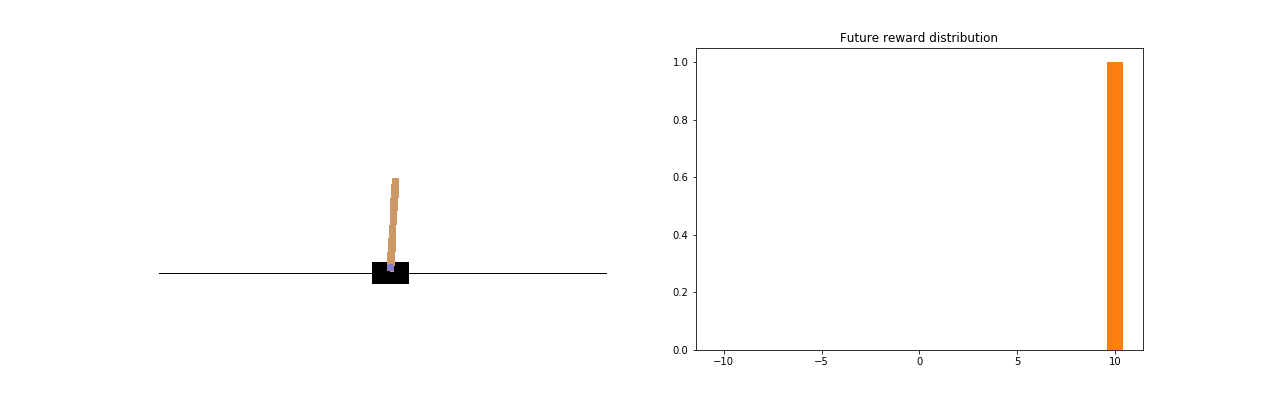
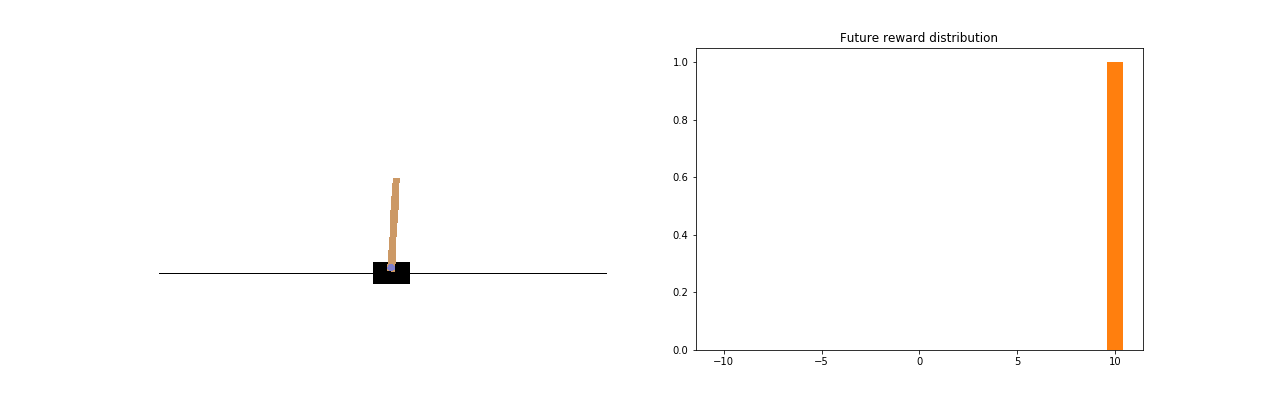
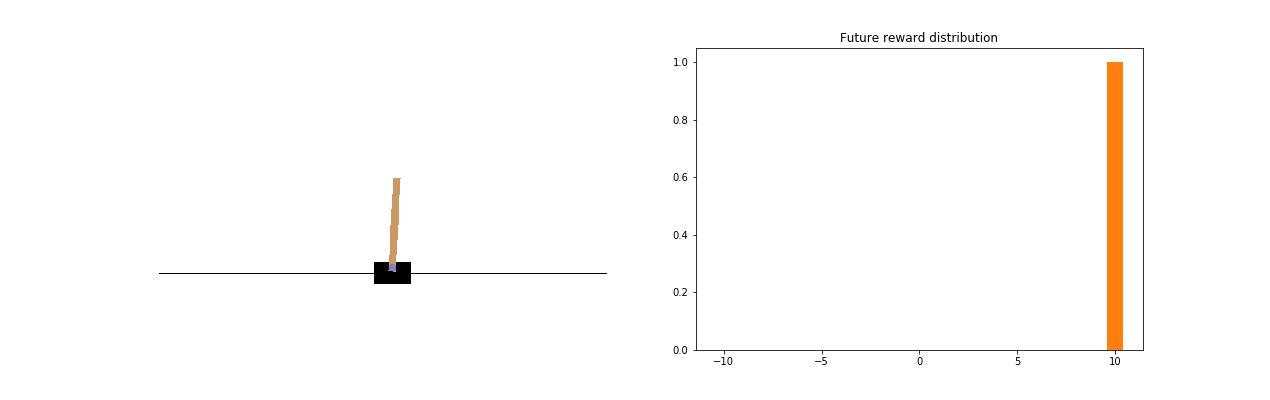
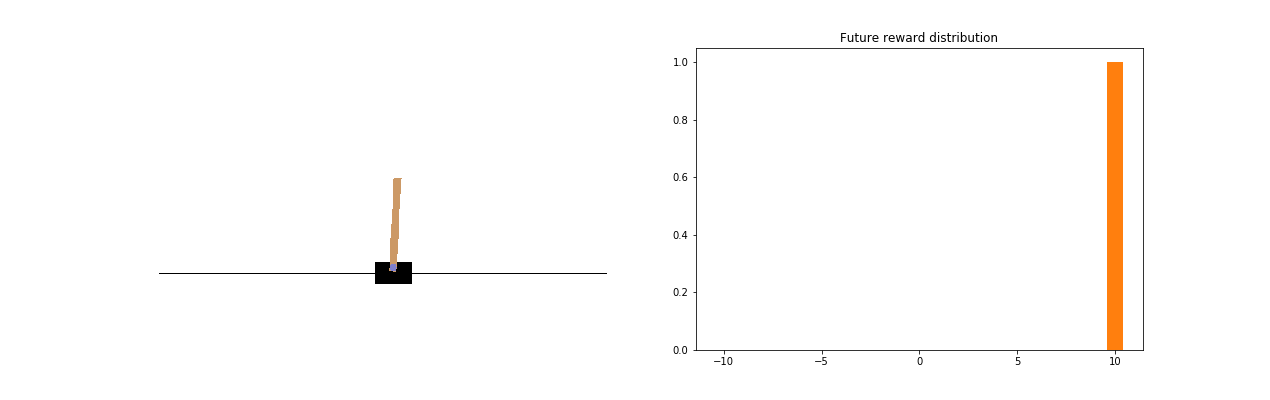
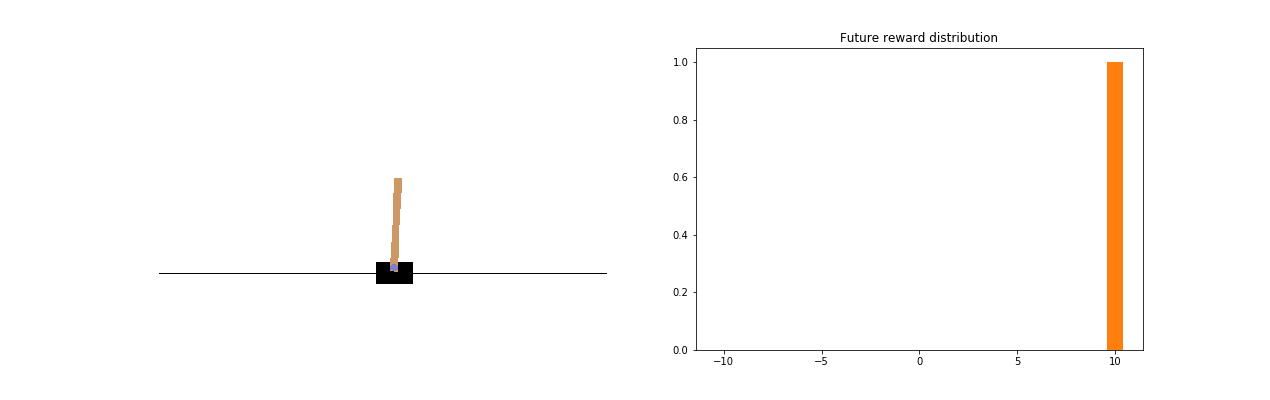
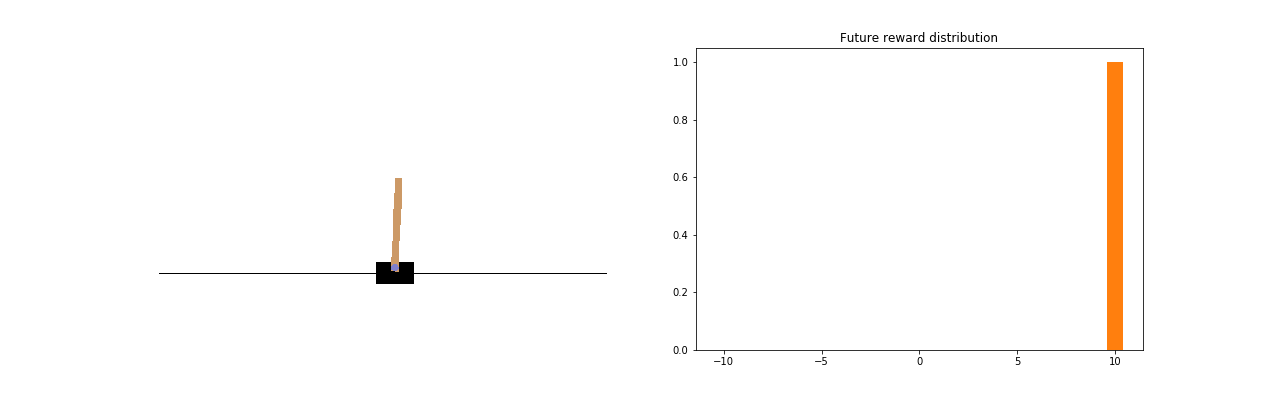
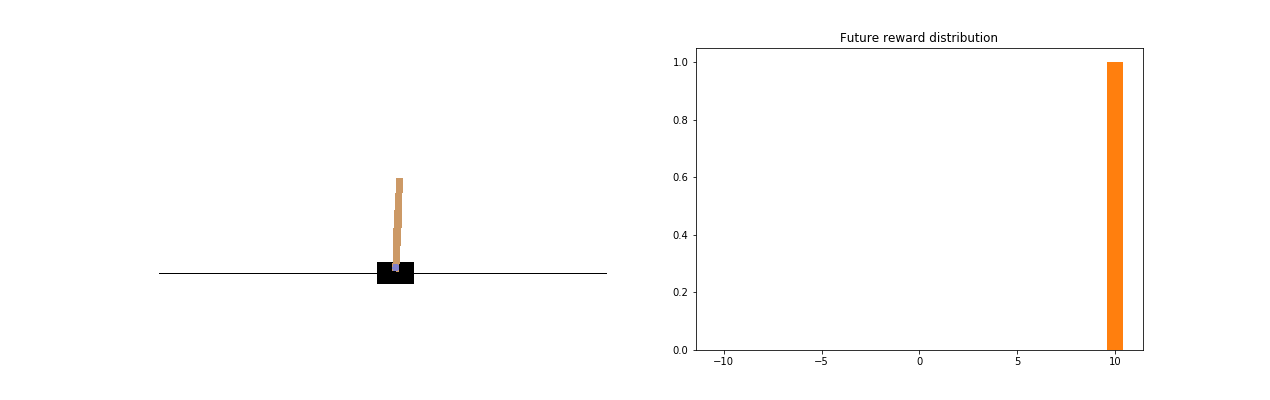
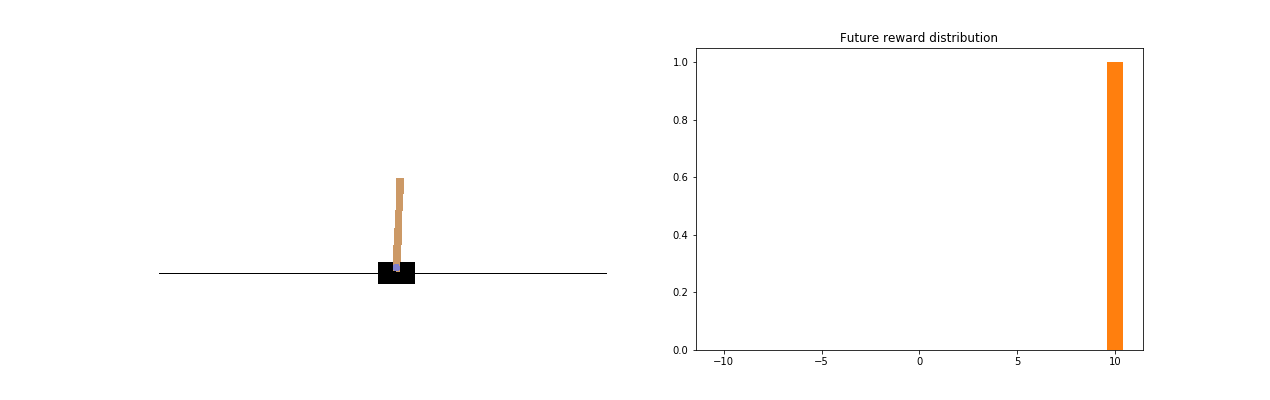
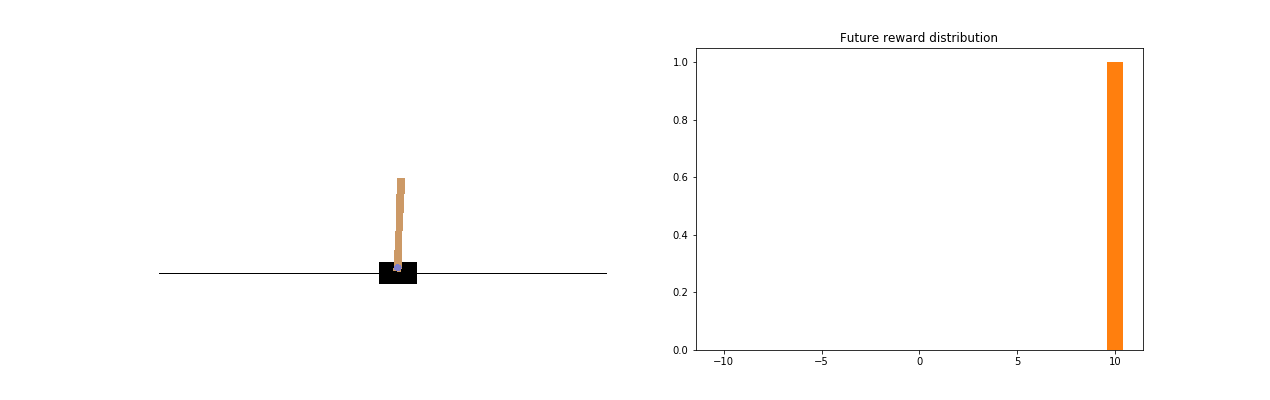
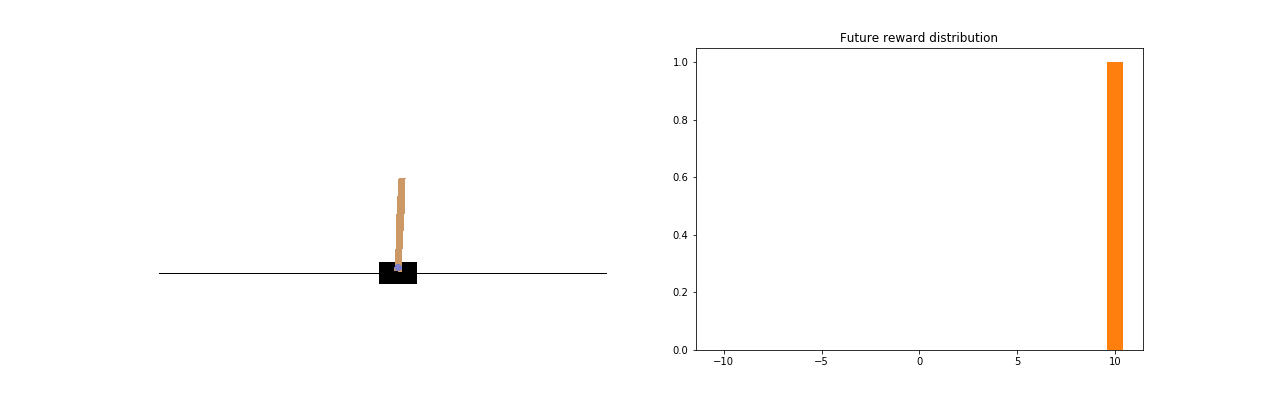
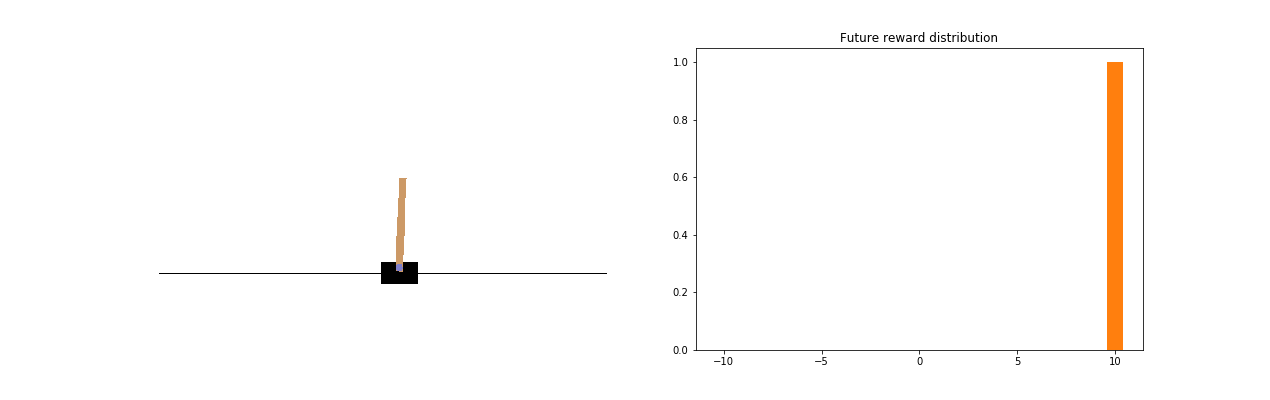
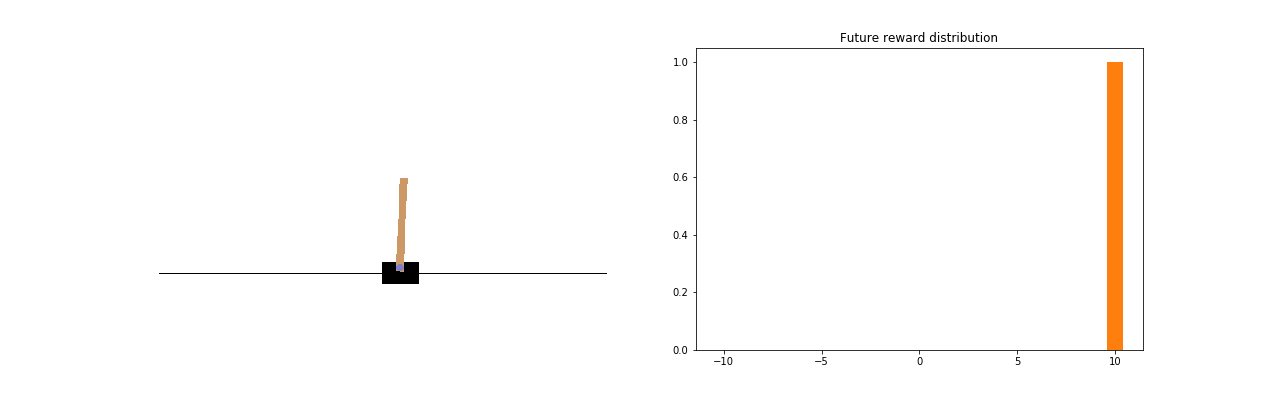
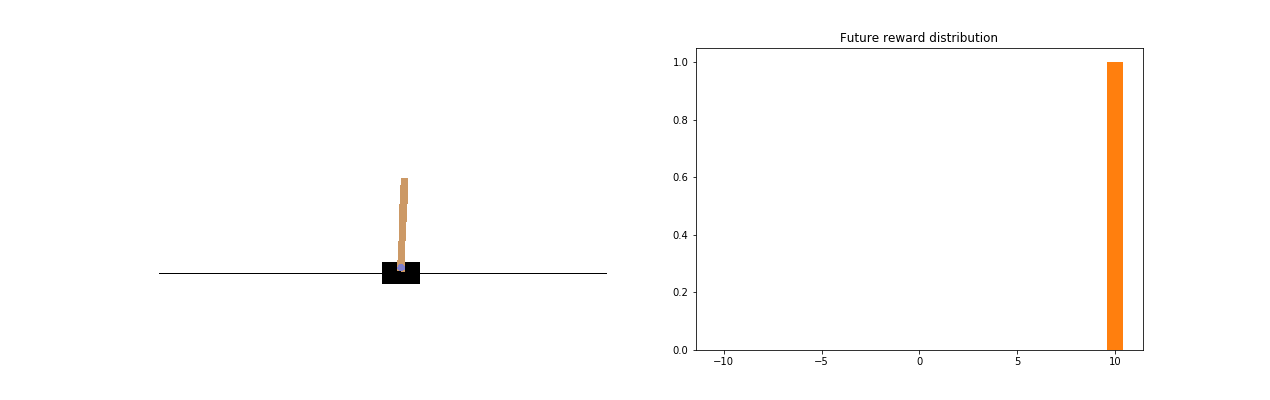
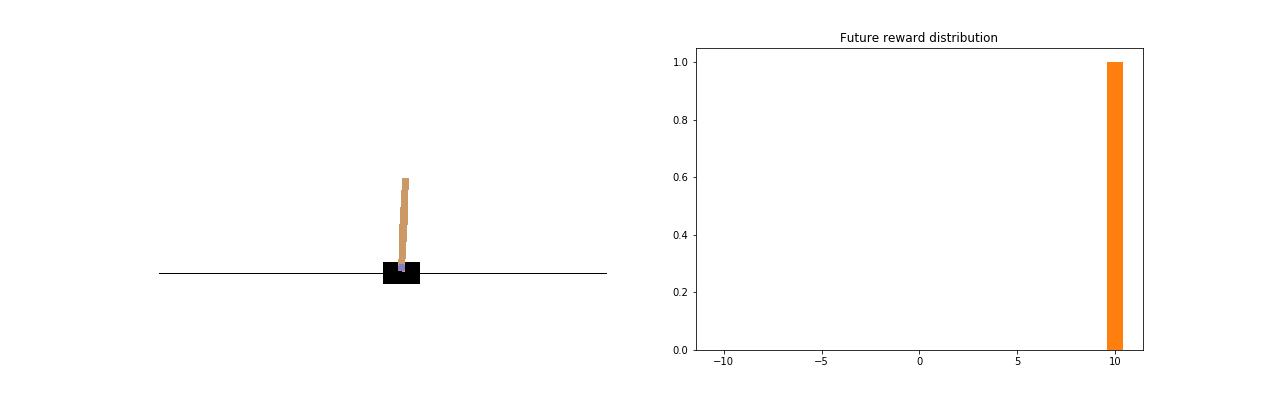
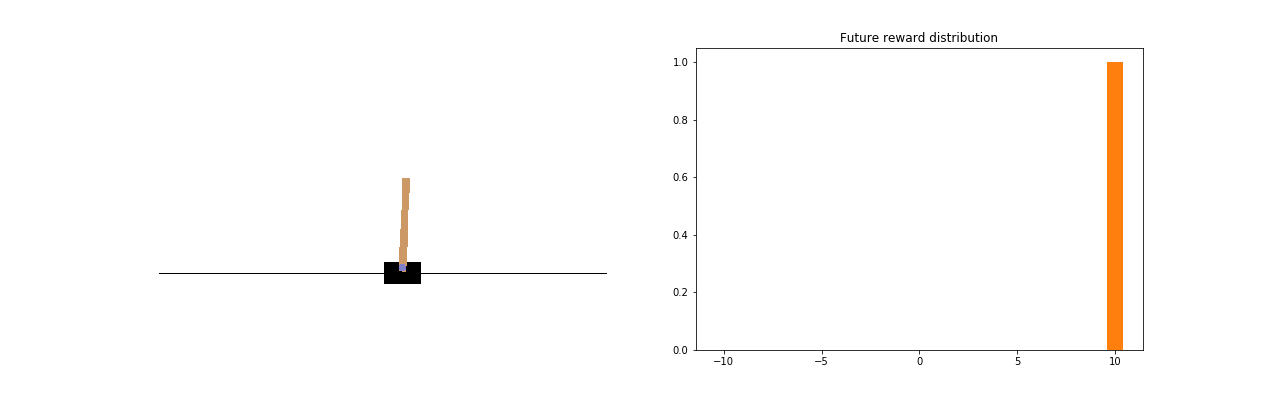
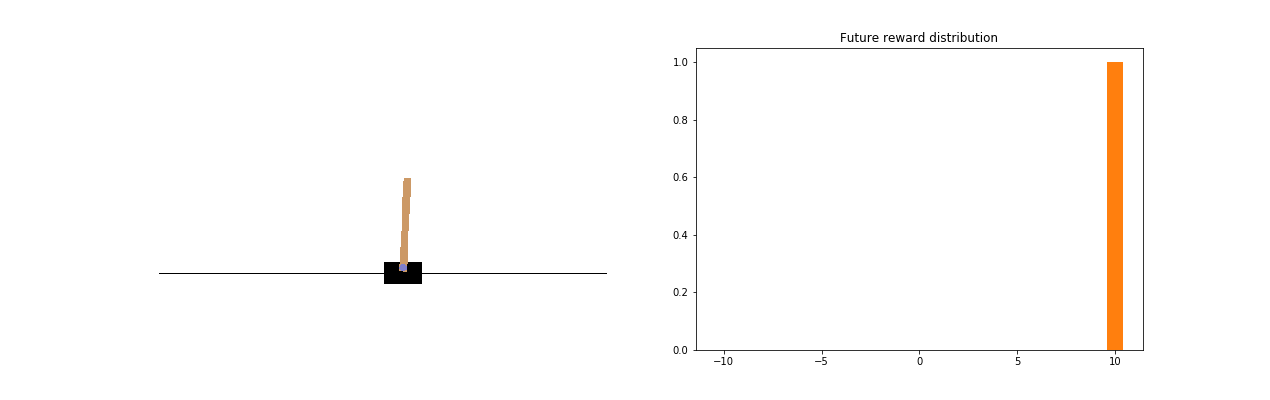
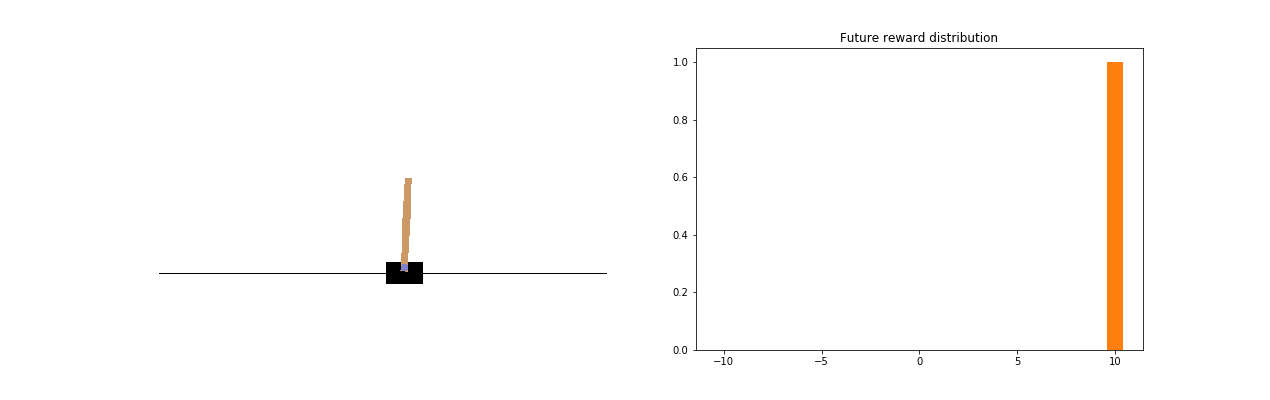
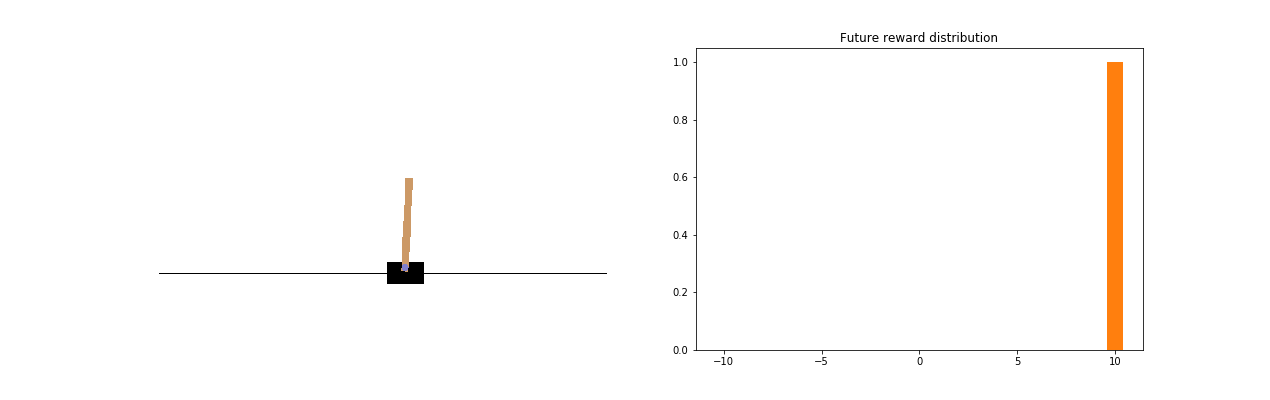
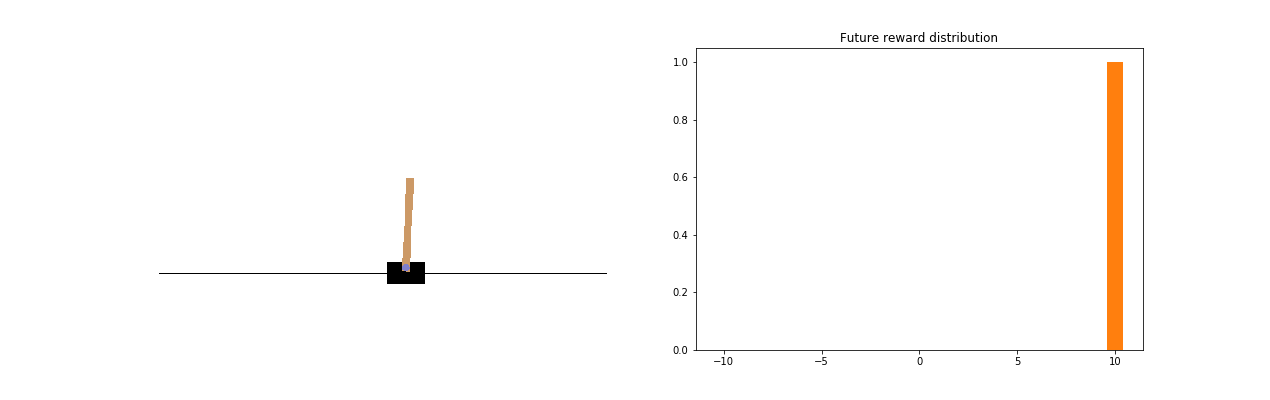
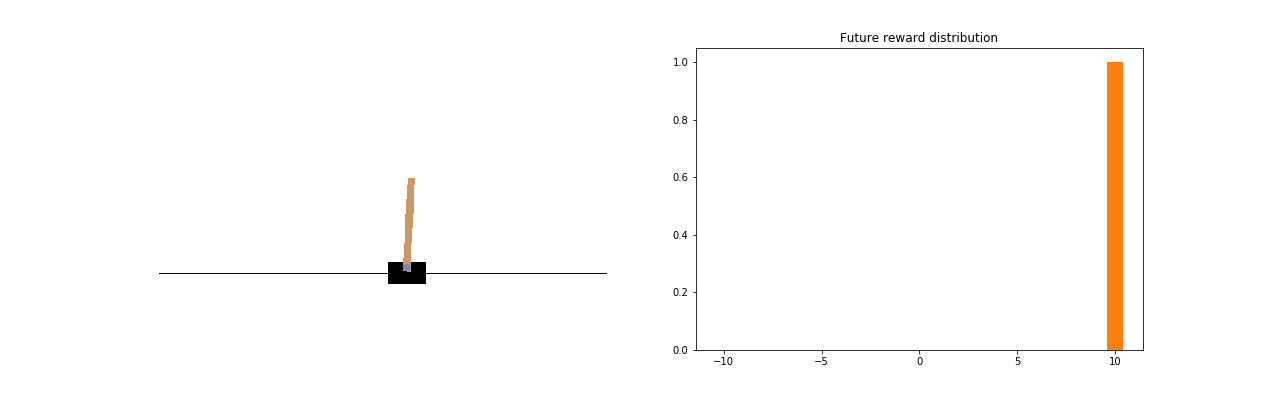
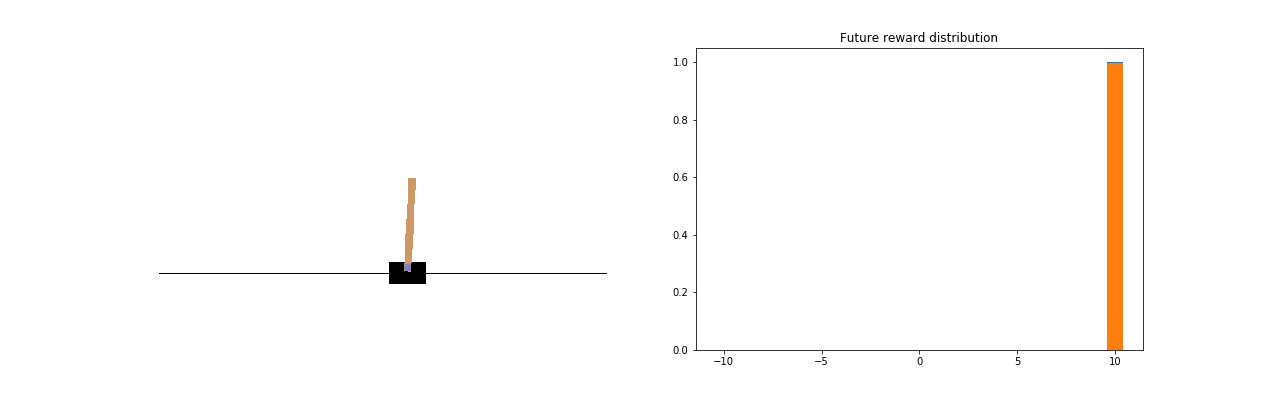
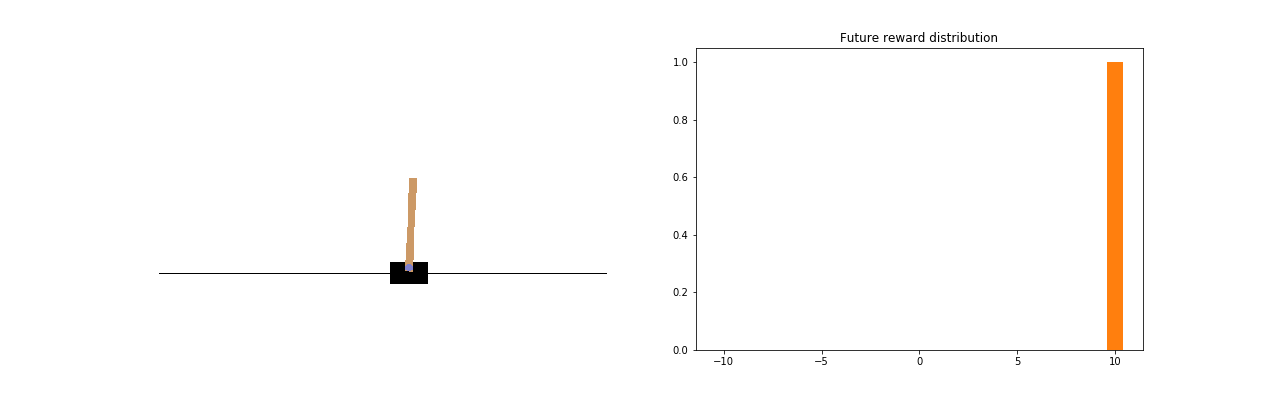
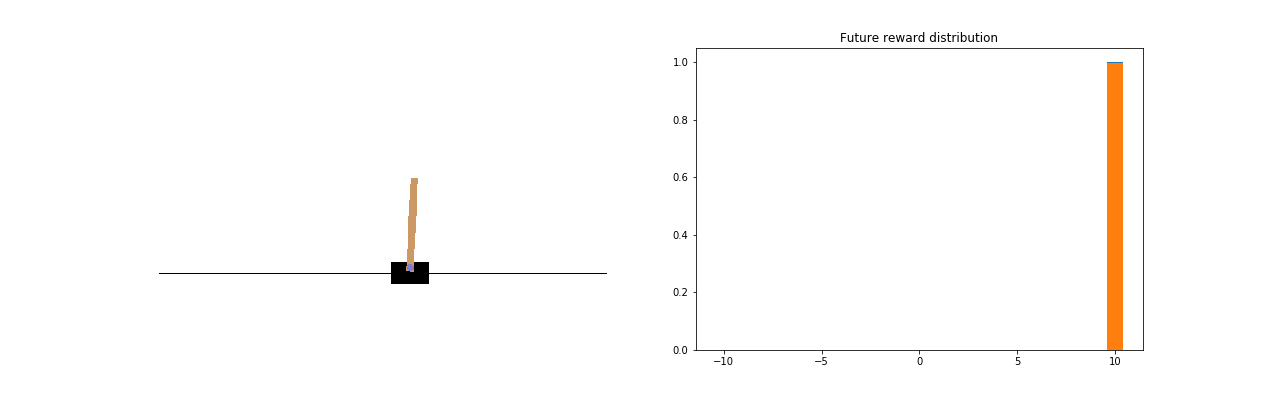
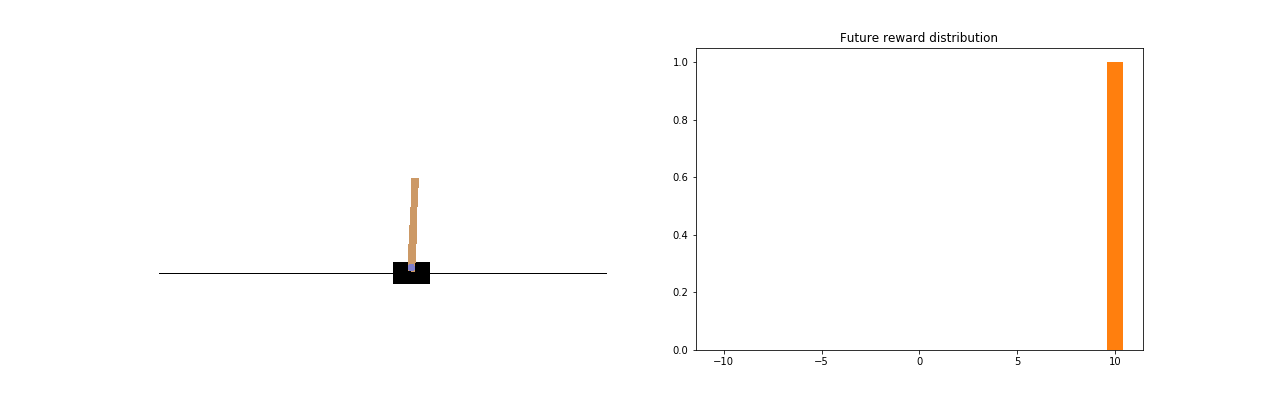
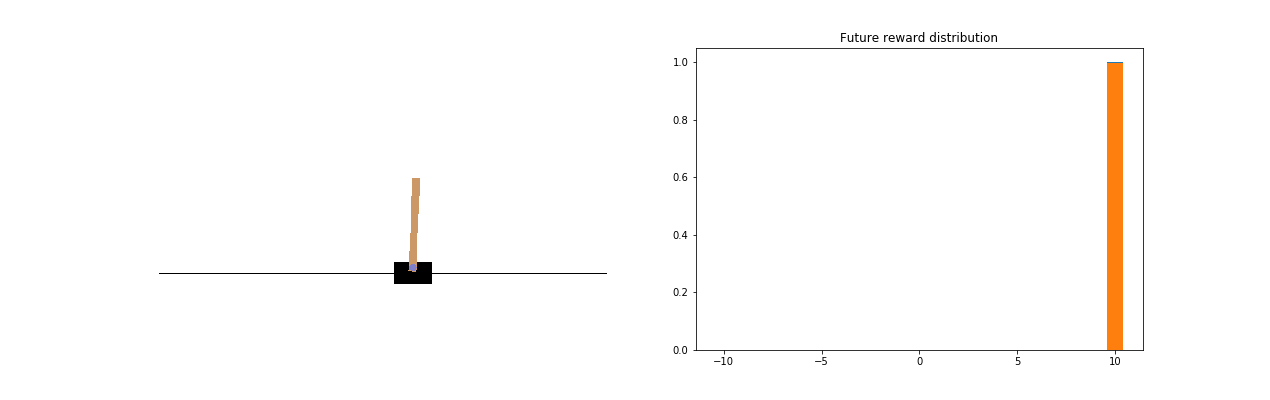
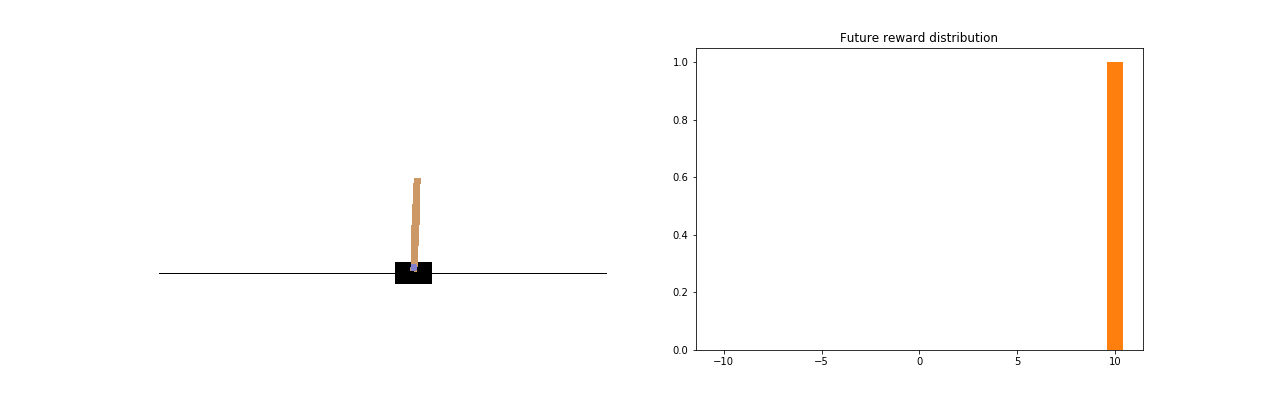
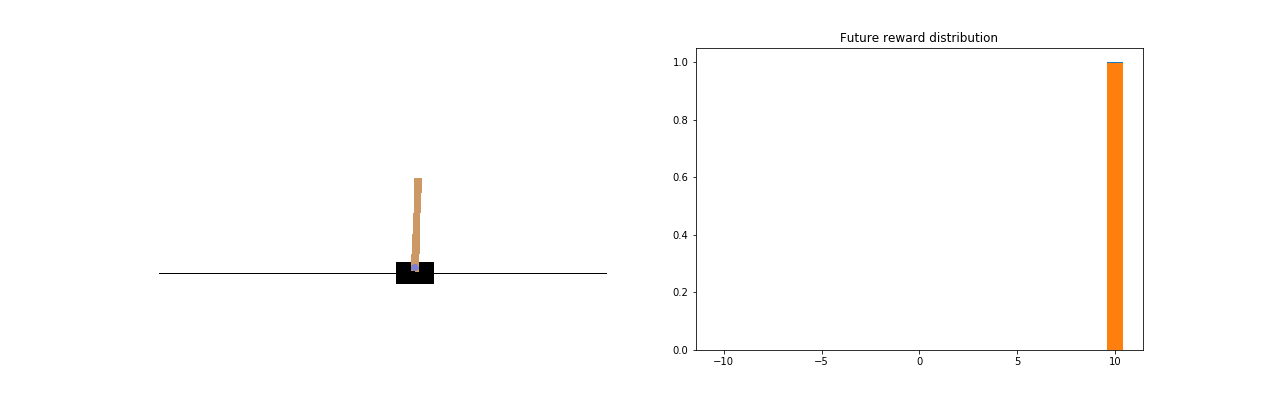
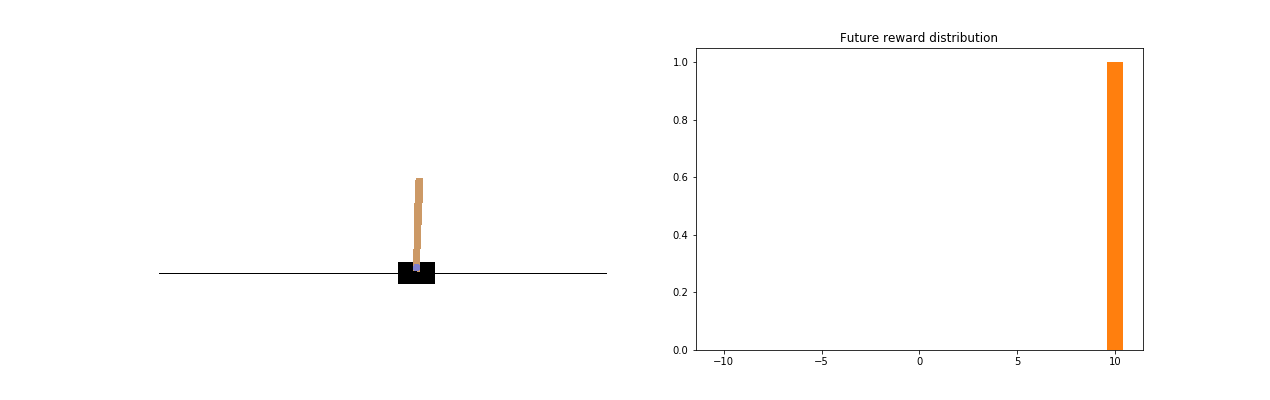
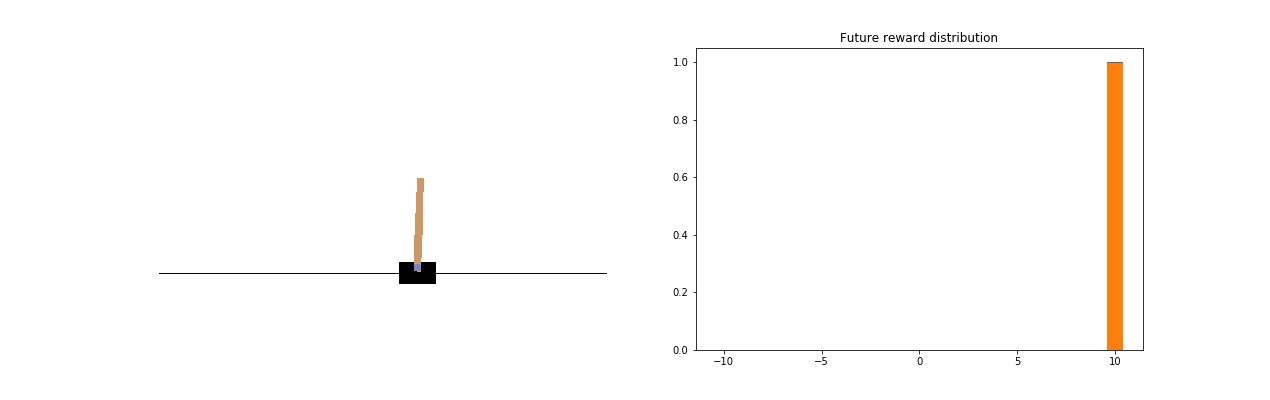
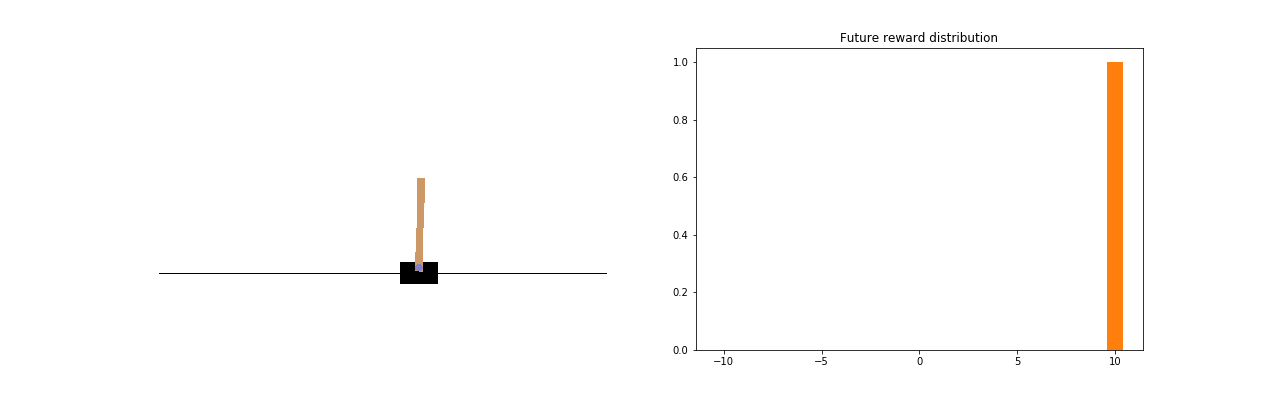
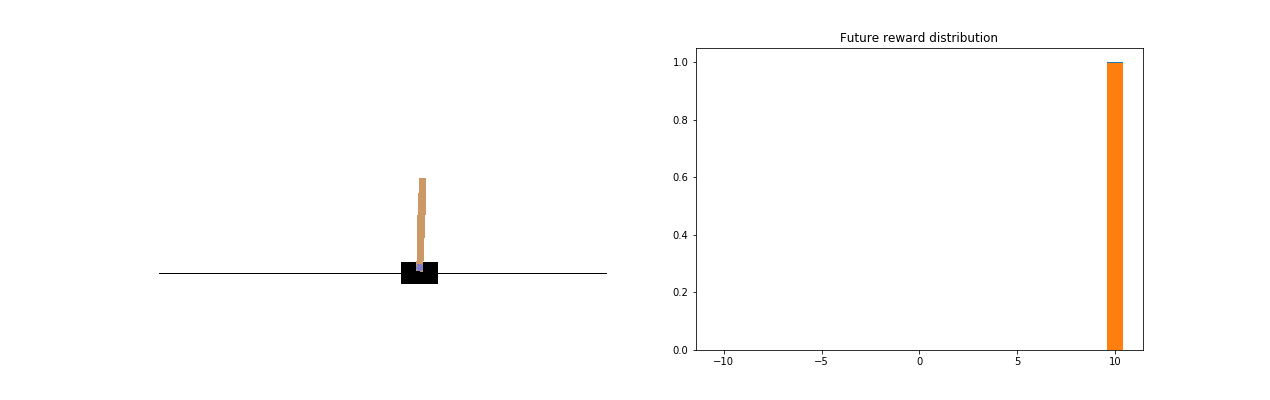
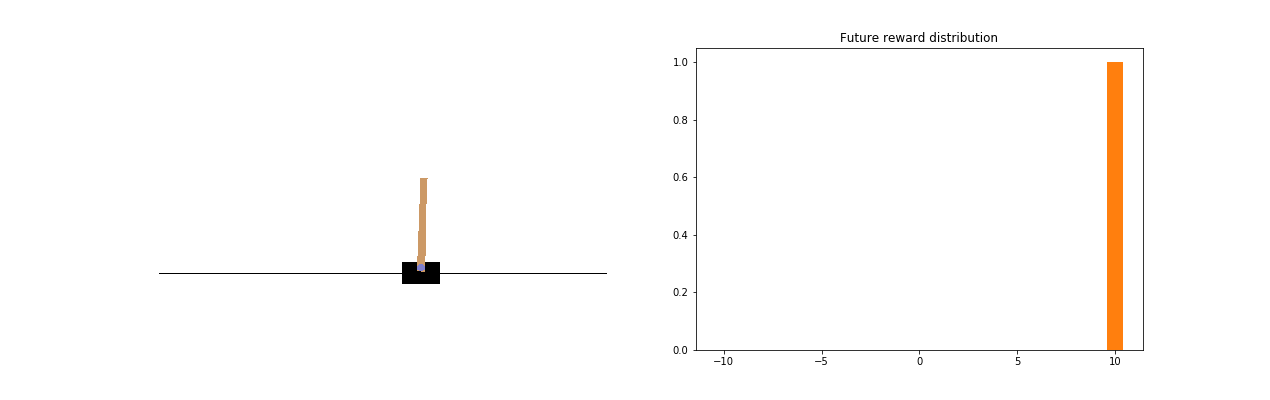
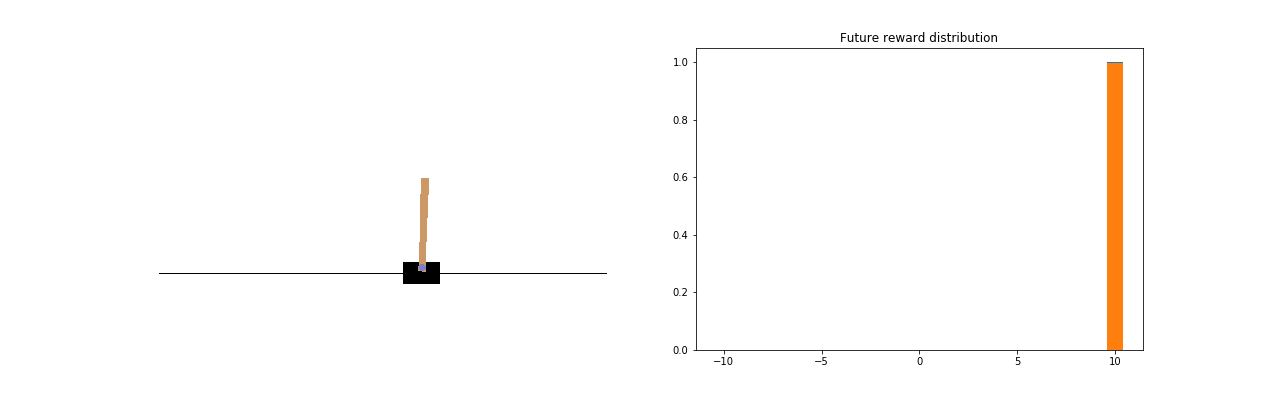
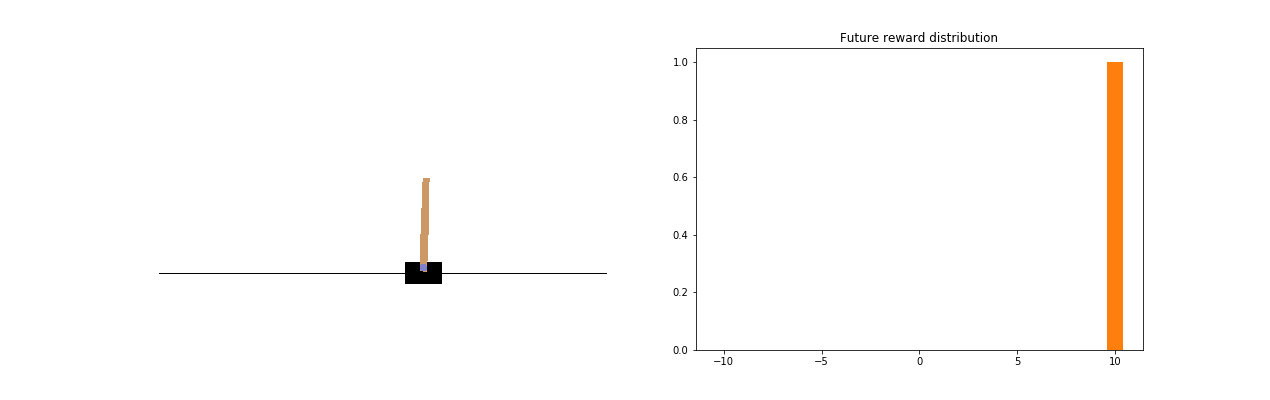
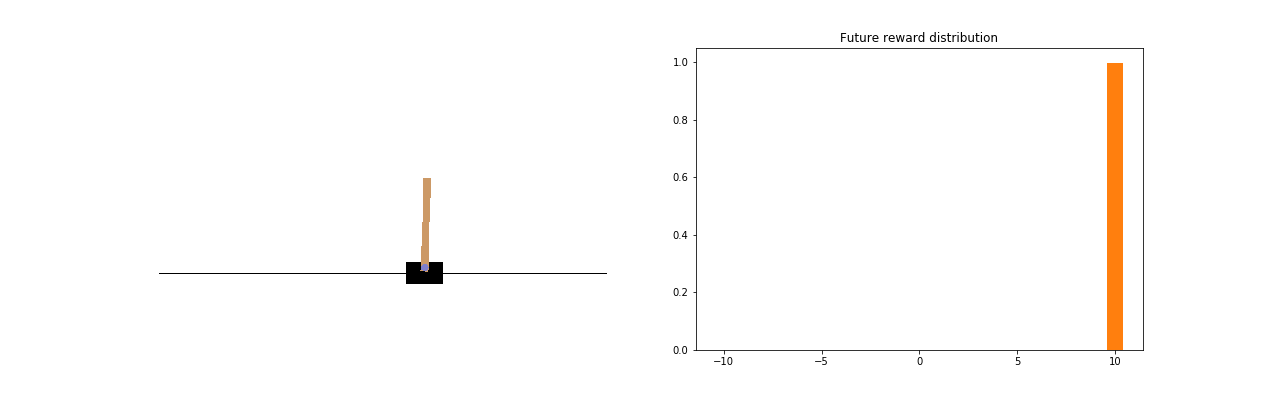
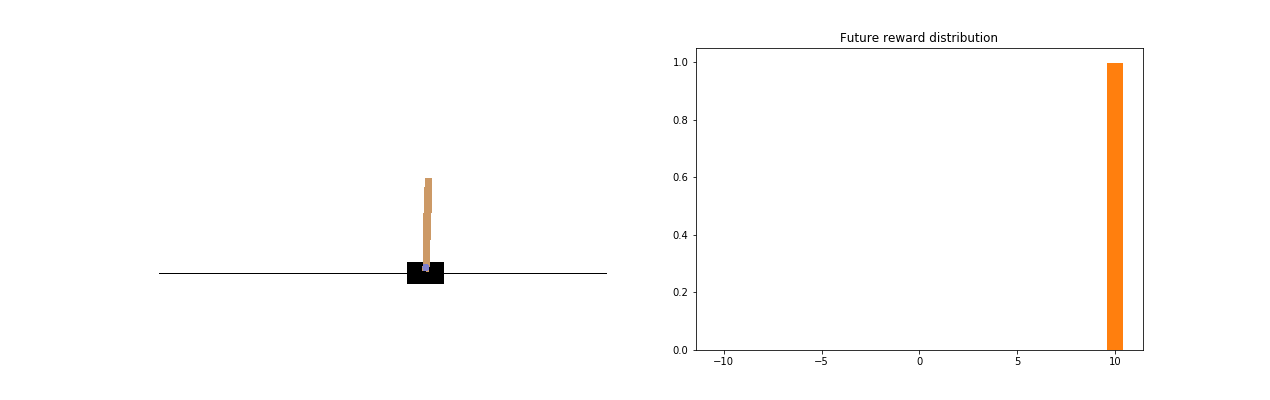
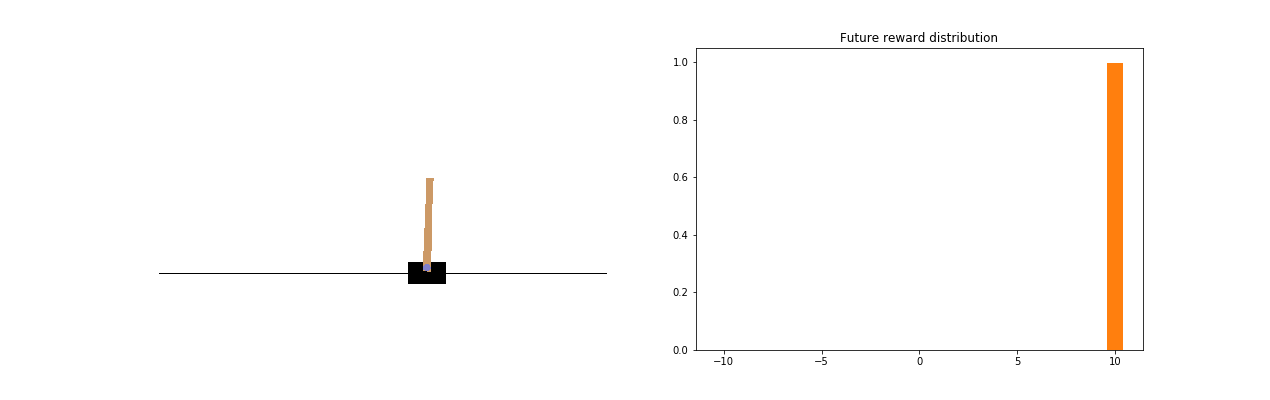
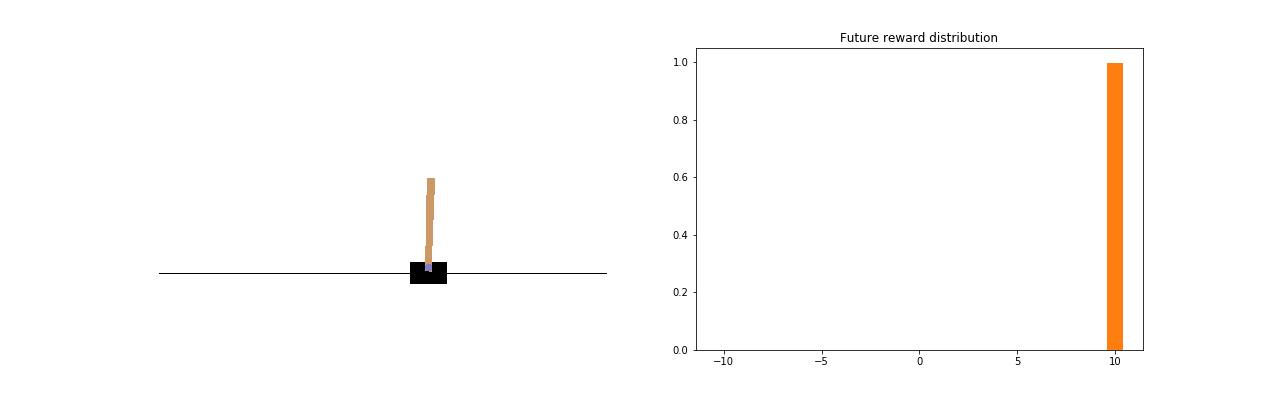
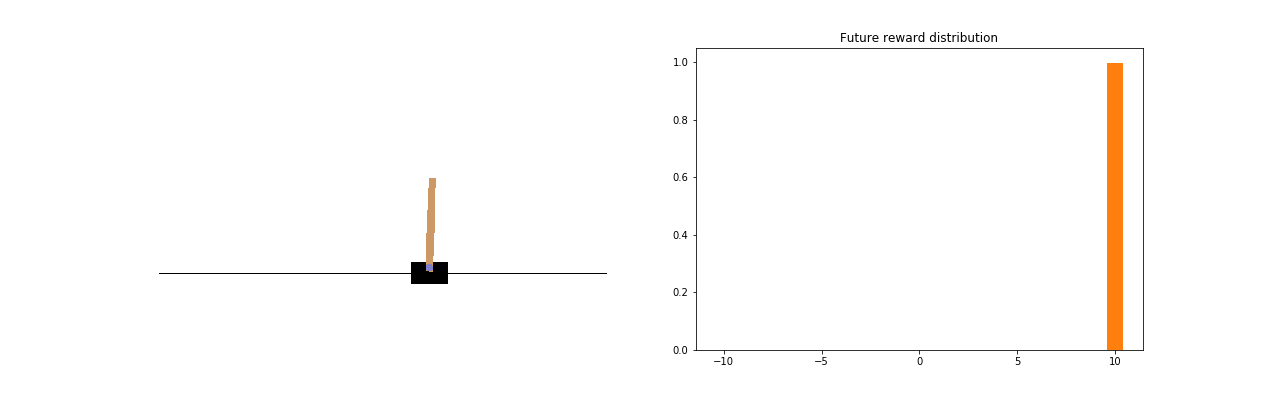
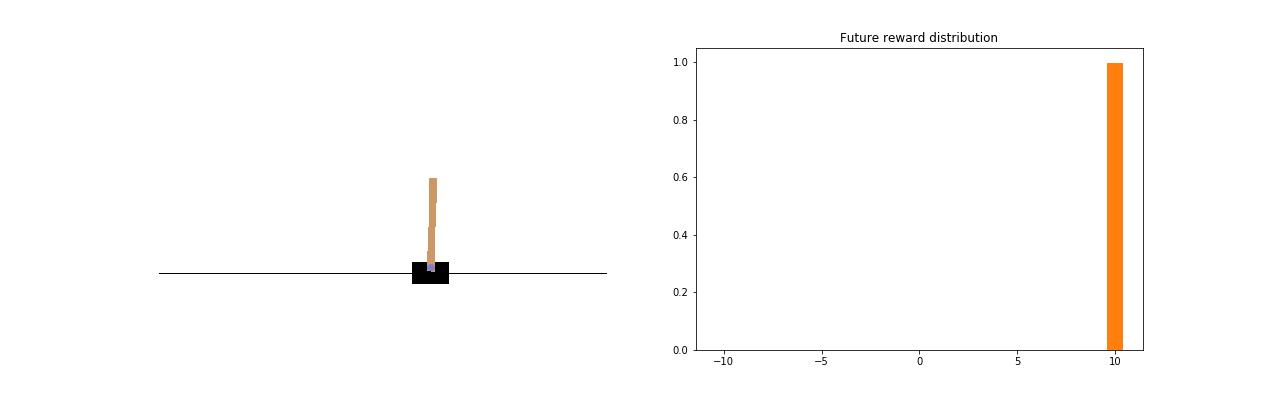
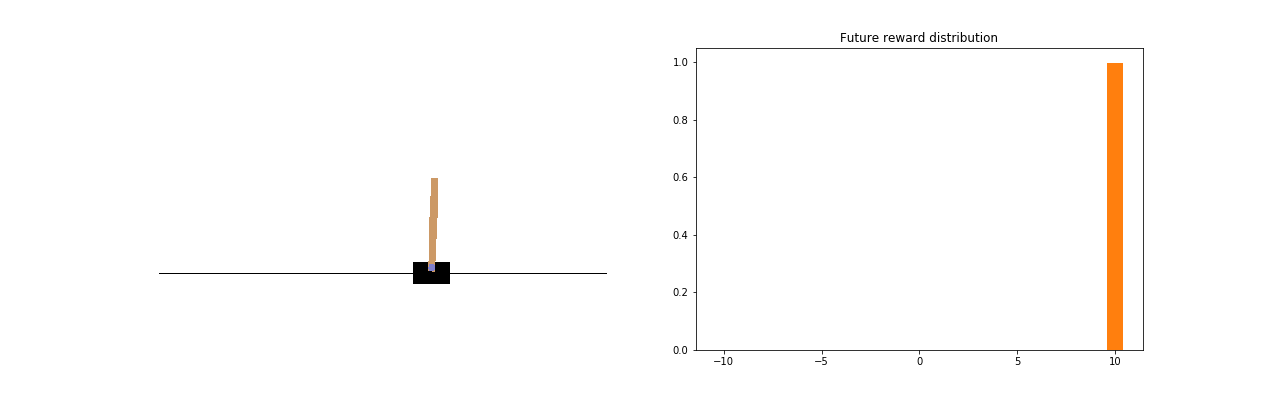
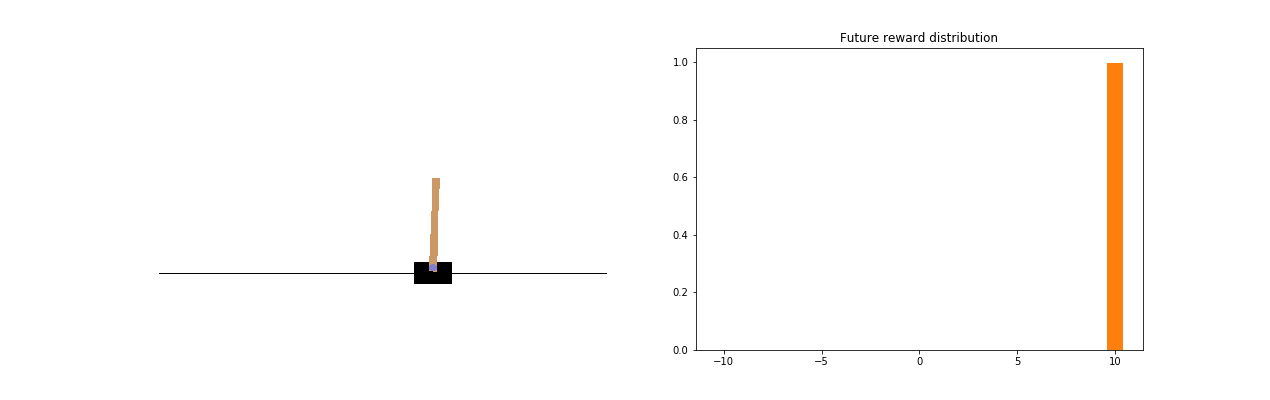
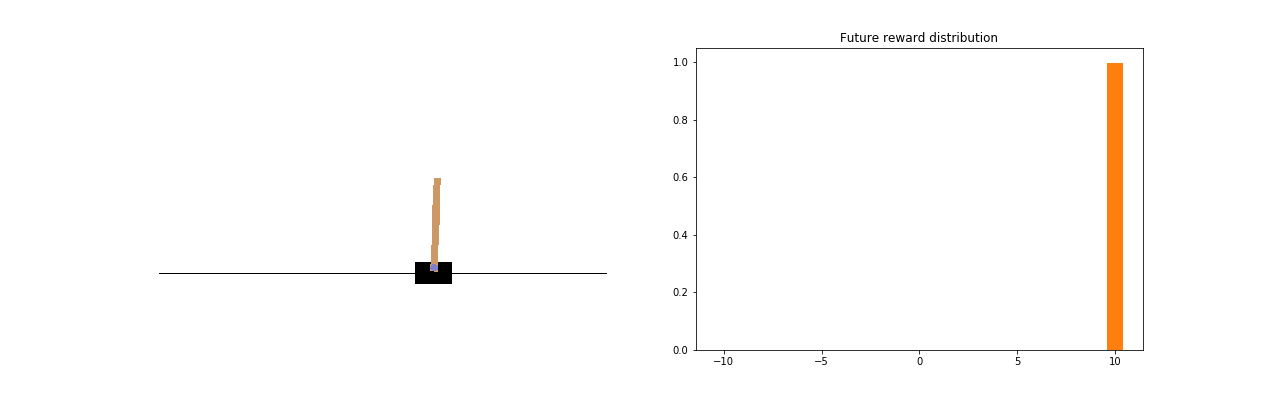
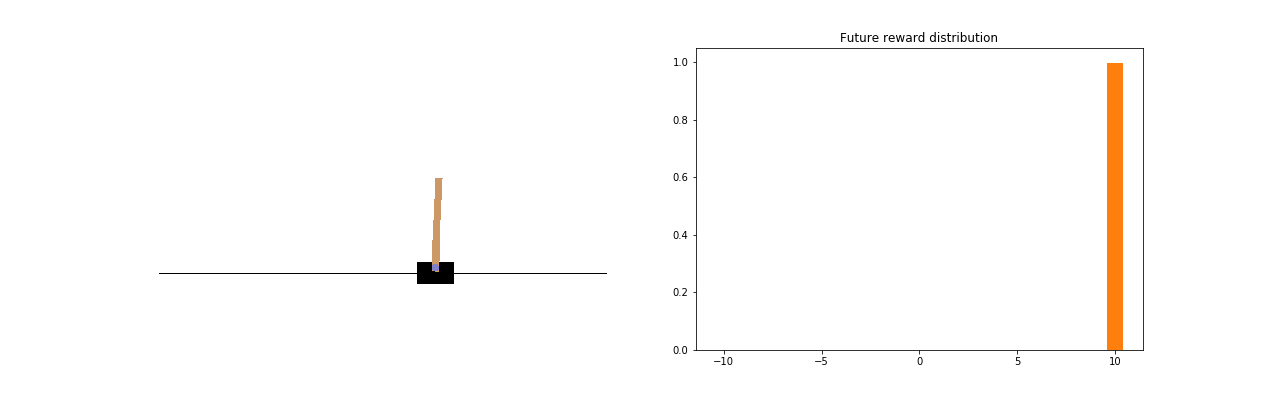
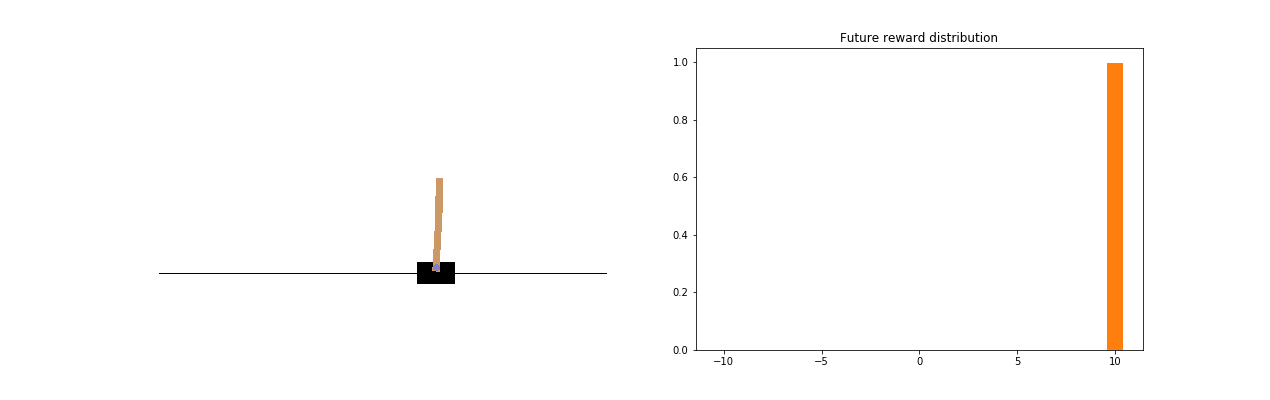
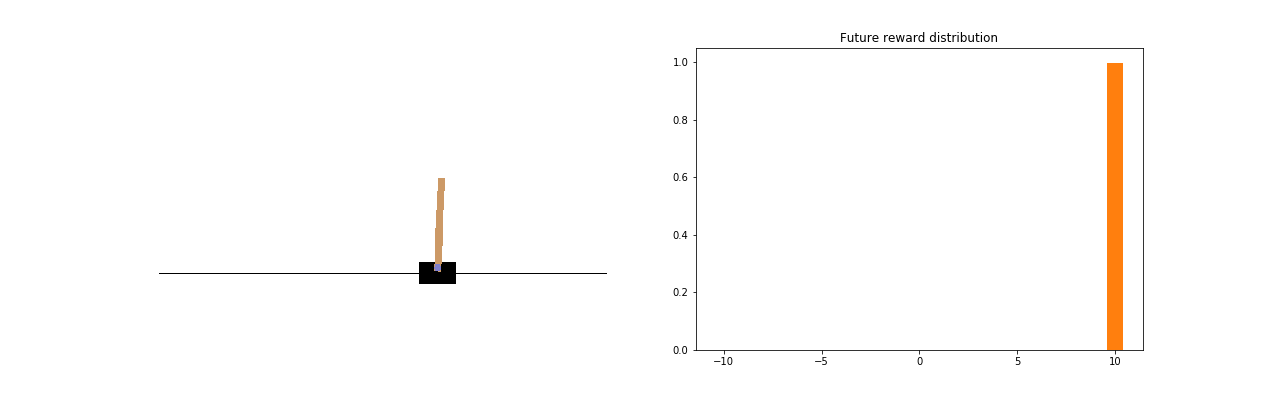
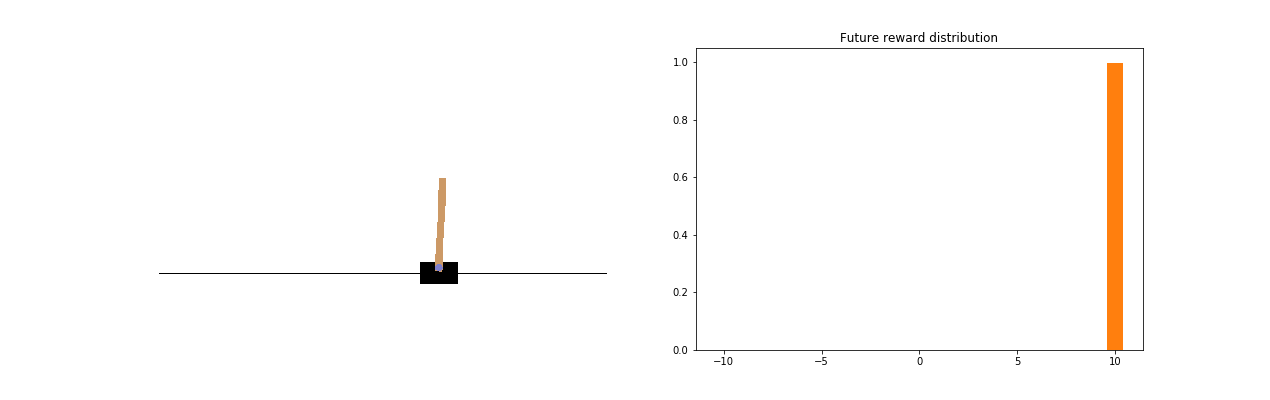
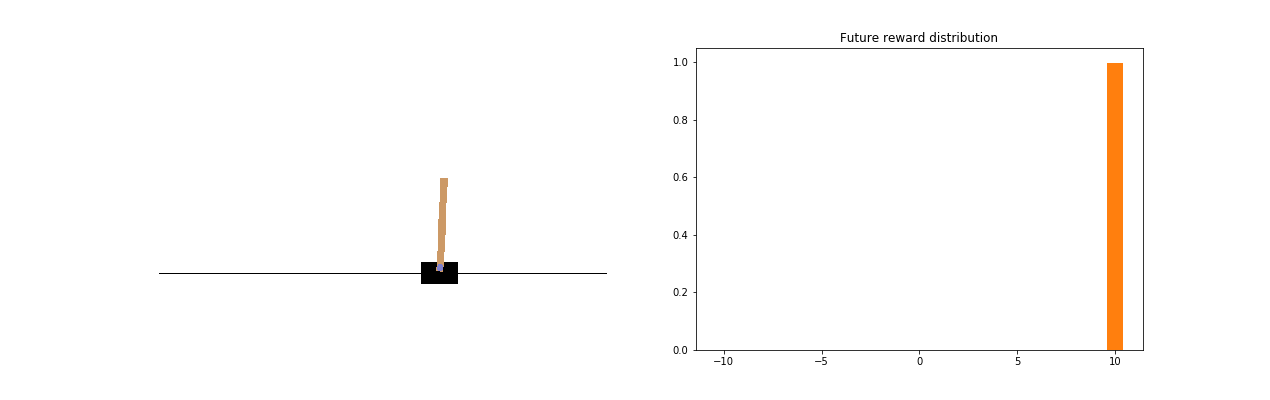
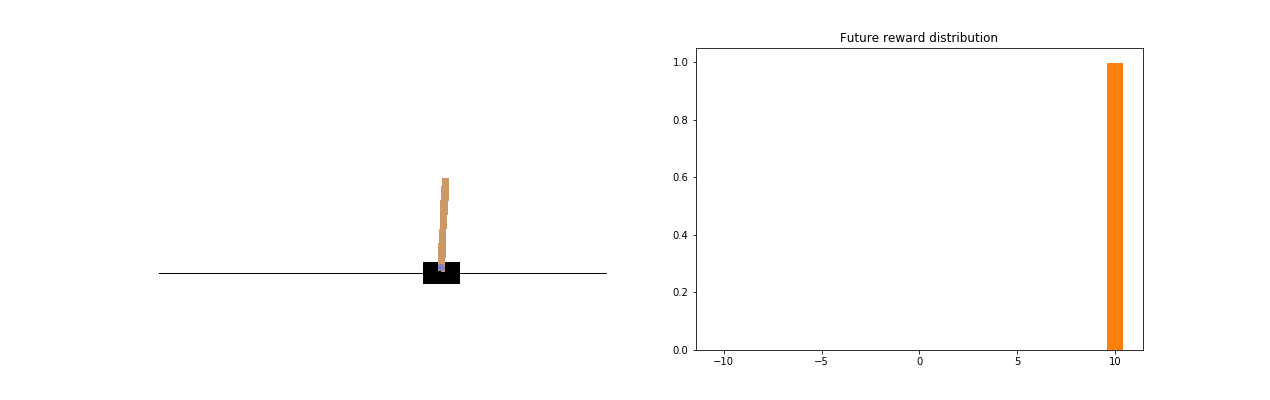
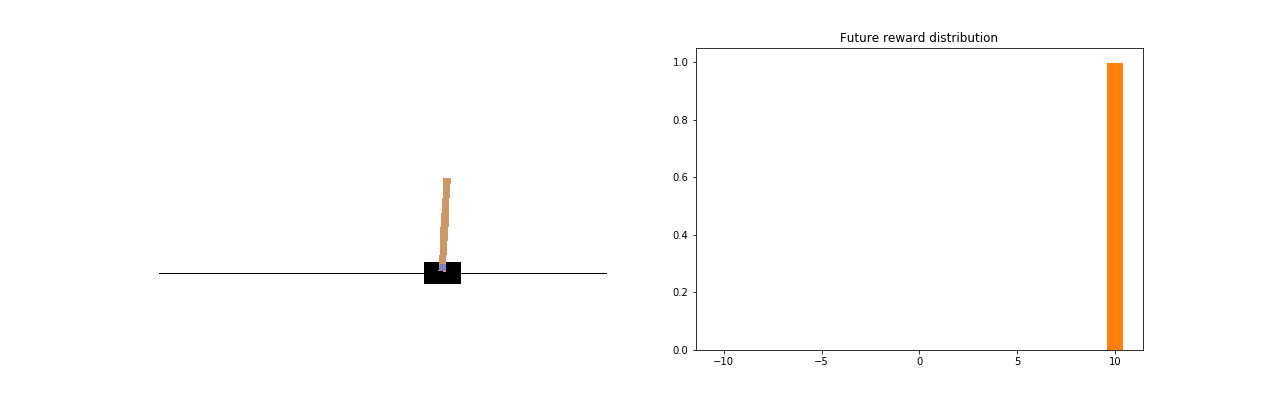
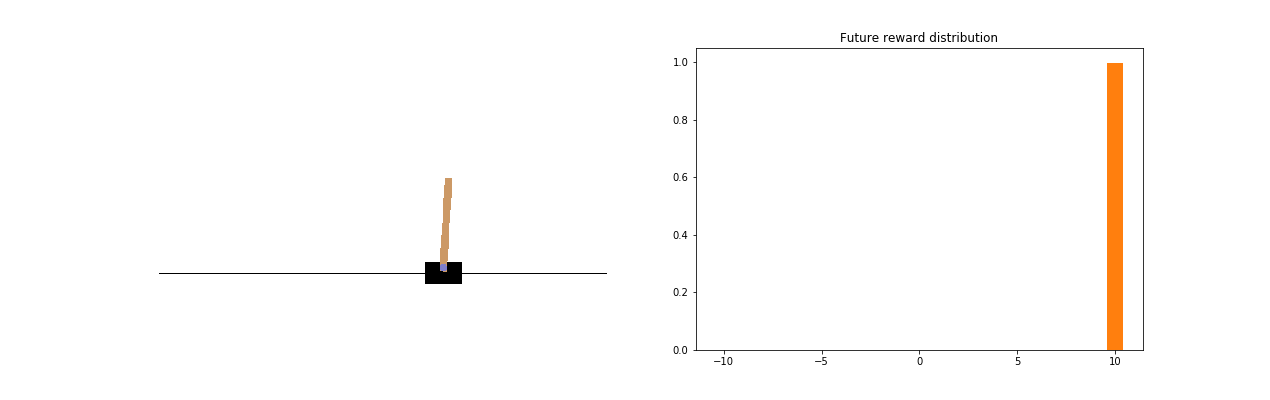
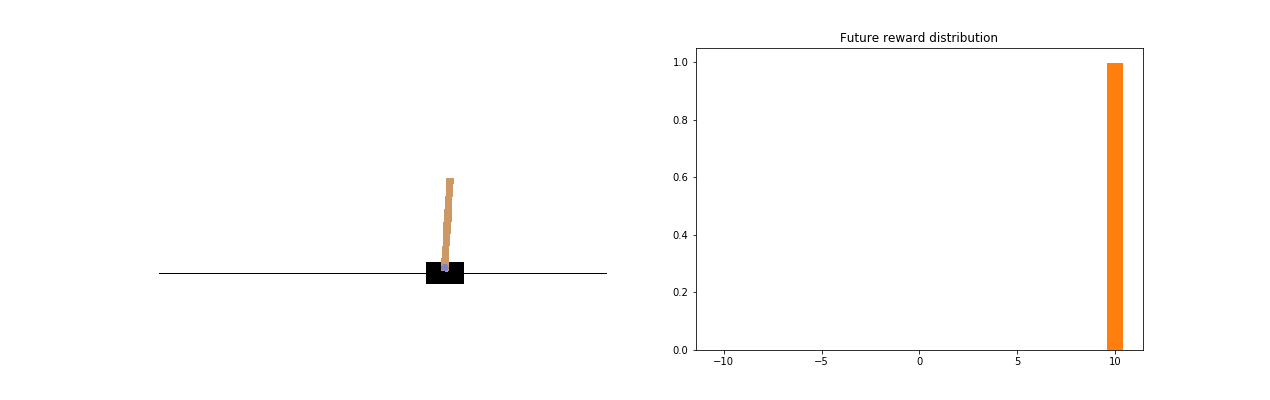
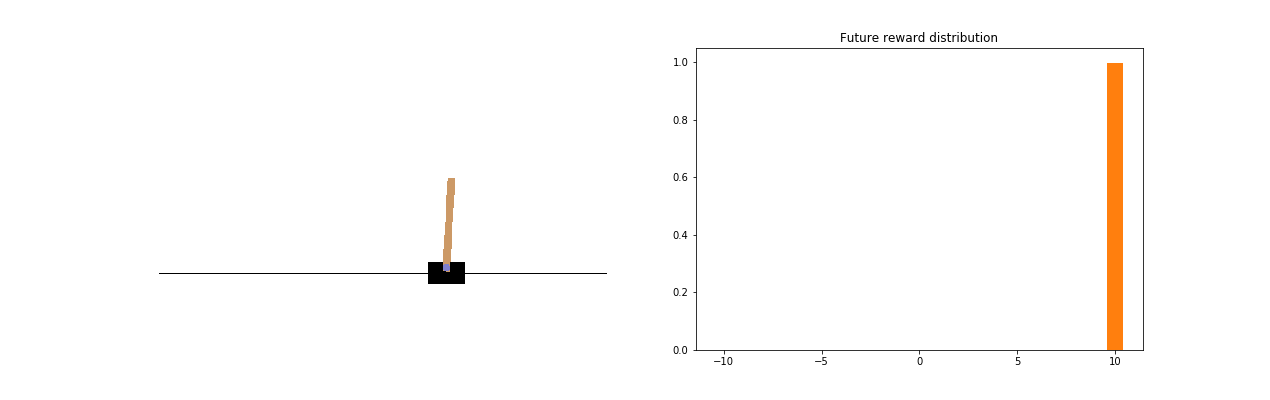
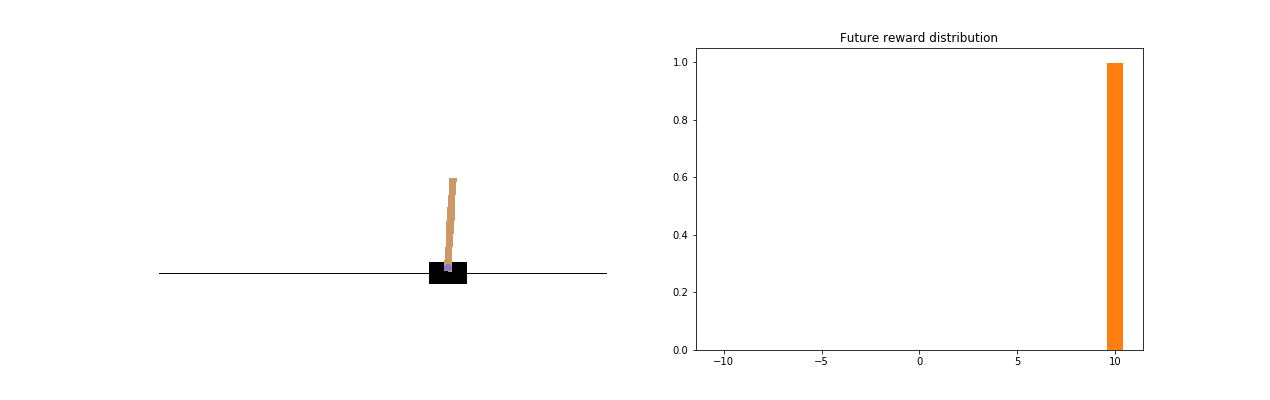
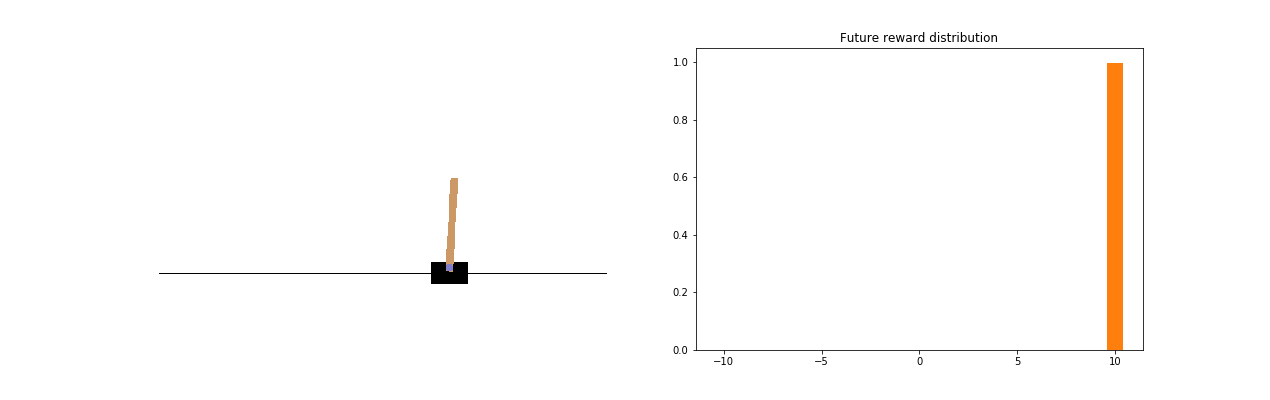
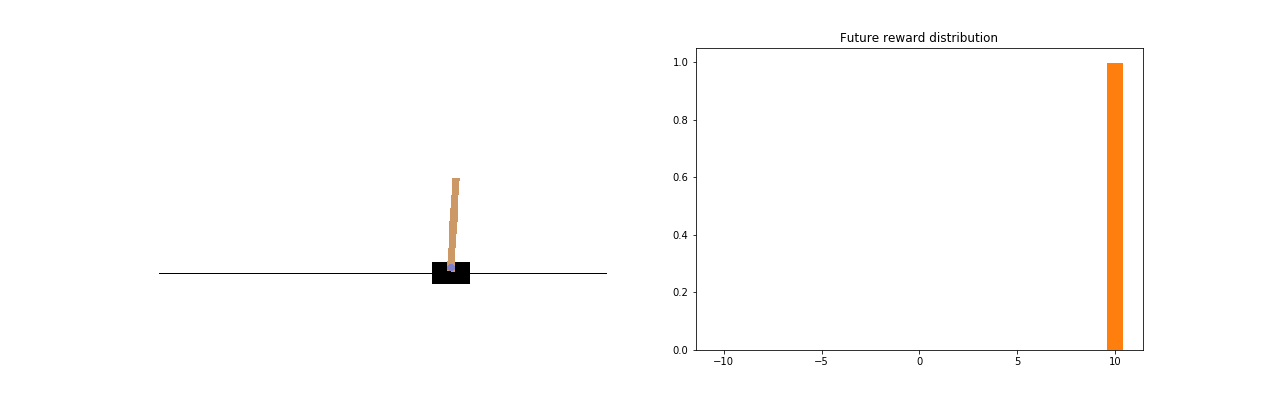
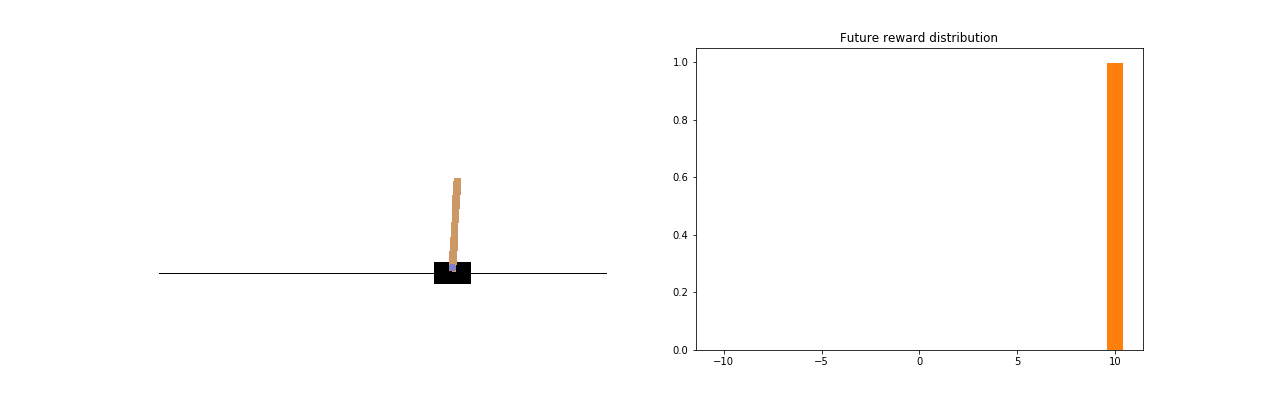
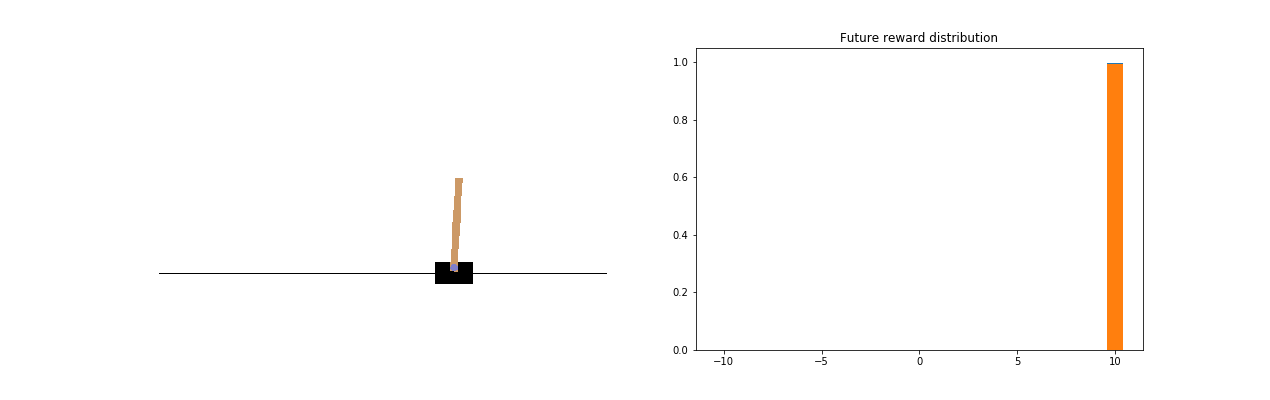
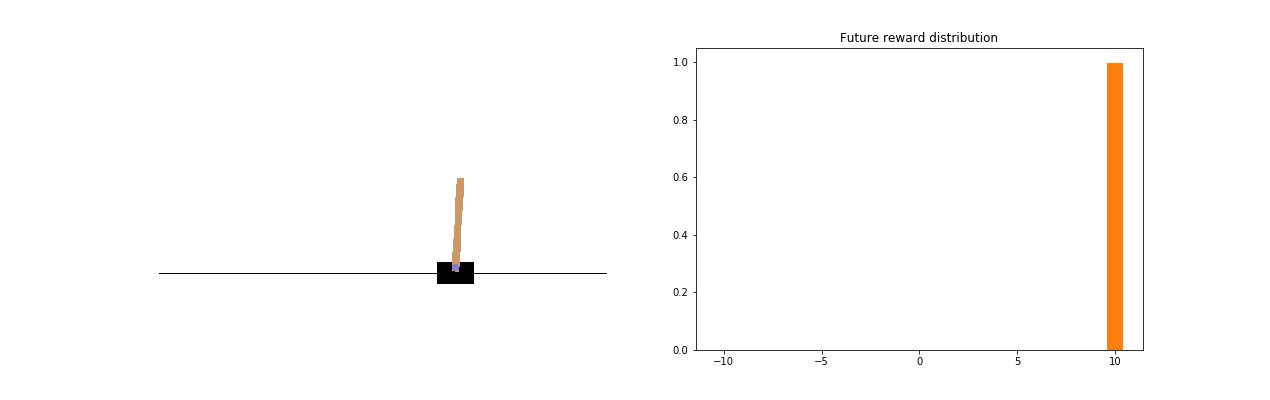
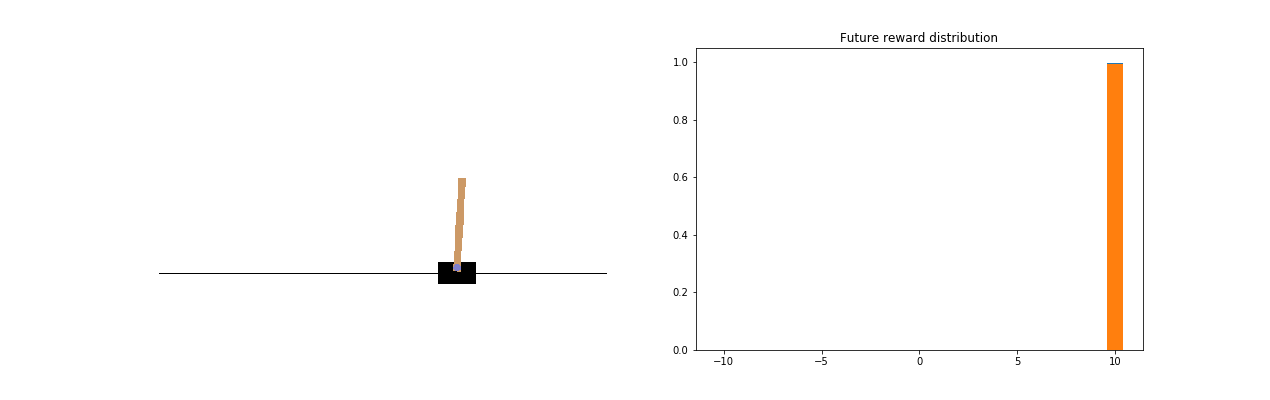
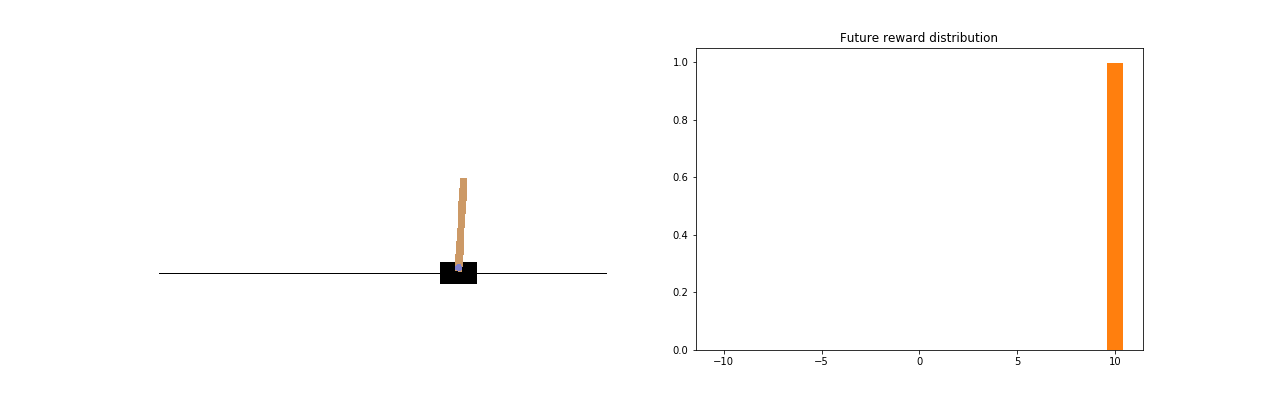
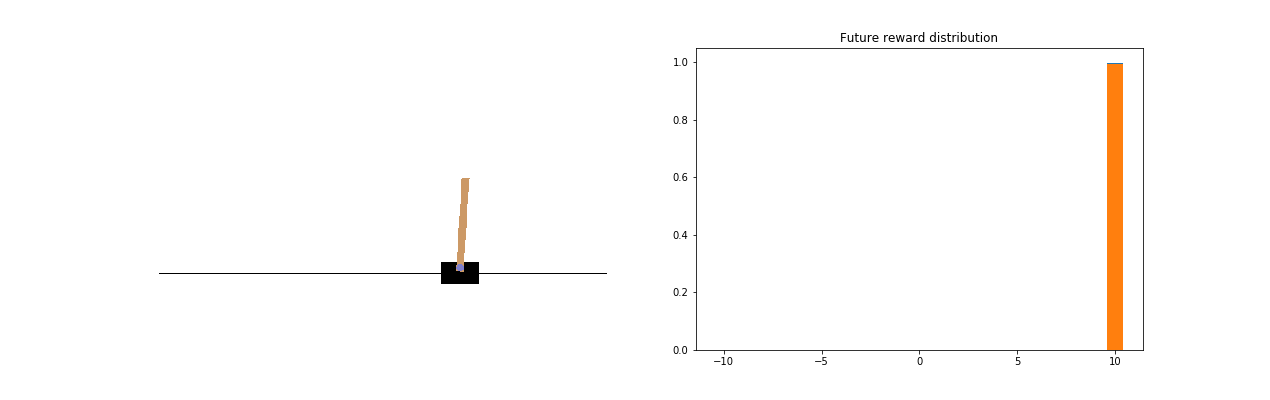
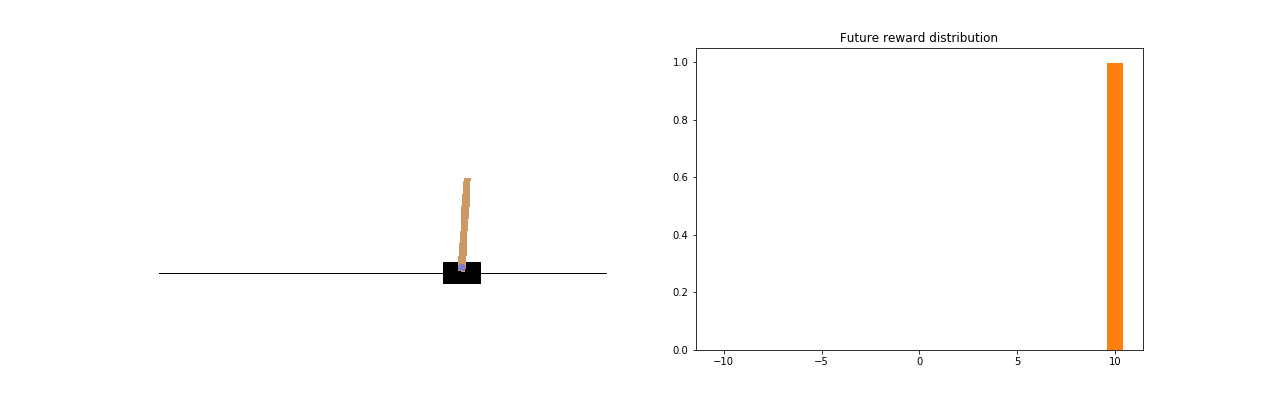
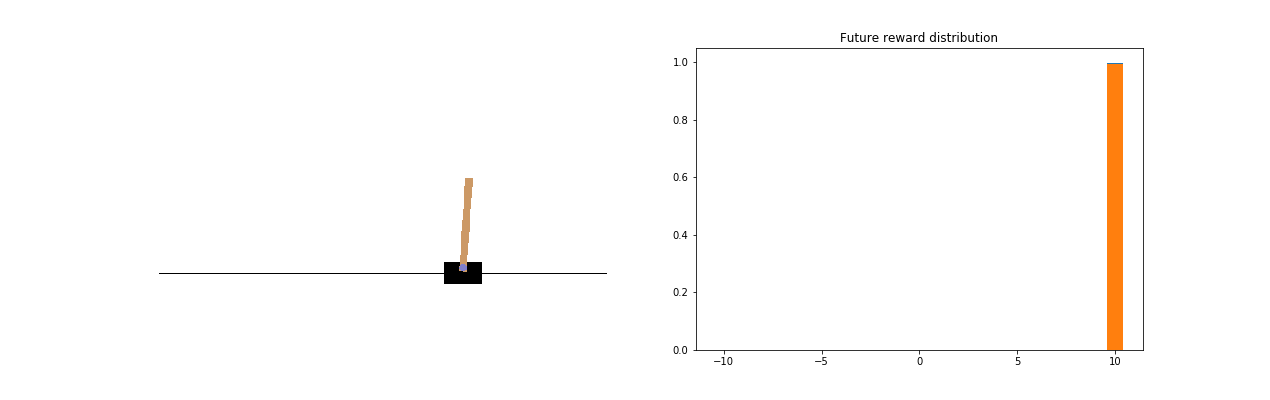
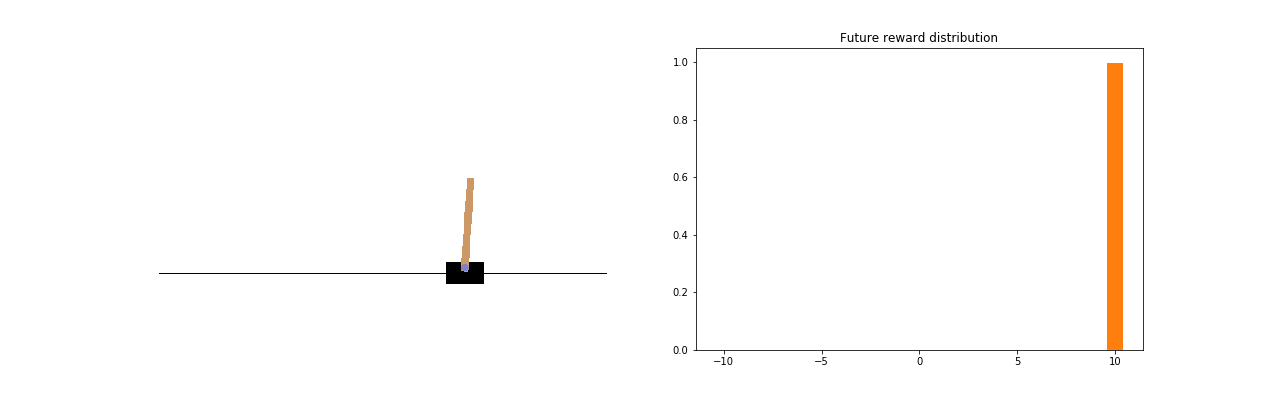
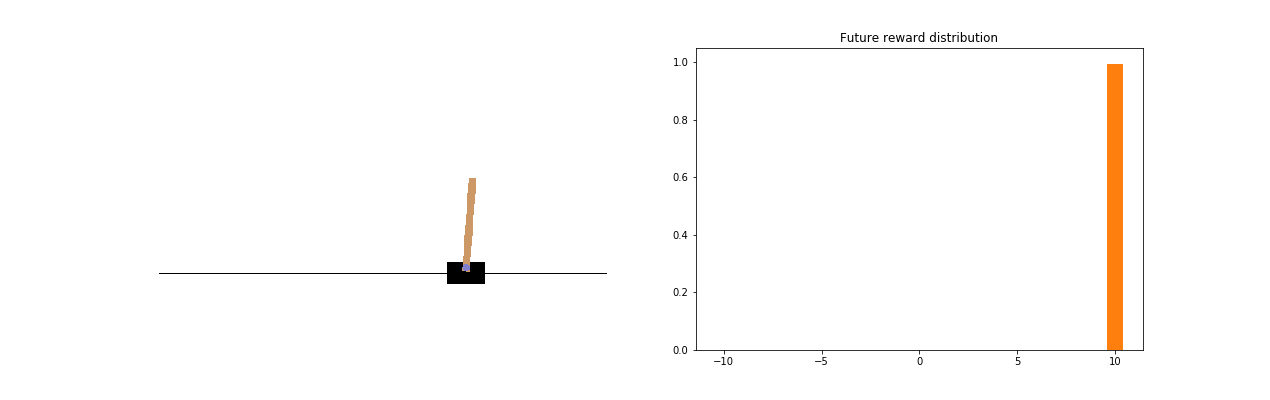
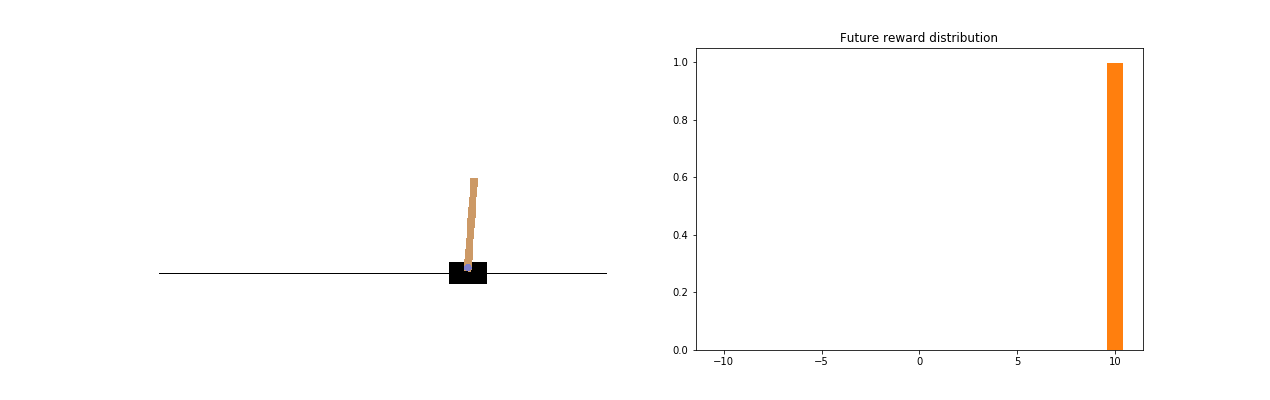
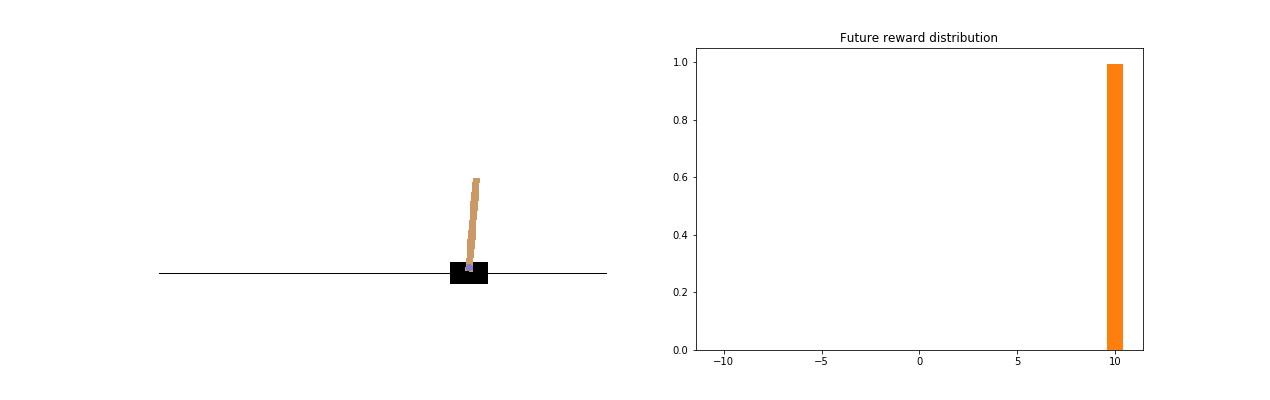
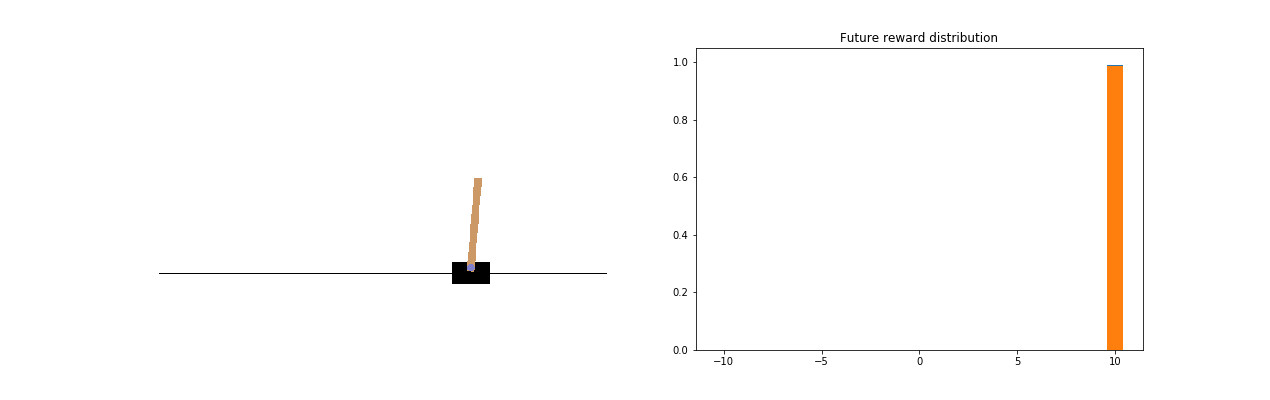
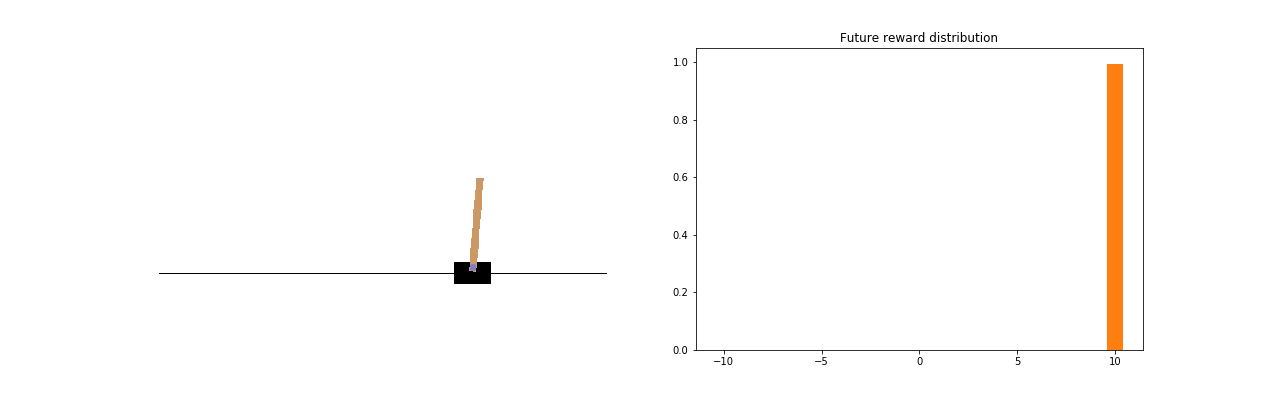
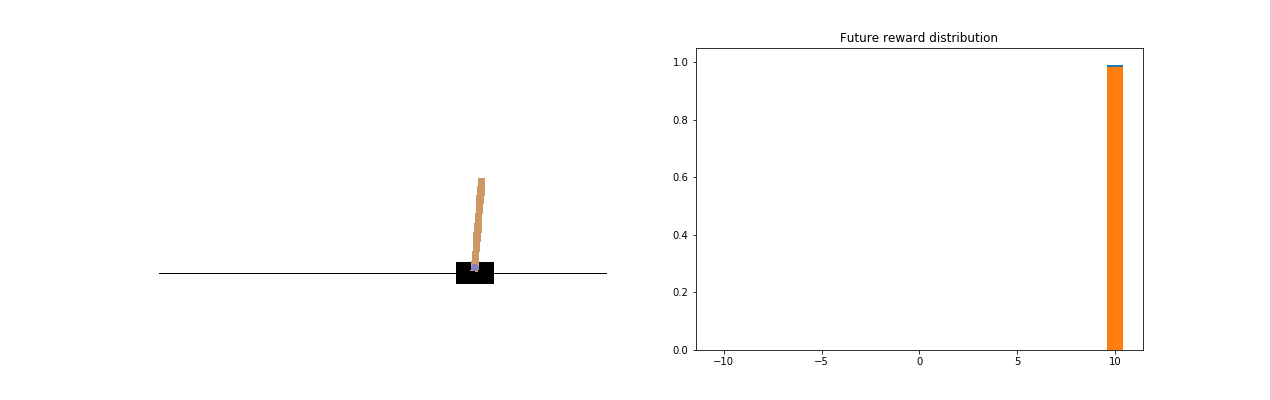
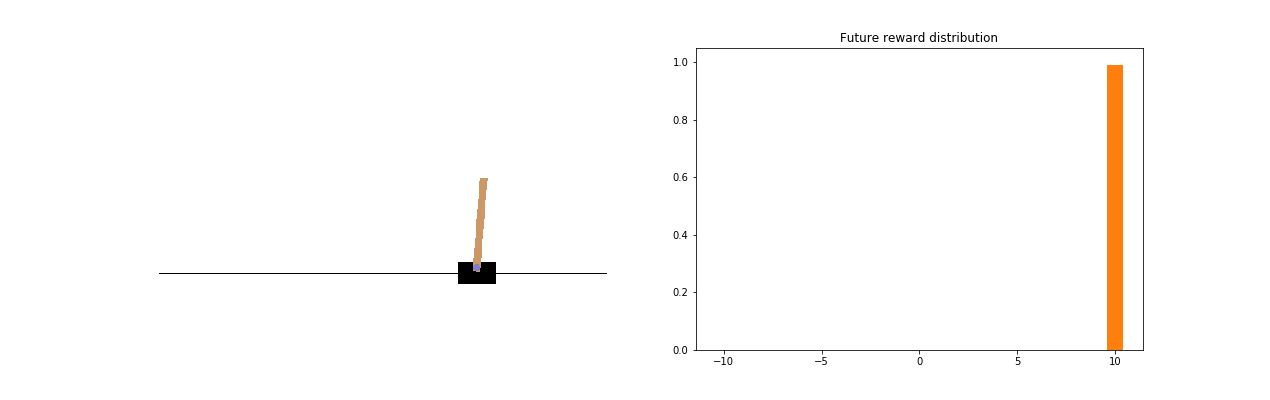
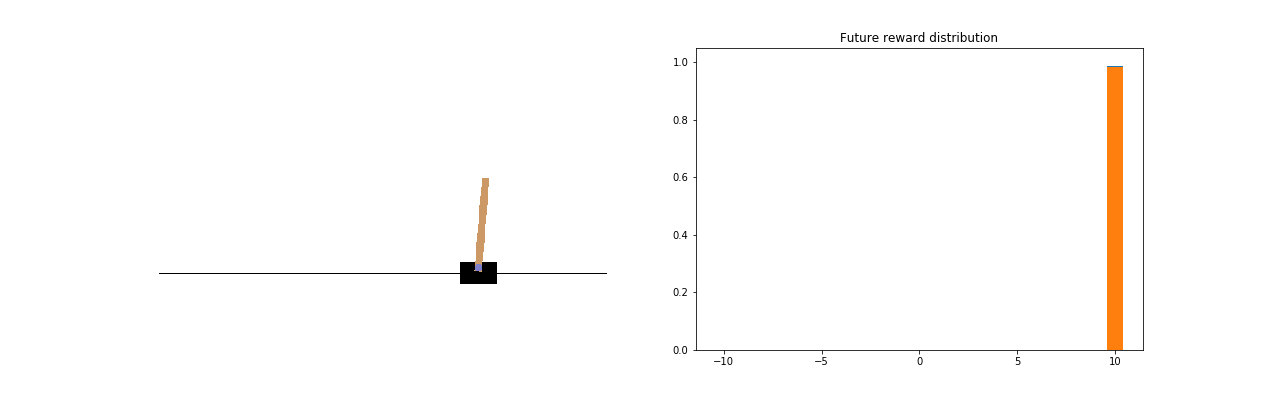
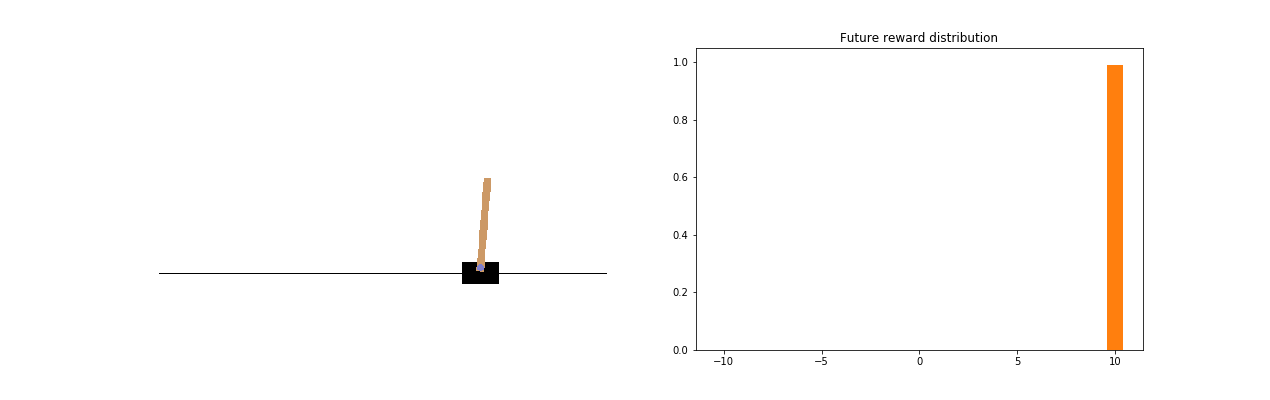
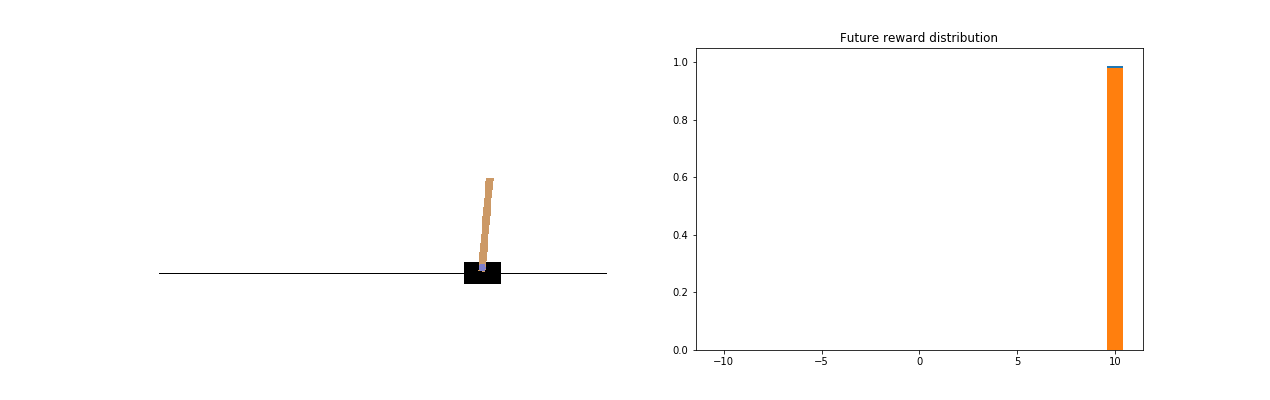
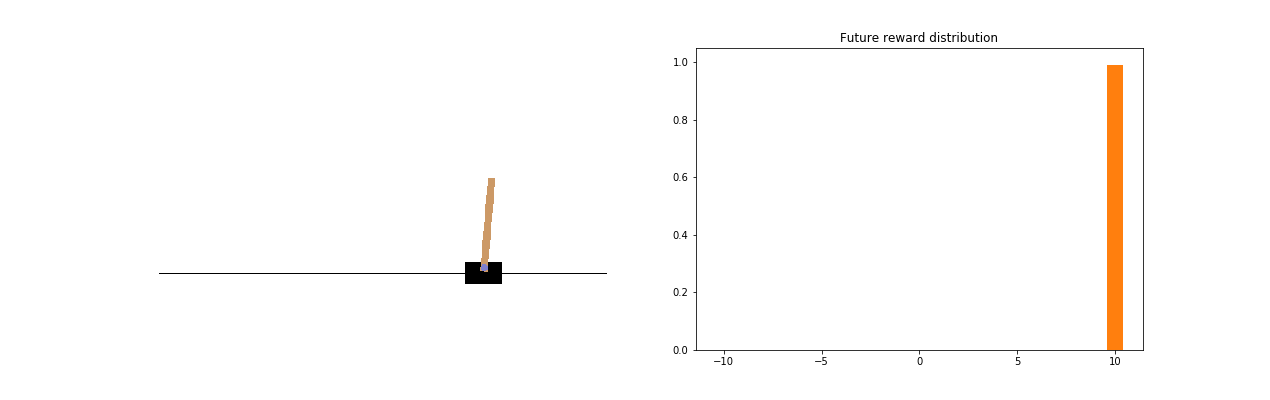
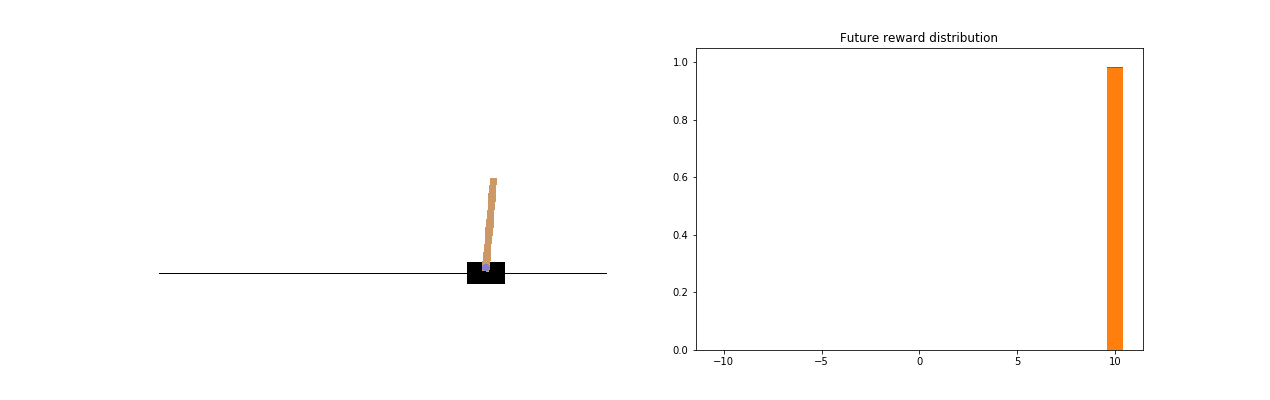
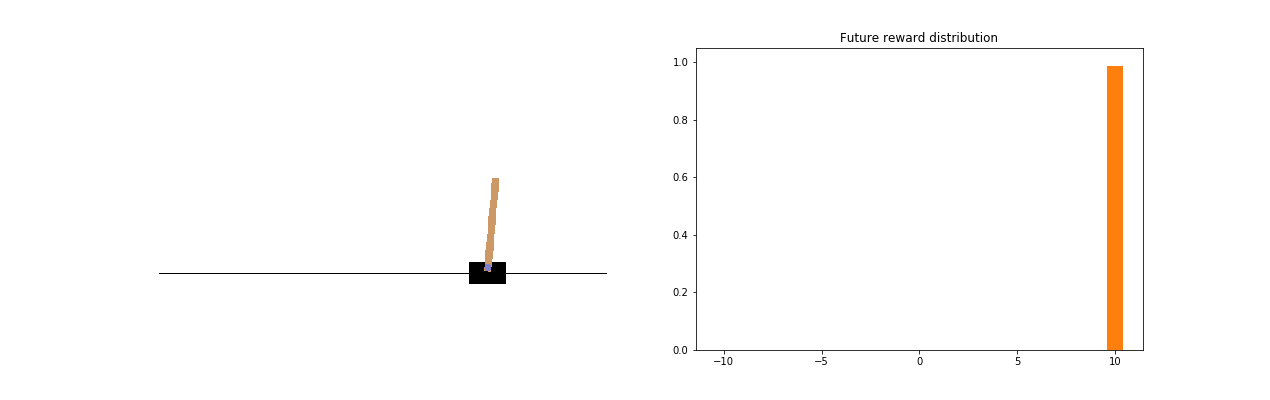
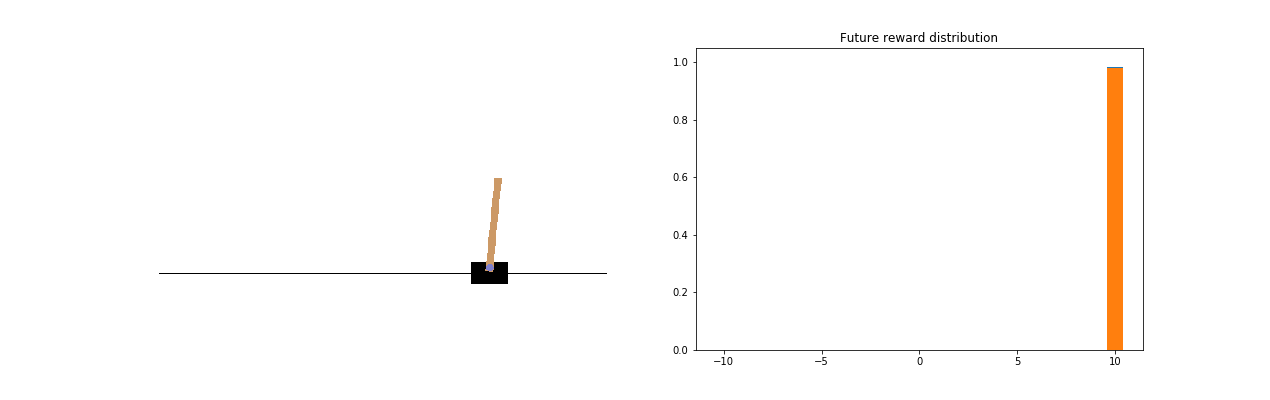
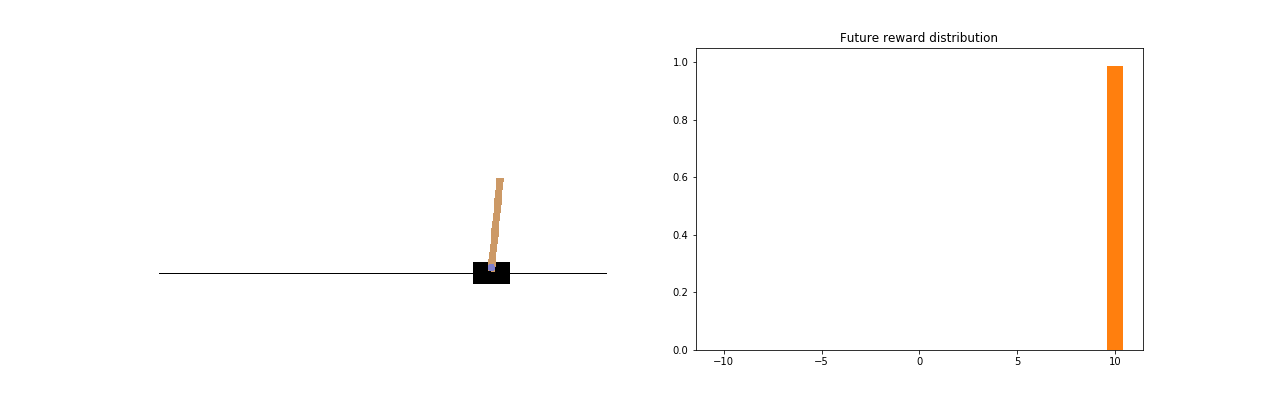
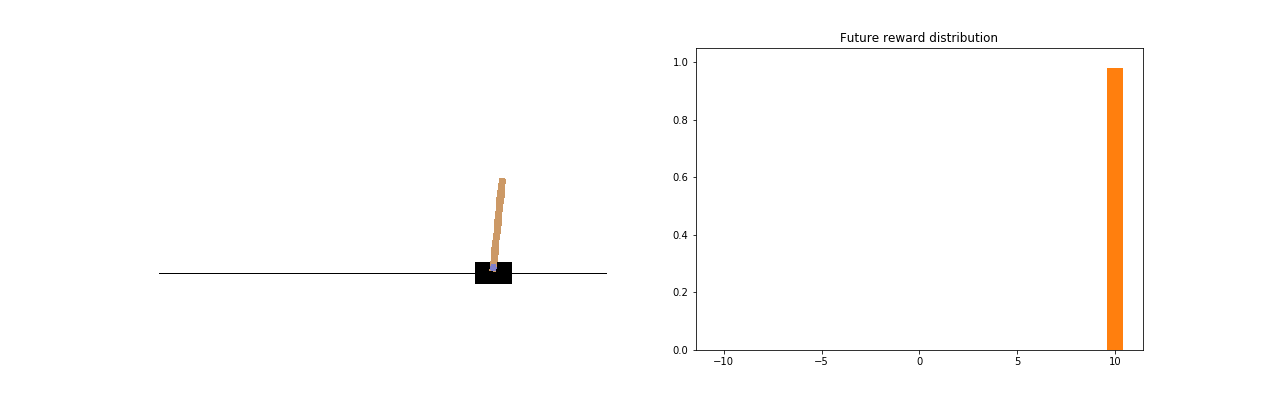
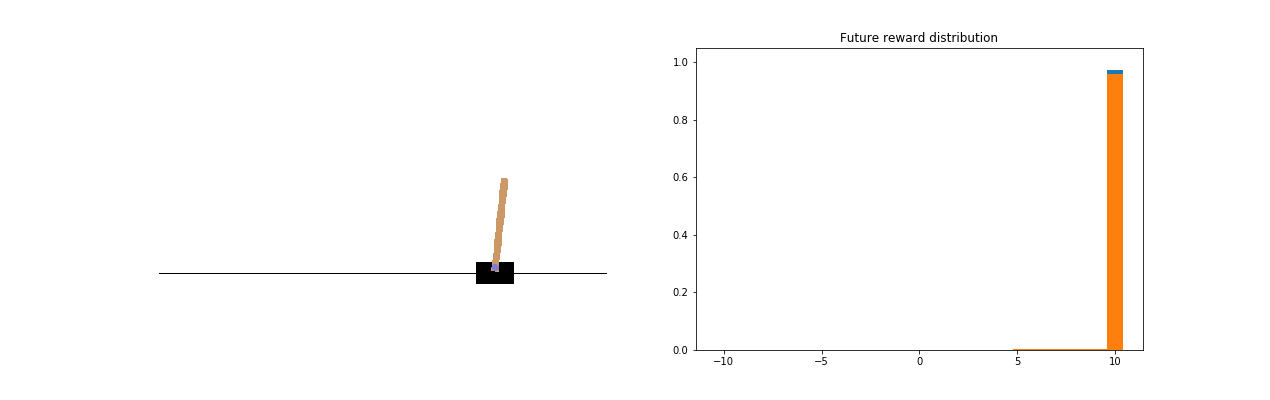
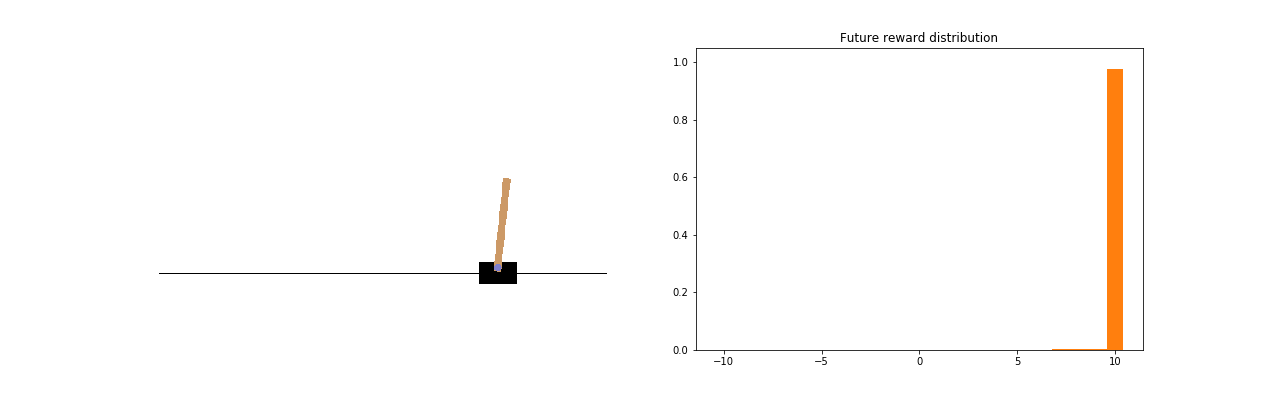
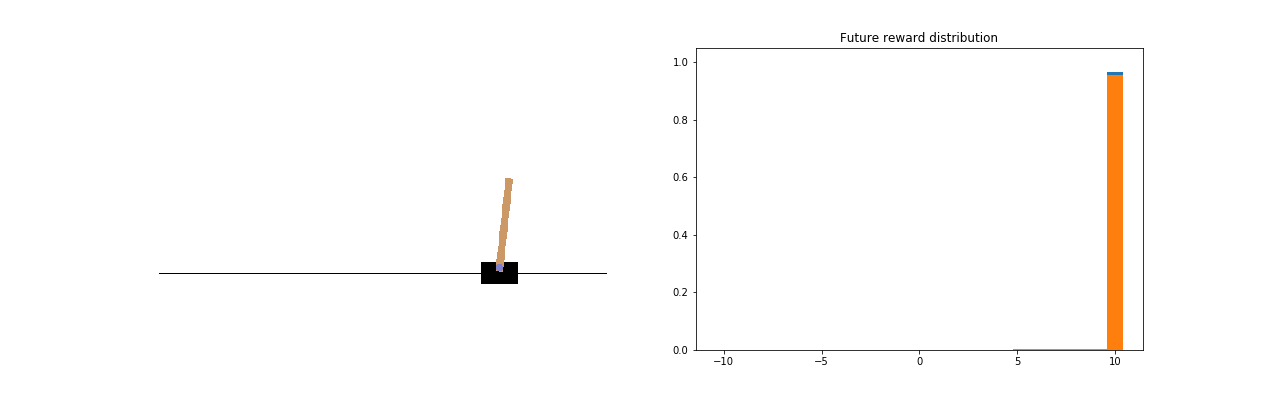
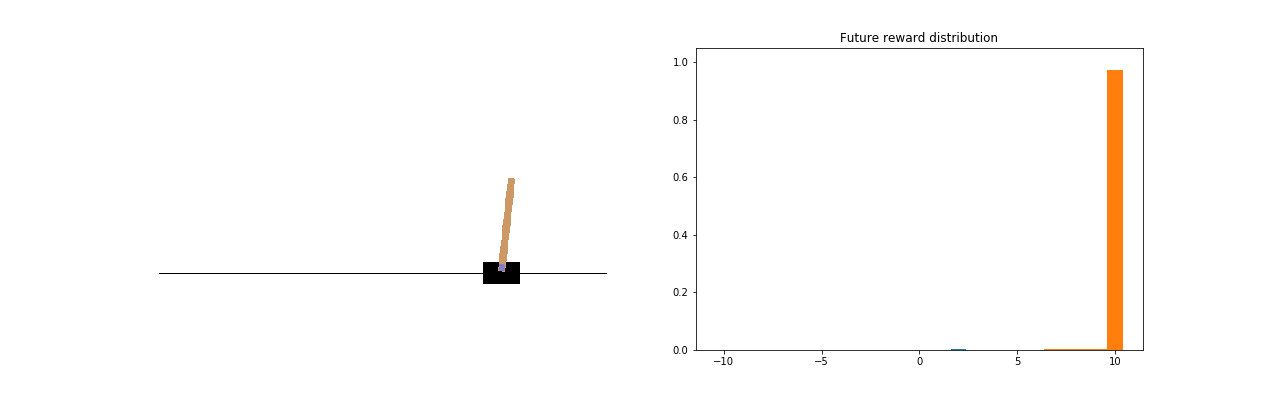
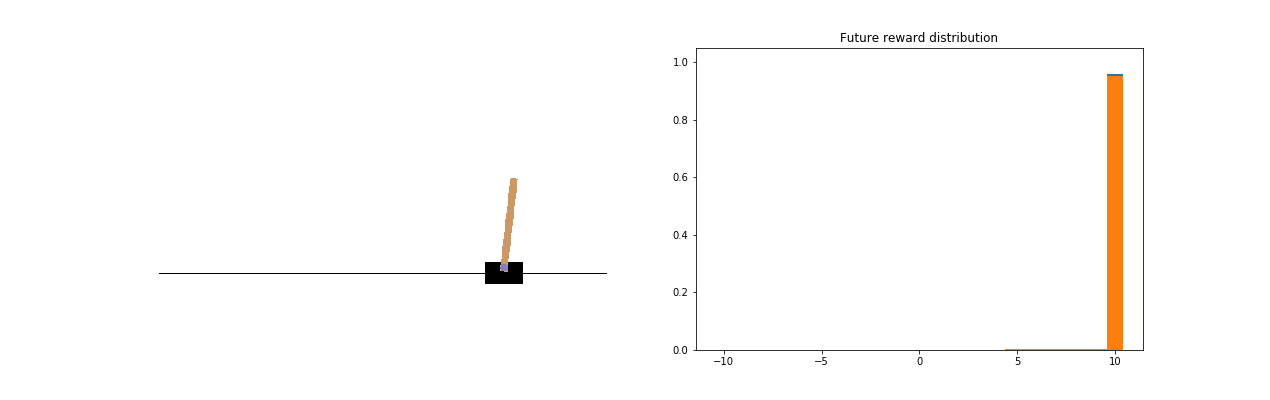
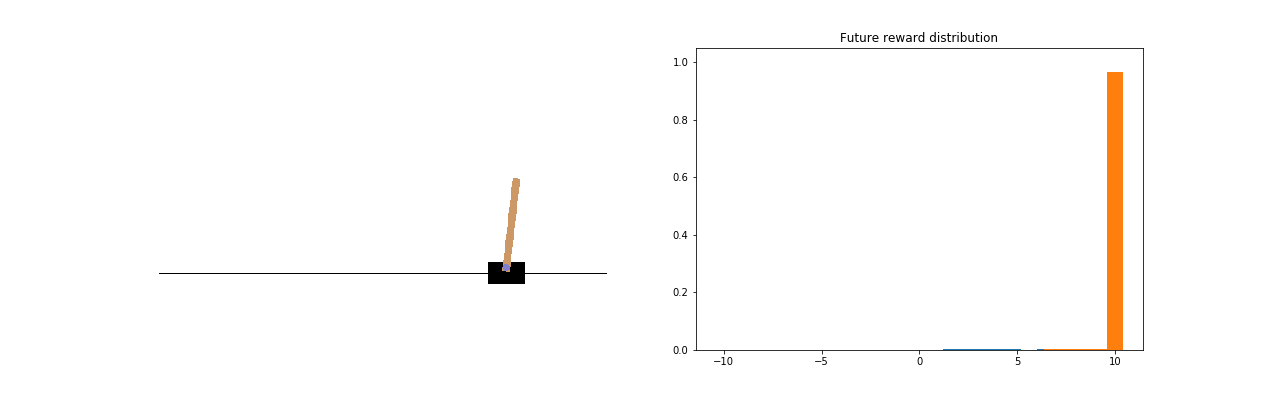
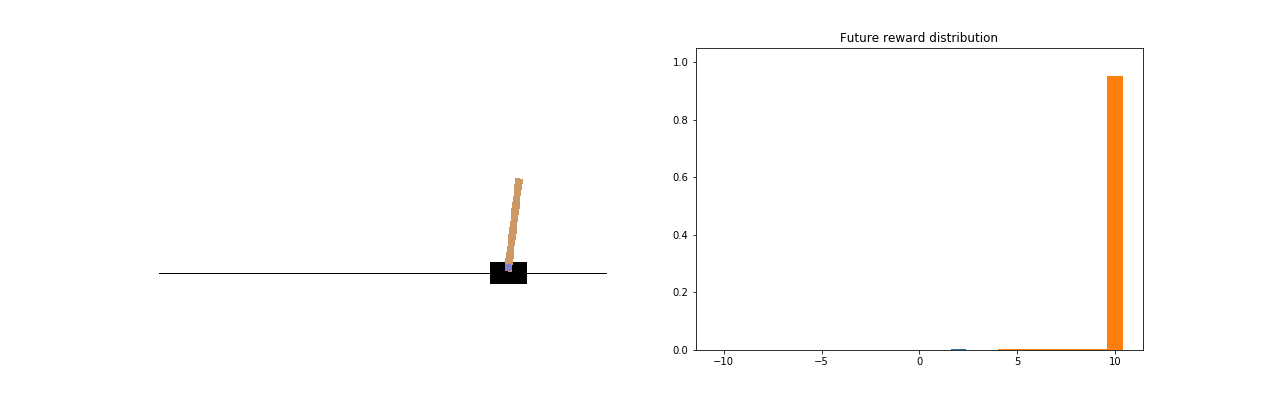
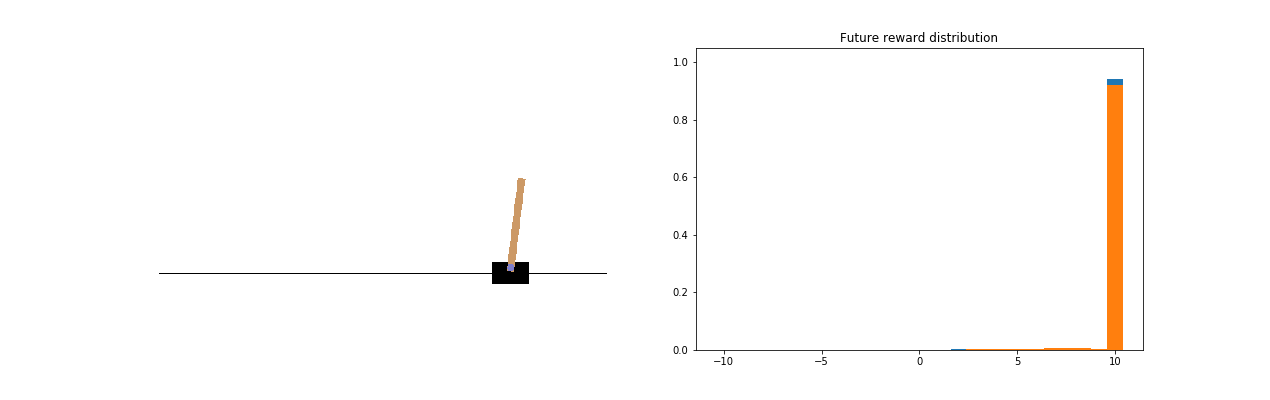
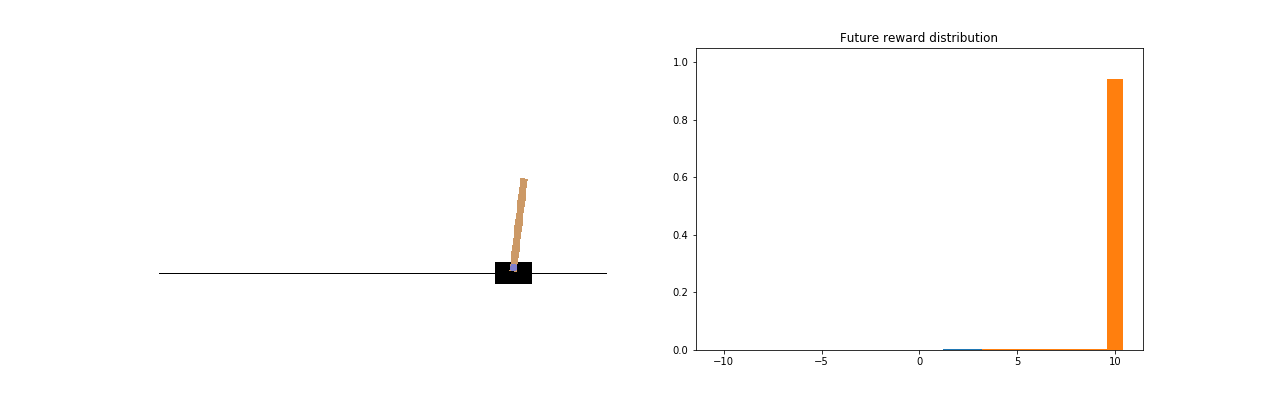
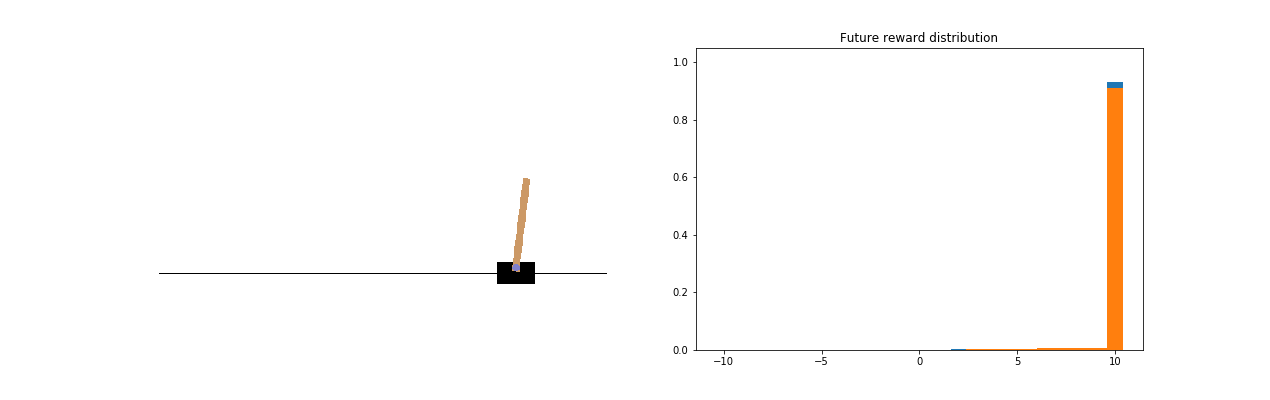
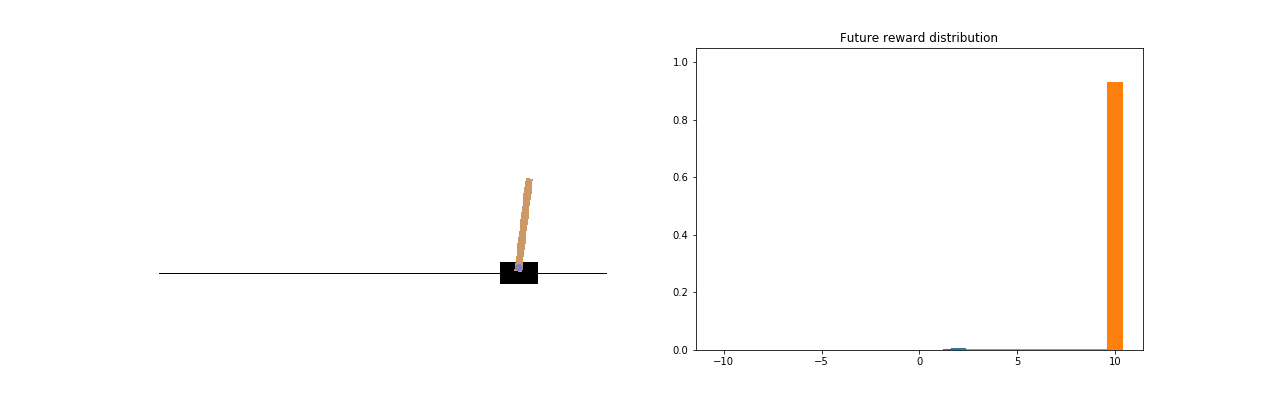
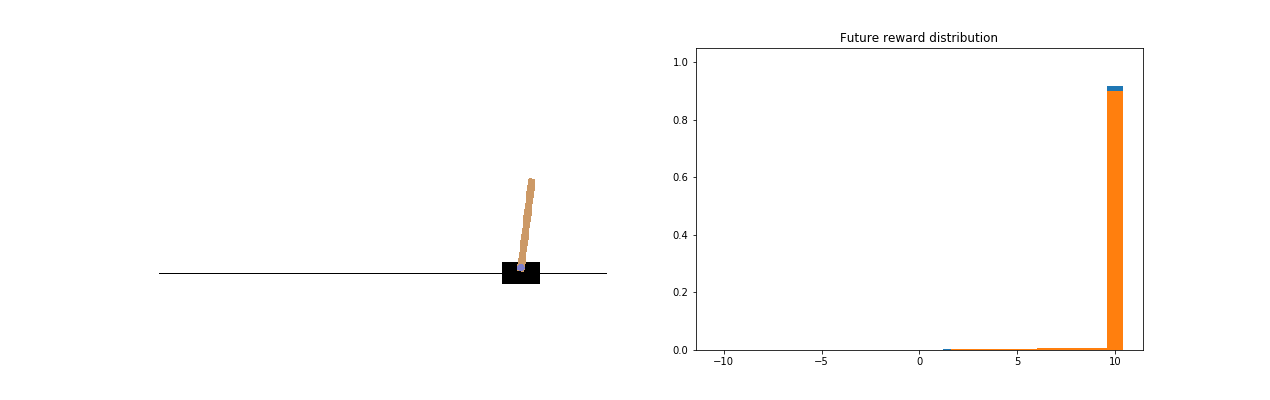
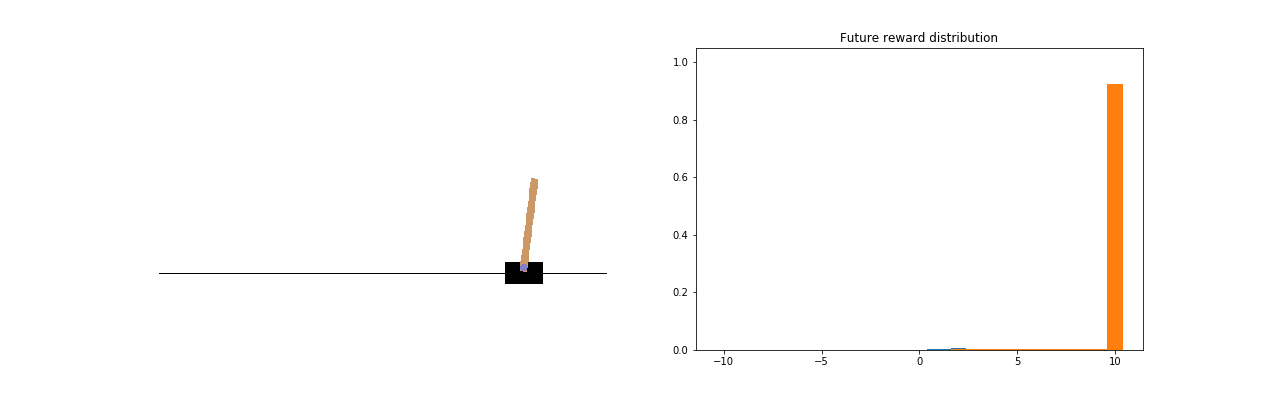
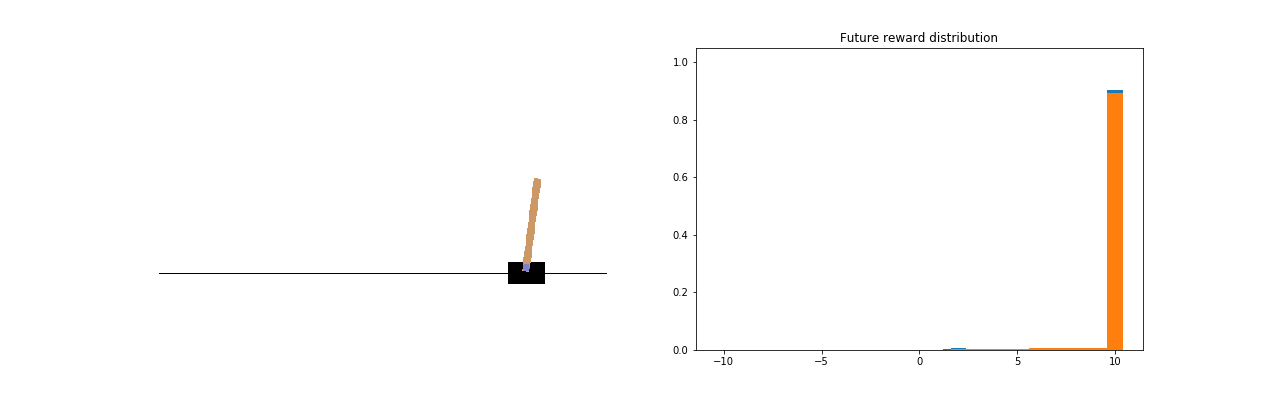
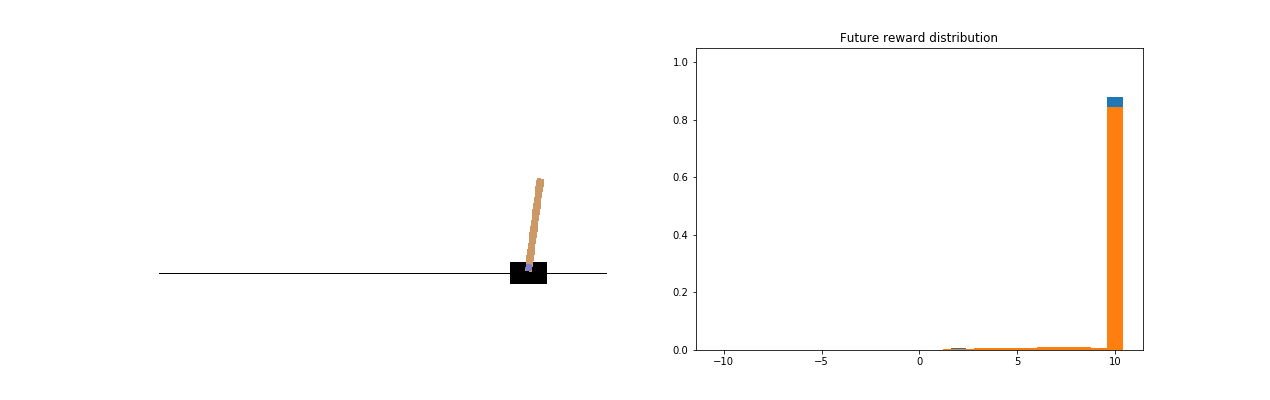
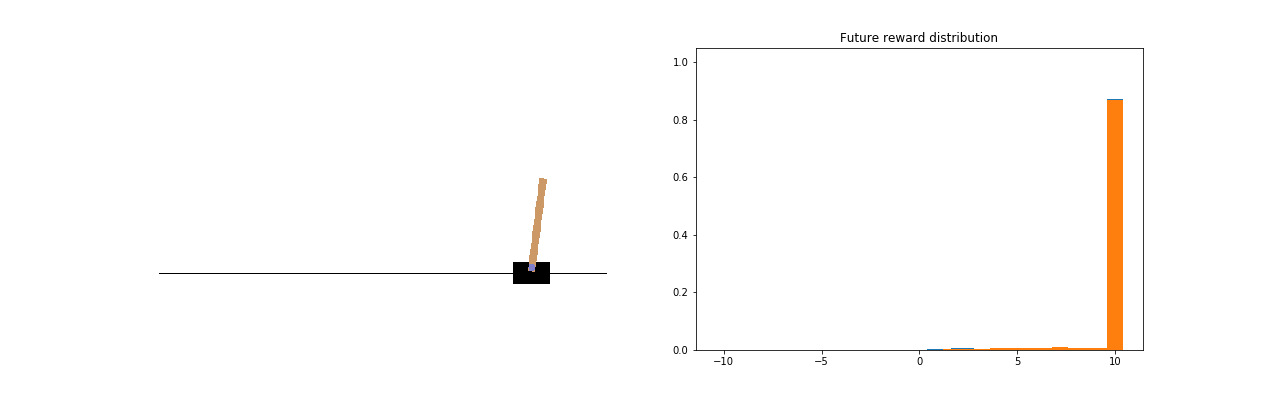
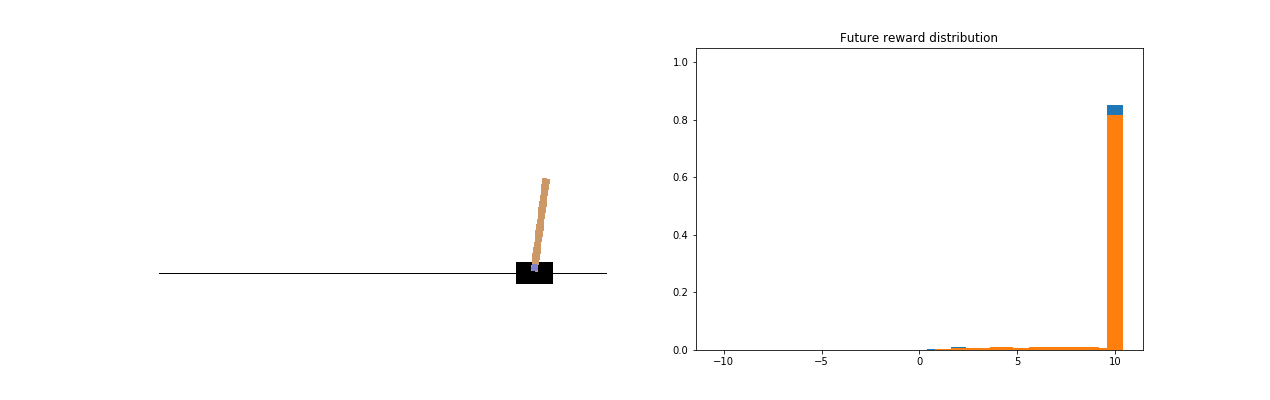
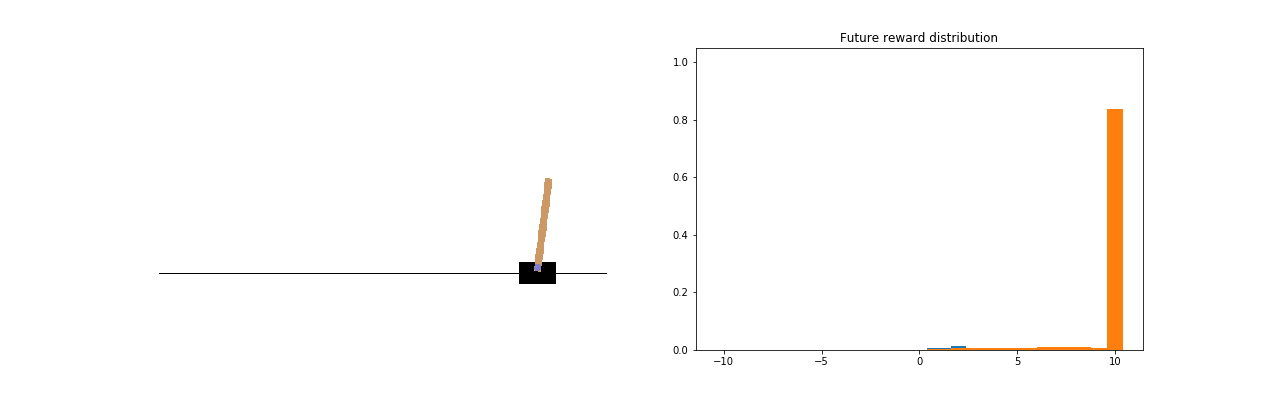
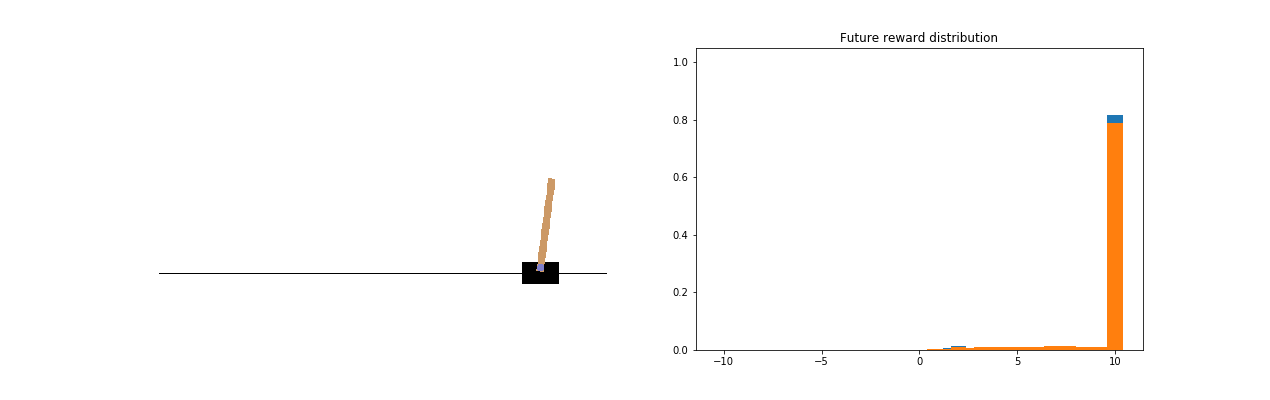
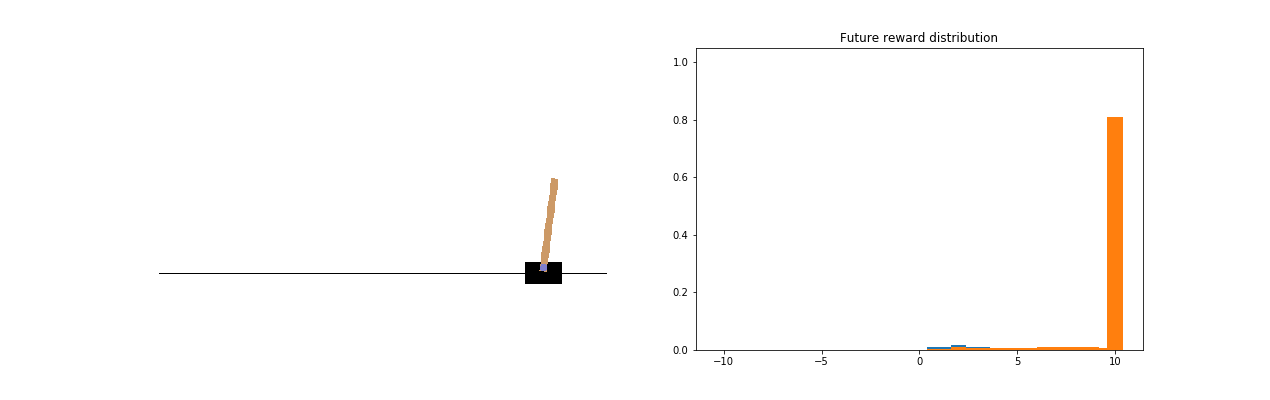
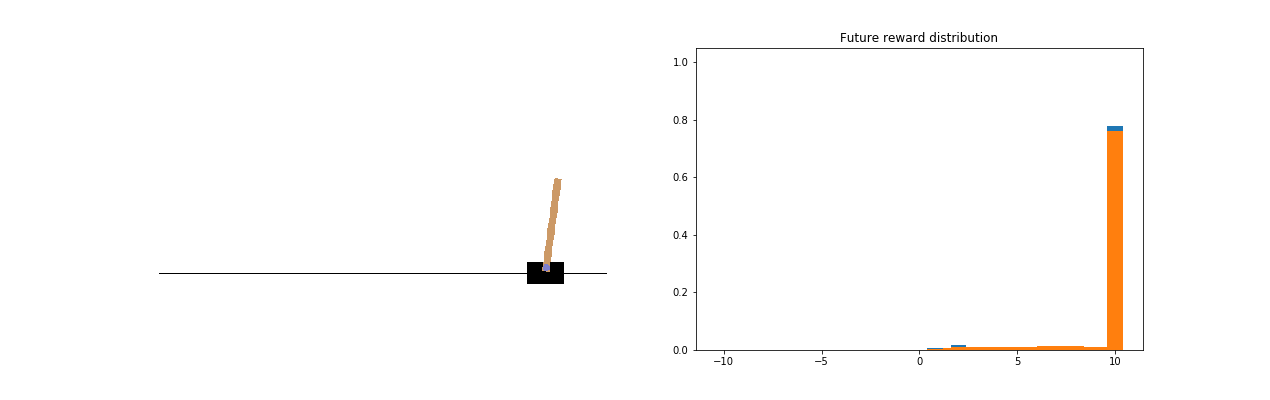
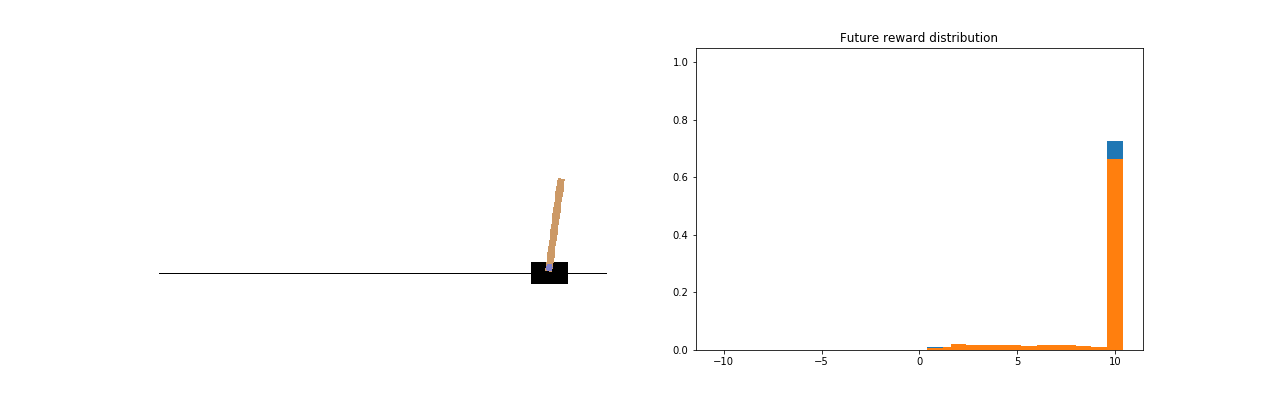
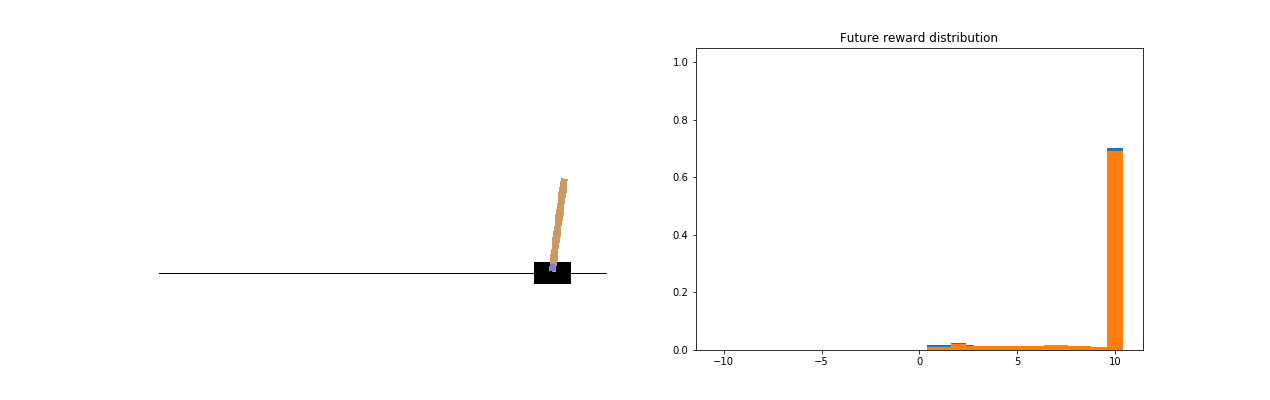
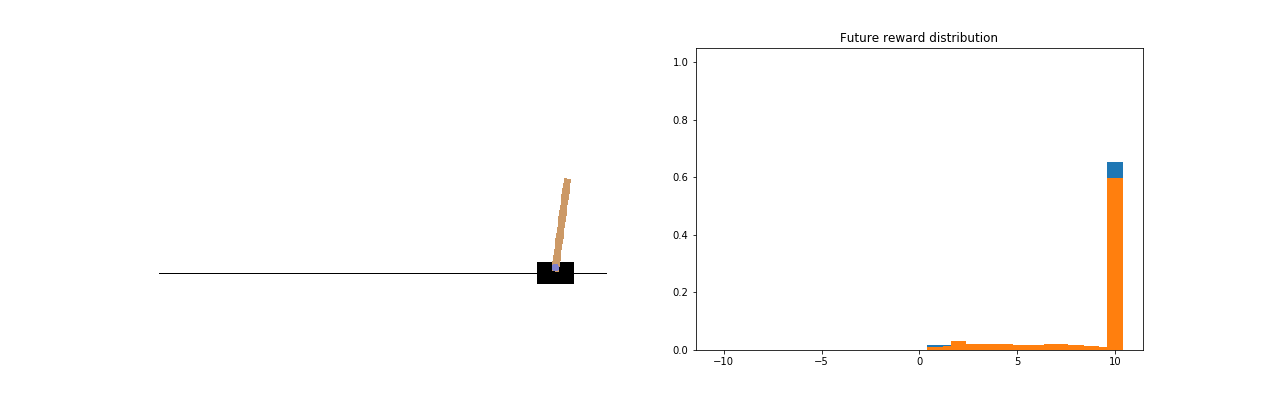
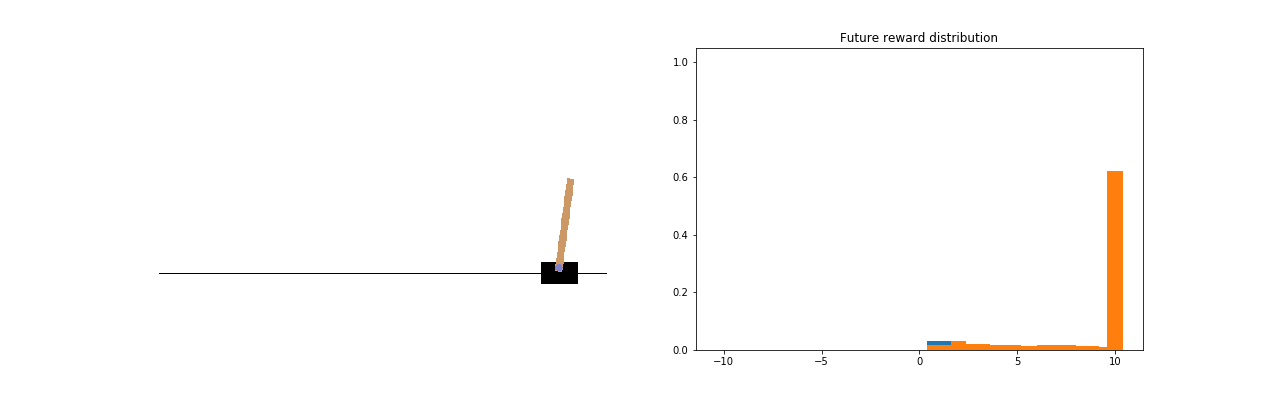
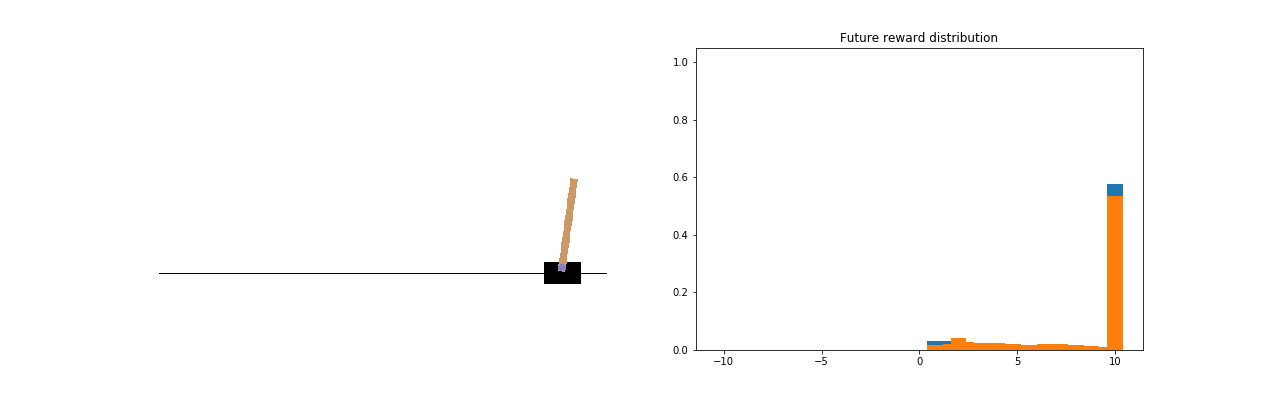
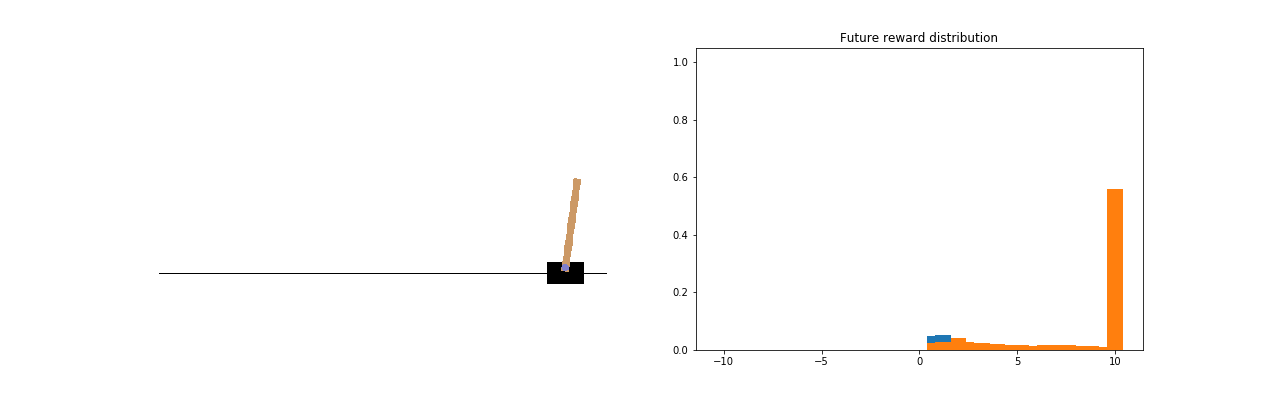
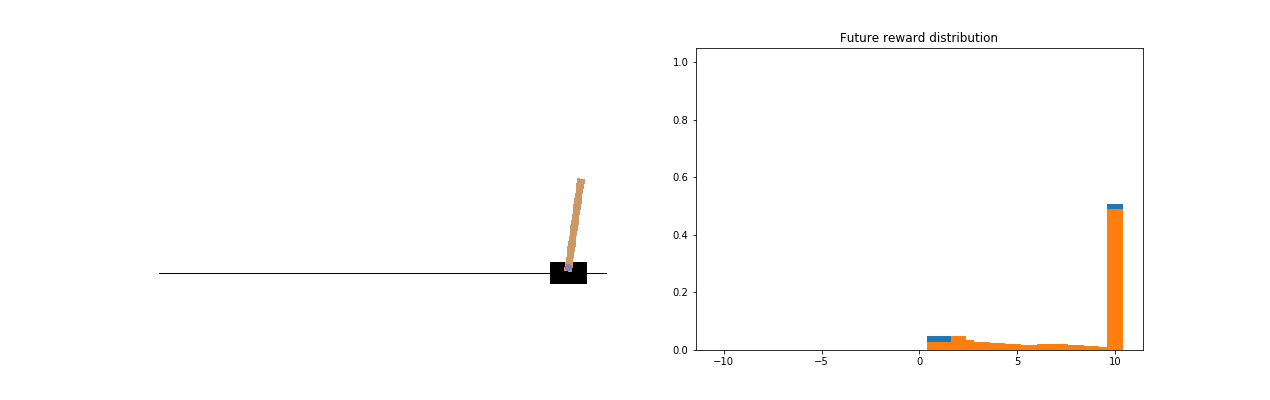
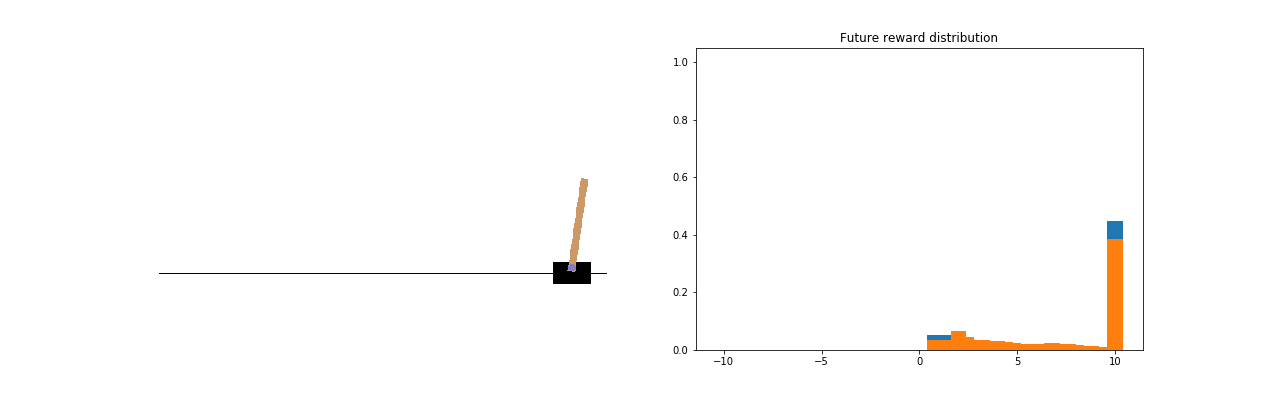
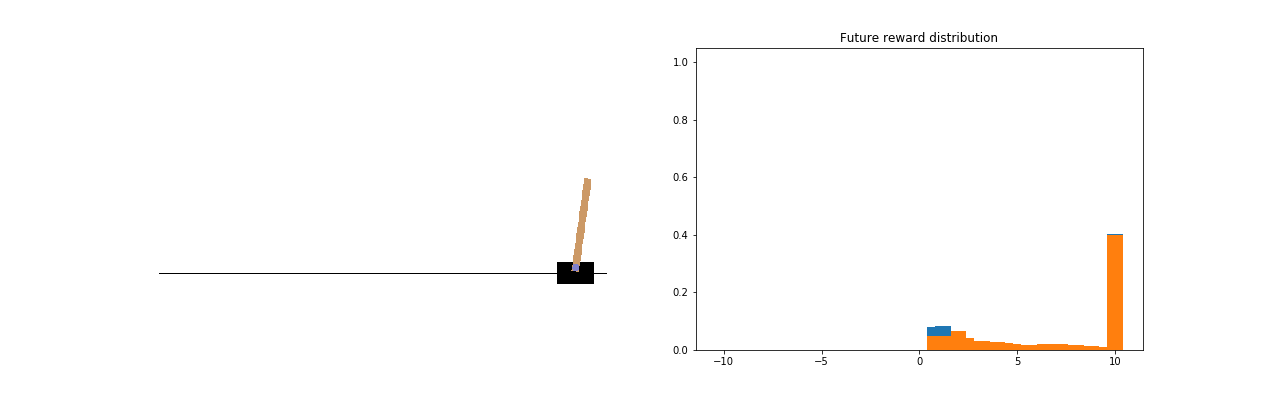
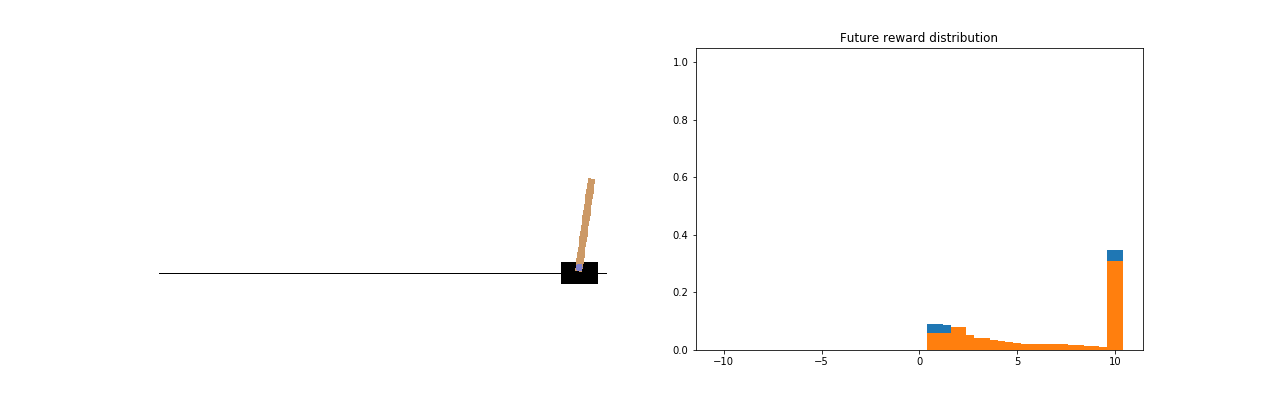
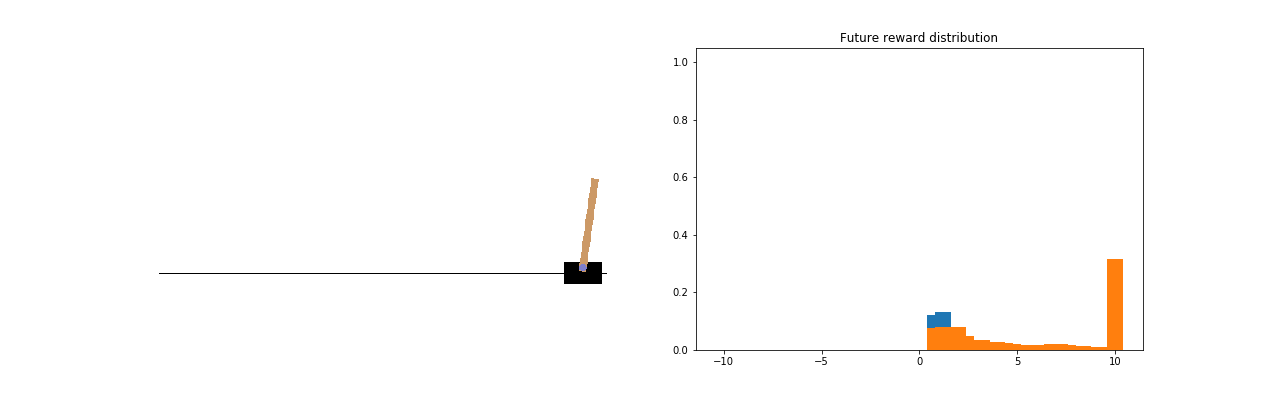
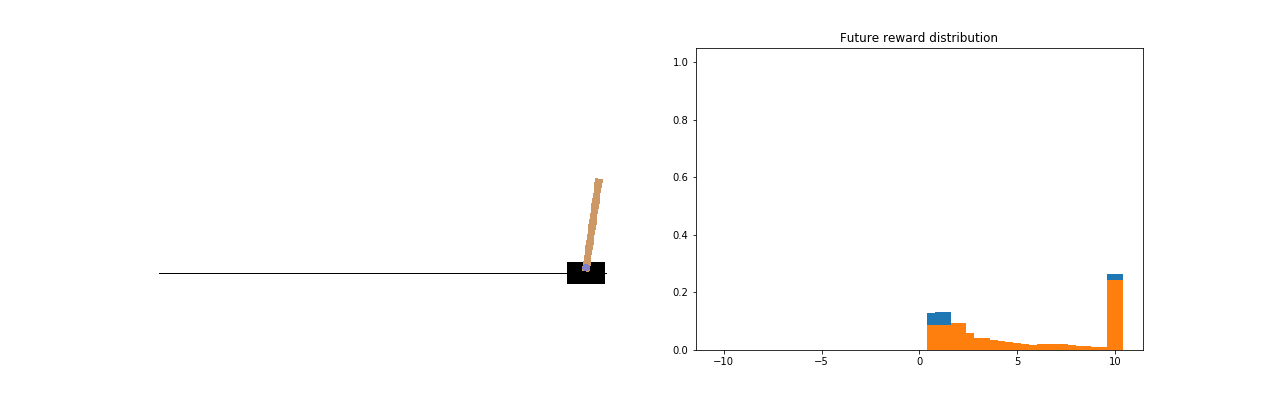
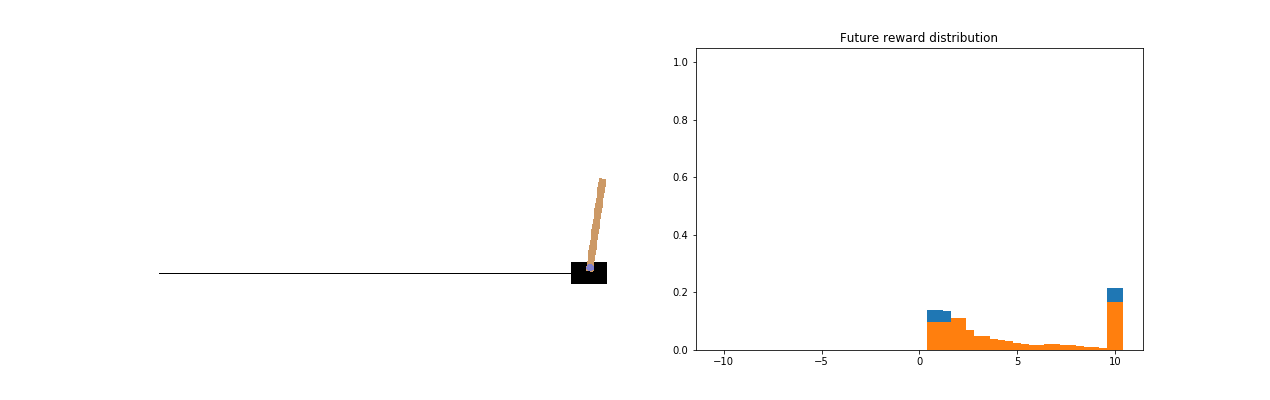
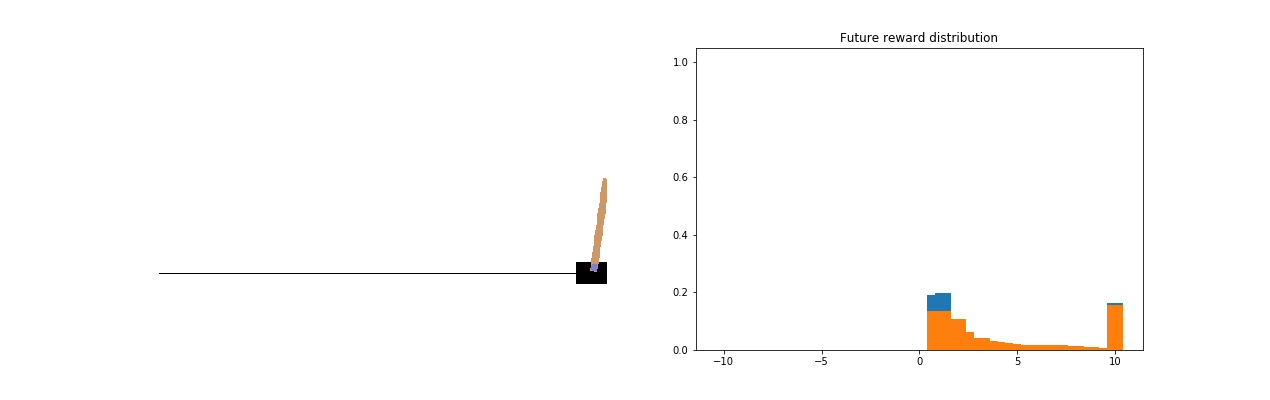
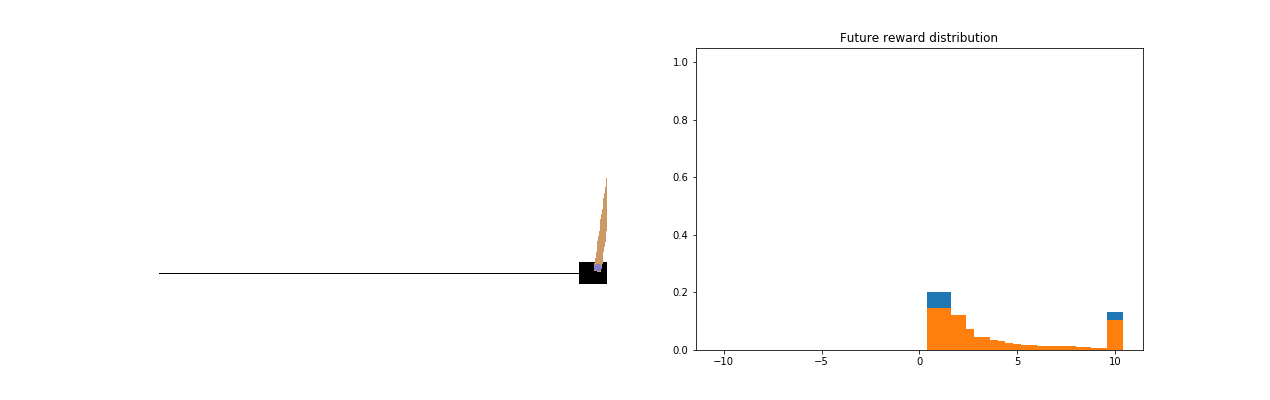
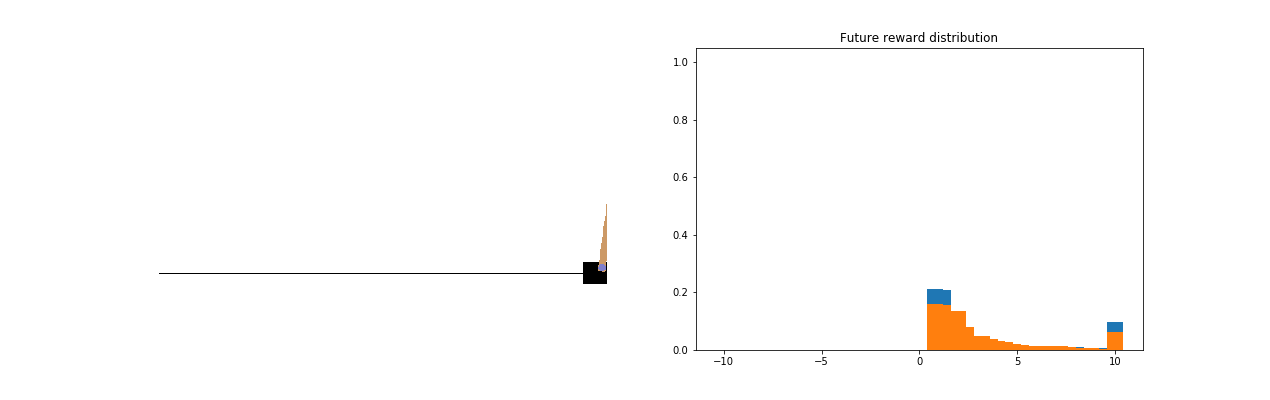
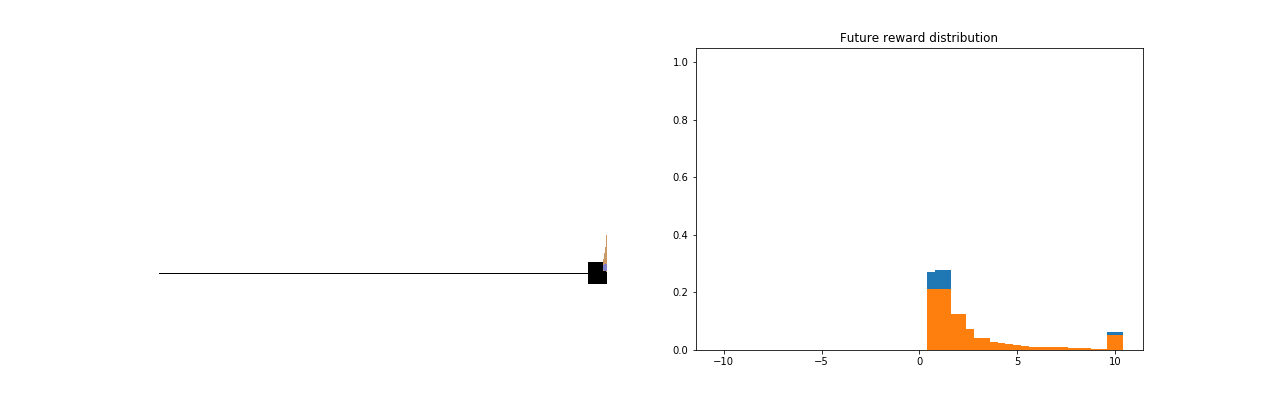

149.0

In [28]:
agent.play(record=True)

In [29]:
env.close()